# CNN-LSTM Hybrid for Decoding EEG

In this notebook, we will explore how a Resnet-LSTM performs on EEG data, which has both spatial and temporal components.
This Resnet-LSTM uses 5 residual blocks.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch import Tensor
from typing import Type
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
from scipy.signal import butter, filtfilt

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/C147_Final_Project/resnetLSTMv3.py .
from resnetLSTMv3 import *

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cpu


In [28]:
# Load training data
#/content/drive/MyDrive/C147_Final_Project/project_data/project/X_test.npy
X_train_valid = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/y_train_valid.npy")
y_train_valid = y_train_valid - 769
person_train_valid = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/person_train_valid.npy")

# Load test data
x_test = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/y_test.npy")
y_test = y_test - 769
person_test = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/person_test.npy")

# Print shapes
print('X train: ', X_train_valid.shape)
print('y train: ', y_train_valid.shape)
print('Person train+valid: ', person_train_valid.shape)
print('X test: ', x_test.shape)
print('y test: ', y_test.shape)
print('Person test: ', person_test.shape)

X train:  (2115, 22, 1000)
y train:  (2115,)
Person train+valid:  (2115, 1)
X test:  (443, 22, 1000)
y test:  (443,)
Person test:  (443, 1)


## Part 1: Training and validating on raw EEG data

In [6]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

#Convert to tensors
x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of training set: torch.Size([1692, 22, 1000])
Shape of validation set: torch.Size([423, 22, 1000])
Shape of training labels: (1692,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([1692, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torch.Size([1692, 22, 1000, 1])
Shape of validation set after adding width info: torch.Size([423, 22, 1000, 1])
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: torch.Size([1692, 1, 22, 1000])
Shape of validation set after dimension reshaping: torch.Size([423, 1, 22, 1000])
Shape of test set after dimension reshaping: torch.Size([443, 1, 22, 1000])


In [ ]:
#Test random sample function
bsz = 10
x_train_sample, y_train_sample = sample(x_train, y_train, bsz)
print(len(x_train_sample), len(y_train_sample))

10 10


In [7]:
# Build model
model1 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=1000, dropout=0.6).to(device)
print(model1)
total_params = sum(p.numel() for p in model1.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_1, val_history_1 = np.array([]), np.array([])
train_loss_hist_1, val_loss_hist_1 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = "/content/drive/MyDrive/C147_Final_Project/best_model_params_v3"

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model1_params.pt')
    torch.save(model1.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model1.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model1(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            #with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                # y_hat = torch.argmax(logits, dim=1)
                # train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                # train_count = train_x.size(0)
                # train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())

        y_hat = torch.argmax(logits, dim=1)
        train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
        train_count = train_x.size(0)
        train_count = float(train_count)
        train_acc = train_correct_count / train_count

        #Rename
        model1.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model1(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_1 = np.append(train_history_1, train_acc.item())
        val_history_1 = np.append(val_history_1, val_acc.item())
        train_loss_hist_1 = np.append(train_loss_hist_1, loss.item())
        val_loss_hist_1 = np.append(val_loss_hist_1, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model1.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-12-325225542769>:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:10<1:26:21, 10.38s/it]

Epoch 1 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.382, Val loss: 1.385
Epoch 2 Finished!!!
Train acc: 0.320, Val acc: 0.274
Train loss: 1.382, Val loss: 1.384


  0%|          | 2/500 [00:12<44:05,  5.31s/it]  

Epoch 3 Finished!!!
Train acc: 0.190, Val acc: 0.272
Train loss: 1.392, Val loss: 1.384


  1%|          | 4/500 [00:15<24:08,  2.92s/it]

Epoch 4 Finished!!!
Train acc: 0.320, Val acc: 0.213
Train loss: 1.379, Val loss: 1.387
Epoch 5 Finished!!!
Train acc: 0.290, Val acc: 0.319
Train loss: 1.377, Val loss: 1.377


  1%|          | 6/500 [00:19<18:33,  2.25s/it]

Epoch 6 Finished!!!
Train acc: 0.370, Val acc: 0.317
Train loss: 1.360, Val loss: 1.371
Epoch 7 Finished!!!
Train acc: 0.420, Val acc: 0.381
Train loss: 1.352, Val loss: 1.361


  2%|▏         | 8/500 [00:22<16:22,  2.00s/it]

Epoch 8 Finished!!!
Train acc: 0.430, Val acc: 0.359
Train loss: 1.352, Val loss: 1.349


  2%|▏         | 9/500 [00:24<15:44,  1.92s/it]

Epoch 9 Finished!!!
Train acc: 0.500, Val acc: 0.352
Train loss: 1.284, Val loss: 1.343
Epoch 10 Finished!!!
Train acc: 0.370, Val acc: 0.364


  2%|▏         | 10/500 [00:26<15:18,  1.87s/it]

Train loss: 1.327, Val loss: 1.340
Epoch 11 Finished!!!


  2%|▏         | 11/500 [00:28<15:01,  1.84s/it]

Train acc: 0.410, Val acc: 0.378
Train loss: 1.326, Val loss: 1.328
Epoch 12 Finished!!!
Train acc: 0.450, Val acc: 0.416


  2%|▏         | 12/500 [00:29<14:52,  1.83s/it]

Train loss: 1.296, Val loss: 1.317
Epoch 13 Finished!!!


  3%|▎         | 13/500 [00:31<14:42,  1.81s/it]

Train acc: 0.440, Val acc: 0.371
Train loss: 1.269, Val loss: 1.329
Epoch 14 Finished!!!
Train acc: 0.520, Val acc: 0.426
Train loss: 1.269, Val loss: 1.314


  3%|▎         | 15/500 [00:35<14:32,  1.80s/it]

Epoch 15 Finished!!!
Train acc: 0.520, Val acc: 0.385
Train loss: 1.270, Val loss: 1.322
Epoch 16 Finished!!!
Train acc: 0.420, Val acc: 0.414
Train loss: 1.291, Val loss: 1.315


  3%|▎         | 17/500 [00:38<14:26,  1.79s/it]

Epoch 17 Finished!!!
Train acc: 0.450, Val acc: 0.390
Train loss: 1.283, Val loss: 1.316


  4%|▎         | 18/500 [00:40<14:24,  1.79s/it]

Epoch 18 Finished!!!
Train acc: 0.460, Val acc: 0.426
Train loss: 1.268, Val loss: 1.306
Epoch 19 Finished!!!


  4%|▍         | 19/500 [00:42<14:26,  1.80s/it]

Train acc: 0.580, Val acc: 0.428
Train loss: 1.178, Val loss: 1.301
Epoch 20 Finished!!!
Train acc: 0.470, Val acc: 0.426


  4%|▍         | 20/500 [00:44<14:21,  1.80s/it]

Train loss: 1.289, Val loss: 1.299
Epoch 21 Finished!!!
Train acc: 0.490, Val acc: 0.430
Train loss: 1.231, Val loss: 1.299


  4%|▍         | 21/500 [00:46<14:26,  1.81s/it]

Epoch 22 Finished!!!


  4%|▍         | 22/500 [00:47<14:22,  1.81s/it]

Train acc: 0.500, Val acc: 0.404
Train loss: 1.237, Val loss: 1.301
Epoch 23 Finished!!!


  5%|▍         | 23/500 [00:49<14:20,  1.80s/it]

Train acc: 0.450, Val acc: 0.411
Train loss: 1.276, Val loss: 1.301
Epoch 24 Finished!!!


  5%|▍         | 24/500 [00:51<14:21,  1.81s/it]

Train acc: 0.530, Val acc: 0.433
Train loss: 1.242, Val loss: 1.296
Epoch 25 Finished!!!


  5%|▌         | 25/500 [00:53<14:18,  1.81s/it]

Train acc: 0.510, Val acc: 0.423
Train loss: 1.222, Val loss: 1.292
Epoch 26 Finished!!!


  5%|▌         | 26/500 [00:55<14:16,  1.81s/it]

Train acc: 0.420, Val acc: 0.411
Train loss: 1.262, Val loss: 1.294
Epoch 27 Finished!!!


  5%|▌         | 27/500 [00:56<14:15,  1.81s/it]

Train acc: 0.530, Val acc: 0.409
Train loss: 1.225, Val loss: 1.302
Epoch 28 Finished!!!


  6%|▌         | 28/500 [00:58<14:14,  1.81s/it]

Train acc: 0.480, Val acc: 0.416
Train loss: 1.265, Val loss: 1.299


  6%|▌         | 29/500 [01:00<14:13,  1.81s/it]

Epoch 29 Finished!!!
Train acc: 0.530, Val acc: 0.428
Train loss: 1.221, Val loss: 1.298
Epoch 30 Finished!!!


  6%|▌         | 30/500 [01:02<14:12,  1.81s/it]

Train acc: 0.500, Val acc: 0.421
Train loss: 1.237, Val loss: 1.293
Epoch 31 Finished!!!


  6%|▌         | 31/500 [01:04<14:11,  1.82s/it]

Train acc: 0.590, Val acc: 0.423
Train loss: 1.230, Val loss: 1.302
Epoch 32 Finished!!!


  6%|▋         | 32/500 [01:05<14:16,  1.83s/it]

Train acc: 0.510, Val acc: 0.435
Train loss: 1.216, Val loss: 1.287


  7%|▋         | 33/500 [01:07<14:14,  1.83s/it]

Epoch 33 Finished!!!
Train acc: 0.610, Val acc: 0.430
Train loss: 1.155, Val loss: 1.292
Epoch 34 Finished!!!


  7%|▋         | 34/500 [01:09<14:13,  1.83s/it]

Train acc: 0.530, Val acc: 0.423
Train loss: 1.217, Val loss: 1.292
Epoch 35 Finished!!!


  7%|▋         | 35/500 [01:11<14:12,  1.83s/it]

Train acc: 0.500, Val acc: 0.409
Train loss: 1.236, Val loss: 1.298


  7%|▋         | 36/500 [01:13<14:11,  1.83s/it]

Epoch 36 Finished!!!
Train acc: 0.470, Val acc: 0.433
Train loss: 1.256, Val loss: 1.285
Epoch 37 Finished!!!


  7%|▋         | 37/500 [01:15<14:12,  1.84s/it]

Train acc: 0.570, Val acc: 0.447
Train loss: 1.198, Val loss: 1.285
Epoch 38 Finished!!!


  8%|▊         | 38/500 [01:17<14:08,  1.84s/it]

Train acc: 0.490, Val acc: 0.440
Train loss: 1.249, Val loss: 1.293
Epoch 39 Finished!!!


  8%|▊         | 39/500 [01:18<14:07,  1.84s/it]

Train acc: 0.480, Val acc: 0.426
Train loss: 1.232, Val loss: 1.299
Epoch 40 Finished!!!


  8%|▊         | 40/500 [01:20<14:05,  1.84s/it]

Train acc: 0.580, Val acc: 0.414
Train loss: 1.176, Val loss: 1.294
Epoch 41 Finished!!!


  8%|▊         | 41/500 [01:22<14:04,  1.84s/it]

Train acc: 0.520, Val acc: 0.428
Train loss: 1.208, Val loss: 1.288
Epoch 42 Finished!!!


  8%|▊         | 42/500 [01:24<14:03,  1.84s/it]

Train acc: 0.420, Val acc: 0.418
Train loss: 1.283, Val loss: 1.288
Epoch 43 Finished!!!


  9%|▊         | 43/500 [01:26<14:02,  1.84s/it]

Train acc: 0.590, Val acc: 0.423
Train loss: 1.179, Val loss: 1.292


  9%|▉         | 44/500 [01:28<14:03,  1.85s/it]

Epoch 44 Finished!!!
Train acc: 0.530, Val acc: 0.409
Train loss: 1.215, Val loss: 1.300
Epoch 45 Finished!!!


  9%|▉         | 45/500 [01:29<14:04,  1.86s/it]

Train acc: 0.490, Val acc: 0.414
Train loss: 1.248, Val loss: 1.294
Epoch 46 Finished!!!


  9%|▉         | 46/500 [01:31<14:02,  1.86s/it]

Train acc: 0.480, Val acc: 0.392
Train loss: 1.251, Val loss: 1.295
Epoch 47 Finished!!!


  9%|▉         | 47/500 [01:33<14:01,  1.86s/it]

Train acc: 0.510, Val acc: 0.390
Train loss: 1.229, Val loss: 1.316
Epoch 48 Finished!!!


 10%|▉         | 48/500 [01:35<13:59,  1.86s/it]

Train acc: 0.600, Val acc: 0.407
Train loss: 1.162, Val loss: 1.292
Epoch 49 Finished!!!
Train acc: 0.520, Val acc: 0.397
Train loss: 1.251, Val loss: 1.299

 10%|▉         | 49/500 [01:37<13:58,  1.86s/it]


Epoch 50 Finished!!!


 10%|█         | 50/500 [01:39<13:56,  1.86s/it]

Train acc: 0.420, Val acc: 0.430
Train loss: 1.284, Val loss: 1.286
Epoch 51 Finished!!!


 10%|█         | 51/500 [01:41<13:55,  1.86s/it]

Train acc: 0.540, Val acc: 0.395
Train loss: 1.216, Val loss: 1.295
Epoch 52 Finished!!!


 10%|█         | 52/500 [01:42<13:55,  1.86s/it]

Train acc: 0.550, Val acc: 0.402
Train loss: 1.205, Val loss: 1.297
Epoch 53 Finished!!!


 11%|█         | 53/500 [01:44<13:54,  1.87s/it]

Train acc: 0.480, Val acc: 0.428
Train loss: 1.253, Val loss: 1.287
Epoch 54 Finished!!!


 11%|█         | 54/500 [01:46<13:53,  1.87s/it]

Train acc: 0.530, Val acc: 0.416
Train loss: 1.206, Val loss: 1.284
Epoch 55 Finished!!!


 11%|█         | 55/500 [01:48<13:55,  1.88s/it]

Train acc: 0.490, Val acc: 0.454
Train loss: 1.232, Val loss: 1.281
Epoch 56 Finished!!!


 11%|█         | 56/500 [01:50<13:53,  1.88s/it]

Train acc: 0.460, Val acc: 0.418
Train loss: 1.286, Val loss: 1.301
Epoch 57 Finished!!!


 11%|█▏        | 57/500 [01:52<14:03,  1.90s/it]

Train acc: 0.480, Val acc: 0.433
Train loss: 1.243, Val loss: 1.281
Epoch 58 Finished!!!


 12%|█▏        | 58/500 [01:54<13:58,  1.90s/it]

Train acc: 0.490, Val acc: 0.433
Train loss: 1.227, Val loss: 1.277
Epoch 59 Finished!!!


 12%|█▏        | 59/500 [01:56<13:54,  1.89s/it]

Train acc: 0.530, Val acc: 0.421
Train loss: 1.201, Val loss: 1.284
Epoch 60 Finished!!!


 12%|█▏        | 60/500 [01:58<13:51,  1.89s/it]

Train acc: 0.500, Val acc: 0.426
Train loss: 1.232, Val loss: 1.291
Epoch 61 Finished!!!


 12%|█▏        | 61/500 [02:00<13:48,  1.89s/it]

Train acc: 0.480, Val acc: 0.423
Train loss: 1.233, Val loss: 1.291
Epoch 62 Finished!!!


 12%|█▏        | 62/500 [02:01<13:45,  1.89s/it]

Train acc: 0.590, Val acc: 0.416
Train loss: 1.184, Val loss: 1.289
Epoch 63 Finished!!!


 13%|█▎        | 63/500 [02:03<13:43,  1.88s/it]

Train acc: 0.480, Val acc: 0.430
Train loss: 1.226, Val loss: 1.285
Epoch 64 Finished!!!


 13%|█▎        | 64/500 [02:05<13:41,  1.88s/it]

Train acc: 0.510, Val acc: 0.411
Train loss: 1.222, Val loss: 1.310
Epoch 65 Finished!!!


 13%|█▎        | 65/500 [02:07<13:39,  1.88s/it]

Train acc: 0.530, Val acc: 0.416
Train loss: 1.201, Val loss: 1.287
Epoch 66 Finished!!!


 13%|█▎        | 66/500 [02:09<13:36,  1.88s/it]

Train acc: 0.490, Val acc: 0.428
Train loss: 1.227, Val loss: 1.292
Epoch 67 Finished!!!


 13%|█▎        | 67/500 [02:11<13:34,  1.88s/it]

Train acc: 0.510, Val acc: 0.411
Train loss: 1.236, Val loss: 1.298
Epoch 68 Finished!!!


 14%|█▎        | 68/500 [02:13<13:32,  1.88s/it]

Train acc: 0.480, Val acc: 0.437
Train loss: 1.238, Val loss: 1.291
Epoch 69 Finished!!!


 14%|█▍        | 69/500 [02:15<13:30,  1.88s/it]

Train acc: 0.580, Val acc: 0.407
Train loss: 1.179, Val loss: 1.300
Epoch 70 Finished!!!


 14%|█▍        | 70/500 [02:16<13:28,  1.88s/it]

Train acc: 0.550, Val acc: 0.437
Train loss: 1.225, Val loss: 1.277
Epoch 71 Finished!!!


 14%|█▍        | 71/500 [02:18<13:26,  1.88s/it]

Train acc: 0.540, Val acc: 0.442
Train loss: 1.205, Val loss: 1.278
Epoch 72 Finished!!!


 14%|█▍        | 72/500 [02:20<13:23,  1.88s/it]

Train acc: 0.570, Val acc: 0.433
Train loss: 1.173, Val loss: 1.275
Epoch 73 Finished!!!


 15%|█▍        | 73/500 [02:22<13:21,  1.88s/it]

Train acc: 0.560, Val acc: 0.442
Train loss: 1.184, Val loss: 1.273
Epoch 74 Finished!!!


 15%|█▍        | 74/500 [02:24<13:19,  1.88s/it]

Train acc: 0.640, Val acc: 0.414
Train loss: 1.136, Val loss: 1.298
Epoch 75 Finished!!!


 15%|█▌        | 75/500 [02:26<13:16,  1.87s/it]

Train acc: 0.530, Val acc: 0.440
Train loss: 1.208, Val loss: 1.277
Epoch 76 Finished!!!


 15%|█▌        | 76/500 [02:28<13:14,  1.87s/it]

Train acc: 0.630, Val acc: 0.447
Train loss: 1.130, Val loss: 1.273
Epoch 77 Finished!!!


 15%|█▌        | 77/500 [02:30<13:12,  1.87s/it]

Train acc: 0.570, Val acc: 0.454
Train loss: 1.179, Val loss: 1.269
Epoch 78 Finished!!!


 16%|█▌        | 78/500 [02:31<13:09,  1.87s/it]

Train acc: 0.590, Val acc: 0.435
Train loss: 1.140, Val loss: 1.279
Epoch 79 Finished!!!


 16%|█▌        | 79/500 [02:33<13:07,  1.87s/it]

Train acc: 0.530, Val acc: 0.447
Train loss: 1.199, Val loss: 1.276
Epoch 80 Finished!!!


 16%|█▌        | 80/500 [02:35<13:05,  1.87s/it]

Train acc: 0.520, Val acc: 0.421
Train loss: 1.203, Val loss: 1.288
Epoch 81 Finished!!!


 16%|█▌        | 81/500 [02:37<13:03,  1.87s/it]

Train acc: 0.540, Val acc: 0.440
Train loss: 1.192, Val loss: 1.280
Epoch 82 Finished!!!


 16%|█▋        | 82/500 [02:39<13:01,  1.87s/it]

Train acc: 0.600, Val acc: 0.430
Train loss: 1.161, Val loss: 1.286
Epoch 83 Finished!!!


 17%|█▋        | 83/500 [02:41<12:59,  1.87s/it]

Train acc: 0.580, Val acc: 0.442
Train loss: 1.166, Val loss: 1.281
Epoch 84 Finished!!!


 17%|█▋        | 84/500 [02:43<12:57,  1.87s/it]

Train acc: 0.540, Val acc: 0.442
Train loss: 1.210, Val loss: 1.275
Epoch 85 Finished!!!


 17%|█▋        | 85/500 [02:44<12:55,  1.87s/it]

Train acc: 0.550, Val acc: 0.433
Train loss: 1.192, Val loss: 1.283
Epoch 86 Finished!!!


 17%|█▋        | 86/500 [02:46<12:53,  1.87s/it]

Train acc: 0.540, Val acc: 0.430
Train loss: 1.181, Val loss: 1.283
Epoch 87 Finished!!!


 17%|█▋        | 87/500 [02:48<12:50,  1.87s/it]

Train acc: 0.580, Val acc: 0.444
Train loss: 1.174, Val loss: 1.280
Epoch 88 Finished!!!


 18%|█▊        | 88/500 [02:50<12:49,  1.87s/it]

Train acc: 0.630, Val acc: 0.440
Train loss: 1.144, Val loss: 1.281
Epoch 89 Finished!!!


 18%|█▊        | 89/500 [02:52<12:50,  1.87s/it]

Train acc: 0.640, Val acc: 0.459
Train loss: 1.116, Val loss: 1.265
Epoch 90 Finished!!!


 18%|█▊        | 90/500 [02:54<12:46,  1.87s/it]

Train acc: 0.570, Val acc: 0.444
Train loss: 1.179, Val loss: 1.272
Epoch 91 Finished!!!


 18%|█▊        | 91/500 [02:56<12:48,  1.88s/it]

Train acc: 0.530, Val acc: 0.482
Train loss: 1.202, Val loss: 1.253
Epoch 92 Finished!!!


 18%|█▊        | 92/500 [02:58<12:45,  1.88s/it]

Train acc: 0.600, Val acc: 0.459
Train loss: 1.160, Val loss: 1.272
Epoch 93 Finished!!!


 19%|█▊        | 93/500 [03:00<12:45,  1.88s/it]

Train acc: 0.610, Val acc: 0.447
Train loss: 1.125, Val loss: 1.267
Epoch 94 Finished!!!


 19%|█▉        | 94/500 [03:01<12:42,  1.88s/it]

Train acc: 0.650, Val acc: 0.418
Train loss: 1.109, Val loss: 1.300
Epoch 95 Finished!!!


 19%|█▉        | 95/500 [03:03<12:39,  1.88s/it]

Train acc: 0.500, Val acc: 0.433
Train loss: 1.232, Val loss: 1.283
Epoch 96 Finished!!!


 19%|█▉        | 96/500 [03:05<12:37,  1.87s/it]

Train acc: 0.680, Val acc: 0.456
Train loss: 1.100, Val loss: 1.269
Epoch 97 Finished!!!


 19%|█▉        | 97/500 [03:07<12:35,  1.88s/it]

Train acc: 0.620, Val acc: 0.444
Train loss: 1.135, Val loss: 1.284
Epoch 98 Finished!!!


 20%|█▉        | 98/500 [03:09<12:33,  1.87s/it]

Train acc: 0.560, Val acc: 0.433
Train loss: 1.181, Val loss: 1.277
Epoch 99 Finished!!!


 20%|█▉        | 99/500 [03:11<12:31,  1.87s/it]

Train acc: 0.560, Val acc: 0.442
Train loss: 1.180, Val loss: 1.279
Epoch 100 Finished!!!


 20%|██        | 100/500 [03:13<12:29,  1.87s/it]

Train acc: 0.660, Val acc: 0.437
Train loss: 1.092, Val loss: 1.282
Epoch 101 Finished!!!


 20%|██        | 101/500 [03:14<12:27,  1.87s/it]

Train acc: 0.640, Val acc: 0.430
Train loss: 1.129, Val loss: 1.286
Epoch 102 Finished!!!


 20%|██        | 102/500 [03:16<12:25,  1.87s/it]

Train acc: 0.640, Val acc: 0.444
Train loss: 1.110, Val loss: 1.279
Epoch 103 Finished!!!


 21%|██        | 103/500 [03:18<12:23,  1.87s/it]

Train acc: 0.530, Val acc: 0.435
Train loss: 1.204, Val loss: 1.287
Epoch 104 Finished!!!


 21%|██        | 104/500 [03:20<12:21,  1.87s/it]

Train acc: 0.640, Val acc: 0.449
Train loss: 1.121, Val loss: 1.273
Epoch 105 Finished!!!


 21%|██        | 105/500 [03:22<12:20,  1.87s/it]

Train acc: 0.600, Val acc: 0.433
Train loss: 1.161, Val loss: 1.290
Epoch 106 Finished!!!


 21%|██        | 106/500 [03:24<12:18,  1.88s/it]

Train acc: 0.560, Val acc: 0.440
Train loss: 1.154, Val loss: 1.275
Epoch 107 Finished!!!


 21%|██▏       | 107/500 [03:26<12:17,  1.88s/it]

Train acc: 0.630, Val acc: 0.430
Train loss: 1.128, Val loss: 1.281
Epoch 108 Finished!!!


 22%|██▏       | 108/500 [03:28<12:15,  1.88s/it]

Train acc: 0.640, Val acc: 0.430
Train loss: 1.112, Val loss: 1.283
Epoch 109 Finished!!!


 22%|██▏       | 109/500 [03:29<12:13,  1.88s/it]

Train acc: 0.690, Val acc: 0.423
Train loss: 1.051, Val loss: 1.295
Epoch 110 Finished!!!


 22%|██▏       | 110/500 [03:31<12:11,  1.88s/it]

Train acc: 0.610, Val acc: 0.440
Train loss: 1.125, Val loss: 1.277
Epoch 111 Finished!!!


 22%|██▏       | 111/500 [03:33<12:09,  1.88s/it]

Train acc: 0.560, Val acc: 0.440
Train loss: 1.174, Val loss: 1.281
Epoch 112 Finished!!!


 22%|██▏       | 112/500 [03:35<12:07,  1.88s/it]

Train acc: 0.650, Val acc: 0.437
Train loss: 1.098, Val loss: 1.278
Epoch 113 Finished!!!


 23%|██▎       | 113/500 [03:37<12:07,  1.88s/it]

Train acc: 0.600, Val acc: 0.421
Train loss: 1.136, Val loss: 1.283
Epoch 114 Finished!!!


 23%|██▎       | 114/500 [03:39<12:05,  1.88s/it]

Train acc: 0.670, Val acc: 0.437
Train loss: 1.083, Val loss: 1.284
Epoch 115 Finished!!!


 23%|██▎       | 115/500 [03:41<12:02,  1.88s/it]

Train acc: 0.640, Val acc: 0.447
Train loss: 1.095, Val loss: 1.279
Epoch 116 Finished!!!


 23%|██▎       | 116/500 [03:43<12:00,  1.88s/it]

Train acc: 0.640, Val acc: 0.442
Train loss: 1.106, Val loss: 1.276
Epoch 117 Finished!!!


 23%|██▎       | 117/500 [03:45<11:58,  1.88s/it]

Train acc: 0.610, Val acc: 0.423
Train loss: 1.129, Val loss: 1.288
Epoch 118 Finished!!!


 24%|██▎       | 118/500 [03:46<11:57,  1.88s/it]

Train acc: 0.640, Val acc: 0.440
Train loss: 1.121, Val loss: 1.278
Epoch 119 Finished!!!


 24%|██▍       | 119/500 [03:48<11:55,  1.88s/it]

Train acc: 0.720, Val acc: 0.430
Train loss: 1.049, Val loss: 1.288
Epoch 120 Finished!!!


 24%|██▍       | 120/500 [03:50<11:53,  1.88s/it]

Train acc: 0.690, Val acc: 0.447
Train loss: 1.081, Val loss: 1.282
Epoch 121 Finished!!!


 24%|██▍       | 121/500 [03:52<11:50,  1.88s/it]

Train acc: 0.770, Val acc: 0.418
Train loss: 1.019, Val loss: 1.290
Epoch 122 Finished!!!


 24%|██▍       | 122/500 [03:54<11:49,  1.88s/it]

Train acc: 0.580, Val acc: 0.444
Train loss: 1.147, Val loss: 1.281
Epoch 123 Finished!!!


 25%|██▍       | 123/500 [03:56<11:47,  1.88s/it]

Train acc: 0.630, Val acc: 0.430
Train loss: 1.109, Val loss: 1.280
Epoch 124 Finished!!!


 25%|██▍       | 124/500 [03:58<11:45,  1.88s/it]

Train acc: 0.590, Val acc: 0.433
Train loss: 1.165, Val loss: 1.280
Epoch 125 Finished!!!


 25%|██▌       | 125/500 [04:00<11:43,  1.88s/it]

Train acc: 0.720, Val acc: 0.440
Train loss: 1.078, Val loss: 1.272
Epoch 126 Finished!!!


 25%|██▌       | 126/500 [04:01<11:41,  1.88s/it]

Train acc: 0.650, Val acc: 0.442
Train loss: 1.112, Val loss: 1.280
Epoch 127 Finished!!!


 25%|██▌       | 127/500 [04:03<11:40,  1.88s/it]

Train acc: 0.600, Val acc: 0.430
Train loss: 1.132, Val loss: 1.281
Epoch 128 Finished!!!


 26%|██▌       | 128/500 [04:05<11:38,  1.88s/it]

Train acc: 0.670, Val acc: 0.428
Train loss: 1.085, Val loss: 1.289
Epoch 129 Finished!!!


 26%|██▌       | 129/500 [04:07<11:36,  1.88s/it]

Train acc: 0.590, Val acc: 0.411
Train loss: 1.134, Val loss: 1.298
Epoch 130 Finished!!!


 26%|██▌       | 130/500 [04:09<11:34,  1.88s/it]

Train acc: 0.620, Val acc: 0.428
Train loss: 1.106, Val loss: 1.283
Epoch 131 Finished!!!


 26%|██▌       | 131/500 [04:11<11:31,  1.87s/it]

Train acc: 0.600, Val acc: 0.449
Train loss: 1.131, Val loss: 1.274
Epoch 132 Finished!!!


 26%|██▋       | 132/500 [04:13<11:30,  1.88s/it]

Train acc: 0.570, Val acc: 0.430
Train loss: 1.163, Val loss: 1.284
Epoch 133 Finished!!!


 27%|██▋       | 133/500 [04:15<11:28,  1.88s/it]

Train acc: 0.640, Val acc: 0.416
Train loss: 1.116, Val loss: 1.292
Epoch 134 Finished!!!


 27%|██▋       | 134/500 [04:16<11:26,  1.88s/it]

Train acc: 0.650, Val acc: 0.447
Train loss: 1.099, Val loss: 1.284
Epoch 135 Finished!!!


 27%|██▋       | 135/500 [04:18<11:24,  1.87s/it]

Train acc: 0.650, Val acc: 0.428
Train loss: 1.108, Val loss: 1.290
Epoch 136 Finished!!!


 27%|██▋       | 136/500 [04:20<11:22,  1.87s/it]

Train acc: 0.710, Val acc: 0.447
Train loss: 1.077, Val loss: 1.281
Epoch 137 Finished!!!


 27%|██▋       | 137/500 [04:22<11:20,  1.87s/it]

Train acc: 0.690, Val acc: 0.423
Train loss: 1.061, Val loss: 1.289
Epoch 138 Finished!!!


 28%|██▊       | 138/500 [04:24<11:18,  1.88s/it]

Train acc: 0.510, Val acc: 0.444
Train loss: 1.222, Val loss: 1.282
Epoch 139 Finished!!!


 28%|██▊       | 139/500 [04:26<11:17,  1.88s/it]

Train acc: 0.640, Val acc: 0.430
Train loss: 1.106, Val loss: 1.296
Epoch 140 Finished!!!


 28%|██▊       | 140/500 [04:28<11:15,  1.88s/it]

Train acc: 0.630, Val acc: 0.440
Train loss: 1.114, Val loss: 1.280
Epoch 141 Finished!!!


 28%|██▊       | 141/500 [04:30<11:13,  1.87s/it]

Train acc: 0.670, Val acc: 0.435
Train loss: 1.077, Val loss: 1.285
Epoch 142 Finished!!!


 28%|██▊       | 142/500 [04:31<11:11,  1.87s/it]

Train acc: 0.560, Val acc: 0.433
Train loss: 1.153, Val loss: 1.280
Epoch 143 Finished!!!


 29%|██▊       | 143/500 [04:33<11:08,  1.87s/it]

Train acc: 0.590, Val acc: 0.433
Train loss: 1.167, Val loss: 1.286
Epoch 144 Finished!!!


 29%|██▉       | 144/500 [04:35<11:06,  1.87s/it]

Train acc: 0.680, Val acc: 0.435
Train loss: 1.092, Val loss: 1.286
Epoch 145 Finished!!!


 29%|██▉       | 145/500 [04:37<11:04,  1.87s/it]

Train acc: 0.690, Val acc: 0.444
Train loss: 1.070, Val loss: 1.269
Epoch 146 Finished!!!


 29%|██▉       | 146/500 [04:39<11:03,  1.87s/it]

Train acc: 0.640, Val acc: 0.418
Train loss: 1.122, Val loss: 1.294
Epoch 147 Finished!!!


 29%|██▉       | 147/500 [04:41<11:01,  1.87s/it]

Train acc: 0.690, Val acc: 0.444
Train loss: 1.087, Val loss: 1.275
Epoch 148 Finished!!!


 30%|██▉       | 148/500 [04:43<10:59,  1.87s/it]

Train acc: 0.690, Val acc: 0.468
Train loss: 1.087, Val loss: 1.274
Epoch 149 Finished!!!


 30%|██▉       | 149/500 [04:45<10:57,  1.87s/it]

Train acc: 0.620, Val acc: 0.433
Train loss: 1.138, Val loss: 1.288
Epoch 150 Finished!!!


 30%|███       | 150/500 [04:46<10:55,  1.87s/it]

Train acc: 0.690, Val acc: 0.433
Train loss: 1.085, Val loss: 1.284
Epoch 151 Finished!!!


 30%|███       | 151/500 [04:48<10:53,  1.87s/it]

Train acc: 0.690, Val acc: 0.418
Train loss: 1.097, Val loss: 1.294
Epoch 152 Finished!!!


 30%|███       | 152/500 [04:50<10:51,  1.87s/it]

Train acc: 0.620, Val acc: 0.418
Train loss: 1.105, Val loss: 1.296
Epoch 153 Finished!!!


 31%|███       | 153/500 [04:52<10:49,  1.87s/it]

Train acc: 0.570, Val acc: 0.440
Train loss: 1.171, Val loss: 1.281
Epoch 154 Finished!!!


 31%|███       | 154/500 [04:54<10:47,  1.87s/it]

Train acc: 0.620, Val acc: 0.430
Train loss: 1.123, Val loss: 1.282
Epoch 155 Finished!!!


 31%|███       | 155/500 [04:56<10:46,  1.87s/it]

Train acc: 0.730, Val acc: 0.418
Train loss: 1.037, Val loss: 1.302
Epoch 156 Finished!!!


 31%|███       | 156/500 [04:58<10:44,  1.87s/it]

Train acc: 0.770, Val acc: 0.426
Train loss: 0.997, Val loss: 1.282
Epoch 157 Finished!!!


 31%|███▏      | 157/500 [04:59<10:42,  1.87s/it]

Train acc: 0.650, Val acc: 0.428
Train loss: 1.104, Val loss: 1.290
Epoch 158 Finished!!!


 32%|███▏      | 158/500 [05:01<10:39,  1.87s/it]

Train acc: 0.680, Val acc: 0.442
Train loss: 1.091, Val loss: 1.285
Epoch 159 Finished!!!


 32%|███▏      | 159/500 [05:03<10:38,  1.87s/it]

Train acc: 0.570, Val acc: 0.440
Train loss: 1.165, Val loss: 1.281
Epoch 160 Finished!!!


 32%|███▏      | 160/500 [05:05<10:37,  1.87s/it]

Train acc: 0.570, Val acc: 0.433
Train loss: 1.164, Val loss: 1.285
Epoch 161 Finished!!!


 32%|███▏      | 161/500 [05:07<10:35,  1.87s/it]

Train acc: 0.730, Val acc: 0.435
Train loss: 1.007, Val loss: 1.285
Epoch 162 Finished!!!


 32%|███▏      | 162/500 [05:09<10:33,  1.87s/it]

Train acc: 0.560, Val acc: 0.433
Train loss: 1.165, Val loss: 1.286
Epoch 163 Finished!!!


 33%|███▎      | 163/500 [05:11<10:31,  1.87s/it]

Train acc: 0.700, Val acc: 0.428
Train loss: 1.073, Val loss: 1.282
Epoch 164 Finished!!!


 33%|███▎      | 164/500 [05:13<10:29,  1.87s/it]

Train acc: 0.670, Val acc: 0.430
Train loss: 1.062, Val loss: 1.289
Epoch 165 Finished!!!


 33%|███▎      | 165/500 [05:14<10:27,  1.87s/it]

Train acc: 0.720, Val acc: 0.426
Train loss: 1.053, Val loss: 1.292
Epoch 166 Finished!!!


 33%|███▎      | 166/500 [05:16<10:25,  1.87s/it]

Train acc: 0.620, Val acc: 0.428
Train loss: 1.131, Val loss: 1.295
Epoch 167 Finished!!!


 33%|███▎      | 167/500 [05:18<10:23,  1.87s/it]

Train acc: 0.670, Val acc: 0.435
Train loss: 1.082, Val loss: 1.287
Epoch 168 Finished!!!


 34%|███▎      | 168/500 [05:20<10:21,  1.87s/it]

Train acc: 0.740, Val acc: 0.430
Train loss: 1.032, Val loss: 1.293
Epoch 169 Finished!!!


 34%|███▍      | 169/500 [05:22<10:19,  1.87s/it]

Train acc: 0.690, Val acc: 0.433
Train loss: 1.058, Val loss: 1.293
Epoch 170 Finished!!!


 34%|███▍      | 170/500 [05:24<10:17,  1.87s/it]

Train acc: 0.760, Val acc: 0.416
Train loss: 1.008, Val loss: 1.302
Epoch 171 Finished!!!


 34%|███▍      | 171/500 [05:26<10:15,  1.87s/it]

Train acc: 0.590, Val acc: 0.435
Train loss: 1.135, Val loss: 1.293
Epoch 172 Finished!!!


 34%|███▍      | 172/500 [05:28<10:13,  1.87s/it]

Train acc: 0.750, Val acc: 0.418
Train loss: 1.032, Val loss: 1.310
Epoch 173 Finished!!!


 35%|███▍      | 173/500 [05:29<10:12,  1.87s/it]

Train acc: 0.730, Val acc: 0.407
Train loss: 1.050, Val loss: 1.309
Epoch 174 Finished!!!


 35%|███▍      | 174/500 [05:31<10:10,  1.87s/it]

Train acc: 0.700, Val acc: 0.433
Train loss: 1.039, Val loss: 1.291
Epoch 175 Finished!!!


 35%|███▌      | 175/500 [05:33<10:08,  1.87s/it]

Train acc: 0.740, Val acc: 0.400
Train loss: 1.041, Val loss: 1.308
Epoch 176 Finished!!!


 35%|███▌      | 176/500 [05:35<10:06,  1.87s/it]

Train acc: 0.660, Val acc: 0.444
Train loss: 1.079, Val loss: 1.285
Epoch 177 Finished!!!


 35%|███▌      | 177/500 [05:37<10:04,  1.87s/it]

Train acc: 0.610, Val acc: 0.428
Train loss: 1.125, Val loss: 1.299
Epoch 178 Finished!!!


 36%|███▌      | 178/500 [05:39<10:02,  1.87s/it]

Train acc: 0.730, Val acc: 0.430
Train loss: 1.020, Val loss: 1.290
Epoch 179 Finished!!!


 36%|███▌      | 179/500 [05:41<10:00,  1.87s/it]

Train acc: 0.740, Val acc: 0.423
Train loss: 1.001, Val loss: 1.291
Epoch 180 Finished!!!


 36%|███▌      | 180/500 [05:43<09:59,  1.87s/it]

Train acc: 0.610, Val acc: 0.430
Train loss: 1.131, Val loss: 1.291
Epoch 181 Finished!!!


 36%|███▌      | 181/500 [05:44<09:57,  1.87s/it]

Train acc: 0.710, Val acc: 0.435
Train loss: 1.039, Val loss: 1.290
Epoch 182 Finished!!!


 36%|███▋      | 182/500 [05:46<09:54,  1.87s/it]

Train acc: 0.680, Val acc: 0.421
Train loss: 1.063, Val loss: 1.299
Epoch 183 Finished!!!


 37%|███▋      | 183/500 [05:48<09:52,  1.87s/it]

Train acc: 0.720, Val acc: 0.444
Train loss: 1.064, Val loss: 1.281
Epoch 184 Finished!!!


 37%|███▋      | 184/500 [05:50<09:51,  1.87s/it]

Train acc: 0.710, Val acc: 0.442
Train loss: 1.049, Val loss: 1.285
Epoch 185 Finished!!!


 37%|███▋      | 185/500 [05:52<09:48,  1.87s/it]

Train acc: 0.690, Val acc: 0.418
Train loss: 1.077, Val loss: 1.297
Epoch 186 Finished!!!


 37%|███▋      | 186/500 [05:54<09:47,  1.87s/it]

Train acc: 0.680, Val acc: 0.437
Train loss: 1.071, Val loss: 1.290
Epoch 187 Finished!!!


 37%|███▋      | 187/500 [05:56<09:45,  1.87s/it]

Train acc: 0.710, Val acc: 0.426
Train loss: 1.048, Val loss: 1.290
Epoch 188 Finished!!!


 38%|███▊      | 188/500 [05:58<09:43,  1.87s/it]

Train acc: 0.700, Val acc: 0.435
Train loss: 1.069, Val loss: 1.286
Epoch 189 Finished!!!


 38%|███▊      | 189/500 [05:59<09:41,  1.87s/it]

Train acc: 0.660, Val acc: 0.444
Train loss: 1.100, Val loss: 1.285
Epoch 190 Finished!!!


 38%|███▊      | 190/500 [06:01<09:39,  1.87s/it]

Train acc: 0.690, Val acc: 0.447
Train loss: 1.059, Val loss: 1.277
Epoch 191 Finished!!!


 38%|███▊      | 191/500 [06:03<09:38,  1.87s/it]

Train acc: 0.680, Val acc: 0.428
Train loss: 1.063, Val loss: 1.284
Epoch 192 Finished!!!


 38%|███▊      | 192/500 [06:05<09:36,  1.87s/it]

Train acc: 0.710, Val acc: 0.430
Train loss: 1.059, Val loss: 1.289
Epoch 193 Finished!!!


 39%|███▊      | 193/500 [06:07<09:35,  1.87s/it]

Train acc: 0.720, Val acc: 0.437
Train loss: 1.018, Val loss: 1.289
Epoch 194 Finished!!!


 39%|███▉      | 194/500 [06:09<09:32,  1.87s/it]

Train acc: 0.640, Val acc: 0.440
Train loss: 1.095, Val loss: 1.288
Epoch 195 Finished!!!


 39%|███▉      | 195/500 [06:11<09:31,  1.87s/it]

Train acc: 0.780, Val acc: 0.437
Train loss: 0.971, Val loss: 1.291
Epoch 196 Finished!!!


 39%|███▉      | 196/500 [06:12<09:29,  1.87s/it]

Train acc: 0.660, Val acc: 0.423
Train loss: 1.072, Val loss: 1.298
Epoch 197 Finished!!!


 39%|███▉      | 197/500 [06:14<09:27,  1.87s/it]

Train acc: 0.710, Val acc: 0.452
Train loss: 1.054, Val loss: 1.277
Epoch 198 Finished!!!


 40%|███▉      | 198/500 [06:16<09:24,  1.87s/it]

Train acc: 0.670, Val acc: 0.426
Train loss: 1.073, Val loss: 1.291
Epoch 199 Finished!!!


 40%|███▉      | 199/500 [06:18<09:23,  1.87s/it]

Train acc: 0.680, Val acc: 0.421
Train loss: 1.065, Val loss: 1.295
Epoch 200 Finished!!!


 40%|████      | 200/500 [06:20<09:21,  1.87s/it]

Train acc: 0.700, Val acc: 0.433
Train loss: 1.054, Val loss: 1.286
Epoch 201 Finished!!!


 40%|████      | 201/500 [06:22<09:19,  1.87s/it]

Train acc: 0.680, Val acc: 0.416
Train loss: 1.052, Val loss: 1.309
Epoch 202 Finished!!!


 40%|████      | 202/500 [06:24<09:17,  1.87s/it]

Train acc: 0.740, Val acc: 0.447
Train loss: 1.015, Val loss: 1.280
Epoch 203 Finished!!!


 41%|████      | 203/500 [06:26<09:15,  1.87s/it]

Train acc: 0.740, Val acc: 0.440
Train loss: 1.019, Val loss: 1.279
Epoch 204 Finished!!!


 41%|████      | 204/500 [06:27<09:13,  1.87s/it]

Train acc: 0.790, Val acc: 0.442
Train loss: 0.968, Val loss: 1.280
Epoch 205 Finished!!!


 41%|████      | 205/500 [06:29<09:11,  1.87s/it]

Train acc: 0.730, Val acc: 0.440
Train loss: 1.013, Val loss: 1.289
Epoch 206 Finished!!!


 41%|████      | 206/500 [06:31<09:10,  1.87s/it]

Train acc: 0.730, Val acc: 0.449
Train loss: 1.029, Val loss: 1.277
Epoch 207 Finished!!!


 41%|████▏     | 207/500 [06:33<09:09,  1.87s/it]

Train acc: 0.770, Val acc: 0.428
Train loss: 0.991, Val loss: 1.290
Epoch 208 Finished!!!


 42%|████▏     | 208/500 [06:35<09:07,  1.87s/it]

Train acc: 0.770, Val acc: 0.449
Train loss: 0.990, Val loss: 1.281
Epoch 209 Finished!!!


 42%|████▏     | 209/500 [06:37<09:04,  1.87s/it]

Train acc: 0.700, Val acc: 0.435
Train loss: 1.054, Val loss: 1.289
Epoch 210 Finished!!!


 42%|████▏     | 210/500 [06:39<09:02,  1.87s/it]

Train acc: 0.650, Val acc: 0.442
Train loss: 1.107, Val loss: 1.284
Epoch 211 Finished!!!


 42%|████▏     | 211/500 [06:41<09:00,  1.87s/it]

Train acc: 0.730, Val acc: 0.442
Train loss: 1.035, Val loss: 1.278
Epoch 212 Finished!!!


 42%|████▏     | 212/500 [06:42<08:58,  1.87s/it]

Train acc: 0.690, Val acc: 0.442
Train loss: 1.040, Val loss: 1.284
Epoch 213 Finished!!!


 43%|████▎     | 213/500 [06:44<08:57,  1.87s/it]

Train acc: 0.770, Val acc: 0.428
Train loss: 0.991, Val loss: 1.290
Epoch 214 Finished!!!


 43%|████▎     | 214/500 [06:46<08:55,  1.87s/it]

Train acc: 0.710, Val acc: 0.440
Train loss: 1.028, Val loss: 1.281
Epoch 215 Finished!!!


 43%|████▎     | 215/500 [06:48<08:53,  1.87s/it]

Train acc: 0.680, Val acc: 0.430
Train loss: 1.090, Val loss: 1.300
Epoch 216 Finished!!!


 43%|████▎     | 216/500 [06:50<08:51,  1.87s/it]

Train acc: 0.680, Val acc: 0.452
Train loss: 1.076, Val loss: 1.274
Epoch 217 Finished!!!


 43%|████▎     | 217/500 [06:52<08:49,  1.87s/it]

Train acc: 0.660, Val acc: 0.454
Train loss: 1.089, Val loss: 1.276
Epoch 218 Finished!!!


 44%|████▎     | 218/500 [06:54<08:47,  1.87s/it]

Train acc: 0.700, Val acc: 0.430
Train loss: 1.055, Val loss: 1.290
Epoch 219 Finished!!!


 44%|████▍     | 219/500 [06:56<08:45,  1.87s/it]

Train acc: 0.710, Val acc: 0.452
Train loss: 1.045, Val loss: 1.277
Epoch 220 Finished!!!


 44%|████▍     | 220/500 [06:57<08:43,  1.87s/it]

Train acc: 0.800, Val acc: 0.456
Train loss: 0.978, Val loss: 1.265
Epoch 221 Finished!!!


 44%|████▍     | 221/500 [06:59<08:42,  1.87s/it]

Train acc: 0.760, Val acc: 0.447
Train loss: 0.987, Val loss: 1.276
Epoch 222 Finished!!!


 44%|████▍     | 222/500 [07:01<08:40,  1.87s/it]

Train acc: 0.690, Val acc: 0.442
Train loss: 1.049, Val loss: 1.283
Epoch 223 Finished!!!


 45%|████▍     | 223/500 [07:03<08:38,  1.87s/it]

Train acc: 0.720, Val acc: 0.435
Train loss: 1.026, Val loss: 1.290
Epoch 224 Finished!!!


 45%|████▍     | 224/500 [07:05<08:36,  1.87s/it]

Train acc: 0.740, Val acc: 0.456
Train loss: 1.008, Val loss: 1.278
Epoch 225 Finished!!!


 45%|████▌     | 225/500 [07:07<08:34,  1.87s/it]

Train acc: 0.690, Val acc: 0.442
Train loss: 1.044, Val loss: 1.280
Epoch 226 Finished!!!


 45%|████▌     | 226/500 [07:09<08:32,  1.87s/it]

Train acc: 0.750, Val acc: 0.456
Train loss: 1.004, Val loss: 1.273
Epoch 227 Finished!!!


 45%|████▌     | 227/500 [07:10<08:30,  1.87s/it]

Train acc: 0.770, Val acc: 0.456
Train loss: 1.001, Val loss: 1.277
Epoch 228 Finished!!!


 46%|████▌     | 228/500 [07:12<08:29,  1.87s/it]

Train acc: 0.730, Val acc: 0.461
Train loss: 1.041, Val loss: 1.269
Epoch 229 Finished!!!


 46%|████▌     | 229/500 [07:14<08:27,  1.87s/it]

Train acc: 0.780, Val acc: 0.447
Train loss: 0.966, Val loss: 1.272
Epoch 230 Finished!!!


 46%|████▌     | 230/500 [07:16<08:25,  1.87s/it]

Train acc: 0.710, Val acc: 0.440
Train loss: 1.027, Val loss: 1.286
Epoch 231 Finished!!!


 46%|████▌     | 231/500 [07:18<08:23,  1.87s/it]

Train acc: 0.800, Val acc: 0.440
Train loss: 0.960, Val loss: 1.288
Epoch 232 Finished!!!


 46%|████▋     | 232/500 [07:20<08:21,  1.87s/it]

Train acc: 0.690, Val acc: 0.454
Train loss: 1.054, Val loss: 1.276
Epoch 233 Finished!!!


 47%|████▋     | 233/500 [07:22<08:19,  1.87s/it]

Train acc: 0.750, Val acc: 0.454
Train loss: 0.993, Val loss: 1.279
Epoch 234 Finished!!!


 47%|████▋     | 234/500 [07:24<08:17,  1.87s/it]

Train acc: 0.740, Val acc: 0.430
Train loss: 1.003, Val loss: 1.291
Epoch 235 Finished!!!


 47%|████▋     | 235/500 [07:25<08:16,  1.87s/it]

Train acc: 0.710, Val acc: 0.444
Train loss: 1.037, Val loss: 1.280
Epoch 236 Finished!!!


 47%|████▋     | 236/500 [07:27<08:13,  1.87s/it]

Train acc: 0.830, Val acc: 0.463
Train loss: 0.927, Val loss: 1.274
Epoch 237 Finished!!!


 47%|████▋     | 237/500 [07:29<08:12,  1.87s/it]

Train acc: 0.740, Val acc: 0.444
Train loss: 1.005, Val loss: 1.286
Epoch 238 Finished!!!


 48%|████▊     | 238/500 [07:31<08:10,  1.87s/it]

Train acc: 0.770, Val acc: 0.435
Train loss: 0.991, Val loss: 1.285
Epoch 239 Finished!!!


 48%|████▊     | 239/500 [07:33<08:08,  1.87s/it]

Train acc: 0.850, Val acc: 0.435
Train loss: 0.929, Val loss: 1.292
Epoch 240 Finished!!!


 48%|████▊     | 240/500 [07:35<08:06,  1.87s/it]

Train acc: 0.760, Val acc: 0.449
Train loss: 0.990, Val loss: 1.282
Epoch 241 Finished!!!


 48%|████▊     | 241/500 [07:37<08:04,  1.87s/it]

Train acc: 0.760, Val acc: 0.461
Train loss: 0.991, Val loss: 1.272
Epoch 242 Finished!!!


 48%|████▊     | 242/500 [07:39<08:02,  1.87s/it]

Train acc: 0.720, Val acc: 0.435
Train loss: 1.025, Val loss: 1.287
Epoch 243 Finished!!!


 49%|████▊     | 243/500 [07:40<08:00,  1.87s/it]

Train acc: 0.790, Val acc: 0.452
Train loss: 0.962, Val loss: 1.281
Epoch 244 Finished!!!


 49%|████▉     | 244/500 [07:42<07:58,  1.87s/it]

Train acc: 0.710, Val acc: 0.435
Train loss: 1.029, Val loss: 1.288
Epoch 245 Finished!!!


 49%|████▉     | 245/500 [07:44<07:56,  1.87s/it]

Train acc: 0.760, Val acc: 0.466
Train loss: 0.975, Val loss: 1.270
Epoch 246 Finished!!!


 49%|████▉     | 246/500 [07:46<07:54,  1.87s/it]

Train acc: 0.730, Val acc: 0.456
Train loss: 1.032, Val loss: 1.280
Epoch 247 Finished!!!


 49%|████▉     | 247/500 [07:48<07:53,  1.87s/it]

Train acc: 0.660, Val acc: 0.449
Train loss: 1.086, Val loss: 1.283
Epoch 248 Finished!!!


 50%|████▉     | 248/500 [07:50<07:51,  1.87s/it]

Train acc: 0.790, Val acc: 0.463
Train loss: 0.968, Val loss: 1.270
Epoch 249 Finished!!!


 50%|████▉     | 249/500 [07:52<07:49,  1.87s/it]

Train acc: 0.830, Val acc: 0.461
Train loss: 0.927, Val loss: 1.275
Epoch 250 Finished!!!


 50%|█████     | 250/500 [07:54<07:47,  1.87s/it]

Train acc: 0.730, Val acc: 0.437
Train loss: 1.017, Val loss: 1.292
Epoch 251 Finished!!!


 50%|█████     | 251/500 [07:55<07:45,  1.87s/it]

Train acc: 0.770, Val acc: 0.435
Train loss: 0.982, Val loss: 1.294
Epoch 252 Finished!!!


 50%|█████     | 252/500 [07:57<07:43,  1.87s/it]

Train acc: 0.790, Val acc: 0.461
Train loss: 0.954, Val loss: 1.269
Epoch 253 Finished!!!


 51%|█████     | 253/500 [07:59<07:41,  1.87s/it]

Train acc: 0.800, Val acc: 0.463
Train loss: 0.963, Val loss: 1.267
Epoch 254 Finished!!!


 51%|█████     | 254/500 [08:01<07:39,  1.87s/it]

Train acc: 0.860, Val acc: 0.442
Train loss: 0.920, Val loss: 1.283
Epoch 255 Finished!!!


 51%|█████     | 255/500 [08:03<07:38,  1.87s/it]

Train acc: 0.800, Val acc: 0.449
Train loss: 0.960, Val loss: 1.276
Epoch 256 Finished!!!


 51%|█████     | 256/500 [08:05<07:36,  1.87s/it]

Train acc: 0.720, Val acc: 0.440
Train loss: 1.034, Val loss: 1.283
Epoch 257 Finished!!!


 51%|█████▏    | 257/500 [08:07<07:34,  1.87s/it]

Train acc: 0.810, Val acc: 0.461
Train loss: 0.948, Val loss: 1.268
Epoch 258 Finished!!!


 52%|█████▏    | 258/500 [08:08<07:32,  1.87s/it]

Train acc: 0.820, Val acc: 0.463
Train loss: 0.935, Val loss: 1.270
Epoch 259 Finished!!!


 52%|█████▏    | 259/500 [08:10<07:30,  1.87s/it]

Train acc: 0.790, Val acc: 0.440
Train loss: 0.970, Val loss: 1.285
Epoch 260 Finished!!!


 52%|█████▏    | 260/500 [08:12<07:28,  1.87s/it]

Train acc: 0.820, Val acc: 0.454
Train loss: 0.957, Val loss: 1.267
Epoch 261 Finished!!!


 52%|█████▏    | 261/500 [08:14<07:26,  1.87s/it]

Train acc: 0.800, Val acc: 0.470
Train loss: 0.961, Val loss: 1.266
Epoch 262 Finished!!!


 52%|█████▏    | 262/500 [08:16<07:25,  1.87s/it]

Train acc: 0.790, Val acc: 0.459
Train loss: 0.966, Val loss: 1.267
Epoch 263 Finished!!!


 53%|█████▎    | 263/500 [08:18<07:23,  1.87s/it]

Train acc: 0.730, Val acc: 0.461
Train loss: 1.019, Val loss: 1.273
Epoch 264 Finished!!!


 53%|█████▎    | 264/500 [08:20<07:21,  1.87s/it]

Train acc: 0.800, Val acc: 0.454
Train loss: 0.960, Val loss: 1.272
Epoch 265 Finished!!!


 53%|█████▎    | 265/500 [08:22<07:19,  1.87s/it]

Train acc: 0.810, Val acc: 0.449
Train loss: 0.947, Val loss: 1.272
Epoch 266 Finished!!!


 53%|█████▎    | 266/500 [08:23<07:17,  1.87s/it]

Train acc: 0.810, Val acc: 0.468
Train loss: 0.948, Val loss: 1.266
Epoch 267 Finished!!!


 53%|█████▎    | 267/500 [08:25<07:15,  1.87s/it]

Train acc: 0.830, Val acc: 0.452
Train loss: 0.932, Val loss: 1.272
Epoch 268 Finished!!!


 54%|█████▎    | 268/500 [08:27<07:13,  1.87s/it]

Train acc: 0.780, Val acc: 0.440
Train loss: 0.989, Val loss: 1.280
Epoch 269 Finished!!!


 54%|█████▍    | 269/500 [08:29<07:11,  1.87s/it]

Train acc: 0.800, Val acc: 0.456
Train loss: 0.957, Val loss: 1.276
Epoch 270 Finished!!!


 54%|█████▍    | 270/500 [08:31<07:09,  1.87s/it]

Train acc: 0.840, Val acc: 0.444
Train loss: 0.925, Val loss: 1.279
Epoch 271 Finished!!!


 54%|█████▍    | 271/500 [08:33<07:08,  1.87s/it]

Train acc: 0.820, Val acc: 0.463
Train loss: 0.930, Val loss: 1.271
Epoch 272 Finished!!!


 54%|█████▍    | 272/500 [08:35<07:06,  1.87s/it]

Train acc: 0.880, Val acc: 0.440
Train loss: 0.878, Val loss: 1.285
Epoch 273 Finished!!!


 55%|█████▍    | 273/500 [08:37<07:04,  1.87s/it]

Train acc: 0.810, Val acc: 0.459
Train loss: 0.968, Val loss: 1.269
Epoch 274 Finished!!!


 55%|█████▍    | 274/500 [08:38<07:02,  1.87s/it]

Train acc: 0.790, Val acc: 0.459
Train loss: 0.967, Val loss: 1.270
Epoch 275 Finished!!!


 55%|█████▌    | 275/500 [08:40<07:00,  1.87s/it]

Train acc: 0.810, Val acc: 0.468
Train loss: 0.950, Val loss: 1.266
Epoch 276 Finished!!!


 55%|█████▌    | 276/500 [08:42<06:58,  1.87s/it]

Train acc: 0.780, Val acc: 0.452
Train loss: 0.978, Val loss: 1.272
Epoch 277 Finished!!!


 55%|█████▌    | 277/500 [08:44<06:56,  1.87s/it]

Train acc: 0.750, Val acc: 0.459
Train loss: 0.997, Val loss: 1.269
Epoch 278 Finished!!!


 56%|█████▌    | 278/500 [08:46<06:55,  1.87s/it]

Train acc: 0.750, Val acc: 0.468
Train loss: 1.008, Val loss: 1.262
Epoch 279 Finished!!!


 56%|█████▌    | 279/500 [08:48<06:53,  1.87s/it]

Train acc: 0.780, Val acc: 0.442
Train loss: 0.976, Val loss: 1.281
Epoch 280 Finished!!!


 56%|█████▌    | 280/500 [08:50<06:51,  1.87s/it]

Train acc: 0.870, Val acc: 0.440
Train loss: 0.905, Val loss: 1.276
Epoch 281 Finished!!!


 56%|█████▌    | 281/500 [08:51<06:49,  1.87s/it]

Train acc: 0.780, Val acc: 0.456
Train loss: 0.963, Val loss: 1.270
Epoch 282 Finished!!!


 56%|█████▋    | 282/500 [08:53<06:47,  1.87s/it]

Train acc: 0.850, Val acc: 0.454
Train loss: 0.913, Val loss: 1.277
Epoch 283 Finished!!!


 57%|█████▋    | 283/500 [08:55<06:46,  1.87s/it]

Train acc: 0.840, Val acc: 0.437
Train loss: 0.935, Val loss: 1.283
Epoch 284 Finished!!!


 57%|█████▋    | 284/500 [08:57<06:44,  1.87s/it]

Train acc: 0.780, Val acc: 0.447
Train loss: 0.979, Val loss: 1.281
Epoch 285 Finished!!!


 57%|█████▋    | 285/500 [08:59<06:42,  1.87s/it]

Train acc: 0.790, Val acc: 0.452
Train loss: 0.954, Val loss: 1.279
Epoch 286 Finished!!!


 57%|█████▋    | 286/500 [09:01<06:40,  1.87s/it]

Train acc: 0.760, Val acc: 0.444
Train loss: 0.987, Val loss: 1.280
Epoch 287 Finished!!!


 57%|█████▋    | 287/500 [09:03<06:38,  1.87s/it]

Train acc: 0.720, Val acc: 0.442
Train loss: 1.015, Val loss: 1.278
Epoch 288 Finished!!!


 58%|█████▊    | 288/500 [09:05<06:36,  1.87s/it]

Train acc: 0.820, Val acc: 0.459
Train loss: 0.936, Val loss: 1.268
Epoch 289 Finished!!!


 58%|█████▊    | 289/500 [09:06<06:35,  1.87s/it]

Train acc: 0.780, Val acc: 0.456
Train loss: 0.988, Val loss: 1.274
Epoch 290 Finished!!!


 58%|█████▊    | 290/500 [09:08<06:33,  1.87s/it]

Train acc: 0.770, Val acc: 0.459
Train loss: 0.977, Val loss: 1.277
Epoch 291 Finished!!!


 58%|█████▊    | 291/500 [09:10<06:31,  1.87s/it]

Train acc: 0.800, Val acc: 0.423
Train loss: 0.953, Val loss: 1.291
Epoch 292 Finished!!!


 58%|█████▊    | 292/500 [09:12<06:29,  1.87s/it]

Train acc: 0.760, Val acc: 0.461
Train loss: 0.988, Val loss: 1.274
Epoch 293 Finished!!!


 59%|█████▊    | 293/500 [09:14<06:27,  1.87s/it]

Train acc: 0.830, Val acc: 0.461
Train loss: 0.923, Val loss: 1.273
Epoch 294 Finished!!!


 59%|█████▉    | 294/500 [09:16<06:25,  1.87s/it]

Train acc: 0.900, Val acc: 0.456
Train loss: 0.874, Val loss: 1.273
Epoch 295 Finished!!!


 59%|█████▉    | 295/500 [09:18<06:23,  1.87s/it]

Train acc: 0.840, Val acc: 0.456
Train loss: 0.915, Val loss: 1.270
Epoch 296 Finished!!!


 59%|█████▉    | 296/500 [09:20<06:22,  1.87s/it]

Train acc: 0.810, Val acc: 0.466
Train loss: 0.958, Val loss: 1.269
Epoch 297 Finished!!!


 59%|█████▉    | 297/500 [09:21<06:20,  1.87s/it]

Train acc: 0.760, Val acc: 0.452
Train loss: 0.990, Val loss: 1.277
Epoch 298 Finished!!!


 60%|█████▉    | 298/500 [09:23<06:18,  1.87s/it]

Train acc: 0.790, Val acc: 0.454
Train loss: 0.954, Val loss: 1.271
Epoch 299 Finished!!!


 60%|█████▉    | 299/500 [09:25<06:16,  1.87s/it]

Train acc: 0.740, Val acc: 0.449
Train loss: 1.011, Val loss: 1.276
Epoch 300 Finished!!!


 60%|██████    | 300/500 [09:27<06:14,  1.87s/it]

Train acc: 0.800, Val acc: 0.459
Train loss: 0.958, Val loss: 1.266
Epoch 301 Finished!!!


 60%|██████    | 301/500 [09:29<06:12,  1.87s/it]

Train acc: 0.760, Val acc: 0.449
Train loss: 1.005, Val loss: 1.283
Epoch 302 Finished!!!


 60%|██████    | 302/500 [09:31<06:10,  1.87s/it]

Train acc: 0.780, Val acc: 0.459
Train loss: 0.981, Val loss: 1.270
Epoch 303 Finished!!!


 61%|██████    | 303/500 [09:33<06:08,  1.87s/it]

Train acc: 0.770, Val acc: 0.461
Train loss: 0.970, Val loss: 1.271
Epoch 304 Finished!!!


 61%|██████    | 304/500 [09:35<06:06,  1.87s/it]

Train acc: 0.780, Val acc: 0.447
Train loss: 0.980, Val loss: 1.285
Epoch 305 Finished!!!


 61%|██████    | 305/500 [09:36<06:04,  1.87s/it]

Train acc: 0.770, Val acc: 0.463
Train loss: 0.976, Val loss: 1.270
Epoch 306 Finished!!!


 61%|██████    | 306/500 [09:38<06:02,  1.87s/it]

Train acc: 0.770, Val acc: 0.459
Train loss: 0.975, Val loss: 1.278
Epoch 307 Finished!!!


 61%|██████▏   | 307/500 [09:40<06:01,  1.87s/it]

Train acc: 0.830, Val acc: 0.444
Train loss: 0.917, Val loss: 1.277
Epoch 308 Finished!!!


 62%|██████▏   | 308/500 [09:42<05:59,  1.87s/it]

Train acc: 0.780, Val acc: 0.456
Train loss: 0.957, Val loss: 1.276
Epoch 309 Finished!!!


 62%|██████▏   | 309/500 [09:44<05:57,  1.87s/it]

Train acc: 0.810, Val acc: 0.430
Train loss: 0.962, Val loss: 1.287
Epoch 310 Finished!!!


 62%|██████▏   | 310/500 [09:46<05:56,  1.87s/it]

Train acc: 0.770, Val acc: 0.452
Train loss: 0.986, Val loss: 1.274
Epoch 311 Finished!!!


 62%|██████▏   | 311/500 [09:48<05:54,  1.87s/it]

Train acc: 0.850, Val acc: 0.454
Train loss: 0.917, Val loss: 1.268
Epoch 312 Finished!!!


 62%|██████▏   | 312/500 [09:50<05:52,  1.87s/it]

Train acc: 0.850, Val acc: 0.466
Train loss: 0.917, Val loss: 1.261
Epoch 313 Finished!!!


 63%|██████▎   | 313/500 [09:51<05:50,  1.87s/it]

Train acc: 0.780, Val acc: 0.459
Train loss: 0.970, Val loss: 1.282
Epoch 314 Finished!!!


 63%|██████▎   | 314/500 [09:53<05:48,  1.87s/it]

Train acc: 0.860, Val acc: 0.449
Train loss: 0.894, Val loss: 1.281
Epoch 315 Finished!!!


 63%|██████▎   | 315/500 [09:55<05:46,  1.87s/it]

Train acc: 0.810, Val acc: 0.444
Train loss: 0.935, Val loss: 1.271
Epoch 316 Finished!!!


 63%|██████▎   | 316/500 [09:57<05:44,  1.87s/it]

Train acc: 0.740, Val acc: 0.463
Train loss: 1.016, Val loss: 1.263
Epoch 317 Finished!!!


 63%|██████▎   | 317/500 [09:59<05:42,  1.87s/it]

Train acc: 0.880, Val acc: 0.463
Train loss: 0.899, Val loss: 1.269
Epoch 318 Finished!!!


 64%|██████▎   | 318/500 [10:01<05:40,  1.87s/it]

Train acc: 0.860, Val acc: 0.452
Train loss: 0.907, Val loss: 1.276
Epoch 319 Finished!!!


 64%|██████▍   | 319/500 [10:03<05:39,  1.87s/it]

Train acc: 0.820, Val acc: 0.442
Train loss: 0.937, Val loss: 1.281
Epoch 320 Finished!!!


 64%|██████▍   | 320/500 [10:05<05:37,  1.87s/it]

Train acc: 0.890, Val acc: 0.454
Train loss: 0.871, Val loss: 1.279
Epoch 321 Finished!!!


 64%|██████▍   | 321/500 [10:06<05:35,  1.87s/it]

Train acc: 0.810, Val acc: 0.456
Train loss: 0.951, Val loss: 1.274
Epoch 322 Finished!!!


 64%|██████▍   | 322/500 [10:08<05:33,  1.87s/it]

Train acc: 0.830, Val acc: 0.454
Train loss: 0.935, Val loss: 1.274
Epoch 323 Finished!!!


 65%|██████▍   | 323/500 [10:10<05:31,  1.87s/it]

Train acc: 0.880, Val acc: 0.461
Train loss: 0.881, Val loss: 1.268
Epoch 324 Finished!!!


 65%|██████▍   | 324/500 [10:12<05:29,  1.87s/it]

Train acc: 0.790, Val acc: 0.447
Train loss: 0.957, Val loss: 1.271
Epoch 325 Finished!!!


 65%|██████▌   | 325/500 [10:14<05:27,  1.87s/it]

Train acc: 0.760, Val acc: 0.478
Train loss: 0.981, Val loss: 1.266
Epoch 326 Finished!!!


 65%|██████▌   | 326/500 [10:16<05:25,  1.87s/it]

Train acc: 0.810, Val acc: 0.461
Train loss: 0.944, Val loss: 1.264
Epoch 327 Finished!!!


 65%|██████▌   | 327/500 [10:18<05:23,  1.87s/it]

Train acc: 0.820, Val acc: 0.459
Train loss: 0.933, Val loss: 1.276
Epoch 328 Finished!!!


 66%|██████▌   | 328/500 [10:19<05:21,  1.87s/it]

Train acc: 0.860, Val acc: 0.452
Train loss: 0.898, Val loss: 1.275
Epoch 329 Finished!!!


 66%|██████▌   | 329/500 [10:21<05:20,  1.87s/it]

Train acc: 0.780, Val acc: 0.454
Train loss: 0.971, Val loss: 1.274
Epoch 330 Finished!!!


 66%|██████▌   | 330/500 [10:23<05:18,  1.87s/it]

Train acc: 0.900, Val acc: 0.444
Train loss: 0.877, Val loss: 1.279
Epoch 331 Finished!!!


 66%|██████▌   | 331/500 [10:25<05:16,  1.87s/it]

Train acc: 0.880, Val acc: 0.459
Train loss: 0.876, Val loss: 1.273
Epoch 332 Finished!!!


 66%|██████▋   | 332/500 [10:27<05:14,  1.87s/it]

Train acc: 0.790, Val acc: 0.437
Train loss: 0.958, Val loss: 1.283
Epoch 333 Finished!!!


 67%|██████▋   | 333/500 [10:29<05:12,  1.87s/it]

Train acc: 0.810, Val acc: 0.461
Train loss: 0.935, Val loss: 1.268
Epoch 334 Finished!!!


 67%|██████▋   | 334/500 [10:31<05:10,  1.87s/it]

Train acc: 0.860, Val acc: 0.454
Train loss: 0.897, Val loss: 1.279
Epoch 335 Finished!!!


 67%|██████▋   | 335/500 [10:33<05:08,  1.87s/it]

Train acc: 0.790, Val acc: 0.442
Train loss: 0.959, Val loss: 1.280
Epoch 336 Finished!!!


 67%|██████▋   | 336/500 [10:34<05:07,  1.87s/it]

Train acc: 0.800, Val acc: 0.454
Train loss: 0.944, Val loss: 1.276
Epoch 337 Finished!!!


 67%|██████▋   | 337/500 [10:36<05:05,  1.87s/it]

Train acc: 0.820, Val acc: 0.444
Train loss: 0.940, Val loss: 1.279
Epoch 338 Finished!!!


 68%|██████▊   | 338/500 [10:38<05:03,  1.87s/it]

Train acc: 0.790, Val acc: 0.463
Train loss: 0.958, Val loss: 1.268
Epoch 339 Finished!!!


 68%|██████▊   | 339/500 [10:40<05:01,  1.87s/it]

Train acc: 0.830, Val acc: 0.437
Train loss: 0.917, Val loss: 1.283
Epoch 340 Finished!!!


 68%|██████▊   | 340/500 [10:42<04:59,  1.87s/it]

Train acc: 0.750, Val acc: 0.444
Train loss: 0.986, Val loss: 1.275
Epoch 341 Finished!!!


 68%|██████▊   | 341/500 [10:44<04:57,  1.87s/it]

Train acc: 0.840, Val acc: 0.480
Train loss: 0.918, Val loss: 1.262
Epoch 342 Finished!!!


 68%|██████▊   | 342/500 [10:46<04:55,  1.87s/it]

Train acc: 0.850, Val acc: 0.454
Train loss: 0.915, Val loss: 1.275
Epoch 343 Finished!!!


 69%|██████▊   | 343/500 [10:48<04:54,  1.87s/it]

Train acc: 0.850, Val acc: 0.454
Train loss: 0.904, Val loss: 1.268
Epoch 344 Finished!!!


 69%|██████▉   | 344/500 [10:49<04:52,  1.87s/it]

Train acc: 0.860, Val acc: 0.463
Train loss: 0.890, Val loss: 1.268
Epoch 345 Finished!!!


 69%|██████▉   | 345/500 [10:51<04:50,  1.87s/it]

Train acc: 0.760, Val acc: 0.447
Train loss: 1.000, Val loss: 1.281
Epoch 346 Finished!!!


 69%|██████▉   | 346/500 [10:53<04:48,  1.87s/it]

Train acc: 0.830, Val acc: 0.435
Train loss: 0.936, Val loss: 1.286
Epoch 347 Finished!!!


 69%|██████▉   | 347/500 [10:55<04:46,  1.88s/it]

Train acc: 0.830, Val acc: 0.440
Train loss: 0.929, Val loss: 1.281
Epoch 348 Finished!!!


 70%|██████▉   | 348/500 [10:57<04:44,  1.87s/it]

Train acc: 0.800, Val acc: 0.454
Train loss: 0.936, Val loss: 1.276
Epoch 349 Finished!!!


 70%|██████▉   | 349/500 [10:59<04:43,  1.87s/it]

Train acc: 0.820, Val acc: 0.456
Train loss: 0.945, Val loss: 1.274
Epoch 350 Finished!!!


 70%|███████   | 350/500 [11:01<04:41,  1.88s/it]

Train acc: 0.790, Val acc: 0.463
Train loss: 0.948, Val loss: 1.260
Epoch 351 Finished!!!


 70%|███████   | 351/500 [11:03<04:39,  1.88s/it]

Train acc: 0.820, Val acc: 0.459
Train loss: 0.923, Val loss: 1.265
Epoch 352 Finished!!!


 70%|███████   | 352/500 [11:04<04:37,  1.88s/it]

Train acc: 0.810, Val acc: 0.461
Train loss: 0.933, Val loss: 1.270
Epoch 353 Finished!!!


 71%|███████   | 353/500 [11:06<04:35,  1.88s/it]

Train acc: 0.780, Val acc: 0.456
Train loss: 0.950, Val loss: 1.276
Epoch 354 Finished!!!


 71%|███████   | 354/500 [11:08<04:33,  1.88s/it]

Train acc: 0.900, Val acc: 0.459
Train loss: 0.858, Val loss: 1.270
Epoch 355 Finished!!!


 71%|███████   | 355/500 [11:10<04:31,  1.88s/it]

Train acc: 0.750, Val acc: 0.430
Train loss: 1.003, Val loss: 1.291
Epoch 356 Finished!!!


 71%|███████   | 356/500 [11:12<04:30,  1.88s/it]

Train acc: 0.780, Val acc: 0.435
Train loss: 0.975, Val loss: 1.283
Epoch 357 Finished!!!


 71%|███████▏  | 357/500 [11:14<04:28,  1.87s/it]

Train acc: 0.860, Val acc: 0.473
Train loss: 0.906, Val loss: 1.267
Epoch 358 Finished!!!


 72%|███████▏  | 358/500 [11:16<04:26,  1.88s/it]

Train acc: 0.850, Val acc: 0.454
Train loss: 0.907, Val loss: 1.277
Epoch 359 Finished!!!


 72%|███████▏  | 359/500 [11:18<04:24,  1.88s/it]

Train acc: 0.830, Val acc: 0.459
Train loss: 0.921, Val loss: 1.267
Epoch 360 Finished!!!


 72%|███████▏  | 360/500 [11:19<04:22,  1.87s/it]

Train acc: 0.840, Val acc: 0.459
Train loss: 0.922, Val loss: 1.265
Epoch 361 Finished!!!


 72%|███████▏  | 361/500 [11:21<04:20,  1.87s/it]

Train acc: 0.860, Val acc: 0.466
Train loss: 0.897, Val loss: 1.258
Epoch 362 Finished!!!


 72%|███████▏  | 362/500 [11:23<04:18,  1.87s/it]

Train acc: 0.830, Val acc: 0.478
Train loss: 0.926, Val loss: 1.255
Epoch 363 Finished!!!


 73%|███████▎  | 363/500 [11:25<04:16,  1.87s/it]

Train acc: 0.820, Val acc: 0.459
Train loss: 0.931, Val loss: 1.271
Epoch 364 Finished!!!


 73%|███████▎  | 364/500 [11:27<04:14,  1.87s/it]

Train acc: 0.870, Val acc: 0.461
Train loss: 0.896, Val loss: 1.265
Epoch 365 Finished!!!


 73%|███████▎  | 365/500 [11:29<04:12,  1.87s/it]

Train acc: 0.820, Val acc: 0.463
Train loss: 0.938, Val loss: 1.266
Epoch 366 Finished!!!


 73%|███████▎  | 366/500 [11:31<04:10,  1.87s/it]

Train acc: 0.830, Val acc: 0.475
Train loss: 0.914, Val loss: 1.257
Epoch 367 Finished!!!


 73%|███████▎  | 367/500 [11:33<04:08,  1.87s/it]

Train acc: 0.870, Val acc: 0.466
Train loss: 0.883, Val loss: 1.261
Epoch 368 Finished!!!


 74%|███████▎  | 368/500 [11:34<04:07,  1.87s/it]

Train acc: 0.820, Val acc: 0.444
Train loss: 0.930, Val loss: 1.280
Epoch 369 Finished!!!


 74%|███████▍  | 369/500 [11:36<04:05,  1.87s/it]

Train acc: 0.860, Val acc: 0.452
Train loss: 0.895, Val loss: 1.279
Epoch 370 Finished!!!


 74%|███████▍  | 370/500 [11:38<04:03,  1.87s/it]

Train acc: 0.830, Val acc: 0.442
Train loss: 0.917, Val loss: 1.289
Epoch 371 Finished!!!


 74%|███████▍  | 371/500 [11:40<04:01,  1.87s/it]

Train acc: 0.870, Val acc: 0.454
Train loss: 0.894, Val loss: 1.277
Epoch 372 Finished!!!


 74%|███████▍  | 372/500 [11:42<03:59,  1.87s/it]

Train acc: 0.810, Val acc: 0.444
Train loss: 0.942, Val loss: 1.286
Epoch 373 Finished!!!


 75%|███████▍  | 373/500 [11:44<03:57,  1.87s/it]

Train acc: 0.850, Val acc: 0.459
Train loss: 0.908, Val loss: 1.276
Epoch 374 Finished!!!


 75%|███████▍  | 374/500 [11:46<03:55,  1.87s/it]

Train acc: 0.820, Val acc: 0.461
Train loss: 0.938, Val loss: 1.275
Epoch 375 Finished!!!


 75%|███████▌  | 375/500 [11:48<03:54,  1.87s/it]

Train acc: 0.870, Val acc: 0.459
Train loss: 0.898, Val loss: 1.265
Epoch 376 Finished!!!


 75%|███████▌  | 376/500 [11:49<03:52,  1.87s/it]

Train acc: 0.840, Val acc: 0.459
Train loss: 0.926, Val loss: 1.268
Epoch 377 Finished!!!


 75%|███████▌  | 377/500 [11:51<03:50,  1.87s/it]

Train acc: 0.820, Val acc: 0.461
Train loss: 0.930, Val loss: 1.265
Epoch 378 Finished!!!


 76%|███████▌  | 378/500 [11:53<03:48,  1.87s/it]

Train acc: 0.880, Val acc: 0.473
Train loss: 0.874, Val loss: 1.261
Epoch 379 Finished!!!


 76%|███████▌  | 379/500 [11:55<03:46,  1.87s/it]

Train acc: 0.870, Val acc: 0.449
Train loss: 0.889, Val loss: 1.270
Epoch 380 Finished!!!


 76%|███████▌  | 380/500 [11:57<03:44,  1.87s/it]

Train acc: 0.880, Val acc: 0.482
Train loss: 0.873, Val loss: 1.257
Epoch 381 Finished!!!


 76%|███████▌  | 381/500 [11:59<03:42,  1.87s/it]

Train acc: 0.880, Val acc: 0.454
Train loss: 0.879, Val loss: 1.271
Epoch 382 Finished!!!


 76%|███████▋  | 382/500 [12:01<03:40,  1.87s/it]

Train acc: 0.850, Val acc: 0.456
Train loss: 0.904, Val loss: 1.272
Epoch 383 Finished!!!


 77%|███████▋  | 383/500 [12:03<03:39,  1.87s/it]

Train acc: 0.850, Val acc: 0.454
Train loss: 0.912, Val loss: 1.275


 77%|███████▋  | 384/500 [12:04<03:37,  1.87s/it]

Epoch 384 Finished!!!
Train acc: 0.850, Val acc: 0.452
Train loss: 0.905, Val loss: 1.275
Epoch 385 Finished!!!


 77%|███████▋  | 385/500 [12:06<03:35,  1.87s/it]

Train acc: 0.800, Val acc: 0.459
Train loss: 0.961, Val loss: 1.261
Epoch 386 Finished!!!


 77%|███████▋  | 386/500 [12:08<03:33,  1.87s/it]

Train acc: 0.820, Val acc: 0.444
Train loss: 0.938, Val loss: 1.275
Epoch 387 Finished!!!


 77%|███████▋  | 387/500 [12:10<03:31,  1.87s/it]

Train acc: 0.840, Val acc: 0.444
Train loss: 0.896, Val loss: 1.274
Epoch 388 Finished!!!


 78%|███████▊  | 388/500 [12:12<03:29,  1.87s/it]

Train acc: 0.850, Val acc: 0.463
Train loss: 0.910, Val loss: 1.267
Epoch 389 Finished!!!


 78%|███████▊  | 389/500 [12:14<03:27,  1.87s/it]

Train acc: 0.850, Val acc: 0.466
Train loss: 0.897, Val loss: 1.262
Epoch 390 Finished!!!


 78%|███████▊  | 390/500 [12:16<03:25,  1.87s/it]

Train acc: 0.860, Val acc: 0.444
Train loss: 0.901, Val loss: 1.270
Epoch 391 Finished!!!


 78%|███████▊  | 391/500 [12:17<03:23,  1.87s/it]

Train acc: 0.840, Val acc: 0.449
Train loss: 0.909, Val loss: 1.274
Epoch 392 Finished!!!


 78%|███████▊  | 392/500 [12:19<03:22,  1.87s/it]

Train acc: 0.760, Val acc: 0.456
Train loss: 0.981, Val loss: 1.271
Epoch 393 Finished!!!


 79%|███████▊  | 393/500 [12:21<03:20,  1.87s/it]

Train acc: 0.850, Val acc: 0.449
Train loss: 0.888, Val loss: 1.264
Epoch 394 Finished!!!


 79%|███████▉  | 394/500 [12:23<03:18,  1.87s/it]

Train acc: 0.880, Val acc: 0.452
Train loss: 0.882, Val loss: 1.273
Epoch 395 Finished!!!


 79%|███████▉  | 395/500 [12:25<03:16,  1.87s/it]

Train acc: 0.930, Val acc: 0.459
Train loss: 0.830, Val loss: 1.266
Epoch 396 Finished!!!


 79%|███████▉  | 396/500 [12:27<03:14,  1.87s/it]

Train acc: 0.900, Val acc: 0.442
Train loss: 0.872, Val loss: 1.282
Epoch 397 Finished!!!


 79%|███████▉  | 397/500 [12:29<03:12,  1.87s/it]

Train acc: 0.810, Val acc: 0.468
Train loss: 0.938, Val loss: 1.262
Epoch 398 Finished!!!


 80%|███████▉  | 398/500 [12:31<03:10,  1.87s/it]

Train acc: 0.820, Val acc: 0.463
Train loss: 0.925, Val loss: 1.266
Epoch 399 Finished!!!


 80%|███████▉  | 399/500 [12:32<03:08,  1.87s/it]

Train acc: 0.830, Val acc: 0.478
Train loss: 0.922, Val loss: 1.253
Epoch 400 Finished!!!


 80%|████████  | 400/500 [12:34<03:07,  1.87s/it]

Train acc: 0.890, Val acc: 0.456
Train loss: 0.866, Val loss: 1.269
Epoch 401 Finished!!!


 80%|████████  | 401/500 [12:36<03:05,  1.87s/it]

Train acc: 0.870, Val acc: 0.478
Train loss: 0.886, Val loss: 1.261
Epoch 402 Finished!!!


 80%|████████  | 402/500 [12:38<03:03,  1.87s/it]

Train acc: 0.800, Val acc: 0.452
Train loss: 0.941, Val loss: 1.271
Epoch 403 Finished!!!


 81%|████████  | 403/500 [12:40<03:01,  1.87s/it]

Train acc: 0.860, Val acc: 0.475
Train loss: 0.896, Val loss: 1.260
Epoch 404 Finished!!!


 81%|████████  | 404/500 [12:42<02:59,  1.87s/it]

Train acc: 0.890, Val acc: 0.468
Train loss: 0.874, Val loss: 1.258
Epoch 405 Finished!!!


 81%|████████  | 405/500 [12:44<02:57,  1.87s/it]

Train acc: 0.820, Val acc: 0.466
Train loss: 0.939, Val loss: 1.265
Epoch 406 Finished!!!


 81%|████████  | 406/500 [12:46<02:56,  1.88s/it]

Train acc: 0.900, Val acc: 0.485
Train loss: 0.867, Val loss: 1.254
Epoch 407 Finished!!!


 81%|████████▏ | 407/500 [12:47<02:54,  1.87s/it]

Train acc: 0.860, Val acc: 0.466
Train loss: 0.896, Val loss: 1.257
Epoch 408 Finished!!!


 82%|████████▏ | 408/500 [12:49<02:52,  1.87s/it]

Train acc: 0.900, Val acc: 0.480
Train loss: 0.862, Val loss: 1.255
Epoch 409 Finished!!!


 82%|████████▏ | 409/500 [12:51<02:50,  1.87s/it]

Train acc: 0.830, Val acc: 0.452
Train loss: 0.923, Val loss: 1.264
Epoch 410 Finished!!!


 82%|████████▏ | 410/500 [12:53<02:48,  1.87s/it]

Train acc: 0.880, Val acc: 0.444
Train loss: 0.867, Val loss: 1.270
Epoch 411 Finished!!!


 82%|████████▏ | 411/500 [12:55<02:46,  1.87s/it]

Train acc: 0.880, Val acc: 0.454
Train loss: 0.879, Val loss: 1.264
Epoch 412 Finished!!!


 82%|████████▏ | 412/500 [12:57<02:44,  1.87s/it]

Train acc: 0.770, Val acc: 0.454
Train loss: 0.990, Val loss: 1.268
Epoch 413 Finished!!!


 83%|████████▎ | 413/500 [12:59<02:42,  1.87s/it]

Train acc: 0.800, Val acc: 0.449
Train loss: 0.944, Val loss: 1.265
Epoch 414 Finished!!!


 83%|████████▎ | 414/500 [13:01<02:40,  1.87s/it]

Train acc: 0.890, Val acc: 0.454
Train loss: 0.866, Val loss: 1.271
Epoch 415 Finished!!!


 83%|████████▎ | 415/500 [13:02<02:39,  1.87s/it]

Train acc: 0.850, Val acc: 0.459
Train loss: 0.917, Val loss: 1.261
Epoch 416 Finished!!!


 83%|████████▎ | 416/500 [13:04<02:37,  1.87s/it]

Train acc: 0.850, Val acc: 0.468
Train loss: 0.902, Val loss: 1.265
Epoch 417 Finished!!!


 83%|████████▎ | 417/500 [13:06<02:35,  1.87s/it]

Train acc: 0.840, Val acc: 0.463
Train loss: 0.926, Val loss: 1.266
Epoch 418 Finished!!!


 84%|████████▎ | 418/500 [13:08<02:33,  1.87s/it]

Train acc: 0.860, Val acc: 0.470
Train loss: 0.903, Val loss: 1.260
Epoch 419 Finished!!!


 84%|████████▍ | 419/500 [13:10<02:31,  1.87s/it]

Train acc: 0.900, Val acc: 0.466
Train loss: 0.852, Val loss: 1.270
Epoch 420 Finished!!!


 84%|████████▍ | 420/500 [13:12<02:29,  1.87s/it]

Train acc: 0.860, Val acc: 0.470
Train loss: 0.885, Val loss: 1.257
Epoch 421 Finished!!!


 84%|████████▍ | 421/500 [13:14<02:28,  1.87s/it]

Train acc: 0.920, Val acc: 0.456
Train loss: 0.845, Val loss: 1.267
Epoch 422 Finished!!!


 84%|████████▍ | 422/500 [13:16<02:26,  1.87s/it]

Train acc: 0.830, Val acc: 0.468
Train loss: 0.931, Val loss: 1.252
Epoch 423 Finished!!!


 85%|████████▍ | 423/500 [13:17<02:24,  1.87s/it]

Train acc: 0.880, Val acc: 0.444
Train loss: 0.863, Val loss: 1.276
Epoch 424 Finished!!!


 85%|████████▍ | 424/500 [13:19<02:22,  1.87s/it]

Train acc: 0.880, Val acc: 0.461
Train loss: 0.871, Val loss: 1.269
Epoch 425 Finished!!!


 85%|████████▌ | 425/500 [13:21<02:20,  1.87s/it]

Train acc: 0.880, Val acc: 0.461
Train loss: 0.886, Val loss: 1.272
Epoch 426 Finished!!!


 85%|████████▌ | 426/500 [13:23<02:18,  1.87s/it]

Train acc: 0.810, Val acc: 0.447
Train loss: 0.931, Val loss: 1.271
Epoch 427 Finished!!!


 85%|████████▌ | 427/500 [13:25<02:16,  1.87s/it]

Train acc: 0.840, Val acc: 0.456
Train loss: 0.915, Val loss: 1.272
Epoch 428 Finished!!!


 86%|████████▌ | 428/500 [13:27<02:14,  1.87s/it]

Train acc: 0.870, Val acc: 0.466
Train loss: 0.887, Val loss: 1.261
Epoch 429 Finished!!!


 86%|████████▌ | 429/500 [13:29<02:12,  1.87s/it]

Train acc: 0.840, Val acc: 0.447
Train loss: 0.917, Val loss: 1.274
Epoch 430 Finished!!!


 86%|████████▌ | 430/500 [13:30<02:10,  1.87s/it]

Train acc: 0.850, Val acc: 0.461
Train loss: 0.909, Val loss: 1.265
Epoch 431 Finished!!!


 86%|████████▌ | 431/500 [13:32<02:08,  1.87s/it]

Train acc: 0.900, Val acc: 0.452
Train loss: 0.869, Val loss: 1.267
Epoch 432 Finished!!!


 86%|████████▋ | 432/500 [13:34<02:07,  1.87s/it]

Train acc: 0.800, Val acc: 0.454
Train loss: 0.950, Val loss: 1.269
Epoch 433 Finished!!!


 87%|████████▋ | 433/500 [13:36<02:05,  1.87s/it]

Train acc: 0.850, Val acc: 0.452
Train loss: 0.901, Val loss: 1.270
Epoch 434 Finished!!!


 87%|████████▋ | 434/500 [13:38<02:03,  1.87s/it]

Train acc: 0.860, Val acc: 0.452
Train loss: 0.891, Val loss: 1.270
Epoch 435 Finished!!!


 87%|████████▋ | 435/500 [13:40<02:01,  1.87s/it]

Train acc: 0.910, Val acc: 0.461
Train loss: 0.850, Val loss: 1.265
Epoch 436 Finished!!!


 87%|████████▋ | 436/500 [13:42<01:59,  1.87s/it]

Train acc: 0.850, Val acc: 0.447
Train loss: 0.901, Val loss: 1.281
Epoch 437 Finished!!!


 87%|████████▋ | 437/500 [13:44<01:57,  1.87s/it]

Train acc: 0.870, Val acc: 0.463
Train loss: 0.892, Val loss: 1.263
Epoch 438 Finished!!!


 88%|████████▊ | 438/500 [13:45<01:55,  1.87s/it]

Train acc: 0.800, Val acc: 0.454
Train loss: 0.942, Val loss: 1.268
Epoch 439 Finished!!!


 88%|████████▊ | 439/500 [13:47<01:54,  1.87s/it]

Train acc: 0.830, Val acc: 0.449
Train loss: 0.923, Val loss: 1.279
Epoch 440 Finished!!!


 88%|████████▊ | 440/500 [13:49<01:52,  1.87s/it]

Train acc: 0.920, Val acc: 0.459
Train loss: 0.838, Val loss: 1.261
Epoch 441 Finished!!!


 88%|████████▊ | 441/500 [13:51<01:50,  1.87s/it]

Train acc: 0.880, Val acc: 0.459
Train loss: 0.872, Val loss: 1.267
Epoch 442 Finished!!!


 88%|████████▊ | 442/500 [13:53<01:48,  1.87s/it]

Train acc: 0.890, Val acc: 0.456
Train loss: 0.866, Val loss: 1.272
Epoch 443 Finished!!!


 89%|████████▊ | 443/500 [13:55<01:46,  1.87s/it]

Train acc: 0.810, Val acc: 0.461
Train loss: 0.943, Val loss: 1.264
Epoch 444 Finished!!!


 89%|████████▉ | 444/500 [13:57<01:44,  1.87s/it]

Train acc: 0.860, Val acc: 0.466
Train loss: 0.899, Val loss: 1.271
Epoch 445 Finished!!!


 89%|████████▉ | 445/500 [13:59<01:42,  1.87s/it]

Train acc: 0.930, Val acc: 0.437
Train loss: 0.835, Val loss: 1.284
Epoch 446 Finished!!!


 89%|████████▉ | 446/500 [14:00<01:40,  1.87s/it]

Train acc: 0.800, Val acc: 0.449
Train loss: 0.957, Val loss: 1.273
Epoch 447 Finished!!!


 89%|████████▉ | 447/500 [14:02<01:39,  1.87s/it]

Train acc: 0.840, Val acc: 0.449
Train loss: 0.904, Val loss: 1.272
Epoch 448 Finished!!!


 90%|████████▉ | 448/500 [14:04<01:37,  1.87s/it]

Train acc: 0.820, Val acc: 0.437
Train loss: 0.942, Val loss: 1.281
Epoch 449 Finished!!!


 90%|████████▉ | 449/500 [14:06<01:35,  1.87s/it]

Train acc: 0.860, Val acc: 0.466
Train loss: 0.891, Val loss: 1.257
Epoch 450 Finished!!!


 90%|█████████ | 450/500 [14:08<01:33,  1.87s/it]

Train acc: 0.890, Val acc: 0.452
Train loss: 0.865, Val loss: 1.272
Epoch 451 Finished!!!


 90%|█████████ | 451/500 [14:10<01:31,  1.87s/it]

Train acc: 0.840, Val acc: 0.459
Train loss: 0.923, Val loss: 1.270
Epoch 452 Finished!!!


 90%|█████████ | 452/500 [14:12<01:29,  1.87s/it]

Train acc: 0.850, Val acc: 0.456
Train loss: 0.896, Val loss: 1.271
Epoch 453 Finished!!!


 91%|█████████ | 453/500 [14:14<01:27,  1.87s/it]

Train acc: 0.860, Val acc: 0.449
Train loss: 0.896, Val loss: 1.279
Epoch 454 Finished!!!


 91%|█████████ | 454/500 [14:15<01:26,  1.87s/it]

Train acc: 0.810, Val acc: 0.444
Train loss: 0.942, Val loss: 1.275
Epoch 455 Finished!!!


 91%|█████████ | 455/500 [14:17<01:24,  1.87s/it]

Train acc: 0.880, Val acc: 0.468
Train loss: 0.869, Val loss: 1.256
Epoch 456 Finished!!!


 91%|█████████ | 456/500 [14:19<01:22,  1.87s/it]

Train acc: 0.900, Val acc: 0.452
Train loss: 0.850, Val loss: 1.272
Epoch 457 Finished!!!


 91%|█████████▏| 457/500 [14:21<01:20,  1.87s/it]

Train acc: 0.830, Val acc: 0.449
Train loss: 0.929, Val loss: 1.275
Epoch 458 Finished!!!


 92%|█████████▏| 458/500 [14:23<01:18,  1.87s/it]

Train acc: 0.840, Val acc: 0.456
Train loss: 0.911, Val loss: 1.271
Epoch 459 Finished!!!


 92%|█████████▏| 459/500 [14:25<01:16,  1.87s/it]

Train acc: 0.890, Val acc: 0.452
Train loss: 0.873, Val loss: 1.272
Epoch 460 Finished!!!


 92%|█████████▏| 460/500 [14:27<01:14,  1.87s/it]

Train acc: 0.810, Val acc: 0.449
Train loss: 0.936, Val loss: 1.278
Epoch 461 Finished!!!


 92%|█████████▏| 461/500 [14:29<01:13,  1.87s/it]

Train acc: 0.870, Val acc: 0.461
Train loss: 0.882, Val loss: 1.265
Epoch 462 Finished!!!


 92%|█████████▏| 462/500 [14:30<01:11,  1.87s/it]

Train acc: 0.890, Val acc: 0.459
Train loss: 0.864, Val loss: 1.263
Epoch 463 Finished!!!


 93%|█████████▎| 463/500 [14:32<01:09,  1.87s/it]

Train acc: 0.840, Val acc: 0.449
Train loss: 0.903, Val loss: 1.278
Epoch 464 Finished!!!


 93%|█████████▎| 464/500 [14:34<01:07,  1.87s/it]

Train acc: 0.850, Val acc: 0.447
Train loss: 0.899, Val loss: 1.272
Epoch 465 Finished!!!


 93%|█████████▎| 465/500 [14:36<01:05,  1.87s/it]

Train acc: 0.850, Val acc: 0.437
Train loss: 0.902, Val loss: 1.275
Epoch 466 Finished!!!


 93%|█████████▎| 466/500 [14:38<01:03,  1.87s/it]

Train acc: 0.870, Val acc: 0.456
Train loss: 0.884, Val loss: 1.270
Epoch 467 Finished!!!


 93%|█████████▎| 467/500 [14:40<01:01,  1.87s/it]

Train acc: 0.850, Val acc: 0.449
Train loss: 0.910, Val loss: 1.271
Epoch 468 Finished!!!


 94%|█████████▎| 468/500 [14:42<00:59,  1.87s/it]

Train acc: 0.850, Val acc: 0.442
Train loss: 0.900, Val loss: 1.277
Epoch 469 Finished!!!


 94%|█████████▍| 469/500 [14:43<00:58,  1.87s/it]

Train acc: 0.880, Val acc: 0.459
Train loss: 0.882, Val loss: 1.260
Epoch 470 Finished!!!


 94%|█████████▍| 470/500 [14:45<00:56,  1.87s/it]

Train acc: 0.850, Val acc: 0.459
Train loss: 0.902, Val loss: 1.261
Epoch 471 Finished!!!


 94%|█████████▍| 471/500 [14:47<00:54,  1.87s/it]

Train acc: 0.890, Val acc: 0.470
Train loss: 0.866, Val loss: 1.258
Epoch 472 Finished!!!


 94%|█████████▍| 472/500 [14:49<00:52,  1.87s/it]

Train acc: 0.850, Val acc: 0.480
Train loss: 0.911, Val loss: 1.254
Epoch 473 Finished!!!


 95%|█████████▍| 473/500 [14:51<00:50,  1.87s/it]

Train acc: 0.880, Val acc: 0.470
Train loss: 0.863, Val loss: 1.258
Epoch 474 Finished!!!


 95%|█████████▍| 474/500 [14:53<00:48,  1.87s/it]

Train acc: 0.850, Val acc: 0.454
Train loss: 0.909, Val loss: 1.271
Epoch 475 Finished!!!


 95%|█████████▌| 475/500 [14:55<00:46,  1.87s/it]

Train acc: 0.850, Val acc: 0.452
Train loss: 0.908, Val loss: 1.272
Epoch 476 Finished!!!


 95%|█████████▌| 476/500 [14:57<00:44,  1.87s/it]

Train acc: 0.850, Val acc: 0.461
Train loss: 0.914, Val loss: 1.269
Epoch 477 Finished!!!


 95%|█████████▌| 477/500 [14:58<00:43,  1.87s/it]

Train acc: 0.870, Val acc: 0.459
Train loss: 0.888, Val loss: 1.271
Epoch 478 Finished!!!


 96%|█████████▌| 478/500 [15:00<00:41,  1.87s/it]

Train acc: 0.870, Val acc: 0.459
Train loss: 0.891, Val loss: 1.266
Epoch 479 Finished!!!


 96%|█████████▌| 479/500 [15:02<00:39,  1.87s/it]

Train acc: 0.850, Val acc: 0.485
Train loss: 0.906, Val loss: 1.248
Epoch 480 Finished!!!


 96%|█████████▌| 480/500 [15:04<00:37,  1.87s/it]

Train acc: 0.930, Val acc: 0.468
Train loss: 0.822, Val loss: 1.257
Epoch 481 Finished!!!


 96%|█████████▌| 481/500 [15:06<00:35,  1.87s/it]

Train acc: 0.870, Val acc: 0.468
Train loss: 0.881, Val loss: 1.264
Epoch 482 Finished!!!


 96%|█████████▋| 482/500 [15:08<00:33,  1.87s/it]

Train acc: 0.800, Val acc: 0.463
Train loss: 0.944, Val loss: 1.272
Epoch 483 Finished!!!


 97%|█████████▋| 483/500 [15:10<00:31,  1.87s/it]

Train acc: 0.840, Val acc: 0.456
Train loss: 0.918, Val loss: 1.269
Epoch 484 Finished!!!


 97%|█████████▋| 484/500 [15:12<00:29,  1.87s/it]

Train acc: 0.860, Val acc: 0.454
Train loss: 0.887, Val loss: 1.268
Epoch 485 Finished!!!


 97%|█████████▋| 485/500 [15:13<00:28,  1.87s/it]

Train acc: 0.840, Val acc: 0.454
Train loss: 0.905, Val loss: 1.277
Epoch 486 Finished!!!


 97%|█████████▋| 486/500 [15:15<00:26,  1.87s/it]

Train acc: 0.870, Val acc: 0.444
Train loss: 0.894, Val loss: 1.285
Epoch 487 Finished!!!


 97%|█████████▋| 487/500 [15:17<00:24,  1.87s/it]

Train acc: 0.920, Val acc: 0.461
Train loss: 0.842, Val loss: 1.264
Epoch 488 Finished!!!


 98%|█████████▊| 488/500 [15:19<00:22,  1.87s/it]

Train acc: 0.900, Val acc: 0.456
Train loss: 0.851, Val loss: 1.272
Epoch 489 Finished!!!


 98%|█████████▊| 489/500 [15:21<00:20,  1.87s/it]

Train acc: 0.890, Val acc: 0.468
Train loss: 0.867, Val loss: 1.262
Epoch 490 Finished!!!


 98%|█████████▊| 490/500 [15:23<00:18,  1.87s/it]

Train acc: 0.890, Val acc: 0.456
Train loss: 0.855, Val loss: 1.271
Epoch 491 Finished!!!


 98%|█████████▊| 491/500 [15:25<00:16,  1.87s/it]

Train acc: 0.870, Val acc: 0.456
Train loss: 0.876, Val loss: 1.265
Epoch 492 Finished!!!


 98%|█████████▊| 492/500 [15:27<00:14,  1.87s/it]

Train acc: 0.930, Val acc: 0.456
Train loss: 0.823, Val loss: 1.270
Epoch 493 Finished!!!


 99%|█████████▊| 493/500 [15:28<00:13,  1.87s/it]

Train acc: 0.850, Val acc: 0.470
Train loss: 0.903, Val loss: 1.263
Epoch 494 Finished!!!


 99%|█████████▉| 494/500 [15:30<00:11,  1.87s/it]

Train acc: 0.840, Val acc: 0.466
Train loss: 0.919, Val loss: 1.266
Epoch 495 Finished!!!


 99%|█████████▉| 495/500 [15:32<00:09,  1.87s/it]

Train acc: 0.920, Val acc: 0.468
Train loss: 0.845, Val loss: 1.266
Epoch 496 Finished!!!


 99%|█████████▉| 496/500 [15:34<00:07,  1.87s/it]

Train acc: 0.860, Val acc: 0.468
Train loss: 0.893, Val loss: 1.262
Epoch 497 Finished!!!


 99%|█████████▉| 497/500 [15:36<00:05,  1.87s/it]

Train acc: 0.830, Val acc: 0.473
Train loss: 0.912, Val loss: 1.263
Epoch 498 Finished!!!


100%|█████████▉| 498/500 [15:38<00:03,  1.87s/it]

Train acc: 0.910, Val acc: 0.475
Train loss: 0.847, Val loss: 1.254
Epoch 499 Finished!!!


100%|█████████▉| 499/500 [15:40<00:01,  1.87s/it]

Train acc: 0.860, Val acc: 0.456
Train loss: 0.885, Val loss: 1.266
Epoch 500 Finished!!!


100%|██████████| 500/500 [15:42<00:00,  1.88s/it]

Train acc: 0.870, Val acc: 0.440
Train loss: 0.882, Val loss: 1.278
Best val Acc: 0.484634


In [8]:
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3/best_model1_params.pt'
model1.load_state_dict(torch.load(best_model_params_path,map_location=torch.device('cpu')))

<All keys matched successfully>

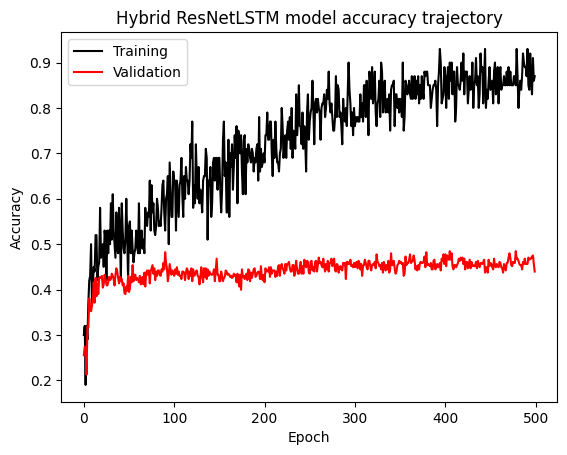

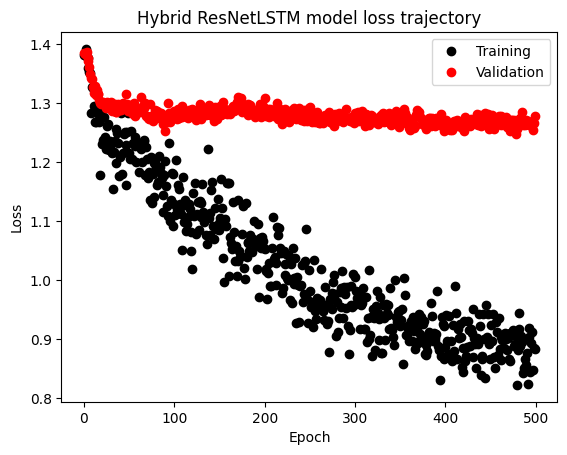

In [ ]:
# Change arrays and titles between models
plt.plot(np.arange(num_epochs),train_history_1,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_1,label='Validation',color='r')
plt.title('Hybrid ResNetLSTM model accuracy trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_1,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_1,'o',label='Validation',color='r')
plt.title('Hybrid ResNetLSTM model loss trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 2: Training and validating on Preprocessed Data

In [12]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset, may need to reload data at top
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [13]:
#Build the model
model2 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model2)
total_params = sum(p.numel() for p in model2.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_2, val_history_2 = np.array([]), np.array([])
train_loss_hist_2, val_loss_hist_2 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = "/content/drive/MyDrive/C147_Final_Project/best_model_params_v3"

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model2_params.pt')
    torch.save(model2.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model2.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model2(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model2.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model2(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_2 = np.append(train_history_2, train_acc.item())
        val_history_2 = np.append(val_history_2, val_acc.item())
        train_loss_hist_2 = np.append(train_loss_hist_2, loss.item())
        val_loss_hist_2 = np.append(val_loss_hist_2, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model2.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-9-6de06ec423be>:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:09<1:22:36,  9.93s/it]

Epoch 1 Finished!!!
Train acc: 0.320, Val acc: 0.258
Train loss: 1.372, Val loss: 1.380


  0%|          | 2/500 [00:12<48:06,  5.80s/it]  

Epoch 2 Finished!!!
Train acc: 0.380, Val acc: 0.392
Train loss: 1.322, Val loss: 1.333


  1%|          | 3/500 [00:15<37:02,  4.47s/it]

Epoch 3 Finished!!!
Train acc: 0.390, Val acc: 0.409
Train loss: 1.336, Val loss: 1.308


  1%|          | 4/500 [00:18<31:51,  3.85s/it]

Epoch 4 Finished!!!
Train acc: 0.470, Val acc: 0.430
Train loss: 1.283, Val loss: 1.293


  1%|          | 5/500 [00:21<28:58,  3.51s/it]

Epoch 5 Finished!!!
Train acc: 0.460, Val acc: 0.437
Train loss: 1.273, Val loss: 1.271


  1%|          | 6/500 [00:24<27:16,  3.31s/it]

Epoch 6 Finished!!!
Train acc: 0.580, Val acc: 0.442
Train loss: 1.175, Val loss: 1.278


  1%|▏         | 7/500 [00:27<26:11,  3.19s/it]

Epoch 7 Finished!!!
Train acc: 0.480, Val acc: 0.444
Train loss: 1.263, Val loss: 1.275


  2%|▏         | 8/500 [00:30<25:25,  3.10s/it]

Epoch 8 Finished!!!
Train acc: 0.540, Val acc: 0.409
Train loss: 1.202, Val loss: 1.292


  2%|▏         | 9/500 [00:33<24:59,  3.05s/it]

Epoch 9 Finished!!!
Train acc: 0.470, Val acc: 0.456
Train loss: 1.255, Val loss: 1.270


  2%|▏         | 10/500 [00:36<24:38,  3.02s/it]

Epoch 10 Finished!!!
Train acc: 0.510, Val acc: 0.447
Train loss: 1.203, Val loss: 1.261


  2%|▏         | 11/500 [00:39<24:25,  3.00s/it]

Epoch 11 Finished!!!
Train acc: 0.460, Val acc: 0.456
Train loss: 1.255, Val loss: 1.263


  2%|▏         | 12/500 [00:42<24:16,  2.98s/it]

Epoch 12 Finished!!!
Train acc: 0.560, Val acc: 0.435
Train loss: 1.174, Val loss: 1.267


  3%|▎         | 13/500 [00:45<24:10,  2.98s/it]

Epoch 13 Finished!!!
Train acc: 0.500, Val acc: 0.437
Train loss: 1.208, Val loss: 1.276


  3%|▎         | 14/500 [00:48<24:06,  2.98s/it]

Epoch 14 Finished!!!
Train acc: 0.500, Val acc: 0.414
Train loss: 1.215, Val loss: 1.283


  3%|▎         | 15/500 [00:51<24:04,  2.98s/it]

Epoch 15 Finished!!!
Train acc: 0.410, Val acc: 0.430
Train loss: 1.278, Val loss: 1.262


  3%|▎         | 16/500 [00:54<24:03,  2.98s/it]

Epoch 16 Finished!!!
Train acc: 0.550, Val acc: 0.456
Train loss: 1.185, Val loss: 1.267


  3%|▎         | 17/500 [00:57<24:03,  2.99s/it]

Epoch 17 Finished!!!
Train acc: 0.500, Val acc: 0.435
Train loss: 1.216, Val loss: 1.272


  4%|▎         | 18/500 [01:00<24:03,  3.00s/it]

Epoch 18 Finished!!!
Train acc: 0.500, Val acc: 0.442
Train loss: 1.233, Val loss: 1.266


  4%|▍         | 19/500 [01:03<24:08,  3.01s/it]

Epoch 19 Finished!!!
Train acc: 0.570, Val acc: 0.461
Train loss: 1.188, Val loss: 1.268


  4%|▍         | 20/500 [01:06<24:10,  3.02s/it]

Epoch 20 Finished!!!
Train acc: 0.600, Val acc: 0.466
Train loss: 1.148, Val loss: 1.265


  4%|▍         | 21/500 [01:09<24:09,  3.03s/it]

Epoch 21 Finished!!!
Train acc: 0.640, Val acc: 0.463
Train loss: 1.132, Val loss: 1.262


  4%|▍         | 22/500 [01:12<24:10,  3.03s/it]

Epoch 22 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.186, Val loss: 1.269


  5%|▍         | 23/500 [01:15<24:11,  3.04s/it]

Epoch 23 Finished!!!
Train acc: 0.500, Val acc: 0.466
Train loss: 1.227, Val loss: 1.258


  5%|▍         | 24/500 [01:18<24:15,  3.06s/it]

Epoch 24 Finished!!!
Train acc: 0.590, Val acc: 0.473
Train loss: 1.166, Val loss: 1.254


  5%|▌         | 25/500 [01:21<24:14,  3.06s/it]

Epoch 25 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.183, Val loss: 1.266


  5%|▌         | 26/500 [01:24<24:15,  3.07s/it]

Epoch 26 Finished!!!
Train acc: 0.690, Val acc: 0.437
Train loss: 1.101, Val loss: 1.274


  5%|▌         | 27/500 [01:27<24:21,  3.09s/it]

Epoch 27 Finished!!!
Train acc: 0.630, Val acc: 0.494
Train loss: 1.149, Val loss: 1.245


  6%|▌         | 28/500 [01:30<24:22,  3.10s/it]

Epoch 28 Finished!!!
Train acc: 0.590, Val acc: 0.456
Train loss: 1.139, Val loss: 1.261


  6%|▌         | 29/500 [01:33<24:23,  3.11s/it]

Epoch 29 Finished!!!
Train acc: 0.550, Val acc: 0.475
Train loss: 1.178, Val loss: 1.254


  6%|▌         | 30/500 [01:37<24:23,  3.11s/it]

Epoch 30 Finished!!!
Train acc: 0.550, Val acc: 0.449
Train loss: 1.175, Val loss: 1.268


  6%|▌         | 31/500 [01:40<24:25,  3.12s/it]

Epoch 31 Finished!!!
Train acc: 0.650, Val acc: 0.459
Train loss: 1.121, Val loss: 1.260


  6%|▋         | 32/500 [01:43<24:25,  3.13s/it]

Epoch 32 Finished!!!
Train acc: 0.590, Val acc: 0.478
Train loss: 1.167, Val loss: 1.254


  7%|▋         | 33/500 [01:46<24:21,  3.13s/it]

Epoch 33 Finished!!!
Train acc: 0.560, Val acc: 0.463
Train loss: 1.169, Val loss: 1.249


  7%|▋         | 34/500 [01:49<24:17,  3.13s/it]

Epoch 34 Finished!!!
Train acc: 0.640, Val acc: 0.463
Train loss: 1.136, Val loss: 1.256


  7%|▋         | 35/500 [01:52<24:11,  3.12s/it]

Epoch 35 Finished!!!
Train acc: 0.580, Val acc: 0.468
Train loss: 1.174, Val loss: 1.258


  7%|▋         | 36/500 [01:55<24:05,  3.12s/it]

Epoch 36 Finished!!!
Train acc: 0.630, Val acc: 0.470
Train loss: 1.138, Val loss: 1.248


  7%|▋         | 37/500 [01:58<23:58,  3.11s/it]

Epoch 37 Finished!!!
Train acc: 0.610, Val acc: 0.449
Train loss: 1.148, Val loss: 1.261


  8%|▊         | 38/500 [02:01<23:53,  3.10s/it]

Epoch 38 Finished!!!
Train acc: 0.710, Val acc: 0.482
Train loss: 1.069, Val loss: 1.237


  8%|▊         | 39/500 [02:05<23:47,  3.10s/it]

Epoch 39 Finished!!!
Train acc: 0.660, Val acc: 0.447
Train loss: 1.118, Val loss: 1.268


  8%|▊         | 40/500 [02:08<23:41,  3.09s/it]

Epoch 40 Finished!!!
Train acc: 0.610, Val acc: 0.461
Train loss: 1.129, Val loss: 1.248


  8%|▊         | 41/500 [02:11<23:37,  3.09s/it]

Epoch 41 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.162, Val loss: 1.262


  8%|▊         | 42/500 [02:14<23:31,  3.08s/it]

Epoch 42 Finished!!!
Train acc: 0.700, Val acc: 0.461
Train loss: 1.078, Val loss: 1.252


  9%|▊         | 43/500 [02:17<23:26,  3.08s/it]

Epoch 43 Finished!!!
Train acc: 0.640, Val acc: 0.463
Train loss: 1.118, Val loss: 1.257


  9%|▉         | 44/500 [02:20<23:21,  3.07s/it]

Epoch 44 Finished!!!
Train acc: 0.650, Val acc: 0.463
Train loss: 1.093, Val loss: 1.250


  9%|▉         | 45/500 [02:23<23:17,  3.07s/it]

Epoch 45 Finished!!!
Train acc: 0.670, Val acc: 0.461
Train loss: 1.083, Val loss: 1.263


  9%|▉         | 46/500 [02:26<23:14,  3.07s/it]

Epoch 46 Finished!!!
Train acc: 0.740, Val acc: 0.485
Train loss: 1.022, Val loss: 1.244


  9%|▉         | 47/500 [02:29<23:11,  3.07s/it]

Epoch 47 Finished!!!
Train acc: 0.680, Val acc: 0.475
Train loss: 1.094, Val loss: 1.247


 10%|▉         | 48/500 [02:32<23:10,  3.08s/it]

Epoch 48 Finished!!!
Train acc: 0.680, Val acc: 0.496
Train loss: 1.066, Val loss: 1.239


 10%|▉         | 49/500 [02:35<23:05,  3.07s/it]

Epoch 49 Finished!!!
Train acc: 0.570, Val acc: 0.470
Train loss: 1.136, Val loss: 1.259


 10%|█         | 50/500 [02:38<23:02,  3.07s/it]

Epoch 50 Finished!!!
Train acc: 0.750, Val acc: 0.456
Train loss: 1.016, Val loss: 1.258


 10%|█         | 51/500 [02:41<23:00,  3.07s/it]

Epoch 51 Finished!!!
Train acc: 0.710, Val acc: 0.482
Train loss: 1.063, Val loss: 1.241


 10%|█         | 52/500 [02:45<22:58,  3.08s/it]

Epoch 52 Finished!!!
Train acc: 0.660, Val acc: 0.475
Train loss: 1.104, Val loss: 1.256


 11%|█         | 53/500 [02:48<22:58,  3.08s/it]

Epoch 53 Finished!!!
Train acc: 0.620, Val acc: 0.433
Train loss: 1.095, Val loss: 1.273


 11%|█         | 54/500 [02:51<22:56,  3.09s/it]

Epoch 54 Finished!!!
Train acc: 0.730, Val acc: 0.475
Train loss: 1.036, Val loss: 1.247


 11%|█         | 55/500 [02:54<22:55,  3.09s/it]

Epoch 55 Finished!!!
Train acc: 0.720, Val acc: 0.461
Train loss: 1.029, Val loss: 1.250


 11%|█         | 56/500 [02:57<22:57,  3.10s/it]

Epoch 56 Finished!!!
Train acc: 0.680, Val acc: 0.508
Train loss: 1.069, Val loss: 1.226


 11%|█▏        | 57/500 [03:00<22:54,  3.10s/it]

Epoch 57 Finished!!!
Train acc: 0.790, Val acc: 0.501
Train loss: 0.986, Val loss: 1.232


 12%|█▏        | 58/500 [03:03<22:52,  3.10s/it]

Epoch 58 Finished!!!
Train acc: 0.730, Val acc: 0.478
Train loss: 1.033, Val loss: 1.252


 12%|█▏        | 59/500 [03:06<22:48,  3.10s/it]

Epoch 59 Finished!!!
Train acc: 0.770, Val acc: 0.489
Train loss: 0.987, Val loss: 1.235


 12%|█▏        | 60/500 [03:09<22:45,  3.10s/it]

Epoch 60 Finished!!!
Train acc: 0.720, Val acc: 0.468
Train loss: 1.049, Val loss: 1.245


 12%|█▏        | 61/500 [03:12<22:42,  3.10s/it]

Epoch 61 Finished!!!
Train acc: 0.760, Val acc: 0.489
Train loss: 0.992, Val loss: 1.236


 12%|█▏        | 62/500 [03:16<22:38,  3.10s/it]

Epoch 62 Finished!!!
Train acc: 0.720, Val acc: 0.492
Train loss: 1.042, Val loss: 1.233


 13%|█▎        | 63/500 [03:19<22:34,  3.10s/it]

Epoch 63 Finished!!!
Train acc: 0.800, Val acc: 0.496
Train loss: 0.948, Val loss: 1.246


 13%|█▎        | 64/500 [03:22<22:29,  3.10s/it]

Epoch 64 Finished!!!
Train acc: 0.720, Val acc: 0.473
Train loss: 1.012, Val loss: 1.247


 13%|█▎        | 65/500 [03:25<22:26,  3.10s/it]

Epoch 65 Finished!!!
Train acc: 0.670, Val acc: 0.475
Train loss: 1.085, Val loss: 1.252


 13%|█▎        | 66/500 [03:28<22:22,  3.09s/it]

Epoch 66 Finished!!!
Train acc: 0.790, Val acc: 0.489
Train loss: 0.983, Val loss: 1.241


 13%|█▎        | 67/500 [03:31<22:20,  3.10s/it]

Epoch 67 Finished!!!
Train acc: 0.720, Val acc: 0.515
Train loss: 1.053, Val loss: 1.220


 14%|█▎        | 68/500 [03:34<22:15,  3.09s/it]

Epoch 68 Finished!!!
Train acc: 0.740, Val acc: 0.494
Train loss: 1.001, Val loss: 1.234


 14%|█▍        | 69/500 [03:37<22:11,  3.09s/it]

Epoch 69 Finished!!!
Train acc: 0.780, Val acc: 0.487
Train loss: 0.965, Val loss: 1.249


 14%|█▍        | 70/500 [03:40<22:08,  3.09s/it]

Epoch 70 Finished!!!
Train acc: 0.810, Val acc: 0.487
Train loss: 0.957, Val loss: 1.241


 14%|█▍        | 71/500 [03:43<22:05,  3.09s/it]

Epoch 71 Finished!!!
Train acc: 0.800, Val acc: 0.473
Train loss: 0.949, Val loss: 1.253


 14%|█▍        | 72/500 [03:46<22:01,  3.09s/it]

Epoch 72 Finished!!!
Train acc: 0.730, Val acc: 0.480
Train loss: 1.015, Val loss: 1.238


 15%|█▍        | 73/500 [03:50<21:58,  3.09s/it]

Epoch 73 Finished!!!
Train acc: 0.710, Val acc: 0.492
Train loss: 1.036, Val loss: 1.242


 15%|█▍        | 74/500 [03:53<21:56,  3.09s/it]

Epoch 74 Finished!!!
Train acc: 0.830, Val acc: 0.470
Train loss: 0.946, Val loss: 1.250


 15%|█▌        | 75/500 [03:56<21:53,  3.09s/it]

Epoch 75 Finished!!!
Train acc: 0.820, Val acc: 0.492
Train loss: 0.942, Val loss: 1.239


 15%|█▌        | 76/500 [03:59<21:50,  3.09s/it]

Epoch 76 Finished!!!
Train acc: 0.750, Val acc: 0.504
Train loss: 0.999, Val loss: 1.232


 15%|█▌        | 77/500 [04:02<21:48,  3.09s/it]

Epoch 77 Finished!!!
Train acc: 0.780, Val acc: 0.489
Train loss: 0.971, Val loss: 1.238


 16%|█▌        | 78/500 [04:05<21:46,  3.10s/it]

Epoch 78 Finished!!!
Train acc: 0.770, Val acc: 0.466
Train loss: 1.001, Val loss: 1.249


 16%|█▌        | 79/500 [04:08<21:43,  3.10s/it]

Epoch 79 Finished!!!
Train acc: 0.710, Val acc: 0.470
Train loss: 1.038, Val loss: 1.244


 16%|█▌        | 80/500 [04:11<21:40,  3.10s/it]

Epoch 80 Finished!!!
Train acc: 0.770, Val acc: 0.494
Train loss: 0.987, Val loss: 1.236


 16%|█▌        | 81/500 [04:14<21:38,  3.10s/it]

Epoch 81 Finished!!!
Train acc: 0.790, Val acc: 0.506
Train loss: 0.957, Val loss: 1.234


 16%|█▋        | 82/500 [04:17<21:35,  3.10s/it]

Epoch 82 Finished!!!
Train acc: 0.840, Val acc: 0.499
Train loss: 0.926, Val loss: 1.228


 17%|█▋        | 83/500 [04:21<21:32,  3.10s/it]

Epoch 83 Finished!!!
Train acc: 0.820, Val acc: 0.482
Train loss: 0.930, Val loss: 1.241


 17%|█▋        | 84/500 [04:24<21:29,  3.10s/it]

Epoch 84 Finished!!!
Train acc: 0.740, Val acc: 0.487
Train loss: 1.003, Val loss: 1.237


 17%|█▋        | 85/500 [04:27<21:26,  3.10s/it]

Epoch 85 Finished!!!
Train acc: 0.880, Val acc: 0.506
Train loss: 0.894, Val loss: 1.227


 17%|█▋        | 86/500 [04:30<21:24,  3.10s/it]

Epoch 86 Finished!!!
Train acc: 0.800, Val acc: 0.496
Train loss: 0.951, Val loss: 1.234


 17%|█▋        | 87/500 [04:33<21:21,  3.10s/it]

Epoch 87 Finished!!!
Train acc: 0.760, Val acc: 0.489
Train loss: 0.987, Val loss: 1.242


 18%|█▊        | 88/500 [04:36<21:18,  3.10s/it]

Epoch 88 Finished!!!
Train acc: 0.840, Val acc: 0.513
Train loss: 0.937, Val loss: 1.226


 18%|█▊        | 89/500 [04:39<21:15,  3.10s/it]

Epoch 89 Finished!!!
Train acc: 0.900, Val acc: 0.496
Train loss: 0.852, Val loss: 1.233


 18%|█▊        | 90/500 [04:42<21:12,  3.10s/it]

Epoch 90 Finished!!!
Train acc: 0.850, Val acc: 0.485
Train loss: 0.928, Val loss: 1.236


 18%|█▊        | 91/500 [04:45<21:08,  3.10s/it]

Epoch 91 Finished!!!
Train acc: 0.860, Val acc: 0.504
Train loss: 0.875, Val loss: 1.221


 18%|█▊        | 92/500 [04:48<21:05,  3.10s/it]

Epoch 92 Finished!!!
Train acc: 0.830, Val acc: 0.499
Train loss: 0.919, Val loss: 1.226


 19%|█▊        | 93/500 [04:52<21:01,  3.10s/it]

Epoch 93 Finished!!!
Train acc: 0.850, Val acc: 0.515
Train loss: 0.892, Val loss: 1.220


 19%|█▉        | 94/500 [04:55<20:59,  3.10s/it]

Epoch 94 Finished!!!
Train acc: 0.790, Val acc: 0.496
Train loss: 0.968, Val loss: 1.230


 19%|█▉        | 95/500 [04:58<20:57,  3.11s/it]

Epoch 95 Finished!!!
Train acc: 0.890, Val acc: 0.522
Train loss: 0.878, Val loss: 1.222


 19%|█▉        | 96/500 [05:01<20:51,  3.10s/it]

Epoch 96 Finished!!!
Train acc: 0.850, Val acc: 0.504
Train loss: 0.875, Val loss: 1.228


 19%|█▉        | 97/500 [05:04<20:46,  3.09s/it]

Epoch 97 Finished!!!
Train acc: 0.770, Val acc: 0.513
Train loss: 0.979, Val loss: 1.214


 20%|█▉        | 98/500 [05:07<20:43,  3.09s/it]

Epoch 98 Finished!!!
Train acc: 0.870, Val acc: 0.494
Train loss: 0.893, Val loss: 1.227


 20%|█▉        | 99/500 [05:10<20:39,  3.09s/it]

Epoch 99 Finished!!!
Train acc: 0.780, Val acc: 0.508
Train loss: 0.962, Val loss: 1.228


 20%|██        | 100/500 [05:13<20:36,  3.09s/it]

Epoch 100 Finished!!!
Train acc: 0.820, Val acc: 0.520
Train loss: 0.929, Val loss: 1.215


 20%|██        | 101/500 [05:16<20:32,  3.09s/it]

Epoch 101 Finished!!!
Train acc: 0.850, Val acc: 0.515
Train loss: 0.893, Val loss: 1.219


 20%|██        | 102/500 [05:19<20:29,  3.09s/it]

Epoch 102 Finished!!!
Train acc: 0.870, Val acc: 0.499
Train loss: 0.901, Val loss: 1.229


 21%|██        | 103/500 [05:22<20:26,  3.09s/it]

Epoch 103 Finished!!!
Train acc: 0.870, Val acc: 0.496
Train loss: 0.880, Val loss: 1.227


 21%|██        | 104/500 [05:26<20:24,  3.09s/it]

Epoch 104 Finished!!!
Train acc: 0.790, Val acc: 0.492
Train loss: 0.977, Val loss: 1.225


 21%|██        | 105/500 [05:29<20:21,  3.09s/it]

Epoch 105 Finished!!!
Train acc: 0.870, Val acc: 0.494
Train loss: 0.884, Val loss: 1.229


 21%|██        | 106/500 [05:32<20:18,  3.09s/it]

Epoch 106 Finished!!!
Train acc: 0.900, Val acc: 0.515
Train loss: 0.863, Val loss: 1.219


 21%|██▏       | 107/500 [05:35<20:15,  3.09s/it]

Epoch 107 Finished!!!
Train acc: 0.880, Val acc: 0.515
Train loss: 0.867, Val loss: 1.218


 22%|██▏       | 108/500 [05:38<20:13,  3.09s/it]

Epoch 108 Finished!!!
Train acc: 0.870, Val acc: 0.504
Train loss: 0.894, Val loss: 1.225


 22%|██▏       | 109/500 [05:41<20:10,  3.10s/it]

Epoch 109 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.854, Val loss: 1.206


 22%|██▏       | 110/500 [05:44<20:08,  3.10s/it]

Epoch 110 Finished!!!
Train acc: 0.850, Val acc: 0.501
Train loss: 0.892, Val loss: 1.225


 22%|██▏       | 111/500 [05:47<20:06,  3.10s/it]

Epoch 111 Finished!!!
Train acc: 0.840, Val acc: 0.515
Train loss: 0.893, Val loss: 1.221


 22%|██▏       | 112/500 [05:50<20:02,  3.10s/it]

Epoch 112 Finished!!!
Train acc: 0.890, Val acc: 0.518
Train loss: 0.859, Val loss: 1.220


 23%|██▎       | 113/500 [05:53<19:59,  3.10s/it]

Epoch 113 Finished!!!
Train acc: 0.870, Val acc: 0.492
Train loss: 0.875, Val loss: 1.226


 23%|██▎       | 114/500 [05:57<19:56,  3.10s/it]

Epoch 114 Finished!!!
Train acc: 0.900, Val acc: 0.494
Train loss: 0.841, Val loss: 1.228


 23%|██▎       | 115/500 [06:00<19:53,  3.10s/it]

Epoch 115 Finished!!!
Train acc: 0.870, Val acc: 0.513
Train loss: 0.883, Val loss: 1.218


 23%|██▎       | 116/500 [06:03<19:51,  3.10s/it]

Epoch 116 Finished!!!
Train acc: 0.840, Val acc: 0.518
Train loss: 0.918, Val loss: 1.218


 23%|██▎       | 117/500 [06:06<19:48,  3.10s/it]

Epoch 117 Finished!!!
Train acc: 0.860, Val acc: 0.513
Train loss: 0.887, Val loss: 1.218


 24%|██▎       | 118/500 [06:09<19:45,  3.10s/it]

Epoch 118 Finished!!!
Train acc: 0.900, Val acc: 0.504
Train loss: 0.856, Val loss: 1.223


 24%|██▍       | 119/500 [06:12<19:42,  3.10s/it]

Epoch 119 Finished!!!
Train acc: 0.900, Val acc: 0.511
Train loss: 0.858, Val loss: 1.220


 24%|██▍       | 120/500 [06:15<19:38,  3.10s/it]

Epoch 120 Finished!!!
Train acc: 0.850, Val acc: 0.499
Train loss: 0.907, Val loss: 1.223


 24%|██▍       | 121/500 [06:18<19:35,  3.10s/it]

Epoch 121 Finished!!!
Train acc: 0.860, Val acc: 0.501
Train loss: 0.891, Val loss: 1.229


 24%|██▍       | 122/500 [06:21<19:31,  3.10s/it]

Epoch 122 Finished!!!
Train acc: 0.860, Val acc: 0.515
Train loss: 0.891, Val loss: 1.216


 25%|██▍       | 123/500 [06:24<19:30,  3.10s/it]

Epoch 123 Finished!!!
Train acc: 0.860, Val acc: 0.527
Train loss: 0.902, Val loss: 1.208


 25%|██▍       | 124/500 [06:28<19:24,  3.10s/it]

Epoch 124 Finished!!!
Train acc: 0.900, Val acc: 0.504
Train loss: 0.852, Val loss: 1.225


 25%|██▌       | 125/500 [06:31<19:20,  3.10s/it]

Epoch 125 Finished!!!
Train acc: 0.880, Val acc: 0.504
Train loss: 0.871, Val loss: 1.221


 25%|██▌       | 126/500 [06:34<19:17,  3.10s/it]

Epoch 126 Finished!!!
Train acc: 0.900, Val acc: 0.527
Train loss: 0.856, Val loss: 1.218


 25%|██▌       | 127/500 [06:37<19:14,  3.10s/it]

Epoch 127 Finished!!!
Train acc: 0.840, Val acc: 0.501
Train loss: 0.922, Val loss: 1.221


 26%|██▌       | 128/500 [06:40<19:10,  3.09s/it]

Epoch 128 Finished!!!
Train acc: 0.920, Val acc: 0.501
Train loss: 0.835, Val loss: 1.224


 26%|██▌       | 129/500 [06:43<19:07,  3.09s/it]

Epoch 129 Finished!!!
Train acc: 0.900, Val acc: 0.525
Train loss: 0.852, Val loss: 1.218


 26%|██▌       | 130/500 [06:46<19:04,  3.09s/it]

Epoch 130 Finished!!!
Train acc: 0.940, Val acc: 0.508
Train loss: 0.811, Val loss: 1.223


 26%|██▌       | 131/500 [06:49<19:01,  3.09s/it]

Epoch 131 Finished!!!
Train acc: 0.900, Val acc: 0.504
Train loss: 0.854, Val loss: 1.220


 26%|██▋       | 132/500 [06:52<18:58,  3.09s/it]

Epoch 132 Finished!!!
Train acc: 0.890, Val acc: 0.499
Train loss: 0.868, Val loss: 1.223


 27%|██▋       | 133/500 [06:55<18:54,  3.09s/it]

Epoch 133 Finished!!!
Train acc: 0.860, Val acc: 0.511
Train loss: 0.882, Val loss: 1.217


 27%|██▋       | 134/500 [06:58<18:50,  3.09s/it]

Epoch 134 Finished!!!
Train acc: 0.910, Val acc: 0.506
Train loss: 0.845, Val loss: 1.226


 27%|██▋       | 135/500 [07:02<18:47,  3.09s/it]

Epoch 135 Finished!!!
Train acc: 0.930, Val acc: 0.518
Train loss: 0.837, Val loss: 1.209


 27%|██▋       | 136/500 [07:05<18:43,  3.09s/it]

Epoch 136 Finished!!!
Train acc: 0.870, Val acc: 0.489
Train loss: 0.889, Val loss: 1.236


 27%|██▋       | 137/500 [07:08<18:41,  3.09s/it]

Epoch 137 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.815, Val loss: 1.223


 28%|██▊       | 138/500 [07:11<18:37,  3.09s/it]

Epoch 138 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.821, Val loss: 1.222


 28%|██▊       | 139/500 [07:14<18:35,  3.09s/it]

Epoch 139 Finished!!!
Train acc: 0.910, Val acc: 0.511
Train loss: 0.838, Val loss: 1.211


 28%|██▊       | 140/500 [07:17<18:31,  3.09s/it]

Epoch 140 Finished!!!
Train acc: 0.930, Val acc: 0.485
Train loss: 0.818, Val loss: 1.231


 28%|██▊       | 141/500 [07:20<18:28,  3.09s/it]

Epoch 141 Finished!!!
Train acc: 0.910, Val acc: 0.494
Train loss: 0.837, Val loss: 1.231


 28%|██▊       | 142/500 [07:23<18:25,  3.09s/it]

Epoch 142 Finished!!!
Train acc: 0.890, Val acc: 0.513
Train loss: 0.862, Val loss: 1.214


 29%|██▊       | 143/500 [07:26<18:23,  3.09s/it]

Epoch 143 Finished!!!
Train acc: 0.880, Val acc: 0.504
Train loss: 0.872, Val loss: 1.226


 29%|██▉       | 144/500 [07:29<18:20,  3.09s/it]

Epoch 144 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.856, Val loss: 1.222


 29%|██▉       | 145/500 [07:32<18:17,  3.09s/it]

Epoch 145 Finished!!!
Train acc: 0.880, Val acc: 0.522
Train loss: 0.865, Val loss: 1.217


 29%|██▉       | 146/500 [07:36<18:14,  3.09s/it]

Epoch 146 Finished!!!
Train acc: 0.860, Val acc: 0.489
Train loss: 0.883, Val loss: 1.237


 29%|██▉       | 147/500 [07:39<18:11,  3.09s/it]

Epoch 147 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.837, Val loss: 1.208


 30%|██▉       | 148/500 [07:42<18:09,  3.09s/it]

Epoch 148 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.845, Val loss: 1.215


 30%|██▉       | 149/500 [07:45<18:06,  3.09s/it]

Epoch 149 Finished!!!
Train acc: 0.910, Val acc: 0.513
Train loss: 0.847, Val loss: 1.219


 30%|███       | 150/500 [07:48<18:03,  3.09s/it]

Epoch 150 Finished!!!
Train acc: 0.900, Val acc: 0.520
Train loss: 0.852, Val loss: 1.213


 30%|███       | 151/500 [07:51<18:00,  3.10s/it]

Epoch 151 Finished!!!
Train acc: 0.890, Val acc: 0.522
Train loss: 0.860, Val loss: 1.211


 30%|███       | 152/500 [07:54<17:57,  3.10s/it]

Epoch 152 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.817, Val loss: 1.217


 31%|███       | 153/500 [07:57<17:53,  3.09s/it]

Epoch 153 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.832, Val loss: 1.215


 31%|███       | 154/500 [08:00<17:51,  3.10s/it]

Epoch 154 Finished!!!
Train acc: 0.920, Val acc: 0.504
Train loss: 0.835, Val loss: 1.222


 31%|███       | 155/500 [08:03<17:48,  3.10s/it]

Epoch 155 Finished!!!
Train acc: 0.890, Val acc: 0.511
Train loss: 0.851, Val loss: 1.216


 31%|███       | 156/500 [08:06<17:45,  3.10s/it]

Epoch 156 Finished!!!
Train acc: 0.920, Val acc: 0.515
Train loss: 0.831, Val loss: 1.217


 31%|███▏      | 157/500 [08:10<17:42,  3.10s/it]

Epoch 157 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.838, Val loss: 1.213


 32%|███▏      | 158/500 [08:13<17:39,  3.10s/it]

Epoch 158 Finished!!!
Train acc: 0.900, Val acc: 0.506
Train loss: 0.845, Val loss: 1.221


 32%|███▏      | 159/500 [08:16<17:36,  3.10s/it]

Epoch 159 Finished!!!
Train acc: 0.880, Val acc: 0.515
Train loss: 0.866, Val loss: 1.221


 32%|███▏      | 160/500 [08:19<17:33,  3.10s/it]

Epoch 160 Finished!!!
Train acc: 0.880, Val acc: 0.525
Train loss: 0.872, Val loss: 1.208


 32%|███▏      | 161/500 [08:22<17:30,  3.10s/it]

Epoch 161 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.820, Val loss: 1.228


 32%|███▏      | 162/500 [08:25<17:27,  3.10s/it]

Epoch 162 Finished!!!
Train acc: 0.910, Val acc: 0.506
Train loss: 0.842, Val loss: 1.214


 33%|███▎      | 163/500 [08:28<17:26,  3.11s/it]

Epoch 163 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.797, Val loss: 1.200


 33%|███▎      | 164/500 [08:31<17:23,  3.11s/it]

Epoch 164 Finished!!!
Train acc: 0.930, Val acc: 0.494
Train loss: 0.819, Val loss: 1.226


 33%|███▎      | 165/500 [08:34<17:19,  3.10s/it]

Epoch 165 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.816, Val loss: 1.213


 33%|███▎      | 166/500 [08:38<17:16,  3.10s/it]

Epoch 166 Finished!!!
Train acc: 0.870, Val acc: 0.504
Train loss: 0.874, Val loss: 1.229


 33%|███▎      | 167/500 [08:41<17:13,  3.10s/it]

Epoch 167 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.816, Val loss: 1.222


 34%|███▎      | 168/500 [08:44<17:10,  3.10s/it]

Epoch 168 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.836, Val loss: 1.217


 34%|███▍      | 169/500 [08:47<17:06,  3.10s/it]

Epoch 169 Finished!!!
Train acc: 0.920, Val acc: 0.496
Train loss: 0.829, Val loss: 1.225


 34%|███▍      | 170/500 [08:50<17:03,  3.10s/it]

Epoch 170 Finished!!!
Train acc: 0.880, Val acc: 0.525
Train loss: 0.866, Val loss: 1.215


 34%|███▍      | 171/500 [08:53<17:00,  3.10s/it]

Epoch 171 Finished!!!
Train acc: 0.910, Val acc: 0.513
Train loss: 0.846, Val loss: 1.218


 34%|███▍      | 172/500 [08:56<16:57,  3.10s/it]

Epoch 172 Finished!!!
Train acc: 0.910, Val acc: 0.504
Train loss: 0.832, Val loss: 1.229


 35%|███▍      | 173/500 [08:59<16:54,  3.10s/it]

Epoch 173 Finished!!!
Train acc: 0.950, Val acc: 0.511
Train loss: 0.796, Val loss: 1.220


 35%|███▍      | 174/500 [09:02<16:51,  3.10s/it]

Epoch 174 Finished!!!
Train acc: 0.950, Val acc: 0.501
Train loss: 0.805, Val loss: 1.225


 35%|███▌      | 175/500 [09:05<16:48,  3.10s/it]

Epoch 175 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.797, Val loss: 1.222


 35%|███▌      | 176/500 [09:09<16:45,  3.10s/it]

Epoch 176 Finished!!!
Train acc: 0.860, Val acc: 0.511
Train loss: 0.891, Val loss: 1.224


 35%|███▌      | 177/500 [09:12<16:42,  3.10s/it]

Epoch 177 Finished!!!
Train acc: 0.900, Val acc: 0.520
Train loss: 0.854, Val loss: 1.216


 36%|███▌      | 178/500 [09:15<16:38,  3.10s/it]

Epoch 178 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.825, Val loss: 1.224


 36%|███▌      | 179/500 [09:18<16:35,  3.10s/it]

Epoch 179 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.833, Val loss: 1.226


 36%|███▌      | 180/500 [09:21<16:32,  3.10s/it]

Epoch 180 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.809, Val loss: 1.221


 36%|███▌      | 181/500 [09:24<16:29,  3.10s/it]

Epoch 181 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.814, Val loss: 1.215


 36%|███▋      | 182/500 [09:27<16:25,  3.10s/it]

Epoch 182 Finished!!!
Train acc: 0.930, Val acc: 0.518
Train loss: 0.823, Val loss: 1.215


 37%|███▋      | 183/500 [09:30<16:22,  3.10s/it]

Epoch 183 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.831, Val loss: 1.213


 37%|███▋      | 184/500 [09:33<16:19,  3.10s/it]

Epoch 184 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.817, Val loss: 1.205


 37%|███▋      | 185/500 [09:36<16:16,  3.10s/it]

Epoch 185 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.851, Val loss: 1.200


 37%|███▋      | 186/500 [09:40<16:13,  3.10s/it]

Epoch 186 Finished!!!
Train acc: 0.970, Val acc: 0.525
Train loss: 0.786, Val loss: 1.207


 37%|███▋      | 187/500 [09:43<16:10,  3.10s/it]

Epoch 187 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.815, Val loss: 1.212


 38%|███▊      | 188/500 [09:46<16:07,  3.10s/it]

Epoch 188 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.816, Val loss: 1.226


 38%|███▊      | 189/500 [09:49<16:04,  3.10s/it]

Epoch 189 Finished!!!
Train acc: 0.910, Val acc: 0.515
Train loss: 0.833, Val loss: 1.217


 38%|███▊      | 190/500 [09:52<16:01,  3.10s/it]

Epoch 190 Finished!!!
Train acc: 0.930, Val acc: 0.496
Train loss: 0.826, Val loss: 1.237


 38%|███▊      | 191/500 [09:55<15:58,  3.10s/it]

Epoch 191 Finished!!!
Train acc: 0.900, Val acc: 0.513
Train loss: 0.849, Val loss: 1.219


 38%|███▊      | 192/500 [09:58<15:55,  3.10s/it]

Epoch 192 Finished!!!
Train acc: 0.920, Val acc: 0.518
Train loss: 0.827, Val loss: 1.215


 39%|███▊      | 193/500 [10:01<15:52,  3.10s/it]

Epoch 193 Finished!!!
Train acc: 0.880, Val acc: 0.522
Train loss: 0.870, Val loss: 1.217


 39%|███▉      | 194/500 [10:04<15:49,  3.10s/it]

Epoch 194 Finished!!!
Train acc: 0.910, Val acc: 0.496
Train loss: 0.838, Val loss: 1.230


 39%|███▉      | 195/500 [10:07<15:46,  3.10s/it]

Epoch 195 Finished!!!
Train acc: 0.890, Val acc: 0.506
Train loss: 0.856, Val loss: 1.230


 39%|███▉      | 196/500 [10:11<15:43,  3.10s/it]

Epoch 196 Finished!!!
Train acc: 0.920, Val acc: 0.515
Train loss: 0.821, Val loss: 1.221


 39%|███▉      | 197/500 [10:14<15:40,  3.10s/it]

Epoch 197 Finished!!!
Train acc: 0.910, Val acc: 0.482
Train loss: 0.840, Val loss: 1.245


 40%|███▉      | 198/500 [10:17<15:36,  3.10s/it]

Epoch 198 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.820, Val loss: 1.214


 40%|███▉      | 199/500 [10:20<15:33,  3.10s/it]

Epoch 199 Finished!!!
Train acc: 0.920, Val acc: 0.513
Train loss: 0.832, Val loss: 1.215


 40%|████      | 200/500 [10:23<15:30,  3.10s/it]

Epoch 200 Finished!!!
Train acc: 0.920, Val acc: 0.532
Train loss: 0.830, Val loss: 1.202


 40%|████      | 201/500 [10:26<15:27,  3.10s/it]

Epoch 201 Finished!!!
Train acc: 0.920, Val acc: 0.518
Train loss: 0.829, Val loss: 1.214


 40%|████      | 202/500 [10:29<15:24,  3.10s/it]

Epoch 202 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.840, Val loss: 1.206


 41%|████      | 203/500 [10:32<15:21,  3.10s/it]

Epoch 203 Finished!!!
Train acc: 0.890, Val acc: 0.515
Train loss: 0.854, Val loss: 1.218


 41%|████      | 204/500 [10:35<15:17,  3.10s/it]

Epoch 204 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.804, Val loss: 1.188


 41%|████      | 205/500 [10:38<15:15,  3.10s/it]

Epoch 205 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.859, Val loss: 1.200


 41%|████      | 206/500 [10:42<15:11,  3.10s/it]

Epoch 206 Finished!!!
Train acc: 0.930, Val acc: 0.499
Train loss: 0.827, Val loss: 1.232


 41%|████▏     | 207/500 [10:45<15:08,  3.10s/it]

Epoch 207 Finished!!!
Train acc: 0.890, Val acc: 0.518
Train loss: 0.857, Val loss: 1.213


 42%|████▏     | 208/500 [10:48<15:05,  3.10s/it]

Epoch 208 Finished!!!
Train acc: 0.910, Val acc: 0.515
Train loss: 0.833, Val loss: 1.217


 42%|████▏     | 209/500 [10:51<15:02,  3.10s/it]

Epoch 209 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.799, Val loss: 1.235


 42%|████▏     | 210/500 [10:54<14:59,  3.10s/it]

Epoch 210 Finished!!!
Train acc: 0.910, Val acc: 0.511
Train loss: 0.839, Val loss: 1.219


 42%|████▏     | 211/500 [10:57<14:56,  3.10s/it]

Epoch 211 Finished!!!
Train acc: 0.900, Val acc: 0.501
Train loss: 0.852, Val loss: 1.227


 42%|████▏     | 212/500 [11:00<14:53,  3.10s/it]

Epoch 212 Finished!!!
Train acc: 0.910, Val acc: 0.504
Train loss: 0.836, Val loss: 1.225


 43%|████▎     | 213/500 [11:03<14:50,  3.10s/it]

Epoch 213 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.788, Val loss: 1.215


 43%|████▎     | 214/500 [11:06<14:47,  3.10s/it]

Epoch 214 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.816, Val loss: 1.210


 43%|████▎     | 215/500 [11:10<14:44,  3.10s/it]

Epoch 215 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.781, Val loss: 1.214


 43%|████▎     | 216/500 [11:13<14:41,  3.10s/it]

Epoch 216 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.808, Val loss: 1.210


 43%|████▎     | 217/500 [11:16<14:38,  3.10s/it]

Epoch 217 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.846, Val loss: 1.209


 44%|████▎     | 218/500 [11:19<14:35,  3.10s/it]

Epoch 218 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.819, Val loss: 1.227


 44%|████▍     | 219/500 [11:22<14:32,  3.10s/it]

Epoch 219 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.787, Val loss: 1.213


 44%|████▍     | 220/500 [11:25<14:29,  3.10s/it]

Epoch 220 Finished!!!
Train acc: 0.890, Val acc: 0.515
Train loss: 0.852, Val loss: 1.222


 44%|████▍     | 221/500 [11:28<14:26,  3.10s/it]

Epoch 221 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.823, Val loss: 1.201


 44%|████▍     | 222/500 [11:31<14:22,  3.10s/it]

Epoch 222 Finished!!!
Train acc: 0.930, Val acc: 0.501
Train loss: 0.818, Val loss: 1.221


 45%|████▍     | 223/500 [11:34<14:19,  3.10s/it]

Epoch 223 Finished!!!
Train acc: 0.880, Val acc: 0.511
Train loss: 0.873, Val loss: 1.212


 45%|████▍     | 224/500 [11:37<14:16,  3.10s/it]

Epoch 224 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.799, Val loss: 1.206


 45%|████▌     | 225/500 [11:41<14:13,  3.10s/it]

Epoch 225 Finished!!!
Train acc: 0.970, Val acc: 0.520
Train loss: 0.773, Val loss: 1.210


 45%|████▌     | 226/500 [11:44<14:10,  3.10s/it]

Epoch 226 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.830, Val loss: 1.212


 45%|████▌     | 227/500 [11:47<14:07,  3.10s/it]

Epoch 227 Finished!!!
Train acc: 0.960, Val acc: 0.520
Train loss: 0.796, Val loss: 1.216


 46%|████▌     | 228/500 [11:50<14:03,  3.10s/it]

Epoch 228 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.813, Val loss: 1.211


 46%|████▌     | 229/500 [11:53<14:00,  3.10s/it]

Epoch 229 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.817, Val loss: 1.207


 46%|████▌     | 230/500 [11:56<13:57,  3.10s/it]

Epoch 230 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.818, Val loss: 1.211


 46%|████▌     | 231/500 [11:59<13:54,  3.10s/it]

Epoch 231 Finished!!!
Train acc: 0.890, Val acc: 0.530
Train loss: 0.861, Val loss: 1.207


 46%|████▋     | 232/500 [12:02<13:51,  3.10s/it]

Epoch 232 Finished!!!
Train acc: 0.900, Val acc: 0.508
Train loss: 0.846, Val loss: 1.219


 47%|████▋     | 233/500 [12:05<13:48,  3.10s/it]

Epoch 233 Finished!!!
Train acc: 0.990, Val acc: 0.511
Train loss: 0.763, Val loss: 1.229


 47%|████▋     | 234/500 [12:08<13:44,  3.10s/it]

Epoch 234 Finished!!!
Train acc: 0.960, Val acc: 0.501
Train loss: 0.788, Val loss: 1.221


 47%|████▋     | 235/500 [12:12<13:41,  3.10s/it]

Epoch 235 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.807, Val loss: 1.211


 47%|████▋     | 236/500 [12:15<13:38,  3.10s/it]

Epoch 236 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.783, Val loss: 1.205


 47%|████▋     | 237/500 [12:18<13:35,  3.10s/it]

Epoch 237 Finished!!!
Train acc: 0.910, Val acc: 0.539
Train loss: 0.829, Val loss: 1.202


 48%|████▊     | 238/500 [12:21<13:32,  3.10s/it]

Epoch 238 Finished!!!
Train acc: 0.930, Val acc: 0.501
Train loss: 0.824, Val loss: 1.227


 48%|████▊     | 239/500 [12:24<13:28,  3.10s/it]

Epoch 239 Finished!!!
Train acc: 0.920, Val acc: 0.532
Train loss: 0.830, Val loss: 1.199


 48%|████▊     | 240/500 [12:27<13:25,  3.10s/it]

Epoch 240 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.797, Val loss: 1.213


 48%|████▊     | 241/500 [12:30<13:22,  3.10s/it]

Epoch 241 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.809, Val loss: 1.224


 48%|████▊     | 242/500 [12:33<13:19,  3.10s/it]

Epoch 242 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.812, Val loss: 1.209


 49%|████▊     | 243/500 [12:36<13:15,  3.10s/it]

Epoch 243 Finished!!!
Train acc: 0.920, Val acc: 0.504
Train loss: 0.838, Val loss: 1.220


 49%|████▉     | 244/500 [12:39<13:12,  3.10s/it]

Epoch 244 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.808, Val loss: 1.204


 49%|████▉     | 245/500 [12:43<13:09,  3.10s/it]

Epoch 245 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.824, Val loss: 1.212


 49%|████▉     | 246/500 [12:46<13:07,  3.10s/it]

Epoch 246 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.835, Val loss: 1.209


 49%|████▉     | 247/500 [12:49<13:04,  3.10s/it]

Epoch 247 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.837, Val loss: 1.207


 50%|████▉     | 248/500 [12:52<13:01,  3.10s/it]

Epoch 248 Finished!!!
Train acc: 0.980, Val acc: 0.530
Train loss: 0.772, Val loss: 1.204


 50%|████▉     | 249/500 [12:55<12:57,  3.10s/it]

Epoch 249 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.825, Val loss: 1.207


 50%|█████     | 250/500 [12:58<12:54,  3.10s/it]

Epoch 250 Finished!!!
Train acc: 0.920, Val acc: 0.504
Train loss: 0.828, Val loss: 1.227


 50%|█████     | 251/500 [13:01<12:51,  3.10s/it]

Epoch 251 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.832, Val loss: 1.215


 50%|█████     | 252/500 [13:04<12:47,  3.10s/it]

Epoch 252 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.834, Val loss: 1.210


 51%|█████     | 253/500 [13:07<12:44,  3.10s/it]

Epoch 253 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.815, Val loss: 1.215


 51%|█████     | 254/500 [13:10<12:42,  3.10s/it]

Epoch 254 Finished!!!
Train acc: 0.920, Val acc: 0.501
Train loss: 0.819, Val loss: 1.225


 51%|█████     | 255/500 [13:13<12:38,  3.10s/it]

Epoch 255 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.799, Val loss: 1.212


 51%|█████     | 256/500 [13:17<12:35,  3.10s/it]

Epoch 256 Finished!!!
Train acc: 0.900, Val acc: 0.508
Train loss: 0.854, Val loss: 1.221


 51%|█████▏    | 257/500 [13:20<12:32,  3.10s/it]

Epoch 257 Finished!!!
Train acc: 0.930, Val acc: 0.485
Train loss: 0.821, Val loss: 1.225


 52%|█████▏    | 258/500 [13:23<12:29,  3.10s/it]

Epoch 258 Finished!!!
Train acc: 0.890, Val acc: 0.511
Train loss: 0.862, Val loss: 1.225


 52%|█████▏    | 259/500 [13:26<12:26,  3.10s/it]

Epoch 259 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.810, Val loss: 1.217


 52%|█████▏    | 260/500 [13:29<12:22,  3.09s/it]

Epoch 260 Finished!!!
Train acc: 0.880, Val acc: 0.508
Train loss: 0.875, Val loss: 1.223


 52%|█████▏    | 261/500 [13:32<12:19,  3.10s/it]

Epoch 261 Finished!!!
Train acc: 0.890, Val acc: 0.508
Train loss: 0.852, Val loss: 1.218


 52%|█████▏    | 262/500 [13:35<12:17,  3.10s/it]

Epoch 262 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.809, Val loss: 1.202


 53%|█████▎    | 263/500 [13:38<12:14,  3.10s/it]

Epoch 263 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.792, Val loss: 1.195


 53%|█████▎    | 264/500 [13:41<12:11,  3.10s/it]

Epoch 264 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.789, Val loss: 1.206


 53%|█████▎    | 265/500 [13:44<12:07,  3.10s/it]

Epoch 265 Finished!!!
Train acc: 0.920, Val acc: 0.485
Train loss: 0.824, Val loss: 1.242


 53%|█████▎    | 266/500 [13:48<12:04,  3.10s/it]

Epoch 266 Finished!!!
Train acc: 0.920, Val acc: 0.506
Train loss: 0.821, Val loss: 1.216


 53%|█████▎    | 267/500 [13:51<12:02,  3.10s/it]

Epoch 267 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.808, Val loss: 1.211


 54%|█████▎    | 268/500 [13:54<11:58,  3.10s/it]

Epoch 268 Finished!!!
Train acc: 0.890, Val acc: 0.513
Train loss: 0.856, Val loss: 1.217


 54%|█████▍    | 269/500 [13:57<11:55,  3.10s/it]

Epoch 269 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.803, Val loss: 1.200


 54%|█████▍    | 270/500 [14:00<11:51,  3.09s/it]

Epoch 270 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.822, Val loss: 1.220


 54%|█████▍    | 271/500 [14:03<11:48,  3.10s/it]

Epoch 271 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.796, Val loss: 1.205


 54%|█████▍    | 272/500 [14:06<11:45,  3.09s/it]

Epoch 272 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.805, Val loss: 1.232


 55%|█████▍    | 273/500 [14:09<11:41,  3.09s/it]

Epoch 273 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.798, Val loss: 1.219


 55%|█████▍    | 274/500 [14:12<11:38,  3.09s/it]

Epoch 274 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.813, Val loss: 1.218


 55%|█████▌    | 275/500 [14:15<11:36,  3.10s/it]

Epoch 275 Finished!!!
Train acc: 0.910, Val acc: 0.506
Train loss: 0.836, Val loss: 1.228


 55%|█████▌    | 276/500 [14:19<11:33,  3.09s/it]

Epoch 276 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.795, Val loss: 1.204


 55%|█████▌    | 277/500 [14:22<11:29,  3.09s/it]

Epoch 277 Finished!!!
Train acc: 0.930, Val acc: 0.527
Train loss: 0.815, Val loss: 1.202


 56%|█████▌    | 278/500 [14:25<11:26,  3.09s/it]

Epoch 278 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.828, Val loss: 1.210


 56%|█████▌    | 279/500 [14:28<11:23,  3.09s/it]

Epoch 279 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.831, Val loss: 1.214


 56%|█████▌    | 280/500 [14:31<11:20,  3.09s/it]

Epoch 280 Finished!!!
Train acc: 0.930, Val acc: 0.513
Train loss: 0.816, Val loss: 1.219


 56%|█████▌    | 281/500 [14:34<11:17,  3.09s/it]

Epoch 281 Finished!!!
Train acc: 0.900, Val acc: 0.532
Train loss: 0.847, Val loss: 1.200


 56%|█████▋    | 282/500 [14:37<11:14,  3.09s/it]

Epoch 282 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.813, Val loss: 1.217


 57%|█████▋    | 283/500 [14:40<11:11,  3.09s/it]

Epoch 283 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.808, Val loss: 1.204


 57%|█████▋    | 284/500 [14:43<11:08,  3.09s/it]

Epoch 284 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.778, Val loss: 1.201


 57%|█████▋    | 285/500 [14:46<11:05,  3.09s/it]

Epoch 285 Finished!!!
Train acc: 0.950, Val acc: 0.515
Train loss: 0.802, Val loss: 1.211


 57%|█████▋    | 286/500 [14:49<11:02,  3.09s/it]

Epoch 286 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.831, Val loss: 1.208


 57%|█████▋    | 287/500 [14:53<10:58,  3.09s/it]

Epoch 287 Finished!!!
Train acc: 0.900, Val acc: 0.518
Train loss: 0.844, Val loss: 1.216


 58%|█████▊    | 288/500 [14:56<10:55,  3.09s/it]

Epoch 288 Finished!!!
Train acc: 0.950, Val acc: 0.515
Train loss: 0.801, Val loss: 1.217


 58%|█████▊    | 289/500 [14:59<10:52,  3.09s/it]

Epoch 289 Finished!!!
Train acc: 0.970, Val acc: 0.487
Train loss: 0.780, Val loss: 1.236


 58%|█████▊    | 290/500 [15:02<10:49,  3.09s/it]

Epoch 290 Finished!!!
Train acc: 0.870, Val acc: 0.530
Train loss: 0.868, Val loss: 1.204


 58%|█████▊    | 291/500 [15:05<10:46,  3.09s/it]

Epoch 291 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.798, Val loss: 1.202


 58%|█████▊    | 292/500 [15:08<10:43,  3.09s/it]

Epoch 292 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.812, Val loss: 1.205


 59%|█████▊    | 293/500 [15:11<10:40,  3.09s/it]

Epoch 293 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.798, Val loss: 1.205


 59%|█████▉    | 294/500 [15:14<10:36,  3.09s/it]

Epoch 294 Finished!!!
Train acc: 0.910, Val acc: 0.518
Train loss: 0.830, Val loss: 1.216


 59%|█████▉    | 295/500 [15:17<10:33,  3.09s/it]

Epoch 295 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.778, Val loss: 1.206


 59%|█████▉    | 296/500 [15:20<10:30,  3.09s/it]

Epoch 296 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.788, Val loss: 1.204


 59%|█████▉    | 297/500 [15:23<10:27,  3.09s/it]

Epoch 297 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.819, Val loss: 1.202


 60%|█████▉    | 298/500 [15:27<10:25,  3.10s/it]

Epoch 298 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.806, Val loss: 1.190


 60%|█████▉    | 299/500 [15:30<10:22,  3.10s/it]

Epoch 299 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.807, Val loss: 1.223


 60%|██████    | 300/500 [15:33<10:18,  3.09s/it]

Epoch 300 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.800, Val loss: 1.212


 60%|██████    | 301/500 [15:36<10:15,  3.09s/it]

Epoch 301 Finished!!!
Train acc: 0.910, Val acc: 0.546
Train loss: 0.835, Val loss: 1.196


 60%|██████    | 302/500 [15:39<10:12,  3.09s/it]

Epoch 302 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.796, Val loss: 1.206


 61%|██████    | 303/500 [15:42<10:09,  3.09s/it]

Epoch 303 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.774, Val loss: 1.196


 61%|██████    | 304/500 [15:45<10:06,  3.09s/it]

Epoch 304 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.829, Val loss: 1.207


 61%|██████    | 305/500 [15:48<10:02,  3.09s/it]

Epoch 305 Finished!!!
Train acc: 0.890, Val acc: 0.546
Train loss: 0.861, Val loss: 1.192


 61%|██████    | 306/500 [15:51<09:59,  3.09s/it]

Epoch 306 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.775, Val loss: 1.195


 61%|██████▏   | 307/500 [15:54<09:56,  3.09s/it]

Epoch 307 Finished!!!
Train acc: 0.960, Val acc: 0.513
Train loss: 0.787, Val loss: 1.219


 62%|██████▏   | 308/500 [15:57<09:53,  3.09s/it]

Epoch 308 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.799, Val loss: 1.222


 62%|██████▏   | 309/500 [16:01<09:49,  3.09s/it]

Epoch 309 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.803, Val loss: 1.205


 62%|██████▏   | 310/500 [16:04<09:47,  3.09s/it]

Epoch 310 Finished!!!
Train acc: 0.960, Val acc: 0.511
Train loss: 0.793, Val loss: 1.218


 62%|██████▏   | 311/500 [16:07<09:43,  3.09s/it]

Epoch 311 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.803, Val loss: 1.192


 62%|██████▏   | 312/500 [16:10<09:41,  3.09s/it]

Epoch 312 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.809, Val loss: 1.203


 63%|██████▎   | 313/500 [16:13<09:38,  3.09s/it]

Epoch 313 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.815, Val loss: 1.200


 63%|██████▎   | 314/500 [16:16<09:35,  3.09s/it]

Epoch 314 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.777, Val loss: 1.213


 63%|██████▎   | 315/500 [16:19<09:32,  3.10s/it]

Epoch 315 Finished!!!
Train acc: 0.970, Val acc: 0.520
Train loss: 0.778, Val loss: 1.207


 63%|██████▎   | 316/500 [16:22<09:29,  3.10s/it]

Epoch 316 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.791, Val loss: 1.194


 63%|██████▎   | 317/500 [16:25<09:26,  3.10s/it]

Epoch 317 Finished!!!
Train acc: 0.970, Val acc: 0.522
Train loss: 0.778, Val loss: 1.205


 64%|██████▎   | 318/500 [16:28<09:23,  3.09s/it]

Epoch 318 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.792, Val loss: 1.208


 64%|██████▍   | 319/500 [16:32<09:19,  3.09s/it]

Epoch 319 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.838, Val loss: 1.222


 64%|██████▍   | 320/500 [16:35<09:17,  3.09s/it]

Epoch 320 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.862, Val loss: 1.202


 64%|██████▍   | 321/500 [16:38<09:14,  3.10s/it]

Epoch 321 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.783, Val loss: 1.189


 64%|██████▍   | 322/500 [16:41<09:11,  3.10s/it]

Epoch 322 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.795, Val loss: 1.199


 65%|██████▍   | 323/500 [16:44<09:08,  3.10s/it]

Epoch 323 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.803, Val loss: 1.187


 65%|██████▍   | 324/500 [16:47<09:06,  3.11s/it]

Epoch 324 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.796, Val loss: 1.190


 65%|██████▌   | 325/500 [16:50<09:02,  3.10s/it]

Epoch 325 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.807, Val loss: 1.202


 65%|██████▌   | 326/500 [16:53<08:59,  3.10s/it]

Epoch 326 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.819, Val loss: 1.197


 65%|██████▌   | 327/500 [16:56<08:55,  3.10s/it]

Epoch 327 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.792, Val loss: 1.197


 66%|██████▌   | 328/500 [16:59<08:52,  3.10s/it]

Epoch 328 Finished!!!
Train acc: 0.920, Val acc: 0.532
Train loss: 0.831, Val loss: 1.195


 66%|██████▌   | 329/500 [17:03<08:49,  3.10s/it]

Epoch 329 Finished!!!
Train acc: 0.910, Val acc: 0.511
Train loss: 0.838, Val loss: 1.225


 66%|██████▌   | 330/500 [17:06<08:46,  3.10s/it]

Epoch 330 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.772, Val loss: 1.197


 66%|██████▌   | 331/500 [17:09<08:43,  3.10s/it]

Epoch 331 Finished!!!
Train acc: 0.950, Val acc: 0.520
Train loss: 0.795, Val loss: 1.206


 66%|██████▋   | 332/500 [17:12<08:40,  3.10s/it]

Epoch 332 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.798, Val loss: 1.211


 67%|██████▋   | 333/500 [17:15<08:37,  3.10s/it]

Epoch 333 Finished!!!
Train acc: 0.960, Val acc: 0.504
Train loss: 0.790, Val loss: 1.222


 67%|██████▋   | 334/500 [17:18<08:34,  3.10s/it]

Epoch 334 Finished!!!
Train acc: 0.930, Val acc: 0.527
Train loss: 0.816, Val loss: 1.203


 67%|██████▋   | 335/500 [17:21<08:31,  3.10s/it]

Epoch 335 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.817, Val loss: 1.221


 67%|██████▋   | 336/500 [17:24<08:28,  3.10s/it]

Epoch 336 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.797, Val loss: 1.193


 67%|██████▋   | 337/500 [17:27<08:25,  3.10s/it]

Epoch 337 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.813, Val loss: 1.205


 68%|██████▊   | 338/500 [17:30<08:22,  3.10s/it]

Epoch 338 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.799, Val loss: 1.210


 68%|██████▊   | 339/500 [17:33<08:19,  3.10s/it]

Epoch 339 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.763, Val loss: 1.192


 68%|██████▊   | 340/500 [17:37<08:17,  3.11s/it]

Epoch 340 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.837, Val loss: 1.184


 68%|██████▊   | 341/500 [17:40<08:13,  3.10s/it]

Epoch 341 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.813, Val loss: 1.206


 68%|██████▊   | 342/500 [17:43<08:10,  3.10s/it]

Epoch 342 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.792, Val loss: 1.199


 69%|██████▊   | 343/500 [17:46<08:07,  3.10s/it]

Epoch 343 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.791, Val loss: 1.184


 69%|██████▉   | 344/500 [17:49<08:03,  3.10s/it]

Epoch 344 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.826, Val loss: 1.197


 69%|██████▉   | 345/500 [17:52<08:00,  3.10s/it]

Epoch 345 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.790, Val loss: 1.198


 69%|██████▉   | 346/500 [17:55<07:57,  3.10s/it]

Epoch 346 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.809, Val loss: 1.189


 69%|██████▉   | 347/500 [17:58<07:54,  3.10s/it]

Epoch 347 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.778, Val loss: 1.215


 70%|██████▉   | 348/500 [18:01<07:50,  3.10s/it]

Epoch 348 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.804, Val loss: 1.209


 70%|██████▉   | 349/500 [18:05<07:47,  3.10s/it]

Epoch 349 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.785, Val loss: 1.209


 70%|███████   | 350/500 [18:08<07:44,  3.10s/it]

Epoch 350 Finished!!!
Train acc: 0.900, Val acc: 0.534
Train loss: 0.850, Val loss: 1.196


 70%|███████   | 351/500 [18:11<07:41,  3.10s/it]

Epoch 351 Finished!!!
Train acc: 0.910, Val acc: 0.527
Train loss: 0.838, Val loss: 1.203


 70%|███████   | 352/500 [18:14<07:38,  3.10s/it]

Epoch 352 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.784, Val loss: 1.201


 71%|███████   | 353/500 [18:17<07:35,  3.10s/it]

Epoch 353 Finished!!!
Train acc: 0.990, Val acc: 0.522
Train loss: 0.763, Val loss: 1.216


 71%|███████   | 354/500 [18:20<07:32,  3.10s/it]

Epoch 354 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.789, Val loss: 1.205


 71%|███████   | 355/500 [18:23<07:29,  3.10s/it]

Epoch 355 Finished!!!
Train acc: 0.950, Val acc: 0.520
Train loss: 0.806, Val loss: 1.215


 71%|███████   | 356/500 [18:26<07:26,  3.10s/it]

Epoch 356 Finished!!!
Train acc: 0.950, Val acc: 0.520
Train loss: 0.796, Val loss: 1.212


 71%|███████▏  | 357/500 [18:29<07:23,  3.10s/it]

Epoch 357 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.781, Val loss: 1.196


 72%|███████▏  | 358/500 [18:32<07:20,  3.10s/it]

Epoch 358 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.768, Val loss: 1.202


 72%|███████▏  | 359/500 [18:36<07:17,  3.10s/it]

Epoch 359 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.796, Val loss: 1.188


 72%|███████▏  | 360/500 [18:39<07:14,  3.10s/it]

Epoch 360 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.807, Val loss: 1.198


 72%|███████▏  | 361/500 [18:42<07:11,  3.10s/it]

Epoch 361 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.808, Val loss: 1.191


 72%|███████▏  | 362/500 [18:45<07:08,  3.10s/it]

Epoch 362 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.811, Val loss: 1.196


 73%|███████▎  | 363/500 [18:48<07:05,  3.11s/it]

Epoch 363 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.787, Val loss: 1.170


 73%|███████▎  | 364/500 [18:51<07:02,  3.11s/it]

Epoch 364 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.816, Val loss: 1.214


 73%|███████▎  | 365/500 [18:54<06:59,  3.11s/it]

Epoch 365 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.843, Val loss: 1.202


 73%|███████▎  | 366/500 [18:57<06:55,  3.10s/it]

Epoch 366 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.804, Val loss: 1.201


 73%|███████▎  | 367/500 [19:00<06:52,  3.10s/it]

Epoch 367 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.816, Val loss: 1.231


 74%|███████▎  | 368/500 [19:03<06:49,  3.10s/it]

Epoch 368 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.797, Val loss: 1.206


 74%|███████▍  | 369/500 [19:07<06:46,  3.10s/it]

Epoch 369 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.785, Val loss: 1.202


 74%|███████▍  | 370/500 [19:10<06:43,  3.10s/it]

Epoch 370 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.775, Val loss: 1.210


 74%|███████▍  | 371/500 [19:13<06:40,  3.10s/it]

Epoch 371 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.802, Val loss: 1.204


 74%|███████▍  | 372/500 [19:16<06:37,  3.10s/it]

Epoch 372 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.795, Val loss: 1.201


 75%|███████▍  | 373/500 [19:19<06:34,  3.10s/it]

Epoch 373 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.806, Val loss: 1.197


 75%|███████▍  | 374/500 [19:22<06:31,  3.10s/it]

Epoch 374 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.816, Val loss: 1.189


 75%|███████▌  | 375/500 [19:25<06:27,  3.10s/it]

Epoch 375 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.811, Val loss: 1.189


 75%|███████▌  | 376/500 [19:28<06:24,  3.10s/it]

Epoch 376 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.815, Val loss: 1.197


 75%|███████▌  | 377/500 [19:31<06:21,  3.10s/it]

Epoch 377 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.791, Val loss: 1.188


 76%|███████▌  | 378/500 [19:35<06:18,  3.10s/it]

Epoch 378 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.790, Val loss: 1.189


 76%|███████▌  | 379/500 [19:38<06:20,  3.14s/it]

Epoch 379 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.809, Val loss: 1.190


 76%|███████▌  | 380/500 [19:41<06:22,  3.19s/it]

Epoch 380 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.809, Val loss: 1.203


 76%|███████▌  | 381/500 [19:44<06:21,  3.20s/it]

Epoch 381 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.787, Val loss: 1.192


 76%|███████▋  | 382/500 [19:47<06:14,  3.17s/it]

Epoch 382 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.809, Val loss: 1.198


 77%|███████▋  | 383/500 [19:50<06:08,  3.15s/it]

Epoch 383 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.775, Val loss: 1.211


 77%|███████▋  | 384/500 [19:54<06:04,  3.14s/it]

Epoch 384 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.792, Val loss: 1.192


 77%|███████▋  | 385/500 [19:57<05:59,  3.13s/it]

Epoch 385 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.831, Val loss: 1.193


 77%|███████▋  | 386/500 [20:00<05:55,  3.12s/it]

Epoch 386 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.827, Val loss: 1.181


 77%|███████▋  | 387/500 [20:03<05:52,  3.12s/it]

Epoch 387 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.817, Val loss: 1.189


 78%|███████▊  | 388/500 [20:06<05:48,  3.11s/it]

Epoch 388 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.808, Val loss: 1.202


 78%|███████▊  | 389/500 [20:09<05:44,  3.11s/it]

Epoch 389 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.833, Val loss: 1.191


 78%|███████▊  | 390/500 [20:12<05:41,  3.11s/it]

Epoch 390 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.804, Val loss: 1.203


 78%|███████▊  | 391/500 [20:15<05:38,  3.11s/it]

Epoch 391 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.808, Val loss: 1.203


 78%|███████▊  | 392/500 [20:18<05:35,  3.11s/it]

Epoch 392 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.788, Val loss: 1.198


 79%|███████▊  | 393/500 [20:22<05:32,  3.11s/it]

Epoch 393 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.828, Val loss: 1.221


 79%|███████▉  | 394/500 [20:25<05:29,  3.11s/it]

Epoch 394 Finished!!!
Train acc: 0.890, Val acc: 0.539
Train loss: 0.853, Val loss: 1.194


 79%|███████▉  | 395/500 [20:28<05:25,  3.10s/it]

Epoch 395 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.782, Val loss: 1.204


 79%|███████▉  | 396/500 [20:31<05:22,  3.10s/it]

Epoch 396 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.814, Val loss: 1.200


 79%|███████▉  | 397/500 [20:34<05:19,  3.10s/it]

Epoch 397 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.777, Val loss: 1.198


 80%|███████▉  | 398/500 [20:37<05:16,  3.10s/it]

Epoch 398 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.821, Val loss: 1.217


 80%|███████▉  | 399/500 [20:40<05:13,  3.10s/it]

Epoch 399 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.803, Val loss: 1.209


 80%|████████  | 400/500 [20:43<05:10,  3.10s/it]

Epoch 400 Finished!!!
Train acc: 0.970, Val acc: 0.494
Train loss: 0.777, Val loss: 1.222


 80%|████████  | 401/500 [20:46<05:07,  3.10s/it]

Epoch 401 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.796, Val loss: 1.191


 80%|████████  | 402/500 [20:50<05:19,  3.26s/it]

Epoch 402 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.778, Val loss: 1.197


 81%|████████  | 403/500 [20:53<05:14,  3.24s/it]

Epoch 403 Finished!!!
Train acc: 0.920, Val acc: 0.532
Train loss: 0.824, Val loss: 1.206


 81%|████████  | 404/500 [20:56<05:06,  3.20s/it]

Epoch 404 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.828, Val loss: 1.207


 81%|████████  | 405/500 [20:59<05:00,  3.17s/it]

Epoch 405 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.792, Val loss: 1.190


 81%|████████  | 406/500 [21:02<04:55,  3.15s/it]

Epoch 406 Finished!!!
Train acc: 0.990, Val acc: 0.548
Train loss: 0.757, Val loss: 1.190


 81%|████████▏ | 407/500 [21:06<04:51,  3.13s/it]

Epoch 407 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.782, Val loss: 1.215


 82%|████████▏ | 408/500 [21:09<04:47,  3.12s/it]

Epoch 408 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.777, Val loss: 1.188


 82%|████████▏ | 409/500 [21:12<04:43,  3.12s/it]

Epoch 409 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.805, Val loss: 1.188


 82%|████████▏ | 410/500 [21:15<04:40,  3.11s/it]

Epoch 410 Finished!!!
Train acc: 0.990, Val acc: 0.556
Train loss: 0.761, Val loss: 1.188


 82%|████████▏ | 411/500 [21:18<04:36,  3.11s/it]

Epoch 411 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.796, Val loss: 1.192


 82%|████████▏ | 412/500 [21:21<04:33,  3.11s/it]

Epoch 412 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.786, Val loss: 1.198


 83%|████████▎ | 413/500 [21:24<04:30,  3.11s/it]

Epoch 413 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.787, Val loss: 1.203


 83%|████████▎ | 414/500 [21:27<04:27,  3.11s/it]

Epoch 414 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.797, Val loss: 1.192


 83%|████████▎ | 415/500 [21:30<04:23,  3.10s/it]

Epoch 415 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.772, Val loss: 1.199


 83%|████████▎ | 416/500 [21:33<04:20,  3.10s/it]

Epoch 416 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.803, Val loss: 1.213


 83%|████████▎ | 417/500 [21:37<04:17,  3.10s/it]

Epoch 417 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.830, Val loss: 1.189


 84%|████████▎ | 418/500 [21:40<04:14,  3.10s/it]

Epoch 418 Finished!!!
Train acc: 0.900, Val acc: 0.527
Train loss: 0.851, Val loss: 1.197


 84%|████████▍ | 419/500 [21:43<04:11,  3.10s/it]

Epoch 419 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.779, Val loss: 1.194


 84%|████████▍ | 420/500 [21:46<04:08,  3.10s/it]

Epoch 420 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.786, Val loss: 1.199


 84%|████████▍ | 421/500 [21:49<04:05,  3.10s/it]

Epoch 421 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.789, Val loss: 1.198


 84%|████████▍ | 422/500 [21:52<04:01,  3.10s/it]

Epoch 422 Finished!!!
Train acc: 0.960, Val acc: 0.492
Train loss: 0.786, Val loss: 1.233


 85%|████████▍ | 423/500 [21:55<03:58,  3.10s/it]

Epoch 423 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.778, Val loss: 1.206


 85%|████████▍ | 424/500 [21:58<03:55,  3.10s/it]

Epoch 424 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.798, Val loss: 1.204


 85%|████████▌ | 425/500 [22:01<03:52,  3.10s/it]

Epoch 425 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.806, Val loss: 1.202


 85%|████████▌ | 426/500 [22:04<03:49,  3.10s/it]

Epoch 426 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.780, Val loss: 1.201


 85%|████████▌ | 427/500 [22:08<03:46,  3.10s/it]

Epoch 427 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.818, Val loss: 1.189


 86%|████████▌ | 428/500 [22:11<03:43,  3.10s/it]

Epoch 428 Finished!!!
Train acc: 0.930, Val acc: 0.522
Train loss: 0.819, Val loss: 1.207


 86%|████████▌ | 429/500 [22:14<03:40,  3.10s/it]

Epoch 429 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.788, Val loss: 1.191


 86%|████████▌ | 430/500 [22:17<03:37,  3.10s/it]

Epoch 430 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.797, Val loss: 1.208


 86%|████████▌ | 431/500 [22:20<03:34,  3.10s/it]

Epoch 431 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.808, Val loss: 1.200


 86%|████████▋ | 432/500 [22:23<03:30,  3.10s/it]

Epoch 432 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.802, Val loss: 1.194


 87%|████████▋ | 433/500 [22:26<03:27,  3.10s/it]

Epoch 433 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.799, Val loss: 1.193


 87%|████████▋ | 434/500 [22:29<03:24,  3.10s/it]

Epoch 434 Finished!!!
Train acc: 0.980, Val acc: 0.534
Train loss: 0.769, Val loss: 1.201


 87%|████████▋ | 435/500 [22:32<03:21,  3.10s/it]

Epoch 435 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.807, Val loss: 1.208


 87%|████████▋ | 436/500 [22:35<03:18,  3.10s/it]

Epoch 436 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.788, Val loss: 1.187


 87%|████████▋ | 437/500 [22:39<03:15,  3.10s/it]

Epoch 437 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.785, Val loss: 1.186


 88%|████████▊ | 438/500 [22:42<03:12,  3.10s/it]

Epoch 438 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.771, Val loss: 1.196


 88%|████████▊ | 439/500 [22:45<03:09,  3.10s/it]

Epoch 439 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.801, Val loss: 1.214


 88%|████████▊ | 440/500 [22:48<03:06,  3.10s/it]

Epoch 440 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.814, Val loss: 1.221


 88%|████████▊ | 441/500 [22:51<03:02,  3.10s/it]

Epoch 441 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.801, Val loss: 1.205


 88%|████████▊ | 442/500 [22:54<02:59,  3.10s/it]

Epoch 442 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.794, Val loss: 1.205


 89%|████████▊ | 443/500 [22:57<02:56,  3.10s/it]

Epoch 443 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.801, Val loss: 1.175


 89%|████████▉ | 444/500 [23:00<02:53,  3.10s/it]

Epoch 444 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.820, Val loss: 1.191


 89%|████████▉ | 445/500 [23:03<02:50,  3.10s/it]

Epoch 445 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.799, Val loss: 1.230


 89%|████████▉ | 446/500 [23:07<02:47,  3.10s/it]

Epoch 446 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.841, Val loss: 1.188


 89%|████████▉ | 447/500 [23:10<02:44,  3.10s/it]

Epoch 447 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.799, Val loss: 1.204


 90%|████████▉ | 448/500 [23:13<02:41,  3.10s/it]

Epoch 448 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.804, Val loss: 1.185


 90%|████████▉ | 449/500 [23:16<02:38,  3.10s/it]

Epoch 449 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.803, Val loss: 1.194


 90%|█████████ | 450/500 [23:19<02:35,  3.10s/it]

Epoch 450 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.789, Val loss: 1.197


 90%|█████████ | 451/500 [23:22<02:32,  3.10s/it]

Epoch 451 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.805, Val loss: 1.183


 90%|█████████ | 452/500 [23:25<02:28,  3.10s/it]

Epoch 452 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.826, Val loss: 1.181


 91%|█████████ | 453/500 [23:28<02:25,  3.10s/it]

Epoch 453 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.782, Val loss: 1.203


 91%|█████████ | 454/500 [23:31<02:22,  3.10s/it]

Epoch 454 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.785, Val loss: 1.199


 91%|█████████ | 455/500 [23:34<02:19,  3.10s/it]

Epoch 455 Finished!!!
Train acc: 0.980, Val acc: 0.515
Train loss: 0.766, Val loss: 1.212


 91%|█████████ | 456/500 [23:38<02:16,  3.11s/it]

Epoch 456 Finished!!!
Train acc: 0.970, Val acc: 0.520
Train loss: 0.777, Val loss: 1.209


 91%|█████████▏| 457/500 [23:41<02:13,  3.11s/it]

Epoch 457 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.805, Val loss: 1.191


 92%|█████████▏| 458/500 [23:44<02:10,  3.11s/it]

Epoch 458 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.772, Val loss: 1.196


 92%|█████████▏| 459/500 [23:47<02:07,  3.11s/it]

Epoch 459 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.821, Val loss: 1.205


 92%|█████████▏| 460/500 [23:50<02:04,  3.10s/it]

Epoch 460 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.800, Val loss: 1.211


 92%|█████████▏| 461/500 [23:53<02:01,  3.11s/it]

Epoch 461 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.822, Val loss: 1.199


 92%|█████████▏| 462/500 [23:56<01:57,  3.10s/it]

Epoch 462 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.791, Val loss: 1.193


 93%|█████████▎| 463/500 [23:59<01:54,  3.10s/it]

Epoch 463 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.778, Val loss: 1.194


 93%|█████████▎| 464/500 [24:02<01:51,  3.10s/it]

Epoch 464 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.778, Val loss: 1.192


 93%|█████████▎| 465/500 [24:05<01:48,  3.10s/it]

Epoch 465 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.793, Val loss: 1.199


 93%|█████████▎| 466/500 [24:09<01:45,  3.10s/it]

Epoch 466 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.782, Val loss: 1.197


 93%|█████████▎| 467/500 [24:12<01:42,  3.10s/it]

Epoch 467 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.821, Val loss: 1.187


 94%|█████████▎| 468/500 [24:15<01:39,  3.10s/it]

Epoch 468 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.807, Val loss: 1.204


 94%|█████████▍| 469/500 [24:18<01:36,  3.10s/it]

Epoch 469 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.811, Val loss: 1.184


 94%|█████████▍| 470/500 [24:21<01:33,  3.10s/it]

Epoch 470 Finished!!!
Train acc: 0.900, Val acc: 0.544
Train loss: 0.843, Val loss: 1.193


 94%|█████████▍| 471/500 [24:24<01:29,  3.10s/it]

Epoch 471 Finished!!!
Train acc: 0.920, Val acc: 0.570
Train loss: 0.822, Val loss: 1.176


 94%|█████████▍| 472/500 [24:27<01:26,  3.10s/it]

Epoch 472 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.790, Val loss: 1.187


 95%|█████████▍| 473/500 [24:30<01:23,  3.10s/it]

Epoch 473 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.794, Val loss: 1.172


 95%|█████████▍| 474/500 [24:33<01:20,  3.10s/it]

Epoch 474 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.815, Val loss: 1.184


 95%|█████████▌| 475/500 [24:37<01:17,  3.10s/it]

Epoch 475 Finished!!!
Train acc: 0.940, Val acc: 0.556
Train loss: 0.805, Val loss: 1.182


 95%|█████████▌| 476/500 [24:40<01:14,  3.10s/it]

Epoch 476 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.788, Val loss: 1.184


 95%|█████████▌| 477/500 [24:43<01:11,  3.10s/it]

Epoch 477 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.808, Val loss: 1.182


 96%|█████████▌| 478/500 [24:46<01:08,  3.10s/it]

Epoch 478 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.785, Val loss: 1.185


 96%|█████████▌| 479/500 [24:49<01:05,  3.10s/it]

Epoch 479 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.779, Val loss: 1.181


 96%|█████████▌| 480/500 [24:52<01:02,  3.10s/it]

Epoch 480 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.775, Val loss: 1.183


 96%|█████████▌| 481/500 [24:55<00:58,  3.10s/it]

Epoch 481 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.764, Val loss: 1.183


 96%|█████████▋| 482/500 [24:58<00:55,  3.10s/it]

Epoch 482 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.794, Val loss: 1.193


 97%|█████████▋| 483/500 [25:01<00:52,  3.10s/it]

Epoch 483 Finished!!!
Train acc: 0.970, Val acc: 0.499
Train loss: 0.789, Val loss: 1.230


 97%|█████████▋| 484/500 [25:04<00:49,  3.10s/it]

Epoch 484 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.821, Val loss: 1.201


 97%|█████████▋| 485/500 [25:08<00:46,  3.10s/it]

Epoch 485 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.822, Val loss: 1.205


 97%|█████████▋| 486/500 [25:11<00:43,  3.10s/it]

Epoch 486 Finished!!!
Train acc: 0.900, Val acc: 0.532
Train loss: 0.846, Val loss: 1.205


 97%|█████████▋| 487/500 [25:14<00:40,  3.10s/it]

Epoch 487 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.816, Val loss: 1.189


 98%|█████████▊| 488/500 [25:17<00:37,  3.10s/it]

Epoch 488 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.796, Val loss: 1.195


 98%|█████████▊| 489/500 [25:20<00:34,  3.10s/it]

Epoch 489 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.797, Val loss: 1.206


 98%|█████████▊| 490/500 [25:23<00:30,  3.10s/it]

Epoch 490 Finished!!!
Train acc: 0.980, Val acc: 0.532
Train loss: 0.767, Val loss: 1.199


 98%|█████████▊| 491/500 [25:26<00:27,  3.10s/it]

Epoch 491 Finished!!!
Train acc: 0.980, Val acc: 0.513
Train loss: 0.777, Val loss: 1.213


 98%|█████████▊| 492/500 [25:29<00:24,  3.10s/it]

Epoch 492 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.798, Val loss: 1.201


 99%|█████████▊| 493/500 [25:32<00:21,  3.10s/it]

Epoch 493 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.806, Val loss: 1.195


 99%|█████████▉| 494/500 [25:35<00:18,  3.10s/it]

Epoch 494 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.824, Val loss: 1.193


 99%|█████████▉| 495/500 [25:39<00:15,  3.10s/it]

Epoch 495 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.773, Val loss: 1.200


 99%|█████████▉| 496/500 [25:42<00:12,  3.10s/it]

Epoch 496 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.807, Val loss: 1.182


 99%|█████████▉| 497/500 [25:45<00:09,  3.10s/it]

Epoch 497 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.804, Val loss: 1.202


100%|█████████▉| 498/500 [25:48<00:06,  3.10s/it]

Epoch 498 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.805, Val loss: 1.190


100%|█████████▉| 499/500 [25:51<00:03,  3.10s/it]

Epoch 499 Finished!!!
Train acc: 1.000, Val acc: 0.544
Train loss: 0.748, Val loss: 1.190


100%|██████████| 500/500 [25:54<00:00,  3.11s/it]

Epoch 500 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.773, Val loss: 1.186
Best val Acc: 0.576832


In [14]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3/best_model2_params.pt'
model2.load_state_dict(torch.load(best_model_params_path,map_location=torch.device('cpu')))

<All keys matched successfully>

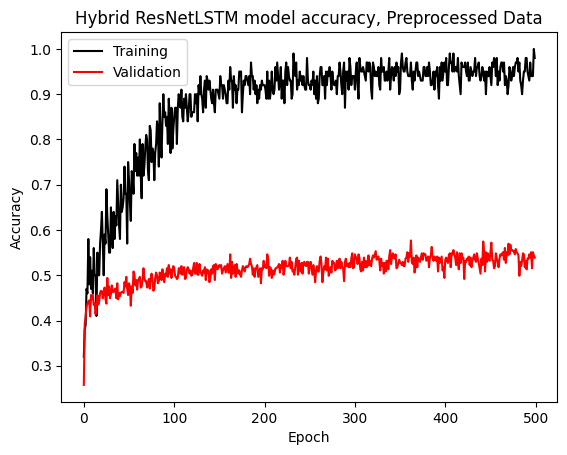

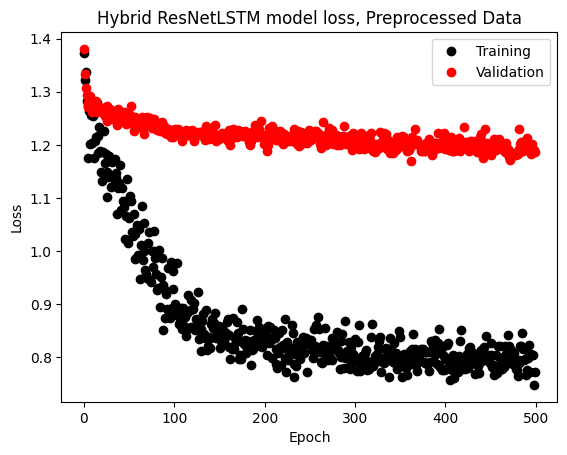

In [ ]:
# Change arrays and titles between models
plt.plot(np.arange(num_epochs),train_history_2,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_2,label='Validation',color='r')
plt.title('Hybrid ResNetLSTM model accuracy, Preprocessed Data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_2,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_2,'o',label='Validation',color='r')
plt.title('Hybrid ResNetLSTM model loss, Preprocessed Data')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 3: Low Pass Filter after Preprocessing

In [17]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [18]:
# Define the low-pass filter parameters
cutoff_frequency = 40  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth low-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='low', analog=False, output='ba')

x_train_lpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_lpf[i,0,j,:] = filtered_data

x_train_lpf = torch.tensor(x_train_lpf).float().to(device)
print(x_train_lpf.shape)

torch.Size([6768, 1, 22, 400])


In [19]:
model3 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model3)
total_params = sum(p.numel() for p in model3.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_3, val_history_3 = np.array([]), np.array([])
train_loss_hist_3, val_loss_hist_3 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model3_params.pt')
    torch.save(model3.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model3.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model3(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model3.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model3(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_3 = np.append(train_history_3, train_acc.item())
        val_history_3 = np.append(val_history_3, val_acc.item())
        train_loss_hist_3 = np.append(train_loss_hist_3, loss.item())
        val_loss_hist_3 = np.append(val_loss_hist_3, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model3.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-17-b02a0c5557c2>:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:03<25:23,  3.05s/it]

Epoch 1 Finished!!!
Train acc: 0.310, Val acc: 0.314
Train loss: 1.379, Val loss: 1.379


  0%|          | 2/500 [00:06<25:08,  3.03s/it]

Epoch 2 Finished!!!
Train acc: 0.320, Val acc: 0.357
Train loss: 1.364, Val loss: 1.358


  1%|          | 3/500 [00:09<25:05,  3.03s/it]

Epoch 3 Finished!!!
Train acc: 0.380, Val acc: 0.423
Train loss: 1.332, Val loss: 1.324


  1%|          | 4/500 [00:12<25:03,  3.03s/it]

Epoch 4 Finished!!!
Train acc: 0.390, Val acc: 0.440
Train loss: 1.320, Val loss: 1.304


  1%|          | 5/500 [00:15<24:59,  3.03s/it]

Epoch 5 Finished!!!
Train acc: 0.430, Val acc: 0.437
Train loss: 1.296, Val loss: 1.293


  1%|          | 6/500 [00:18<24:57,  3.03s/it]

Epoch 6 Finished!!!
Train acc: 0.510, Val acc: 0.359
Train loss: 1.245, Val loss: 1.329


  1%|▏         | 7/500 [00:21<24:58,  3.04s/it]

Epoch 7 Finished!!!
Train acc: 0.490, Val acc: 0.440
Train loss: 1.259, Val loss: 1.276


  2%|▏         | 8/500 [00:24<25:02,  3.05s/it]

Epoch 8 Finished!!!
Train acc: 0.520, Val acc: 0.461
Train loss: 1.203, Val loss: 1.273


  2%|▏         | 9/500 [00:27<25:02,  3.06s/it]

Epoch 9 Finished!!!
Train acc: 0.540, Val acc: 0.444
Train loss: 1.219, Val loss: 1.275


  2%|▏         | 10/500 [00:30<25:02,  3.07s/it]

Epoch 10 Finished!!!
Train acc: 0.450, Val acc: 0.444
Train loss: 1.267, Val loss: 1.273


  2%|▏         | 11/500 [00:33<25:05,  3.08s/it]

Epoch 11 Finished!!!
Train acc: 0.520, Val acc: 0.435
Train loss: 1.208, Val loss: 1.279


  2%|▏         | 12/500 [00:36<25:10,  3.10s/it]

Epoch 12 Finished!!!
Train acc: 0.630, Val acc: 0.466
Train loss: 1.157, Val loss: 1.267


  3%|▎         | 13/500 [00:39<25:12,  3.11s/it]

Epoch 13 Finished!!!
Train acc: 0.500, Val acc: 0.461
Train loss: 1.232, Val loss: 1.259


  3%|▎         | 14/500 [00:43<25:16,  3.12s/it]

Epoch 14 Finished!!!
Train acc: 0.500, Val acc: 0.468
Train loss: 1.220, Val loss: 1.256


  3%|▎         | 15/500 [00:46<25:19,  3.13s/it]

Epoch 15 Finished!!!
Train acc: 0.530, Val acc: 0.468
Train loss: 1.212, Val loss: 1.255


  3%|▎         | 16/500 [00:49<25:22,  3.14s/it]

Epoch 16 Finished!!!
Train acc: 0.490, Val acc: 0.452
Train loss: 1.238, Val loss: 1.267


  3%|▎         | 17/500 [00:52<25:23,  3.15s/it]

Epoch 17 Finished!!!
Train acc: 0.610, Val acc: 0.463
Train loss: 1.146, Val loss: 1.268


  4%|▎         | 18/500 [00:55<25:25,  3.17s/it]

Epoch 18 Finished!!!
Train acc: 0.590, Val acc: 0.501
Train loss: 1.172, Val loss: 1.241


  4%|▍         | 19/500 [00:58<25:19,  3.16s/it]

Epoch 19 Finished!!!
Train acc: 0.550, Val acc: 0.480
Train loss: 1.180, Val loss: 1.257


  4%|▍         | 20/500 [01:01<25:11,  3.15s/it]

Epoch 20 Finished!!!
Train acc: 0.590, Val acc: 0.468
Train loss: 1.176, Val loss: 1.258


  4%|▍         | 21/500 [01:05<25:02,  3.14s/it]

Epoch 21 Finished!!!
Train acc: 0.600, Val acc: 0.489
Train loss: 1.149, Val loss: 1.240


  4%|▍         | 22/500 [01:08<24:54,  3.13s/it]

Epoch 22 Finished!!!
Train acc: 0.570, Val acc: 0.492
Train loss: 1.168, Val loss: 1.246


  5%|▍         | 23/500 [01:11<24:47,  3.12s/it]

Epoch 23 Finished!!!
Train acc: 0.740, Val acc: 0.485
Train loss: 1.032, Val loss: 1.238


  5%|▍         | 24/500 [01:14<24:40,  3.11s/it]

Epoch 24 Finished!!!
Train acc: 0.570, Val acc: 0.475
Train loss: 1.175, Val loss: 1.244


  5%|▌         | 25/500 [01:17<24:33,  3.10s/it]

Epoch 25 Finished!!!
Train acc: 0.640, Val acc: 0.485
Train loss: 1.107, Val loss: 1.237


  5%|▌         | 26/500 [01:20<24:32,  3.11s/it]

Epoch 26 Finished!!!
Train acc: 0.550, Val acc: 0.485
Train loss: 1.179, Val loss: 1.240


  5%|▌         | 27/500 [01:23<24:28,  3.11s/it]

Epoch 27 Finished!!!
Train acc: 0.640, Val acc: 0.508
Train loss: 1.119, Val loss: 1.221


  6%|▌         | 28/500 [01:26<24:19,  3.09s/it]

Epoch 28 Finished!!!
Train acc: 0.590, Val acc: 0.463
Train loss: 1.145, Val loss: 1.254


  6%|▌         | 29/500 [01:29<24:12,  3.08s/it]

Epoch 29 Finished!!!
Train acc: 0.550, Val acc: 0.487
Train loss: 1.186, Val loss: 1.229


  6%|▌         | 30/500 [01:32<24:07,  3.08s/it]

Epoch 30 Finished!!!
Train acc: 0.700, Val acc: 0.496
Train loss: 1.070, Val loss: 1.232


  6%|▌         | 31/500 [01:35<24:03,  3.08s/it]

Epoch 31 Finished!!!
Train acc: 0.620, Val acc: 0.504
Train loss: 1.105, Val loss: 1.232


  6%|▋         | 32/500 [01:39<23:59,  3.08s/it]

Epoch 32 Finished!!!
Train acc: 0.600, Val acc: 0.482
Train loss: 1.137, Val loss: 1.239


  7%|▋         | 33/500 [01:42<23:59,  3.08s/it]

Epoch 33 Finished!!!
Train acc: 0.670, Val acc: 0.515
Train loss: 1.072, Val loss: 1.219


  7%|▋         | 34/500 [01:45<23:55,  3.08s/it]

Epoch 34 Finished!!!
Train acc: 0.610, Val acc: 0.468
Train loss: 1.147, Val loss: 1.260


  7%|▋         | 35/500 [01:48<23:53,  3.08s/it]

Epoch 35 Finished!!!
Train acc: 0.680, Val acc: 0.475
Train loss: 1.062, Val loss: 1.255


  7%|▋         | 36/500 [01:51<23:52,  3.09s/it]

Epoch 36 Finished!!!
Train acc: 0.590, Val acc: 0.494
Train loss: 1.167, Val loss: 1.234


  7%|▋         | 37/500 [01:54<23:50,  3.09s/it]

Epoch 37 Finished!!!
Train acc: 0.700, Val acc: 0.511
Train loss: 1.057, Val loss: 1.214


  8%|▊         | 38/500 [01:57<23:48,  3.09s/it]

Epoch 38 Finished!!!
Train acc: 0.650, Val acc: 0.496
Train loss: 1.104, Val loss: 1.226


  8%|▊         | 39/500 [02:00<23:48,  3.10s/it]

Epoch 39 Finished!!!
Train acc: 0.670, Val acc: 0.482
Train loss: 1.080, Val loss: 1.242


  8%|▊         | 40/500 [02:03<23:46,  3.10s/it]

Epoch 40 Finished!!!
Train acc: 0.640, Val acc: 0.506
Train loss: 1.107, Val loss: 1.217


  8%|▊         | 41/500 [02:06<23:45,  3.11s/it]

Epoch 41 Finished!!!
Train acc: 0.710, Val acc: 0.487
Train loss: 1.044, Val loss: 1.241


  8%|▊         | 42/500 [02:10<23:47,  3.12s/it]

Epoch 42 Finished!!!
Train acc: 0.710, Val acc: 0.518
Train loss: 1.048, Val loss: 1.215


  9%|▊         | 43/500 [02:13<23:43,  3.11s/it]

Epoch 43 Finished!!!
Train acc: 0.620, Val acc: 0.489
Train loss: 1.108, Val loss: 1.235


  9%|▉         | 44/500 [02:16<23:39,  3.11s/it]

Epoch 44 Finished!!!
Train acc: 0.660, Val acc: 0.494
Train loss: 1.102, Val loss: 1.229


  9%|▉         | 45/500 [02:19<23:35,  3.11s/it]

Epoch 45 Finished!!!
Train acc: 0.740, Val acc: 0.494
Train loss: 1.010, Val loss: 1.223


  9%|▉         | 46/500 [02:22<23:32,  3.11s/it]

Epoch 46 Finished!!!
Train acc: 0.770, Val acc: 0.506
Train loss: 1.022, Val loss: 1.214


  9%|▉         | 47/500 [02:25<23:30,  3.11s/it]

Epoch 47 Finished!!!
Train acc: 0.710, Val acc: 0.525
Train loss: 1.067, Val loss: 1.211


 10%|▉         | 48/500 [02:28<23:25,  3.11s/it]

Epoch 48 Finished!!!
Train acc: 0.690, Val acc: 0.508
Train loss: 1.070, Val loss: 1.216


 10%|▉         | 49/500 [02:31<23:20,  3.11s/it]

Epoch 49 Finished!!!
Train acc: 0.740, Val acc: 0.511
Train loss: 1.023, Val loss: 1.225


 10%|█         | 50/500 [02:34<23:15,  3.10s/it]

Epoch 50 Finished!!!
Train acc: 0.750, Val acc: 0.501
Train loss: 1.020, Val loss: 1.219


 10%|█         | 51/500 [02:38<23:13,  3.10s/it]

Epoch 51 Finished!!!
Train acc: 0.740, Val acc: 0.506
Train loss: 1.035, Val loss: 1.221


 10%|█         | 52/500 [02:41<23:09,  3.10s/it]

Epoch 52 Finished!!!
Train acc: 0.770, Val acc: 0.513
Train loss: 0.998, Val loss: 1.211


 11%|█         | 53/500 [02:44<23:05,  3.10s/it]

Epoch 53 Finished!!!
Train acc: 0.670, Val acc: 0.513
Train loss: 1.065, Val loss: 1.207


 11%|█         | 54/500 [02:47<23:01,  3.10s/it]

Epoch 54 Finished!!!
Train acc: 0.710, Val acc: 0.515
Train loss: 1.070, Val loss: 1.208


 11%|█         | 55/500 [02:50<22:58,  3.10s/it]

Epoch 55 Finished!!!
Train acc: 0.760, Val acc: 0.513
Train loss: 1.006, Val loss: 1.216


 11%|█         | 56/500 [02:53<22:54,  3.10s/it]

Epoch 56 Finished!!!
Train acc: 0.720, Val acc: 0.506
Train loss: 1.020, Val loss: 1.218


 11%|█▏        | 57/500 [02:56<22:52,  3.10s/it]

Epoch 57 Finished!!!
Train acc: 0.650, Val acc: 0.525
Train loss: 1.085, Val loss: 1.205


 12%|█▏        | 58/500 [02:59<22:48,  3.10s/it]

Epoch 58 Finished!!!
Train acc: 0.690, Val acc: 0.494
Train loss: 1.063, Val loss: 1.227


 12%|█▏        | 59/500 [03:02<22:46,  3.10s/it]

Epoch 59 Finished!!!
Train acc: 0.700, Val acc: 0.508
Train loss: 1.058, Val loss: 1.207


 12%|█▏        | 60/500 [03:06<23:36,  3.22s/it]

Epoch 60 Finished!!!
Train acc: 0.580, Val acc: 0.504
Train loss: 1.154, Val loss: 1.231


 12%|█▏        | 61/500 [03:09<23:17,  3.18s/it]

Epoch 61 Finished!!!
Train acc: 0.680, Val acc: 0.496
Train loss: 1.062, Val loss: 1.232


 12%|█▏        | 62/500 [03:12<23:03,  3.16s/it]

Epoch 62 Finished!!!
Train acc: 0.720, Val acc: 0.506
Train loss: 1.022, Val loss: 1.216


 13%|█▎        | 63/500 [03:15<22:52,  3.14s/it]

Epoch 63 Finished!!!
Train acc: 0.600, Val acc: 0.508
Train loss: 1.121, Val loss: 1.213


 13%|█▎        | 64/500 [03:18<22:44,  3.13s/it]

Epoch 64 Finished!!!
Train acc: 0.710, Val acc: 0.515
Train loss: 1.030, Val loss: 1.217


 13%|█▎        | 65/500 [03:21<22:38,  3.12s/it]

Epoch 65 Finished!!!
Train acc: 0.760, Val acc: 0.525
Train loss: 0.995, Val loss: 1.204


 13%|█▎        | 66/500 [03:24<22:32,  3.12s/it]

Epoch 66 Finished!!!
Train acc: 0.740, Val acc: 0.496
Train loss: 0.998, Val loss: 1.219


 13%|█▎        | 67/500 [03:28<22:27,  3.11s/it]

Epoch 67 Finished!!!
Train acc: 0.770, Val acc: 0.506
Train loss: 0.989, Val loss: 1.219


 14%|█▎        | 68/500 [03:31<22:27,  3.12s/it]

Epoch 68 Finished!!!
Train acc: 0.660, Val acc: 0.546
Train loss: 1.103, Val loss: 1.189


 14%|█▍        | 69/500 [03:34<22:22,  3.12s/it]

Epoch 69 Finished!!!
Train acc: 0.770, Val acc: 0.527
Train loss: 0.983, Val loss: 1.217


 14%|█▍        | 70/500 [03:37<22:18,  3.11s/it]

Epoch 70 Finished!!!
Train acc: 0.760, Val acc: 0.525
Train loss: 0.985, Val loss: 1.199


 14%|█▍        | 71/500 [03:40<22:14,  3.11s/it]

Epoch 71 Finished!!!
Train acc: 0.820, Val acc: 0.489
Train loss: 0.944, Val loss: 1.233


 14%|█▍        | 72/500 [03:43<22:10,  3.11s/it]

Epoch 72 Finished!!!
Train acc: 0.720, Val acc: 0.513
Train loss: 1.016, Val loss: 1.213


 15%|█▍        | 73/500 [03:46<22:07,  3.11s/it]

Epoch 73 Finished!!!
Train acc: 0.750, Val acc: 0.537
Train loss: 1.019, Val loss: 1.194


 15%|█▍        | 74/500 [03:49<22:03,  3.11s/it]

Epoch 74 Finished!!!
Train acc: 0.810, Val acc: 0.518
Train loss: 0.945, Val loss: 1.206


 15%|█▌        | 75/500 [03:52<22:00,  3.11s/it]

Epoch 75 Finished!!!
Train acc: 0.790, Val acc: 0.504
Train loss: 0.966, Val loss: 1.215


 15%|█▌        | 76/500 [03:55<21:56,  3.10s/it]

Epoch 76 Finished!!!
Train acc: 0.780, Val acc: 0.515
Train loss: 0.979, Val loss: 1.210


 15%|█▌        | 77/500 [03:59<21:53,  3.10s/it]

Epoch 77 Finished!!!
Train acc: 0.690, Val acc: 0.473
Train loss: 1.059, Val loss: 1.239


 16%|█▌        | 78/500 [04:02<21:57,  3.12s/it]

Epoch 78 Finished!!!
Train acc: 0.800, Val acc: 0.520
Train loss: 0.962, Val loss: 1.207


 16%|█▌        | 79/500 [04:05<22:06,  3.15s/it]

Epoch 79 Finished!!!
Train acc: 0.730, Val acc: 0.539
Train loss: 1.022, Val loss: 1.191


 16%|█▌        | 80/500 [04:09<23:46,  3.40s/it]

Epoch 80 Finished!!!
Train acc: 0.780, Val acc: 0.515
Train loss: 0.975, Val loss: 1.207


 16%|█▌        | 81/500 [04:13<24:32,  3.51s/it]

Epoch 81 Finished!!!
Train acc: 0.720, Val acc: 0.527
Train loss: 1.035, Val loss: 1.199


 16%|█▋        | 82/500 [04:16<23:40,  3.40s/it]

Epoch 82 Finished!!!
Train acc: 0.740, Val acc: 0.518
Train loss: 1.017, Val loss: 1.202


 17%|█▋        | 83/500 [04:19<23:01,  3.31s/it]

Epoch 83 Finished!!!
Train acc: 0.810, Val acc: 0.487
Train loss: 0.948, Val loss: 1.229


 17%|█▋        | 84/500 [04:22<22:53,  3.30s/it]

Epoch 84 Finished!!!
Train acc: 0.750, Val acc: 0.515
Train loss: 1.012, Val loss: 1.206


 17%|█▋        | 85/500 [04:26<23:10,  3.35s/it]

Epoch 85 Finished!!!
Train acc: 0.740, Val acc: 0.527
Train loss: 1.013, Val loss: 1.206


 17%|█▋        | 86/500 [04:29<22:47,  3.30s/it]

Epoch 86 Finished!!!
Train acc: 0.750, Val acc: 0.518
Train loss: 0.999, Val loss: 1.209


 17%|█▋        | 87/500 [04:32<22:49,  3.32s/it]

Epoch 87 Finished!!!
Train acc: 0.780, Val acc: 0.513
Train loss: 0.982, Val loss: 1.210


 18%|█▊        | 88/500 [04:35<22:31,  3.28s/it]

Epoch 88 Finished!!!
Train acc: 0.750, Val acc: 0.518
Train loss: 1.012, Val loss: 1.202


 18%|█▊        | 89/500 [04:39<22:17,  3.26s/it]

Epoch 89 Finished!!!
Train acc: 0.740, Val acc: 0.525
Train loss: 0.989, Val loss: 1.204


 18%|█▊        | 90/500 [04:42<21:54,  3.21s/it]

Epoch 90 Finished!!!
Train acc: 0.860, Val acc: 0.520
Train loss: 0.878, Val loss: 1.210


 18%|█▊        | 91/500 [04:45<21:40,  3.18s/it]

Epoch 91 Finished!!!
Train acc: 0.760, Val acc: 0.534
Train loss: 0.978, Val loss: 1.192


 18%|█▊        | 92/500 [04:48<21:57,  3.23s/it]

Epoch 92 Finished!!!
Train acc: 0.810, Val acc: 0.511
Train loss: 0.946, Val loss: 1.215


 19%|█▊        | 93/500 [04:51<22:00,  3.24s/it]

Epoch 93 Finished!!!
Train acc: 0.730, Val acc: 0.499
Train loss: 1.031, Val loss: 1.223


 19%|█▉        | 94/500 [04:55<21:40,  3.20s/it]

Epoch 94 Finished!!!
Train acc: 0.890, Val acc: 0.499
Train loss: 0.873, Val loss: 1.215


 19%|█▉        | 95/500 [04:58<21:24,  3.17s/it]

Epoch 95 Finished!!!
Train acc: 0.850, Val acc: 0.513
Train loss: 0.904, Val loss: 1.219


 19%|█▉        | 96/500 [05:01<21:11,  3.15s/it]

Epoch 96 Finished!!!
Train acc: 0.800, Val acc: 0.518
Train loss: 0.949, Val loss: 1.212


 19%|█▉        | 97/500 [05:04<21:02,  3.13s/it]

Epoch 97 Finished!!!
Train acc: 0.810, Val acc: 0.544
Train loss: 0.935, Val loss: 1.193


 20%|█▉        | 98/500 [05:07<20:54,  3.12s/it]

Epoch 98 Finished!!!
Train acc: 0.850, Val acc: 0.532
Train loss: 0.905, Val loss: 1.197


 20%|█▉        | 99/500 [05:10<20:47,  3.11s/it]

Epoch 99 Finished!!!
Train acc: 0.810, Val acc: 0.522
Train loss: 0.944, Val loss: 1.202


 20%|██        | 100/500 [05:13<20:42,  3.11s/it]

Epoch 100 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.858, Val loss: 1.204


 20%|██        | 101/500 [05:16<20:39,  3.11s/it]

Epoch 101 Finished!!!
Train acc: 0.820, Val acc: 0.530
Train loss: 0.931, Val loss: 1.195


 20%|██        | 102/500 [05:19<20:35,  3.10s/it]

Epoch 102 Finished!!!
Train acc: 0.880, Val acc: 0.518
Train loss: 0.887, Val loss: 1.199


 21%|██        | 103/500 [05:22<20:30,  3.10s/it]

Epoch 103 Finished!!!
Train acc: 0.790, Val acc: 0.518
Train loss: 0.953, Val loss: 1.211


 21%|██        | 104/500 [05:26<20:26,  3.10s/it]

Epoch 104 Finished!!!
Train acc: 0.750, Val acc: 0.527
Train loss: 0.975, Val loss: 1.199


 21%|██        | 105/500 [05:29<20:23,  3.10s/it]

Epoch 105 Finished!!!
Train acc: 0.850, Val acc: 0.518
Train loss: 0.893, Val loss: 1.204


 21%|██        | 106/500 [05:32<20:19,  3.10s/it]

Epoch 106 Finished!!!
Train acc: 0.780, Val acc: 0.518
Train loss: 0.974, Val loss: 1.207


 21%|██▏       | 107/500 [05:35<20:16,  3.09s/it]

Epoch 107 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.841, Val loss: 1.186


 22%|██▏       | 108/500 [05:38<20:13,  3.09s/it]

Epoch 108 Finished!!!
Train acc: 0.870, Val acc: 0.532
Train loss: 0.891, Val loss: 1.190


 22%|██▏       | 109/500 [05:41<20:10,  3.09s/it]

Epoch 109 Finished!!!
Train acc: 0.880, Val acc: 0.508
Train loss: 0.893, Val loss: 1.215


 22%|██▏       | 110/500 [05:44<20:07,  3.10s/it]

Epoch 110 Finished!!!
Train acc: 0.810, Val acc: 0.539
Train loss: 0.933, Val loss: 1.195


 22%|██▏       | 111/500 [05:47<20:03,  3.09s/it]

Epoch 111 Finished!!!
Train acc: 0.880, Val acc: 0.515
Train loss: 0.871, Val loss: 1.195


 22%|██▏       | 112/500 [05:50<20:00,  3.09s/it]

Epoch 112 Finished!!!
Train acc: 0.840, Val acc: 0.515
Train loss: 0.908, Val loss: 1.202


 23%|██▎       | 113/500 [05:53<19:57,  3.09s/it]

Epoch 113 Finished!!!
Train acc: 0.870, Val acc: 0.539
Train loss: 0.880, Val loss: 1.200


 23%|██▎       | 114/500 [05:56<19:54,  3.10s/it]

Epoch 114 Finished!!!
Train acc: 0.840, Val acc: 0.544
Train loss: 0.899, Val loss: 1.186


 23%|██▎       | 115/500 [06:00<19:51,  3.09s/it]

Epoch 115 Finished!!!
Train acc: 0.840, Val acc: 0.527
Train loss: 0.910, Val loss: 1.200


 23%|██▎       | 116/500 [06:03<19:48,  3.10s/it]

Epoch 116 Finished!!!
Train acc: 0.790, Val acc: 0.546
Train loss: 0.959, Val loss: 1.191


 23%|██▎       | 117/500 [06:06<19:45,  3.10s/it]

Epoch 117 Finished!!!
Train acc: 0.810, Val acc: 0.532
Train loss: 0.945, Val loss: 1.184


 24%|██▎       | 118/500 [06:09<19:43,  3.10s/it]

Epoch 118 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.855, Val loss: 1.198


 24%|██▍       | 119/500 [06:12<19:45,  3.11s/it]

Epoch 119 Finished!!!
Train acc: 0.850, Val acc: 0.522
Train loss: 0.910, Val loss: 1.205


 24%|██▍       | 120/500 [06:15<19:40,  3.11s/it]

Epoch 120 Finished!!!
Train acc: 0.870, Val acc: 0.544
Train loss: 0.868, Val loss: 1.196


 24%|██▍       | 121/500 [06:18<19:40,  3.11s/it]

Epoch 121 Finished!!!
Train acc: 0.890, Val acc: 0.556
Train loss: 0.872, Val loss: 1.182


 24%|██▍       | 122/500 [06:21<19:38,  3.12s/it]

Epoch 122 Finished!!!
Train acc: 0.850, Val acc: 0.558
Train loss: 0.893, Val loss: 1.177


 25%|██▍       | 123/500 [06:24<19:32,  3.11s/it]

Epoch 123 Finished!!!
Train acc: 0.820, Val acc: 0.525
Train loss: 0.926, Val loss: 1.208


 25%|██▍       | 124/500 [06:28<19:28,  3.11s/it]

Epoch 124 Finished!!!
Train acc: 0.860, Val acc: 0.537
Train loss: 0.894, Val loss: 1.191


 25%|██▌       | 125/500 [06:31<19:27,  3.11s/it]

Epoch 125 Finished!!!
Train acc: 0.890, Val acc: 0.560
Train loss: 0.854, Val loss: 1.180


 25%|██▌       | 126/500 [06:34<19:57,  3.20s/it]

Epoch 126 Finished!!!
Train acc: 0.880, Val acc: 0.530
Train loss: 0.863, Val loss: 1.187


 25%|██▌       | 127/500 [06:37<19:43,  3.17s/it]

Epoch 127 Finished!!!
Train acc: 0.870, Val acc: 0.556
Train loss: 0.889, Val loss: 1.174


 26%|██▌       | 128/500 [06:40<19:31,  3.15s/it]

Epoch 128 Finished!!!
Train acc: 0.870, Val acc: 0.537
Train loss: 0.872, Val loss: 1.190


 26%|██▌       | 129/500 [06:43<19:23,  3.13s/it]

Epoch 129 Finished!!!
Train acc: 0.850, Val acc: 0.518
Train loss: 0.892, Val loss: 1.208


 26%|██▌       | 130/500 [06:46<19:15,  3.12s/it]

Epoch 130 Finished!!!
Train acc: 0.880, Val acc: 0.534
Train loss: 0.870, Val loss: 1.200


 26%|██▌       | 131/500 [06:50<19:10,  3.12s/it]

Epoch 131 Finished!!!
Train acc: 0.860, Val acc: 0.539
Train loss: 0.890, Val loss: 1.183


 26%|██▋       | 132/500 [06:53<19:05,  3.11s/it]

Epoch 132 Finished!!!
Train acc: 0.870, Val acc: 0.534
Train loss: 0.885, Val loss: 1.195


 27%|██▋       | 133/500 [06:56<19:01,  3.11s/it]

Epoch 133 Finished!!!
Train acc: 0.890, Val acc: 0.527
Train loss: 0.864, Val loss: 1.209


 27%|██▋       | 134/500 [06:59<18:57,  3.11s/it]

Epoch 134 Finished!!!
Train acc: 0.860, Val acc: 0.553
Train loss: 0.889, Val loss: 1.183


 27%|██▋       | 135/500 [07:02<18:54,  3.11s/it]

Epoch 135 Finished!!!
Train acc: 0.890, Val acc: 0.541
Train loss: 0.860, Val loss: 1.198


 27%|██▋       | 136/500 [07:05<18:50,  3.10s/it]

Epoch 136 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.839, Val loss: 1.190


 27%|██▋       | 137/500 [07:08<18:46,  3.10s/it]

Epoch 137 Finished!!!
Train acc: 0.860, Val acc: 0.504
Train loss: 0.899, Val loss: 1.218


 28%|██▊       | 138/500 [07:11<18:43,  3.10s/it]

Epoch 138 Finished!!!
Train acc: 0.900, Val acc: 0.556
Train loss: 0.845, Val loss: 1.181


 28%|██▊       | 139/500 [07:14<18:40,  3.10s/it]

Epoch 139 Finished!!!
Train acc: 0.870, Val acc: 0.546
Train loss: 0.889, Val loss: 1.190


 28%|██▊       | 140/500 [07:18<18:37,  3.10s/it]

Epoch 140 Finished!!!
Train acc: 0.790, Val acc: 0.544
Train loss: 0.954, Val loss: 1.190


 28%|██▊       | 141/500 [07:21<18:33,  3.10s/it]

Epoch 141 Finished!!!
Train acc: 0.900, Val acc: 0.544
Train loss: 0.857, Val loss: 1.185


 28%|██▊       | 142/500 [07:24<18:30,  3.10s/it]

Epoch 142 Finished!!!
Train acc: 0.870, Val acc: 0.558
Train loss: 0.876, Val loss: 1.176


 29%|██▊       | 143/500 [07:27<18:29,  3.11s/it]

Epoch 143 Finished!!!
Train acc: 0.860, Val acc: 0.570
Train loss: 0.903, Val loss: 1.166


 29%|██▉       | 144/500 [07:30<18:24,  3.10s/it]

Epoch 144 Finished!!!
Train acc: 0.880, Val acc: 0.553
Train loss: 0.882, Val loss: 1.181


 29%|██▉       | 145/500 [07:33<18:21,  3.10s/it]

Epoch 145 Finished!!!
Train acc: 0.860, Val acc: 0.548
Train loss: 0.890, Val loss: 1.178


 29%|██▉       | 146/500 [07:36<18:18,  3.10s/it]

Epoch 146 Finished!!!
Train acc: 0.870, Val acc: 0.527
Train loss: 0.884, Val loss: 1.209


 29%|██▉       | 147/500 [07:39<18:15,  3.10s/it]

Epoch 147 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.847, Val loss: 1.180


 30%|██▉       | 148/500 [07:42<18:12,  3.10s/it]

Epoch 148 Finished!!!
Train acc: 0.880, Val acc: 0.546
Train loss: 0.870, Val loss: 1.188


 30%|██▉       | 149/500 [07:45<18:08,  3.10s/it]

Epoch 149 Finished!!!
Train acc: 0.880, Val acc: 0.556
Train loss: 0.870, Val loss: 1.184


 30%|███       | 150/500 [07:49<18:05,  3.10s/it]

Epoch 150 Finished!!!
Train acc: 0.870, Val acc: 0.539
Train loss: 0.870, Val loss: 1.188


 30%|███       | 151/500 [07:52<18:03,  3.10s/it]

Epoch 151 Finished!!!
Train acc: 0.910, Val acc: 0.553
Train loss: 0.848, Val loss: 1.186


 30%|███       | 152/500 [07:55<18:04,  3.12s/it]

Epoch 152 Finished!!!
Train acc: 0.930, Val acc: 0.579
Train loss: 0.822, Val loss: 1.163


 31%|███       | 153/500 [07:58<18:19,  3.17s/it]

Epoch 153 Finished!!!
Train acc: 0.910, Val acc: 0.551
Train loss: 0.844, Val loss: 1.181


 31%|███       | 154/500 [08:01<18:09,  3.15s/it]

Epoch 154 Finished!!!
Train acc: 0.890, Val acc: 0.565
Train loss: 0.877, Val loss: 1.178


 31%|███       | 155/500 [08:04<18:02,  3.14s/it]

Epoch 155 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.807, Val loss: 1.178


 31%|███       | 156/500 [08:07<17:55,  3.13s/it]

Epoch 156 Finished!!!
Train acc: 0.840, Val acc: 0.548
Train loss: 0.890, Val loss: 1.181


 31%|███▏      | 157/500 [08:11<17:50,  3.12s/it]

Epoch 157 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.834, Val loss: 1.184


 32%|███▏      | 158/500 [08:14<17:45,  3.12s/it]

Epoch 158 Finished!!!
Train acc: 0.900, Val acc: 0.534
Train loss: 0.855, Val loss: 1.200


 32%|███▏      | 159/500 [08:17<17:41,  3.11s/it]

Epoch 159 Finished!!!
Train acc: 0.900, Val acc: 0.548
Train loss: 0.842, Val loss: 1.186


 32%|███▏      | 160/500 [08:20<17:37,  3.11s/it]

Epoch 160 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.823, Val loss: 1.173


 32%|███▏      | 161/500 [08:23<17:33,  3.11s/it]

Epoch 161 Finished!!!
Train acc: 0.910, Val acc: 0.553
Train loss: 0.831, Val loss: 1.175


 32%|███▏      | 162/500 [08:26<17:30,  3.11s/it]

Epoch 162 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.823, Val loss: 1.188


 33%|███▎      | 163/500 [08:29<17:26,  3.11s/it]

Epoch 163 Finished!!!
Train acc: 0.880, Val acc: 0.563
Train loss: 0.869, Val loss: 1.176


 33%|███▎      | 164/500 [08:32<17:23,  3.11s/it]

Epoch 164 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.848, Val loss: 1.189


 33%|███▎      | 165/500 [08:35<17:20,  3.10s/it]

Epoch 165 Finished!!!
Train acc: 0.870, Val acc: 0.541
Train loss: 0.874, Val loss: 1.183


 33%|███▎      | 166/500 [08:38<17:16,  3.10s/it]

Epoch 166 Finished!!!
Train acc: 0.910, Val acc: 0.537
Train loss: 0.838, Val loss: 1.187


 33%|███▎      | 167/500 [08:42<17:14,  3.11s/it]

Epoch 167 Finished!!!
Train acc: 0.890, Val acc: 0.560
Train loss: 0.857, Val loss: 1.178


 34%|███▎      | 168/500 [08:45<17:10,  3.10s/it]

Epoch 168 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.826, Val loss: 1.172


 34%|███▍      | 169/500 [08:48<17:11,  3.12s/it]

Epoch 169 Finished!!!
Train acc: 0.900, Val acc: 0.546
Train loss: 0.849, Val loss: 1.179


 34%|███▍      | 170/500 [08:51<17:07,  3.11s/it]

Epoch 170 Finished!!!
Train acc: 0.880, Val acc: 0.541
Train loss: 0.857, Val loss: 1.193


 34%|███▍      | 171/500 [08:54<17:03,  3.11s/it]

Epoch 171 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.829, Val loss: 1.183


 34%|███▍      | 172/500 [08:57<16:59,  3.11s/it]

Epoch 172 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.827, Val loss: 1.189


 35%|███▍      | 173/500 [09:00<16:56,  3.11s/it]

Epoch 173 Finished!!!
Train acc: 0.900, Val acc: 0.558
Train loss: 0.856, Val loss: 1.179


 35%|███▍      | 174/500 [09:03<16:52,  3.11s/it]

Epoch 174 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.852, Val loss: 1.176


 35%|███▌      | 175/500 [09:06<16:48,  3.10s/it]

Epoch 175 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.822, Val loss: 1.182


 35%|███▌      | 176/500 [09:10<16:45,  3.10s/it]

Epoch 176 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.821, Val loss: 1.169


 35%|███▌      | 177/500 [09:13<16:42,  3.10s/it]

Epoch 177 Finished!!!
Train acc: 0.900, Val acc: 0.546
Train loss: 0.853, Val loss: 1.187


 36%|███▌      | 178/500 [09:16<16:39,  3.10s/it]

Epoch 178 Finished!!!
Train acc: 0.850, Val acc: 0.544
Train loss: 0.895, Val loss: 1.180


 36%|███▌      | 179/500 [09:19<16:36,  3.11s/it]

Epoch 179 Finished!!!
Train acc: 0.840, Val acc: 0.553
Train loss: 0.900, Val loss: 1.180


 36%|███▌      | 180/500 [09:22<16:34,  3.11s/it]

Epoch 180 Finished!!!
Train acc: 0.880, Val acc: 0.541
Train loss: 0.868, Val loss: 1.182


 36%|███▌      | 181/500 [09:25<16:30,  3.11s/it]

Epoch 181 Finished!!!
Train acc: 0.880, Val acc: 0.520
Train loss: 0.876, Val loss: 1.206


 36%|███▋      | 182/500 [09:28<16:27,  3.11s/it]

Epoch 182 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.829, Val loss: 1.177


 37%|███▋      | 183/500 [09:31<16:24,  3.11s/it]

Epoch 183 Finished!!!
Train acc: 0.870, Val acc: 0.556
Train loss: 0.888, Val loss: 1.181


 37%|███▋      | 184/500 [09:34<16:21,  3.11s/it]

Epoch 184 Finished!!!
Train acc: 0.900, Val acc: 0.539
Train loss: 0.850, Val loss: 1.189


 37%|███▋      | 185/500 [09:37<16:18,  3.11s/it]

Epoch 185 Finished!!!
Train acc: 0.910, Val acc: 0.548
Train loss: 0.833, Val loss: 1.188


 37%|███▋      | 186/500 [09:41<16:14,  3.10s/it]

Epoch 186 Finished!!!
Train acc: 0.910, Val acc: 0.551
Train loss: 0.840, Val loss: 1.182


 37%|███▋      | 187/500 [09:44<16:11,  3.10s/it]

Epoch 187 Finished!!!
Train acc: 0.900, Val acc: 0.567
Train loss: 0.849, Val loss: 1.170


 38%|███▊      | 188/500 [09:47<16:08,  3.11s/it]

Epoch 188 Finished!!!
Train acc: 0.890, Val acc: 0.556
Train loss: 0.873, Val loss: 1.184


 38%|███▊      | 189/500 [09:50<16:05,  3.10s/it]

Epoch 189 Finished!!!
Train acc: 0.870, Val acc: 0.577
Train loss: 0.884, Val loss: 1.163


 38%|███▊      | 190/500 [09:53<16:02,  3.10s/it]

Epoch 190 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.786, Val loss: 1.175


 38%|███▊      | 191/500 [09:56<15:59,  3.11s/it]

Epoch 191 Finished!!!
Train acc: 0.850, Val acc: 0.567
Train loss: 0.891, Val loss: 1.171


 38%|███▊      | 192/500 [09:59<15:55,  3.10s/it]

Epoch 192 Finished!!!
Train acc: 0.860, Val acc: 0.572
Train loss: 0.887, Val loss: 1.165


 39%|███▊      | 193/500 [10:02<15:52,  3.10s/it]

Epoch 193 Finished!!!
Train acc: 0.910, Val acc: 0.537
Train loss: 0.843, Val loss: 1.195


 39%|███▉      | 194/500 [10:05<15:49,  3.10s/it]

Epoch 194 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.836, Val loss: 1.180


 39%|███▉      | 195/500 [10:09<15:46,  3.10s/it]

Epoch 195 Finished!!!
Train acc: 0.850, Val acc: 0.544
Train loss: 0.899, Val loss: 1.186


 39%|███▉      | 196/500 [10:12<15:43,  3.10s/it]

Epoch 196 Finished!!!
Train acc: 0.900, Val acc: 0.532
Train loss: 0.849, Val loss: 1.199


 39%|███▉      | 197/500 [10:15<15:40,  3.10s/it]

Epoch 197 Finished!!!
Train acc: 0.890, Val acc: 0.551
Train loss: 0.858, Val loss: 1.187


 40%|███▉      | 198/500 [10:18<15:36,  3.10s/it]

Epoch 198 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.840, Val loss: 1.185


 40%|███▉      | 199/500 [10:21<15:33,  3.10s/it]

Epoch 199 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.815, Val loss: 1.176


 40%|████      | 200/500 [10:24<15:30,  3.10s/it]

Epoch 200 Finished!!!
Train acc: 0.910, Val acc: 0.579
Train loss: 0.835, Val loss: 1.155


 40%|████      | 201/500 [10:27<15:27,  3.10s/it]

Epoch 201 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.800, Val loss: 1.187


 40%|████      | 202/500 [10:30<15:24,  3.10s/it]

Epoch 202 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.789, Val loss: 1.173


 41%|████      | 203/500 [10:33<15:21,  3.10s/it]

Epoch 203 Finished!!!
Train acc: 0.910, Val acc: 0.537
Train loss: 0.840, Val loss: 1.196


 41%|████      | 204/500 [10:36<15:18,  3.10s/it]

Epoch 204 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.781, Val loss: 1.195


 41%|████      | 205/500 [10:40<15:15,  3.10s/it]

Epoch 205 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.808, Val loss: 1.182


 41%|████      | 206/500 [10:43<15:12,  3.10s/it]

Epoch 206 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.838, Val loss: 1.174


 41%|████▏     | 207/500 [10:46<15:08,  3.10s/it]

Epoch 207 Finished!!!
Train acc: 0.900, Val acc: 0.539
Train loss: 0.843, Val loss: 1.201


 42%|████▏     | 208/500 [10:49<15:05,  3.10s/it]

Epoch 208 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.792, Val loss: 1.193


 42%|████▏     | 209/500 [10:52<15:02,  3.10s/it]

Epoch 209 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.823, Val loss: 1.187


 42%|████▏     | 210/500 [10:55<14:59,  3.10s/it]

Epoch 210 Finished!!!
Train acc: 0.890, Val acc: 0.534
Train loss: 0.857, Val loss: 1.204


 42%|████▏     | 211/500 [10:58<14:56,  3.10s/it]

Epoch 211 Finished!!!
Train acc: 0.900, Val acc: 0.567
Train loss: 0.847, Val loss: 1.171


 42%|████▏     | 212/500 [11:01<14:53,  3.10s/it]

Epoch 212 Finished!!!
Train acc: 0.920, Val acc: 0.577
Train loss: 0.825, Val loss: 1.164


 43%|████▎     | 213/500 [11:04<14:50,  3.10s/it]

Epoch 213 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.814, Val loss: 1.192


 43%|████▎     | 214/500 [11:07<14:46,  3.10s/it]

Epoch 214 Finished!!!
Train acc: 0.880, Val acc: 0.546
Train loss: 0.872, Val loss: 1.186


 43%|████▎     | 215/500 [11:11<14:43,  3.10s/it]

Epoch 215 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.853, Val loss: 1.173


 43%|████▎     | 216/500 [11:14<14:40,  3.10s/it]

Epoch 216 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.801, Val loss: 1.180


 43%|████▎     | 217/500 [11:17<14:37,  3.10s/it]

Epoch 217 Finished!!!
Train acc: 0.870, Val acc: 0.570
Train loss: 0.876, Val loss: 1.171


 44%|████▎     | 218/500 [11:20<14:34,  3.10s/it]

Epoch 218 Finished!!!
Train acc: 0.870, Val acc: 0.560
Train loss: 0.885, Val loss: 1.176


 44%|████▍     | 219/500 [11:23<14:31,  3.10s/it]

Epoch 219 Finished!!!
Train acc: 0.910, Val acc: 0.532
Train loss: 0.817, Val loss: 1.200


 44%|████▍     | 220/500 [11:26<14:28,  3.10s/it]

Epoch 220 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.822, Val loss: 1.170


 44%|████▍     | 221/500 [11:29<14:26,  3.10s/it]

Epoch 221 Finished!!!
Train acc: 0.900, Val acc: 0.546
Train loss: 0.837, Val loss: 1.185


 44%|████▍     | 222/500 [11:32<14:22,  3.10s/it]

Epoch 222 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.806, Val loss: 1.174


 45%|████▍     | 223/500 [11:35<14:19,  3.10s/it]

Epoch 223 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.817, Val loss: 1.186


 45%|████▍     | 224/500 [11:39<14:17,  3.11s/it]

Epoch 224 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.793, Val loss: 1.178


 45%|████▌     | 225/500 [11:42<14:13,  3.11s/it]

Epoch 225 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.829, Val loss: 1.179


 45%|████▌     | 226/500 [11:45<14:10,  3.10s/it]

Epoch 226 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.799, Val loss: 1.173


 45%|████▌     | 227/500 [11:48<14:06,  3.10s/it]

Epoch 227 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.825, Val loss: 1.181


 46%|████▌     | 228/500 [11:51<14:03,  3.10s/it]

Epoch 228 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.787, Val loss: 1.186


 46%|████▌     | 229/500 [11:54<14:01,  3.10s/it]

Epoch 229 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.804, Val loss: 1.183


 46%|████▌     | 230/500 [11:57<13:57,  3.10s/it]

Epoch 230 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.842, Val loss: 1.174


 46%|████▌     | 231/500 [12:00<13:54,  3.10s/it]

Epoch 231 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.820, Val loss: 1.176


 46%|████▋     | 232/500 [12:03<13:51,  3.10s/it]

Epoch 232 Finished!!!
Train acc: 0.920, Val acc: 0.546
Train loss: 0.832, Val loss: 1.184


 47%|████▋     | 233/500 [12:06<13:48,  3.10s/it]

Epoch 233 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.813, Val loss: 1.186


 47%|████▋     | 234/500 [12:10<13:44,  3.10s/it]

Epoch 234 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.820, Val loss: 1.181


 47%|████▋     | 235/500 [12:13<13:41,  3.10s/it]

Epoch 235 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.812, Val loss: 1.184


 47%|████▋     | 236/500 [12:16<13:38,  3.10s/it]

Epoch 236 Finished!!!
Train acc: 0.900, Val acc: 0.572
Train loss: 0.859, Val loss: 1.162


 47%|████▋     | 237/500 [12:19<13:35,  3.10s/it]

Epoch 237 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.802, Val loss: 1.166


 48%|████▊     | 238/500 [12:22<13:32,  3.10s/it]

Epoch 238 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.821, Val loss: 1.158


 48%|████▊     | 239/500 [12:25<13:29,  3.10s/it]

Epoch 239 Finished!!!
Train acc: 0.850, Val acc: 0.565
Train loss: 0.885, Val loss: 1.173


 48%|████▊     | 240/500 [12:28<13:25,  3.10s/it]

Epoch 240 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.818, Val loss: 1.175


 48%|████▊     | 241/500 [12:31<13:23,  3.10s/it]

Epoch 241 Finished!!!
Train acc: 0.910, Val acc: 0.532
Train loss: 0.827, Val loss: 1.196


 48%|████▊     | 242/500 [12:34<13:20,  3.10s/it]

Epoch 242 Finished!!!
Train acc: 0.880, Val acc: 0.551
Train loss: 0.861, Val loss: 1.186


 49%|████▊     | 243/500 [12:37<13:17,  3.10s/it]

Epoch 243 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.819, Val loss: 1.191


 49%|████▉     | 244/500 [12:41<13:13,  3.10s/it]

Epoch 244 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.835, Val loss: 1.191


 49%|████▉     | 245/500 [12:44<13:10,  3.10s/it]

Epoch 245 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.840, Val loss: 1.189


 49%|████▉     | 246/500 [12:47<13:08,  3.10s/it]

Epoch 246 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.838, Val loss: 1.163


 49%|████▉     | 247/500 [12:50<13:04,  3.10s/it]

Epoch 247 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.787, Val loss: 1.183


 50%|████▉     | 248/500 [12:53<13:01,  3.10s/it]

Epoch 248 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.829, Val loss: 1.187


 50%|████▉     | 249/500 [12:56<12:58,  3.10s/it]

Epoch 249 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.792, Val loss: 1.182


 50%|█████     | 250/500 [12:59<12:55,  3.10s/it]

Epoch 250 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.823, Val loss: 1.172


 50%|█████     | 251/500 [13:02<12:52,  3.10s/it]

Epoch 251 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.806, Val loss: 1.201


 50%|█████     | 252/500 [13:05<12:49,  3.10s/it]

Epoch 252 Finished!!!
Train acc: 0.900, Val acc: 0.548
Train loss: 0.844, Val loss: 1.183


 51%|█████     | 253/500 [13:08<12:46,  3.10s/it]

Epoch 253 Finished!!!
Train acc: 0.840, Val acc: 0.546
Train loss: 0.905, Val loss: 1.185


 51%|█████     | 254/500 [13:12<12:44,  3.11s/it]

Epoch 254 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.830, Val loss: 1.180


 51%|█████     | 255/500 [13:15<12:40,  3.11s/it]

Epoch 255 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.840, Val loss: 1.189


 51%|█████     | 256/500 [13:18<12:37,  3.10s/it]

Epoch 256 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.801, Val loss: 1.210


 51%|█████▏    | 257/500 [13:21<12:34,  3.10s/it]

Epoch 257 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.824, Val loss: 1.193


 52%|█████▏    | 258/500 [13:24<12:30,  3.10s/it]

Epoch 258 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.825, Val loss: 1.194


 52%|█████▏    | 259/500 [13:27<12:28,  3.10s/it]

Epoch 259 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.811, Val loss: 1.195


 52%|█████▏    | 260/500 [13:30<12:24,  3.10s/it]

Epoch 260 Finished!!!
Train acc: 0.880, Val acc: 0.560
Train loss: 0.872, Val loss: 1.172


 52%|█████▏    | 261/500 [13:33<12:21,  3.10s/it]

Epoch 261 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.852, Val loss: 1.185


 52%|█████▏    | 262/500 [13:36<12:18,  3.10s/it]

Epoch 262 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.770, Val loss: 1.187


 53%|█████▎    | 263/500 [13:39<12:15,  3.10s/it]

Epoch 263 Finished!!!
Train acc: 0.960, Val acc: 0.560
Train loss: 0.796, Val loss: 1.169


 53%|█████▎    | 264/500 [13:43<12:12,  3.10s/it]

Epoch 264 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.787, Val loss: 1.192


 53%|█████▎    | 265/500 [13:46<12:09,  3.10s/it]

Epoch 265 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.825, Val loss: 1.176


 53%|█████▎    | 266/500 [13:49<12:06,  3.10s/it]

Epoch 266 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.801, Val loss: 1.186


 53%|█████▎    | 267/500 [13:52<12:03,  3.10s/it]

Epoch 267 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.801, Val loss: 1.188


 54%|█████▎    | 268/500 [13:55<12:00,  3.10s/it]

Epoch 268 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.797, Val loss: 1.189


 54%|█████▍    | 269/500 [13:58<11:56,  3.10s/it]

Epoch 269 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.820, Val loss: 1.191


 54%|█████▍    | 270/500 [14:01<11:53,  3.10s/it]

Epoch 270 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.789, Val loss: 1.190


 54%|█████▍    | 271/500 [14:04<11:51,  3.11s/it]

Epoch 271 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.808, Val loss: 1.185


 54%|█████▍    | 272/500 [14:07<11:47,  3.11s/it]

Epoch 272 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.833, Val loss: 1.189


 55%|█████▍    | 273/500 [14:11<11:44,  3.11s/it]

Epoch 273 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.807, Val loss: 1.165


 55%|█████▍    | 274/500 [14:14<11:42,  3.11s/it]

Epoch 274 Finished!!!
Train acc: 0.910, Val acc: 0.548
Train loss: 0.830, Val loss: 1.189


 55%|█████▌    | 275/500 [14:17<11:39,  3.11s/it]

Epoch 275 Finished!!!
Train acc: 0.890, Val acc: 0.556
Train loss: 0.853, Val loss: 1.180


 55%|█████▌    | 276/500 [14:20<11:35,  3.11s/it]

Epoch 276 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.791, Val loss: 1.192


 55%|█████▌    | 277/500 [14:23<11:32,  3.11s/it]

Epoch 277 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.787, Val loss: 1.191


 56%|█████▌    | 278/500 [14:26<11:29,  3.11s/it]

Epoch 278 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.805, Val loss: 1.188


 56%|█████▌    | 279/500 [14:29<11:26,  3.11s/it]

Epoch 279 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.787, Val loss: 1.170


 56%|█████▌    | 280/500 [14:32<11:23,  3.11s/it]

Epoch 280 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.830, Val loss: 1.179


 56%|█████▌    | 281/500 [14:35<11:20,  3.11s/it]

Epoch 281 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.827, Val loss: 1.179


 56%|█████▋    | 282/500 [14:38<11:17,  3.11s/it]

Epoch 282 Finished!!!
Train acc: 0.910, Val acc: 0.558
Train loss: 0.835, Val loss: 1.177


 57%|█████▋    | 283/500 [14:42<11:14,  3.11s/it]

Epoch 283 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.793, Val loss: 1.190


 57%|█████▋    | 284/500 [14:45<11:11,  3.11s/it]

Epoch 284 Finished!!!
Train acc: 0.960, Val acc: 0.565
Train loss: 0.787, Val loss: 1.172


 57%|█████▋    | 285/500 [14:48<11:07,  3.11s/it]

Epoch 285 Finished!!!
Train acc: 0.910, Val acc: 0.553
Train loss: 0.837, Val loss: 1.179


 57%|█████▋    | 286/500 [14:51<11:04,  3.11s/it]

Epoch 286 Finished!!!
Train acc: 0.880, Val acc: 0.553
Train loss: 0.867, Val loss: 1.175


 57%|█████▋    | 287/500 [14:54<11:01,  3.11s/it]

Epoch 287 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.799, Val loss: 1.161


 58%|█████▊    | 288/500 [14:57<10:58,  3.11s/it]

Epoch 288 Finished!!!
Train acc: 0.910, Val acc: 0.546
Train loss: 0.839, Val loss: 1.181


 58%|█████▊    | 289/500 [15:00<10:55,  3.11s/it]

Epoch 289 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.793, Val loss: 1.179


 58%|█████▊    | 290/500 [15:03<10:52,  3.11s/it]

Epoch 290 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.816, Val loss: 1.195


 58%|█████▊    | 291/500 [15:06<10:49,  3.11s/it]

Epoch 291 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.816, Val loss: 1.183


 58%|█████▊    | 292/500 [15:10<10:46,  3.11s/it]

Epoch 292 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.779, Val loss: 1.185


 59%|█████▊    | 293/500 [15:13<10:42,  3.11s/it]

Epoch 293 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.781, Val loss: 1.184


 59%|█████▉    | 294/500 [15:16<10:39,  3.11s/it]

Epoch 294 Finished!!!
Train acc: 0.910, Val acc: 0.553
Train loss: 0.842, Val loss: 1.180


 59%|█████▉    | 295/500 [15:19<10:36,  3.10s/it]

Epoch 295 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.806, Val loss: 1.171


 59%|█████▉    | 296/500 [15:22<10:33,  3.11s/it]

Epoch 296 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.797, Val loss: 1.184


 59%|█████▉    | 297/500 [15:25<10:30,  3.11s/it]

Epoch 297 Finished!!!
Train acc: 0.900, Val acc: 0.532
Train loss: 0.846, Val loss: 1.192


 60%|█████▉    | 298/500 [15:28<10:27,  3.11s/it]

Epoch 298 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.803, Val loss: 1.205


 60%|█████▉    | 299/500 [15:31<10:24,  3.11s/it]

Epoch 299 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.828, Val loss: 1.190


 60%|██████    | 300/500 [15:34<10:21,  3.11s/it]

Epoch 300 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.821, Val loss: 1.188


 60%|██████    | 301/500 [15:38<10:18,  3.11s/it]

Epoch 301 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.813, Val loss: 1.193


 60%|██████    | 302/500 [15:41<10:14,  3.11s/it]

Epoch 302 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.783, Val loss: 1.176


 61%|██████    | 303/500 [15:44<10:11,  3.10s/it]

Epoch 303 Finished!!!
Train acc: 0.980, Val acc: 0.558
Train loss: 0.768, Val loss: 1.185


 61%|██████    | 304/500 [15:47<10:08,  3.11s/it]

Epoch 304 Finished!!!
Train acc: 0.920, Val acc: 0.546
Train loss: 0.832, Val loss: 1.183


 61%|██████    | 305/500 [15:50<10:05,  3.10s/it]

Epoch 305 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.787, Val loss: 1.196


 61%|██████    | 306/500 [15:53<10:02,  3.10s/it]

Epoch 306 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.824, Val loss: 1.194


 61%|██████▏   | 307/500 [15:56<09:59,  3.10s/it]

Epoch 307 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.797, Val loss: 1.186


 62%|██████▏   | 308/500 [15:59<09:56,  3.10s/it]

Epoch 308 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.821, Val loss: 1.186


 62%|██████▏   | 309/500 [16:02<09:52,  3.10s/it]

Epoch 309 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.773, Val loss: 1.193


 62%|██████▏   | 310/500 [16:05<09:49,  3.10s/it]

Epoch 310 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.798, Val loss: 1.177


 62%|██████▏   | 311/500 [16:09<09:46,  3.11s/it]

Epoch 311 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.792, Val loss: 1.182


 62%|██████▏   | 312/500 [16:12<09:44,  3.11s/it]

Epoch 312 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.817, Val loss: 1.180


 63%|██████▎   | 313/500 [16:15<09:41,  3.11s/it]

Epoch 313 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.828, Val loss: 1.175


 63%|██████▎   | 314/500 [16:18<09:37,  3.11s/it]

Epoch 314 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.803, Val loss: 1.177


 63%|██████▎   | 315/500 [16:21<09:34,  3.10s/it]

Epoch 315 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.778, Val loss: 1.185


 63%|██████▎   | 316/500 [16:24<09:30,  3.10s/it]

Epoch 316 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.806, Val loss: 1.179


 63%|██████▎   | 317/500 [16:27<09:28,  3.10s/it]

Epoch 317 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.814, Val loss: 1.186


 64%|██████▎   | 318/500 [16:30<09:25,  3.11s/it]

Epoch 318 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.827, Val loss: 1.187


 64%|██████▍   | 319/500 [16:33<09:21,  3.10s/it]

Epoch 319 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.803, Val loss: 1.186


 64%|██████▍   | 320/500 [16:37<09:18,  3.10s/it]

Epoch 320 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.794, Val loss: 1.203


 64%|██████▍   | 321/500 [16:40<09:15,  3.11s/it]

Epoch 321 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.784, Val loss: 1.198


 64%|██████▍   | 322/500 [16:43<09:12,  3.10s/it]

Epoch 322 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.789, Val loss: 1.192


 65%|██████▍   | 323/500 [16:46<09:09,  3.10s/it]

Epoch 323 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.790, Val loss: 1.191


 65%|██████▍   | 324/500 [16:49<09:06,  3.10s/it]

Epoch 324 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.767, Val loss: 1.185


 65%|██████▌   | 325/500 [16:52<09:03,  3.11s/it]

Epoch 325 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.787, Val loss: 1.192


 65%|██████▌   | 326/500 [16:55<09:00,  3.11s/it]

Epoch 326 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.787, Val loss: 1.177


 65%|██████▌   | 327/500 [16:58<08:56,  3.10s/it]

Epoch 327 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.841, Val loss: 1.191


 66%|██████▌   | 328/500 [17:01<08:53,  3.10s/it]

Epoch 328 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.781, Val loss: 1.185


 66%|██████▌   | 329/500 [17:04<08:51,  3.11s/it]

Epoch 329 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.795, Val loss: 1.184


 66%|██████▌   | 330/500 [17:08<08:48,  3.11s/it]

Epoch 330 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.799, Val loss: 1.182


 66%|██████▌   | 331/500 [17:11<08:44,  3.10s/it]

Epoch 331 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.801, Val loss: 1.191


 66%|██████▋   | 332/500 [17:14<08:41,  3.10s/it]

Epoch 332 Finished!!!
Train acc: 0.990, Val acc: 0.541
Train loss: 0.766, Val loss: 1.187


 67%|██████▋   | 333/500 [17:17<08:38,  3.10s/it]

Epoch 333 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.821, Val loss: 1.201


 67%|██████▋   | 334/500 [17:20<08:35,  3.10s/it]

Epoch 334 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.803, Val loss: 1.198


 67%|██████▋   | 335/500 [17:23<08:32,  3.10s/it]

Epoch 335 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.800, Val loss: 1.179


 67%|██████▋   | 336/500 [17:26<08:28,  3.10s/it]

Epoch 336 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.795, Val loss: 1.190


 67%|██████▋   | 337/500 [17:29<08:25,  3.10s/it]

Epoch 337 Finished!!!
Train acc: 0.910, Val acc: 0.537
Train loss: 0.842, Val loss: 1.198


 68%|██████▊   | 338/500 [17:32<08:22,  3.10s/it]

Epoch 338 Finished!!!
Train acc: 0.920, Val acc: 0.532
Train loss: 0.829, Val loss: 1.197


 68%|██████▊   | 339/500 [17:35<08:19,  3.10s/it]

Epoch 339 Finished!!!
Train acc: 0.880, Val acc: 0.530
Train loss: 0.871, Val loss: 1.195


 68%|██████▊   | 340/500 [17:39<08:16,  3.10s/it]

Epoch 340 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.816, Val loss: 1.194


 68%|██████▊   | 341/500 [17:42<08:13,  3.10s/it]

Epoch 341 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.799, Val loss: 1.171


 68%|██████▊   | 342/500 [17:45<08:10,  3.11s/it]

Epoch 342 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.804, Val loss: 1.190


 69%|██████▊   | 343/500 [17:48<08:07,  3.11s/it]

Epoch 343 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.783, Val loss: 1.188


 69%|██████▉   | 344/500 [17:51<08:04,  3.10s/it]

Epoch 344 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.778, Val loss: 1.199


 69%|██████▉   | 345/500 [17:54<08:01,  3.10s/it]

Epoch 345 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.789, Val loss: 1.195


 69%|██████▉   | 346/500 [17:57<07:58,  3.10s/it]

Epoch 346 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.787, Val loss: 1.205


 69%|██████▉   | 347/500 [18:00<07:55,  3.10s/it]

Epoch 347 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.828, Val loss: 1.185


 70%|██████▉   | 348/500 [18:03<07:51,  3.10s/it]

Epoch 348 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.837, Val loss: 1.191


 70%|██████▉   | 349/500 [18:07<07:48,  3.10s/it]

Epoch 349 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.793, Val loss: 1.199


 70%|███████   | 350/500 [18:10<07:45,  3.10s/it]

Epoch 350 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.780, Val loss: 1.181


 70%|███████   | 351/500 [18:13<07:42,  3.10s/it]

Epoch 351 Finished!!!
Train acc: 0.910, Val acc: 0.558
Train loss: 0.842, Val loss: 1.173


 70%|███████   | 352/500 [18:16<07:39,  3.10s/it]

Epoch 352 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.819, Val loss: 1.199


 71%|███████   | 353/500 [18:19<07:36,  3.10s/it]

Epoch 353 Finished!!!
Train acc: 0.910, Val acc: 0.574
Train loss: 0.844, Val loss: 1.164


 71%|███████   | 354/500 [18:22<07:33,  3.11s/it]

Epoch 354 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.781, Val loss: 1.182


 71%|███████   | 355/500 [18:25<07:30,  3.10s/it]

Epoch 355 Finished!!!
Train acc: 0.970, Val acc: 0.513
Train loss: 0.777, Val loss: 1.206


 71%|███████   | 356/500 [18:28<07:26,  3.10s/it]

Epoch 356 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.829, Val loss: 1.201


 71%|███████▏  | 357/500 [18:31<07:23,  3.10s/it]

Epoch 357 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.812, Val loss: 1.199


 72%|███████▏  | 358/500 [18:34<07:20,  3.10s/it]

Epoch 358 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.788, Val loss: 1.194


 72%|███████▏  | 359/500 [18:38<07:17,  3.10s/it]

Epoch 359 Finished!!!
Train acc: 0.880, Val acc: 0.532
Train loss: 0.855, Val loss: 1.200


 72%|███████▏  | 360/500 [18:41<07:14,  3.11s/it]

Epoch 360 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.806, Val loss: 1.194


 72%|███████▏  | 361/500 [18:44<07:11,  3.11s/it]

Epoch 361 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.761, Val loss: 1.184


 72%|███████▏  | 362/500 [18:47<07:08,  3.11s/it]

Epoch 362 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.800, Val loss: 1.169


 73%|███████▎  | 363/500 [18:50<07:05,  3.11s/it]

Epoch 363 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.797, Val loss: 1.191


 73%|███████▎  | 364/500 [18:53<07:02,  3.11s/it]

Epoch 364 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.798, Val loss: 1.187


 73%|███████▎  | 365/500 [18:56<06:59,  3.11s/it]

Epoch 365 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.802, Val loss: 1.207


 73%|███████▎  | 366/500 [18:59<06:56,  3.10s/it]

Epoch 366 Finished!!!
Train acc: 1.000, Val acc: 0.508
Train loss: 0.747, Val loss: 1.210


 73%|███████▎  | 367/500 [19:02<06:52,  3.10s/it]

Epoch 367 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.784, Val loss: 1.192


 74%|███████▎  | 368/500 [19:06<06:49,  3.11s/it]

Epoch 368 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.778, Val loss: 1.188


 74%|███████▍  | 369/500 [19:09<06:46,  3.11s/it]

Epoch 369 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.812, Val loss: 1.201


 74%|███████▍  | 370/500 [19:12<06:43,  3.10s/it]

Epoch 370 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.809, Val loss: 1.201


 74%|███████▍  | 371/500 [19:15<06:40,  3.11s/it]

Epoch 371 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.818, Val loss: 1.202


 74%|███████▍  | 372/500 [19:18<06:37,  3.11s/it]

Epoch 372 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.781, Val loss: 1.184


 75%|███████▍  | 373/500 [19:21<06:34,  3.10s/it]

Epoch 373 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.805, Val loss: 1.212


 75%|███████▍  | 374/500 [19:24<06:31,  3.11s/it]

Epoch 374 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.792, Val loss: 1.193


 75%|███████▌  | 375/500 [19:27<06:28,  3.11s/it]

Epoch 375 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.799, Val loss: 1.183


 75%|███████▌  | 376/500 [19:30<06:25,  3.11s/it]

Epoch 376 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.814, Val loss: 1.186


 75%|███████▌  | 377/500 [19:33<06:22,  3.11s/it]

Epoch 377 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.830, Val loss: 1.187


 76%|███████▌  | 378/500 [19:37<06:18,  3.11s/it]

Epoch 378 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.825, Val loss: 1.198


 76%|███████▌  | 379/500 [19:40<06:15,  3.11s/it]

Epoch 379 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.832, Val loss: 1.197


 76%|███████▌  | 380/500 [19:43<06:12,  3.11s/it]

Epoch 380 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.807, Val loss: 1.189


 76%|███████▌  | 381/500 [19:46<06:09,  3.11s/it]

Epoch 381 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.788, Val loss: 1.193


 76%|███████▋  | 382/500 [19:49<06:06,  3.11s/it]

Epoch 382 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.820, Val loss: 1.220


 77%|███████▋  | 383/500 [19:52<06:03,  3.11s/it]

Epoch 383 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.812, Val loss: 1.192


 77%|███████▋  | 384/500 [19:55<06:00,  3.11s/it]

Epoch 384 Finished!!!
Train acc: 0.910, Val acc: 0.532
Train loss: 0.842, Val loss: 1.200


 77%|███████▋  | 385/500 [19:58<05:57,  3.11s/it]

Epoch 385 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.829, Val loss: 1.189


 77%|███████▋  | 386/500 [20:01<05:54,  3.11s/it]

Epoch 386 Finished!!!
Train acc: 0.990, Val acc: 0.567
Train loss: 0.757, Val loss: 1.164


 77%|███████▋  | 387/500 [20:05<05:51,  3.11s/it]

Epoch 387 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.779, Val loss: 1.187


 78%|███████▊  | 388/500 [20:08<05:48,  3.11s/it]

Epoch 388 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.787, Val loss: 1.198


 78%|███████▊  | 389/500 [20:11<05:44,  3.11s/it]

Epoch 389 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.809, Val loss: 1.187


 78%|███████▊  | 390/500 [20:14<05:41,  3.11s/it]

Epoch 390 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.801, Val loss: 1.202


 78%|███████▊  | 391/500 [20:17<05:38,  3.11s/it]

Epoch 391 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.793, Val loss: 1.203


 78%|███████▊  | 392/500 [20:20<05:35,  3.11s/it]

Epoch 392 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.769, Val loss: 1.183


 79%|███████▊  | 393/500 [20:23<05:32,  3.11s/it]

Epoch 393 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.795, Val loss: 1.193


 79%|███████▉  | 394/500 [20:26<05:29,  3.11s/it]

Epoch 394 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.788, Val loss: 1.184


 79%|███████▉  | 395/500 [20:29<05:26,  3.11s/it]

Epoch 395 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.793, Val loss: 1.206


 79%|███████▉  | 396/500 [20:33<05:23,  3.11s/it]

Epoch 396 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.789, Val loss: 1.186


 79%|███████▉  | 397/500 [20:36<05:20,  3.11s/it]

Epoch 397 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.768, Val loss: 1.176


 80%|███████▉  | 398/500 [20:39<05:17,  3.11s/it]

Epoch 398 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.811, Val loss: 1.197


 80%|███████▉  | 399/500 [20:42<05:14,  3.11s/it]

Epoch 399 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.801, Val loss: 1.186


 80%|████████  | 400/500 [20:45<05:11,  3.11s/it]

Epoch 400 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.832, Val loss: 1.209


 80%|████████  | 401/500 [20:48<05:08,  3.11s/it]

Epoch 401 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.803, Val loss: 1.202


 80%|████████  | 402/500 [20:51<05:04,  3.11s/it]

Epoch 402 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.801, Val loss: 1.184


 81%|████████  | 403/500 [20:54<05:01,  3.11s/it]

Epoch 403 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.796, Val loss: 1.188


 81%|████████  | 404/500 [20:57<04:58,  3.11s/it]

Epoch 404 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.819, Val loss: 1.188


 81%|████████  | 405/500 [21:01<04:55,  3.11s/it]

Epoch 405 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.807, Val loss: 1.199


 81%|████████  | 406/500 [21:04<04:52,  3.11s/it]

Epoch 406 Finished!!!
Train acc: 0.970, Val acc: 0.520
Train loss: 0.777, Val loss: 1.205


 81%|████████▏ | 407/500 [21:07<04:49,  3.11s/it]

Epoch 407 Finished!!!
Train acc: 0.970, Val acc: 0.522
Train loss: 0.770, Val loss: 1.209


 82%|████████▏ | 408/500 [21:10<04:46,  3.11s/it]

Epoch 408 Finished!!!
Train acc: 0.990, Val acc: 0.539
Train loss: 0.764, Val loss: 1.191


 82%|████████▏ | 409/500 [21:13<04:43,  3.11s/it]

Epoch 409 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.770, Val loss: 1.206


 82%|████████▏ | 410/500 [21:16<04:40,  3.11s/it]

Epoch 410 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.796, Val loss: 1.187


 82%|████████▏ | 411/500 [21:19<04:37,  3.11s/it]

Epoch 411 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.789, Val loss: 1.206


 82%|████████▏ | 412/500 [21:22<04:34,  3.12s/it]

Epoch 412 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.769, Val loss: 1.191


 83%|████████▎ | 413/500 [21:25<04:31,  3.12s/it]

Epoch 413 Finished!!!
Train acc: 0.960, Val acc: 0.511
Train loss: 0.795, Val loss: 1.217


 83%|████████▎ | 414/500 [21:29<04:27,  3.11s/it]

Epoch 414 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.806, Val loss: 1.195


 83%|████████▎ | 415/500 [21:32<04:24,  3.11s/it]

Epoch 415 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.823, Val loss: 1.195


 83%|████████▎ | 416/500 [21:35<04:21,  3.12s/it]

Epoch 416 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.808, Val loss: 1.208


 83%|████████▎ | 417/500 [21:38<04:18,  3.11s/it]

Epoch 417 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.795, Val loss: 1.176


 84%|████████▎ | 418/500 [21:41<04:15,  3.11s/it]

Epoch 418 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.786, Val loss: 1.190


 84%|████████▍ | 419/500 [21:44<04:12,  3.11s/it]

Epoch 419 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.780, Val loss: 1.190


 84%|████████▍ | 420/500 [21:47<04:09,  3.11s/it]

Epoch 420 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.783, Val loss: 1.194


 84%|████████▍ | 421/500 [21:50<04:05,  3.11s/it]

Epoch 421 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.806, Val loss: 1.186


 84%|████████▍ | 422/500 [21:53<04:02,  3.11s/it]

Epoch 422 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.798, Val loss: 1.191


 85%|████████▍ | 423/500 [21:57<03:59,  3.11s/it]

Epoch 423 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.774, Val loss: 1.186


 85%|████████▍ | 424/500 [22:00<03:56,  3.11s/it]

Epoch 424 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.784, Val loss: 1.185


 85%|████████▌ | 425/500 [22:03<03:53,  3.11s/it]

Epoch 425 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.791, Val loss: 1.206


 85%|████████▌ | 426/500 [22:06<03:50,  3.11s/it]

Epoch 426 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.788, Val loss: 1.185


 85%|████████▌ | 427/500 [22:09<03:46,  3.11s/it]

Epoch 427 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.790, Val loss: 1.207


 86%|████████▌ | 428/500 [22:12<03:43,  3.11s/it]

Epoch 428 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.796, Val loss: 1.197


 86%|████████▌ | 429/500 [22:15<03:40,  3.11s/it]

Epoch 429 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.782, Val loss: 1.189


 86%|████████▌ | 430/500 [22:18<03:37,  3.11s/it]

Epoch 430 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.791, Val loss: 1.174


 86%|████████▌ | 431/500 [22:21<03:34,  3.11s/it]

Epoch 431 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.785, Val loss: 1.189


 86%|████████▋ | 432/500 [22:25<03:31,  3.11s/it]

Epoch 432 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.778, Val loss: 1.188


 87%|████████▋ | 433/500 [22:28<03:28,  3.11s/it]

Epoch 433 Finished!!!
Train acc: 0.900, Val acc: 0.558
Train loss: 0.847, Val loss: 1.178


 87%|████████▋ | 434/500 [22:31<03:25,  3.11s/it]

Epoch 434 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.787, Val loss: 1.185


 87%|████████▋ | 435/500 [22:34<03:22,  3.11s/it]

Epoch 435 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.796, Val loss: 1.183


 87%|████████▋ | 436/500 [22:37<03:18,  3.11s/it]

Epoch 436 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.777, Val loss: 1.176


 87%|████████▋ | 437/500 [22:40<03:15,  3.11s/it]

Epoch 437 Finished!!!
Train acc: 0.980, Val acc: 0.525
Train loss: 0.774, Val loss: 1.202


 88%|████████▊ | 438/500 [22:43<03:12,  3.11s/it]

Epoch 438 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.787, Val loss: 1.194


 88%|████████▊ | 439/500 [22:46<03:09,  3.11s/it]

Epoch 439 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.777, Val loss: 1.197


 88%|████████▊ | 440/500 [22:49<03:06,  3.11s/it]

Epoch 440 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.815, Val loss: 1.200


 88%|████████▊ | 441/500 [22:53<03:03,  3.11s/it]

Epoch 441 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.809, Val loss: 1.206


 88%|████████▊ | 442/500 [22:56<03:00,  3.11s/it]

Epoch 442 Finished!!!
Train acc: 1.000, Val acc: 0.548
Train loss: 0.750, Val loss: 1.192


 89%|████████▊ | 443/500 [22:59<02:57,  3.11s/it]

Epoch 443 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.813, Val loss: 1.183


 89%|████████▉ | 444/500 [23:02<02:53,  3.11s/it]

Epoch 444 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.847, Val loss: 1.180


 89%|████████▉ | 445/500 [23:05<02:50,  3.11s/it]

Epoch 445 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.774, Val loss: 1.200


 89%|████████▉ | 446/500 [23:08<02:47,  3.11s/it]

Epoch 446 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.777, Val loss: 1.188


 89%|████████▉ | 447/500 [23:11<02:44,  3.11s/it]

Epoch 447 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.811, Val loss: 1.190


 90%|████████▉ | 448/500 [23:14<02:41,  3.10s/it]

Epoch 448 Finished!!!
Train acc: 0.990, Val acc: 0.548
Train loss: 0.763, Val loss: 1.186


 90%|████████▉ | 449/500 [23:17<02:38,  3.10s/it]

Epoch 449 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.799, Val loss: 1.192


 90%|█████████ | 450/500 [23:20<02:35,  3.10s/it]

Epoch 450 Finished!!!
Train acc: 0.940, Val acc: 0.577
Train loss: 0.803, Val loss: 1.168


 90%|█████████ | 451/500 [23:24<02:32,  3.10s/it]

Epoch 451 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.797, Val loss: 1.178


 90%|█████████ | 452/500 [23:27<02:28,  3.10s/it]

Epoch 452 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.797, Val loss: 1.185


 91%|█████████ | 453/500 [23:30<02:25,  3.10s/it]

Epoch 453 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.775, Val loss: 1.186


 91%|█████████ | 454/500 [23:33<02:22,  3.10s/it]

Epoch 454 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.779, Val loss: 1.189


 91%|█████████ | 455/500 [23:36<02:19,  3.10s/it]

Epoch 455 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.777, Val loss: 1.174


 91%|█████████ | 456/500 [23:39<02:16,  3.10s/it]

Epoch 456 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.798, Val loss: 1.156


 91%|█████████▏| 457/500 [23:42<02:13,  3.10s/it]

Epoch 457 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.790, Val loss: 1.176


 92%|█████████▏| 458/500 [23:45<02:10,  3.10s/it]

Epoch 458 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.802, Val loss: 1.186


 92%|█████████▏| 459/500 [23:48<02:07,  3.10s/it]

Epoch 459 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.777, Val loss: 1.195


 92%|█████████▏| 460/500 [23:51<02:04,  3.10s/it]

Epoch 460 Finished!!!
Train acc: 0.960, Val acc: 0.560
Train loss: 0.785, Val loss: 1.165


 92%|█████████▏| 461/500 [23:55<02:01,  3.10s/it]

Epoch 461 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.801, Val loss: 1.191


 92%|█████████▏| 462/500 [23:58<01:57,  3.10s/it]

Epoch 462 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.775, Val loss: 1.194


 93%|█████████▎| 463/500 [24:01<01:54,  3.10s/it]

Epoch 463 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.764, Val loss: 1.191


 93%|█████████▎| 464/500 [24:04<01:51,  3.10s/it]

Epoch 464 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.791, Val loss: 1.175


 93%|█████████▎| 465/500 [24:07<01:48,  3.10s/it]

Epoch 465 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.789, Val loss: 1.183


 93%|█████████▎| 466/500 [24:10<01:45,  3.10s/it]

Epoch 466 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.812, Val loss: 1.179


 93%|█████████▎| 467/500 [24:13<01:42,  3.10s/it]

Epoch 467 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.786, Val loss: 1.178


 94%|█████████▎| 468/500 [24:16<01:40,  3.15s/it]

Epoch 468 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.794, Val loss: 1.178


 94%|█████████▍| 469/500 [24:20<01:37,  3.14s/it]

Epoch 469 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.791, Val loss: 1.184


 94%|█████████▍| 470/500 [24:23<01:33,  3.13s/it]

Epoch 470 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.768, Val loss: 1.165


 94%|█████████▍| 471/500 [24:26<01:30,  3.12s/it]

Epoch 471 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.788, Val loss: 1.192


 94%|█████████▍| 472/500 [24:29<01:27,  3.12s/it]

Epoch 472 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.772, Val loss: 1.178


 95%|█████████▍| 473/500 [24:32<01:24,  3.11s/it]

Epoch 473 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.781, Val loss: 1.172


 95%|█████████▍| 474/500 [24:35<01:20,  3.11s/it]

Epoch 474 Finished!!!
Train acc: 0.970, Val acc: 0.567
Train loss: 0.774, Val loss: 1.175


 95%|█████████▌| 475/500 [24:38<01:17,  3.11s/it]

Epoch 475 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.797, Val loss: 1.164


 95%|█████████▌| 476/500 [24:41<01:14,  3.10s/it]

Epoch 476 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.799, Val loss: 1.167


 95%|█████████▌| 477/500 [24:44<01:11,  3.10s/it]

Epoch 477 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.794, Val loss: 1.174


 96%|█████████▌| 478/500 [24:47<01:08,  3.10s/it]

Epoch 478 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.779, Val loss: 1.179


 96%|█████████▌| 479/500 [24:51<01:05,  3.10s/it]

Epoch 479 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.793, Val loss: 1.175


 96%|█████████▌| 480/500 [24:54<01:02,  3.10s/it]

Epoch 480 Finished!!!
Train acc: 0.990, Val acc: 0.553
Train loss: 0.758, Val loss: 1.174


 96%|█████████▌| 481/500 [24:57<00:58,  3.10s/it]

Epoch 481 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.806, Val loss: 1.165


 96%|█████████▋| 482/500 [25:00<00:55,  3.10s/it]

Epoch 482 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.800, Val loss: 1.179


 97%|█████████▋| 483/500 [25:03<00:52,  3.10s/it]

Epoch 483 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.766, Val loss: 1.177


 97%|█████████▋| 484/500 [25:06<00:49,  3.10s/it]

Epoch 484 Finished!!!
Train acc: 0.960, Val acc: 0.565
Train loss: 0.784, Val loss: 1.177


 97%|█████████▋| 485/500 [25:09<00:46,  3.10s/it]

Epoch 485 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.789, Val loss: 1.191


 97%|█████████▋| 486/500 [25:12<00:43,  3.10s/it]

Epoch 486 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.796, Val loss: 1.180


 97%|█████████▋| 487/500 [25:15<00:40,  3.10s/it]

Epoch 487 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.793, Val loss: 1.198


 98%|█████████▊| 488/500 [25:18<00:37,  3.10s/it]

Epoch 488 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.780, Val loss: 1.190


 98%|█████████▊| 489/500 [25:22<00:34,  3.10s/it]

Epoch 489 Finished!!!
Train acc: 0.990, Val acc: 0.556
Train loss: 0.757, Val loss: 1.185


 98%|█████████▊| 490/500 [25:25<00:31,  3.10s/it]

Epoch 490 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.790, Val loss: 1.186


 98%|█████████▊| 491/500 [25:28<00:27,  3.10s/it]

Epoch 491 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.807, Val loss: 1.181


 98%|█████████▊| 492/500 [25:31<00:24,  3.10s/it]

Epoch 492 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.774, Val loss: 1.185


 99%|█████████▊| 493/500 [25:34<00:21,  3.10s/it]

Epoch 493 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.771, Val loss: 1.191


 99%|█████████▉| 494/500 [25:37<00:18,  3.10s/it]

Epoch 494 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.795, Val loss: 1.180


 99%|█████████▉| 495/500 [25:40<00:15,  3.10s/it]

Epoch 495 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.809, Val loss: 1.204


 99%|█████████▉| 496/500 [25:43<00:12,  3.10s/it]

Epoch 496 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.782, Val loss: 1.193


 99%|█████████▉| 497/500 [25:46<00:09,  3.10s/it]

Epoch 497 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.776, Val loss: 1.179


100%|█████████▉| 498/500 [25:50<00:06,  3.11s/it]

Epoch 498 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.807, Val loss: 1.156


100%|█████████▉| 499/500 [25:53<00:03,  3.11s/it]

Epoch 499 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.796, Val loss: 1.184


100%|██████████| 500/500 [25:56<00:00,  3.11s/it]

Epoch 500 Finished!!!
Train acc: 1.000, Val acc: 0.544
Train loss: 0.748, Val loss: 1.180
Best val Acc: 0.583924


In [20]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3/best_model3_params.pt'
model3.load_state_dict(torch.load(best_model_params_path,map_location=torch.device('cpu')))

<All keys matched successfully>

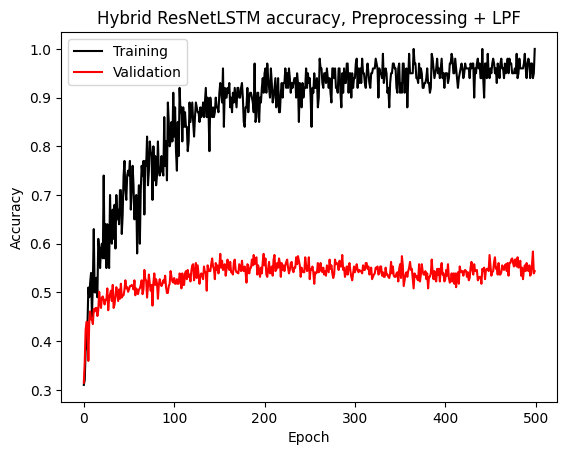

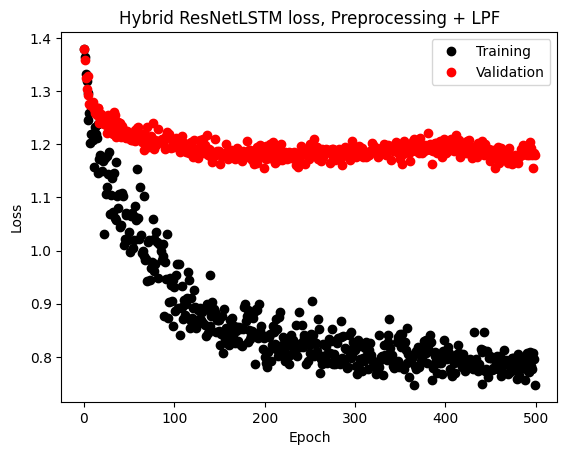

In [ ]:
#Update arrays and title
plt.plot(np.arange(num_epochs),train_history_3,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_3,label='Validation',color='r')
plt.title('Hybrid ResNetLSTM accuracy, Preprocessing + LPF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_3,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_3,'o',label='Validation',color='r')
plt.title('Hybrid ResNetLSTM loss, Preprocessing + LPF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 4: High pass filter after Preprocessing

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
# Define the high-pass filter parameters
cutoff_frequency = 4  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth high-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='high', analog=False, output='ba')

x_train_hpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_hpf[i,0,j,:] = filtered_data

x_train_hpf = torch.tensor(x_train_hpf).float().to(device)
print(x_train_hpf.shape)

torch.Size([6768, 1, 22, 400])


In [ ]:
#Build the model
model4 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model4)
total_params = sum(p.numel() for p in model4.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model4.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_4, val_history_4 = np.array([]), np.array([])
train_loss_hist_4, val_loss_hist_4 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model4_params.pt')
    torch.save(model4.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model4.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model4(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model4.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model4(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_4 = np.append(train_history_4, train_acc.item())
        val_history_4 = np.append(val_history_4, val_acc.item())
        train_loss_hist_4 = np.append(train_loss_hist_4, loss.item())
        val_loss_hist_4 = np.append(val_loss_hist_4, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model4.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-26-36074b3a74fa>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:03<25:36,  3.08s/it]

Epoch 1 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.378, Val loss: 1.387


  0%|          | 2/500 [00:06<25:21,  3.05s/it]

Epoch 2 Finished!!!
Train acc: 0.410, Val acc: 0.362
Train loss: 1.348, Val loss: 1.359


  1%|          | 3/500 [00:09<25:16,  3.05s/it]

Epoch 3 Finished!!!
Train acc: 0.490, Val acc: 0.376
Train loss: 1.309, Val loss: 1.331


  1%|          | 4/500 [00:12<25:09,  3.04s/it]

Epoch 4 Finished!!!
Train acc: 0.430, Val acc: 0.374
Train loss: 1.314, Val loss: 1.338


  1%|          | 5/500 [00:15<25:10,  3.05s/it]

Epoch 5 Finished!!!
Train acc: 0.480, Val acc: 0.426
Train loss: 1.273, Val loss: 1.304


  1%|          | 6/500 [00:18<25:08,  3.05s/it]

Epoch 6 Finished!!!
Train acc: 0.610, Val acc: 0.402
Train loss: 1.200, Val loss: 1.305


  1%|▏         | 7/500 [00:21<26:12,  3.19s/it]

Epoch 7 Finished!!!
Train acc: 0.450, Val acc: 0.433
Train loss: 1.273, Val loss: 1.284


  2%|▏         | 8/500 [00:24<25:57,  3.17s/it]

Epoch 8 Finished!!!
Train acc: 0.360, Val acc: 0.442
Train loss: 1.341, Val loss: 1.275


  2%|▏         | 9/500 [00:27<25:43,  3.14s/it]

Epoch 9 Finished!!!
Train acc: 0.510, Val acc: 0.440
Train loss: 1.206, Val loss: 1.280


  2%|▏         | 10/500 [00:31<26:10,  3.21s/it]

Epoch 10 Finished!!!
Train acc: 0.490, Val acc: 0.435
Train loss: 1.260, Val loss: 1.282


  2%|▏         | 11/500 [00:35<27:45,  3.41s/it]

Epoch 11 Finished!!!
Train acc: 0.560, Val acc: 0.475
Train loss: 1.179, Val loss: 1.257


  2%|▏         | 12/500 [00:38<27:10,  3.34s/it]

Epoch 12 Finished!!!
Train acc: 0.520, Val acc: 0.456
Train loss: 1.206, Val loss: 1.267


  3%|▎         | 13/500 [00:41<26:42,  3.29s/it]

Epoch 13 Finished!!!
Train acc: 0.460, Val acc: 0.442
Train loss: 1.236, Val loss: 1.279


  3%|▎         | 14/500 [00:44<26:23,  3.26s/it]

Epoch 14 Finished!!!
Train acc: 0.540, Val acc: 0.421
Train loss: 1.217, Val loss: 1.283


  3%|▎         | 15/500 [00:47<26:07,  3.23s/it]

Epoch 15 Finished!!!
Train acc: 0.490, Val acc: 0.459
Train loss: 1.243, Val loss: 1.267


  3%|▎         | 16/500 [00:51<25:52,  3.21s/it]

Epoch 16 Finished!!!
Train acc: 0.470, Val acc: 0.433
Train loss: 1.293, Val loss: 1.283


  3%|▎         | 17/500 [00:54<25:37,  3.18s/it]

Epoch 17 Finished!!!
Train acc: 0.490, Val acc: 0.456
Train loss: 1.251, Val loss: 1.272


  4%|▎         | 18/500 [00:57<25:25,  3.16s/it]

Epoch 18 Finished!!!
Train acc: 0.490, Val acc: 0.452
Train loss: 1.238, Val loss: 1.272


  4%|▍         | 19/500 [01:00<25:14,  3.15s/it]

Epoch 19 Finished!!!
Train acc: 0.530, Val acc: 0.421
Train loss: 1.196, Val loss: 1.301


  4%|▍         | 20/500 [01:03<25:05,  3.14s/it]

Epoch 20 Finished!!!
Train acc: 0.620, Val acc: 0.444
Train loss: 1.158, Val loss: 1.273


  4%|▍         | 21/500 [01:06<24:56,  3.12s/it]

Epoch 21 Finished!!!
Train acc: 0.590, Val acc: 0.468
Train loss: 1.168, Val loss: 1.264


  4%|▍         | 22/500 [01:09<24:52,  3.12s/it]

Epoch 22 Finished!!!
Train acc: 0.730, Val acc: 0.508
Train loss: 1.057, Val loss: 1.233


  5%|▍         | 23/500 [01:12<24:42,  3.11s/it]

Epoch 23 Finished!!!
Train acc: 0.630, Val acc: 0.480
Train loss: 1.114, Val loss: 1.256


  5%|▍         | 24/500 [01:15<24:35,  3.10s/it]

Epoch 24 Finished!!!
Train acc: 0.530, Val acc: 0.478
Train loss: 1.200, Val loss: 1.250


  5%|▌         | 25/500 [01:18<24:29,  3.09s/it]

Epoch 25 Finished!!!
Train acc: 0.640, Val acc: 0.473
Train loss: 1.130, Val loss: 1.259


  5%|▌         | 26/500 [01:22<24:23,  3.09s/it]

Epoch 26 Finished!!!
Train acc: 0.620, Val acc: 0.492
Train loss: 1.126, Val loss: 1.242


  5%|▌         | 27/500 [01:25<24:18,  3.08s/it]

Epoch 27 Finished!!!
Train acc: 0.620, Val acc: 0.478
Train loss: 1.121, Val loss: 1.255


  6%|▌         | 28/500 [01:28<24:14,  3.08s/it]

Epoch 28 Finished!!!
Train acc: 0.640, Val acc: 0.468
Train loss: 1.108, Val loss: 1.262


  6%|▌         | 29/500 [01:31<24:10,  3.08s/it]

Epoch 29 Finished!!!
Train acc: 0.580, Val acc: 0.480
Train loss: 1.146, Val loss: 1.242


  6%|▌         | 30/500 [01:34<24:07,  3.08s/it]

Epoch 30 Finished!!!
Train acc: 0.590, Val acc: 0.473
Train loss: 1.143, Val loss: 1.258


  6%|▌         | 31/500 [01:37<24:05,  3.08s/it]

Epoch 31 Finished!!!
Train acc: 0.560, Val acc: 0.468
Train loss: 1.170, Val loss: 1.258


  6%|▋         | 32/500 [01:40<24:03,  3.08s/it]

Epoch 32 Finished!!!
Train acc: 0.680, Val acc: 0.482
Train loss: 1.070, Val loss: 1.244


  7%|▋         | 33/500 [01:43<24:05,  3.09s/it]

Epoch 33 Finished!!!
Train acc: 0.540, Val acc: 0.530
Train loss: 1.220, Val loss: 1.218


  7%|▋         | 34/500 [01:46<24:02,  3.09s/it]

Epoch 34 Finished!!!
Train acc: 0.700, Val acc: 0.496
Train loss: 1.094, Val loss: 1.241


  7%|▋         | 35/500 [01:49<24:00,  3.10s/it]

Epoch 35 Finished!!!
Train acc: 0.650, Val acc: 0.511
Train loss: 1.104, Val loss: 1.229


  7%|▋         | 36/500 [01:52<24:00,  3.10s/it]

Epoch 36 Finished!!!
Train acc: 0.660, Val acc: 0.492
Train loss: 1.078, Val loss: 1.233


  7%|▋         | 37/500 [01:56<23:58,  3.11s/it]

Epoch 37 Finished!!!
Train acc: 0.670, Val acc: 0.489
Train loss: 1.094, Val loss: 1.239


  8%|▊         | 38/500 [01:59<23:56,  3.11s/it]

Epoch 38 Finished!!!
Train acc: 0.570, Val acc: 0.504
Train loss: 1.170, Val loss: 1.231


  8%|▊         | 39/500 [02:02<23:54,  3.11s/it]

Epoch 39 Finished!!!
Train acc: 0.670, Val acc: 0.513
Train loss: 1.083, Val loss: 1.223


  8%|▊         | 40/500 [02:05<24:28,  3.19s/it]

Epoch 40 Finished!!!
Train acc: 0.650, Val acc: 0.506
Train loss: 1.083, Val loss: 1.223


  8%|▊         | 41/500 [02:08<24:15,  3.17s/it]

Epoch 41 Finished!!!
Train acc: 0.650, Val acc: 0.475
Train loss: 1.090, Val loss: 1.254


  8%|▊         | 42/500 [02:11<24:03,  3.15s/it]

Epoch 42 Finished!!!
Train acc: 0.560, Val acc: 0.485
Train loss: 1.154, Val loss: 1.237


  9%|▊         | 43/500 [02:15<23:54,  3.14s/it]

Epoch 43 Finished!!!
Train acc: 0.740, Val acc: 0.478
Train loss: 1.042, Val loss: 1.244


  9%|▉         | 44/500 [02:18<23:47,  3.13s/it]

Epoch 44 Finished!!!
Train acc: 0.630, Val acc: 0.508
Train loss: 1.112, Val loss: 1.219


  9%|▉         | 45/500 [02:21<23:40,  3.12s/it]

Epoch 45 Finished!!!
Train acc: 0.620, Val acc: 0.496
Train loss: 1.127, Val loss: 1.227


  9%|▉         | 46/500 [02:24<23:37,  3.12s/it]

Epoch 46 Finished!!!
Train acc: 0.670, Val acc: 0.537
Train loss: 1.083, Val loss: 1.203


  9%|▉         | 47/500 [02:27<23:30,  3.11s/it]

Epoch 47 Finished!!!
Train acc: 0.730, Val acc: 0.513
Train loss: 1.030, Val loss: 1.214


 10%|▉         | 48/500 [02:30<23:25,  3.11s/it]

Epoch 48 Finished!!!
Train acc: 0.670, Val acc: 0.522
Train loss: 1.077, Val loss: 1.217


 10%|▉         | 49/500 [02:33<23:21,  3.11s/it]

Epoch 49 Finished!!!
Train acc: 0.630, Val acc: 0.515
Train loss: 1.097, Val loss: 1.217


 10%|█         | 50/500 [02:36<23:16,  3.10s/it]

Epoch 50 Finished!!!
Train acc: 0.670, Val acc: 0.496
Train loss: 1.097, Val loss: 1.231


 10%|█         | 51/500 [02:39<23:12,  3.10s/it]

Epoch 51 Finished!!!
Train acc: 0.660, Val acc: 0.515
Train loss: 1.110, Val loss: 1.216


 10%|█         | 52/500 [02:42<23:08,  3.10s/it]

Epoch 52 Finished!!!
Train acc: 0.670, Val acc: 0.534
Train loss: 1.110, Val loss: 1.204


 11%|█         | 53/500 [02:46<23:04,  3.10s/it]

Epoch 53 Finished!!!
Train acc: 0.620, Val acc: 0.515
Train loss: 1.121, Val loss: 1.218


 11%|█         | 54/500 [02:49<23:00,  3.10s/it]

Epoch 54 Finished!!!
Train acc: 0.680, Val acc: 0.530
Train loss: 1.073, Val loss: 1.202


 11%|█         | 55/500 [02:52<22:58,  3.10s/it]

Epoch 55 Finished!!!
Train acc: 0.710, Val acc: 0.518
Train loss: 1.057, Val loss: 1.212


 11%|█         | 56/500 [02:55<22:55,  3.10s/it]

Epoch 56 Finished!!!
Train acc: 0.690, Val acc: 0.530
Train loss: 1.061, Val loss: 1.206


 11%|█▏        | 57/500 [02:58<22:53,  3.10s/it]

Epoch 57 Finished!!!
Train acc: 0.600, Val acc: 0.537
Train loss: 1.123, Val loss: 1.200


 12%|█▏        | 58/500 [03:01<22:54,  3.11s/it]

Epoch 58 Finished!!!
Train acc: 0.690, Val acc: 0.544
Train loss: 1.046, Val loss: 1.195


 12%|█▏        | 59/500 [03:04<22:51,  3.11s/it]

Epoch 59 Finished!!!
Train acc: 0.690, Val acc: 0.534
Train loss: 1.060, Val loss: 1.202


 12%|█▏        | 60/500 [03:07<22:52,  3.12s/it]

Epoch 60 Finished!!!
Train acc: 0.760, Val acc: 0.548
Train loss: 1.002, Val loss: 1.181


 12%|█▏        | 61/500 [03:10<22:48,  3.12s/it]

Epoch 61 Finished!!!
Train acc: 0.730, Val acc: 0.546
Train loss: 1.011, Val loss: 1.192


 12%|█▏        | 62/500 [03:14<22:44,  3.12s/it]

Epoch 62 Finished!!!
Train acc: 0.610, Val acc: 0.544
Train loss: 1.112, Val loss: 1.187


 13%|█▎        | 63/500 [03:17<22:43,  3.12s/it]

Epoch 63 Finished!!!
Train acc: 0.660, Val acc: 0.570
Train loss: 1.089, Val loss: 1.174


 13%|█▎        | 64/500 [03:20<22:39,  3.12s/it]

Epoch 64 Finished!!!
Train acc: 0.700, Val acc: 0.534
Train loss: 1.042, Val loss: 1.193


 13%|█▎        | 65/500 [03:23<22:35,  3.12s/it]

Epoch 65 Finished!!!
Train acc: 0.770, Val acc: 0.539
Train loss: 0.992, Val loss: 1.193


 13%|█▎        | 66/500 [03:26<22:31,  3.11s/it]

Epoch 66 Finished!!!
Train acc: 0.740, Val acc: 0.544
Train loss: 1.002, Val loss: 1.189


 13%|█▎        | 67/500 [03:29<22:27,  3.11s/it]

Epoch 67 Finished!!!
Train acc: 0.730, Val acc: 0.570
Train loss: 1.014, Val loss: 1.172


 14%|█▎        | 68/500 [03:32<22:27,  3.12s/it]

Epoch 68 Finished!!!
Train acc: 0.730, Val acc: 0.577
Train loss: 1.020, Val loss: 1.164


 14%|█▍        | 69/500 [03:35<22:22,  3.12s/it]

Epoch 69 Finished!!!
Train acc: 0.720, Val acc: 0.539
Train loss: 1.029, Val loss: 1.192


 14%|█▍        | 70/500 [03:38<22:18,  3.11s/it]

Epoch 70 Finished!!!
Train acc: 0.760, Val acc: 0.556
Train loss: 0.988, Val loss: 1.172


 14%|█▍        | 71/500 [03:42<22:14,  3.11s/it]

Epoch 71 Finished!!!
Train acc: 0.810, Val acc: 0.560
Train loss: 0.949, Val loss: 1.173


 14%|█▍        | 72/500 [03:45<22:09,  3.11s/it]

Epoch 72 Finished!!!
Train acc: 0.750, Val acc: 0.558
Train loss: 0.979, Val loss: 1.169


 15%|█▍        | 73/500 [03:48<22:06,  3.11s/it]

Epoch 73 Finished!!!
Train acc: 0.750, Val acc: 0.551
Train loss: 0.997, Val loss: 1.180


 15%|█▍        | 74/500 [03:51<22:14,  3.13s/it]

Epoch 74 Finished!!!
Train acc: 0.760, Val acc: 0.553
Train loss: 0.977, Val loss: 1.175


 15%|█▌        | 75/500 [03:54<22:08,  3.13s/it]

Epoch 75 Finished!!!
Train acc: 0.780, Val acc: 0.565
Train loss: 0.974, Val loss: 1.164


 15%|█▌        | 76/500 [03:57<22:02,  3.12s/it]

Epoch 76 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.879, Val loss: 1.189


 15%|█▌        | 77/500 [04:00<21:59,  3.12s/it]

Epoch 77 Finished!!!
Train acc: 0.710, Val acc: 0.537
Train loss: 1.038, Val loss: 1.187


 16%|█▌        | 78/500 [04:03<21:54,  3.12s/it]

Epoch 78 Finished!!!
Train acc: 0.810, Val acc: 0.546
Train loss: 0.934, Val loss: 1.173


 16%|█▌        | 79/500 [04:07<21:49,  3.11s/it]

Epoch 79 Finished!!!
Train acc: 0.760, Val acc: 0.560
Train loss: 0.992, Val loss: 1.167


 16%|█▌        | 80/500 [04:10<21:45,  3.11s/it]

Epoch 80 Finished!!!
Train acc: 0.750, Val acc: 0.565
Train loss: 1.000, Val loss: 1.165


 16%|█▌        | 81/500 [04:13<21:41,  3.11s/it]

Epoch 81 Finished!!!
Train acc: 0.790, Val acc: 0.565
Train loss: 0.964, Val loss: 1.167


 16%|█▋        | 82/500 [04:16<21:38,  3.11s/it]

Epoch 82 Finished!!!
Train acc: 0.830, Val acc: 0.537
Train loss: 0.924, Val loss: 1.190


 17%|█▋        | 83/500 [04:19<21:34,  3.10s/it]

Epoch 83 Finished!!!
Train acc: 0.670, Val acc: 0.572
Train loss: 1.067, Val loss: 1.154


 17%|█▋        | 84/500 [04:22<21:30,  3.10s/it]

Epoch 84 Finished!!!
Train acc: 0.870, Val acc: 0.574
Train loss: 0.885, Val loss: 1.164


 17%|█▋        | 85/500 [04:25<21:27,  3.10s/it]

Epoch 85 Finished!!!
Train acc: 0.860, Val acc: 0.570
Train loss: 0.890, Val loss: 1.163


 17%|█▋        | 86/500 [04:28<21:24,  3.10s/it]

Epoch 86 Finished!!!
Train acc: 0.790, Val acc: 0.567
Train loss: 0.954, Val loss: 1.167


 17%|█▋        | 87/500 [04:31<21:21,  3.10s/it]

Epoch 87 Finished!!!
Train acc: 0.700, Val acc: 0.572
Train loss: 1.020, Val loss: 1.158


 18%|█▊        | 88/500 [04:34<21:18,  3.10s/it]

Epoch 88 Finished!!!
Train acc: 0.800, Val acc: 0.563
Train loss: 0.959, Val loss: 1.170


 18%|█▊        | 89/500 [04:38<21:15,  3.10s/it]

Epoch 89 Finished!!!
Train acc: 0.790, Val acc: 0.539
Train loss: 0.950, Val loss: 1.185


 18%|█▊        | 90/500 [04:41<21:16,  3.11s/it]

Epoch 90 Finished!!!
Train acc: 0.810, Val acc: 0.532
Train loss: 0.942, Val loss: 1.193


 18%|█▊        | 91/500 [04:44<21:12,  3.11s/it]

Epoch 91 Finished!!!
Train acc: 0.870, Val acc: 0.565
Train loss: 0.884, Val loss: 1.167


 18%|█▊        | 92/500 [04:47<21:10,  3.11s/it]

Epoch 92 Finished!!!
Train acc: 0.850, Val acc: 0.589
Train loss: 0.911, Val loss: 1.150


 19%|█▊        | 93/500 [04:50<21:05,  3.11s/it]

Epoch 93 Finished!!!
Train acc: 0.820, Val acc: 0.577
Train loss: 0.930, Val loss: 1.154


 19%|█▉        | 94/500 [04:53<21:01,  3.11s/it]

Epoch 94 Finished!!!
Train acc: 0.780, Val acc: 0.577
Train loss: 0.960, Val loss: 1.157


 19%|█▉        | 95/500 [04:56<20:57,  3.11s/it]

Epoch 95 Finished!!!
Train acc: 0.830, Val acc: 0.565
Train loss: 0.933, Val loss: 1.166


 19%|█▉        | 96/500 [04:59<20:53,  3.10s/it]

Epoch 96 Finished!!!
Train acc: 0.880, Val acc: 0.582
Train loss: 0.877, Val loss: 1.153


 19%|█▉        | 97/500 [05:02<20:50,  3.10s/it]

Epoch 97 Finished!!!
Train acc: 0.830, Val acc: 0.570
Train loss: 0.937, Val loss: 1.164


 20%|█▉        | 98/500 [05:06<20:47,  3.10s/it]

Epoch 98 Finished!!!
Train acc: 0.790, Val acc: 0.579
Train loss: 0.953, Val loss: 1.153


 20%|█▉        | 99/500 [05:09<20:44,  3.10s/it]

Epoch 99 Finished!!!
Train acc: 0.840, Val acc: 0.563
Train loss: 0.918, Val loss: 1.170


 20%|██        | 100/500 [05:12<20:43,  3.11s/it]

Epoch 100 Finished!!!
Train acc: 0.880, Val acc: 0.591
Train loss: 0.870, Val loss: 1.144


 20%|██        | 101/500 [05:15<20:38,  3.10s/it]

Epoch 101 Finished!!!
Train acc: 0.870, Val acc: 0.558
Train loss: 0.889, Val loss: 1.174


 20%|██        | 102/500 [05:18<20:35,  3.11s/it]

Epoch 102 Finished!!!
Train acc: 0.840, Val acc: 0.560
Train loss: 0.896, Val loss: 1.167


 21%|██        | 103/500 [05:21<20:32,  3.10s/it]

Epoch 103 Finished!!!
Train acc: 0.850, Val acc: 0.586
Train loss: 0.898, Val loss: 1.151


 21%|██        | 104/500 [05:24<20:28,  3.10s/it]

Epoch 104 Finished!!!
Train acc: 0.850, Val acc: 0.563
Train loss: 0.898, Val loss: 1.165


 21%|██        | 105/500 [05:27<20:25,  3.10s/it]

Epoch 105 Finished!!!
Train acc: 0.840, Val acc: 0.565
Train loss: 0.908, Val loss: 1.164


 21%|██        | 106/500 [05:30<20:24,  3.11s/it]

Epoch 106 Finished!!!
Train acc: 0.880, Val acc: 0.596
Train loss: 0.885, Val loss: 1.146


 21%|██▏       | 107/500 [05:33<20:19,  3.10s/it]

Epoch 107 Finished!!!
Train acc: 0.810, Val acc: 0.560
Train loss: 0.941, Val loss: 1.168


 22%|██▏       | 108/500 [05:37<20:16,  3.10s/it]

Epoch 108 Finished!!!
Train acc: 0.840, Val acc: 0.570
Train loss: 0.905, Val loss: 1.156


 22%|██▏       | 109/500 [05:40<20:26,  3.14s/it]

Epoch 109 Finished!!!
Train acc: 0.820, Val acc: 0.556
Train loss: 0.919, Val loss: 1.175


 22%|██▏       | 110/500 [05:43<20:19,  3.13s/it]

Epoch 110 Finished!!!
Train acc: 0.860, Val acc: 0.565
Train loss: 0.890, Val loss: 1.168


 22%|██▏       | 111/500 [05:46<20:13,  3.12s/it]

Epoch 111 Finished!!!
Train acc: 0.900, Val acc: 0.572
Train loss: 0.830, Val loss: 1.161


 22%|██▏       | 112/500 [05:49<20:08,  3.11s/it]

Epoch 112 Finished!!!
Train acc: 0.860, Val acc: 0.551
Train loss: 0.898, Val loss: 1.181


 23%|██▎       | 113/500 [05:52<20:03,  3.11s/it]

Epoch 113 Finished!!!
Train acc: 0.910, Val acc: 0.570
Train loss: 0.841, Val loss: 1.165


 23%|██▎       | 114/500 [05:55<19:59,  3.11s/it]

Epoch 114 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.813, Val loss: 1.171


 23%|██▎       | 115/500 [05:58<19:55,  3.10s/it]

Epoch 115 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.850, Val loss: 1.167


 23%|██▎       | 116/500 [06:01<19:51,  3.10s/it]

Epoch 116 Finished!!!
Train acc: 0.810, Val acc: 0.567
Train loss: 0.935, Val loss: 1.167


 23%|██▎       | 117/500 [06:05<19:48,  3.10s/it]

Epoch 117 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.813, Val loss: 1.163


 24%|██▎       | 118/500 [06:08<19:45,  3.10s/it]

Epoch 118 Finished!!!
Train acc: 0.880, Val acc: 0.572
Train loss: 0.864, Val loss: 1.163


 24%|██▍       | 119/500 [06:11<19:41,  3.10s/it]

Epoch 119 Finished!!!
Train acc: 0.870, Val acc: 0.577
Train loss: 0.866, Val loss: 1.153


 24%|██▍       | 120/500 [06:14<19:38,  3.10s/it]

Epoch 120 Finished!!!
Train acc: 0.860, Val acc: 0.579
Train loss: 0.894, Val loss: 1.162


 24%|██▍       | 121/500 [06:17<19:35,  3.10s/it]

Epoch 121 Finished!!!
Train acc: 0.820, Val acc: 0.582
Train loss: 0.926, Val loss: 1.149


 24%|██▍       | 122/500 [06:20<19:32,  3.10s/it]

Epoch 122 Finished!!!
Train acc: 0.760, Val acc: 0.565
Train loss: 0.979, Val loss: 1.166


 25%|██▍       | 123/500 [06:23<19:29,  3.10s/it]

Epoch 123 Finished!!!
Train acc: 0.850, Val acc: 0.560
Train loss: 0.909, Val loss: 1.174


 25%|██▍       | 124/500 [06:26<19:26,  3.10s/it]

Epoch 124 Finished!!!
Train acc: 0.920, Val acc: 0.570
Train loss: 0.835, Val loss: 1.160


 25%|██▌       | 125/500 [06:29<19:23,  3.10s/it]

Epoch 125 Finished!!!
Train acc: 0.900, Val acc: 0.593
Train loss: 0.845, Val loss: 1.152


 25%|██▌       | 126/500 [06:33<19:19,  3.10s/it]

Epoch 126 Finished!!!
Train acc: 0.900, Val acc: 0.586
Train loss: 0.843, Val loss: 1.151


 25%|██▌       | 127/500 [06:36<19:16,  3.10s/it]

Epoch 127 Finished!!!
Train acc: 0.850, Val acc: 0.563
Train loss: 0.905, Val loss: 1.168


 26%|██▌       | 128/500 [06:39<19:13,  3.10s/it]

Epoch 128 Finished!!!
Train acc: 0.890, Val acc: 0.584
Train loss: 0.860, Val loss: 1.156


 26%|██▌       | 129/500 [06:42<19:10,  3.10s/it]

Epoch 129 Finished!!!
Train acc: 0.870, Val acc: 0.570
Train loss: 0.872, Val loss: 1.166


 26%|██▌       | 130/500 [06:45<19:07,  3.10s/it]

Epoch 130 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.827, Val loss: 1.171


 26%|██▌       | 131/500 [06:48<19:04,  3.10s/it]

Epoch 131 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.841, Val loss: 1.170


 26%|██▋       | 132/500 [06:51<19:00,  3.10s/it]

Epoch 132 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.838, Val loss: 1.157


 27%|██▋       | 133/500 [06:54<18:58,  3.10s/it]

Epoch 133 Finished!!!
Train acc: 0.900, Val acc: 0.596
Train loss: 0.850, Val loss: 1.146


 27%|██▋       | 134/500 [06:57<18:54,  3.10s/it]

Epoch 134 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.848, Val loss: 1.184


 27%|██▋       | 135/500 [07:00<18:52,  3.10s/it]

Epoch 135 Finished!!!
Train acc: 0.900, Val acc: 0.565
Train loss: 0.854, Val loss: 1.164


 27%|██▋       | 136/500 [07:04<18:48,  3.10s/it]

Epoch 136 Finished!!!
Train acc: 0.900, Val acc: 0.577
Train loss: 0.850, Val loss: 1.159


 27%|██▋       | 137/500 [07:07<18:45,  3.10s/it]

Epoch 137 Finished!!!
Train acc: 0.890, Val acc: 0.586
Train loss: 0.860, Val loss: 1.152


 28%|██▊       | 138/500 [07:10<18:45,  3.11s/it]

Epoch 138 Finished!!!
Train acc: 0.930, Val acc: 0.598
Train loss: 0.819, Val loss: 1.142


 28%|██▊       | 139/500 [07:13<18:42,  3.11s/it]

Epoch 139 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.835, Val loss: 1.171


 28%|██▊       | 140/500 [07:16<18:38,  3.11s/it]

Epoch 140 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.798, Val loss: 1.171


 28%|██▊       | 141/500 [07:19<18:34,  3.10s/it]

Epoch 141 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.802, Val loss: 1.176


 28%|██▊       | 142/500 [07:22<18:30,  3.10s/it]

Epoch 142 Finished!!!
Train acc: 0.900, Val acc: 0.570
Train loss: 0.856, Val loss: 1.156


 29%|██▊       | 143/500 [07:25<18:27,  3.10s/it]

Epoch 143 Finished!!!
Train acc: 0.910, Val acc: 0.565
Train loss: 0.840, Val loss: 1.173


 29%|██▉       | 144/500 [07:28<18:24,  3.10s/it]

Epoch 144 Finished!!!
Train acc: 0.850, Val acc: 0.553
Train loss: 0.883, Val loss: 1.184


 29%|██▉       | 145/500 [07:31<18:21,  3.10s/it]

Epoch 145 Finished!!!
Train acc: 0.850, Val acc: 0.558
Train loss: 0.898, Val loss: 1.173


 29%|██▉       | 146/500 [07:35<18:17,  3.10s/it]

Epoch 146 Finished!!!
Train acc: 0.900, Val acc: 0.579
Train loss: 0.848, Val loss: 1.152


 29%|██▉       | 147/500 [07:38<18:14,  3.10s/it]

Epoch 147 Finished!!!
Train acc: 0.900, Val acc: 0.565
Train loss: 0.847, Val loss: 1.166


 30%|██▉       | 148/500 [07:41<18:11,  3.10s/it]

Epoch 148 Finished!!!
Train acc: 0.860, Val acc: 0.563
Train loss: 0.878, Val loss: 1.168


 30%|██▉       | 149/500 [07:44<18:08,  3.10s/it]

Epoch 149 Finished!!!
Train acc: 0.870, Val acc: 0.563
Train loss: 0.871, Val loss: 1.160


 30%|███       | 150/500 [07:47<18:05,  3.10s/it]

Epoch 150 Finished!!!
Train acc: 0.870, Val acc: 0.558
Train loss: 0.870, Val loss: 1.170


 30%|███       | 151/500 [07:50<18:02,  3.10s/it]

Epoch 151 Finished!!!
Train acc: 0.860, Val acc: 0.593
Train loss: 0.886, Val loss: 1.149


 30%|███       | 152/500 [07:53<17:59,  3.10s/it]

Epoch 152 Finished!!!
Train acc: 0.860, Val acc: 0.560
Train loss: 0.883, Val loss: 1.172


 31%|███       | 153/500 [07:56<17:56,  3.10s/it]

Epoch 153 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.777, Val loss: 1.180


 31%|███       | 154/500 [07:59<17:52,  3.10s/it]

Epoch 154 Finished!!!
Train acc: 0.890, Val acc: 0.574
Train loss: 0.850, Val loss: 1.162


 31%|███       | 155/500 [08:02<17:49,  3.10s/it]

Epoch 155 Finished!!!
Train acc: 0.890, Val acc: 0.567
Train loss: 0.856, Val loss: 1.164


 31%|███       | 156/500 [08:06<17:46,  3.10s/it]

Epoch 156 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.803, Val loss: 1.164


 31%|███▏      | 157/500 [08:09<17:43,  3.10s/it]

Epoch 157 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.819, Val loss: 1.175


 32%|███▏      | 158/500 [08:12<17:40,  3.10s/it]

Epoch 158 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.826, Val loss: 1.182


 32%|███▏      | 159/500 [08:15<17:37,  3.10s/it]

Epoch 159 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.841, Val loss: 1.184


 32%|███▏      | 160/500 [08:18<17:34,  3.10s/it]

Epoch 160 Finished!!!
Train acc: 0.920, Val acc: 0.565
Train loss: 0.831, Val loss: 1.160


 32%|███▏      | 161/500 [08:21<17:31,  3.10s/it]

Epoch 161 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.828, Val loss: 1.181


 32%|███▏      | 162/500 [08:24<17:27,  3.10s/it]

Epoch 162 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.815, Val loss: 1.170


 33%|███▎      | 163/500 [08:27<17:24,  3.10s/it]

Epoch 163 Finished!!!
Train acc: 0.860, Val acc: 0.551
Train loss: 0.878, Val loss: 1.178


 33%|███▎      | 164/500 [08:30<17:21,  3.10s/it]

Epoch 164 Finished!!!
Train acc: 0.900, Val acc: 0.546
Train loss: 0.854, Val loss: 1.184


 33%|███▎      | 165/500 [08:33<17:18,  3.10s/it]

Epoch 165 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.813, Val loss: 1.167


 33%|███▎      | 166/500 [08:37<17:15,  3.10s/it]

Epoch 166 Finished!!!
Train acc: 0.900, Val acc: 0.553
Train loss: 0.848, Val loss: 1.180


 33%|███▎      | 167/500 [08:40<17:12,  3.10s/it]

Epoch 167 Finished!!!
Train acc: 0.900, Val acc: 0.546
Train loss: 0.848, Val loss: 1.179


 34%|███▎      | 168/500 [08:43<17:09,  3.10s/it]

Epoch 168 Finished!!!
Train acc: 0.890, Val acc: 0.560
Train loss: 0.862, Val loss: 1.172


 34%|███▍      | 169/500 [08:46<17:05,  3.10s/it]

Epoch 169 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.847, Val loss: 1.173


 34%|███▍      | 170/500 [08:49<17:02,  3.10s/it]

Epoch 170 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.802, Val loss: 1.167


 34%|███▍      | 171/500 [08:52<16:59,  3.10s/it]

Epoch 171 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.840, Val loss: 1.181


 34%|███▍      | 172/500 [08:55<16:57,  3.10s/it]

Epoch 172 Finished!!!
Train acc: 0.910, Val acc: 0.565
Train loss: 0.843, Val loss: 1.171


 35%|███▍      | 173/500 [08:58<16:53,  3.10s/it]

Epoch 173 Finished!!!
Train acc: 0.940, Val acc: 0.556
Train loss: 0.805, Val loss: 1.179


 35%|███▍      | 174/500 [09:01<16:50,  3.10s/it]

Epoch 174 Finished!!!
Train acc: 0.860, Val acc: 0.556
Train loss: 0.885, Val loss: 1.173


 35%|███▌      | 175/500 [09:04<16:47,  3.10s/it]

Epoch 175 Finished!!!
Train acc: 0.890, Val acc: 0.574
Train loss: 0.853, Val loss: 1.158


 35%|███▌      | 176/500 [09:08<16:44,  3.10s/it]

Epoch 176 Finished!!!
Train acc: 0.880, Val acc: 0.584
Train loss: 0.865, Val loss: 1.157


 35%|███▌      | 177/500 [09:11<16:41,  3.10s/it]

Epoch 177 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.789, Val loss: 1.204


 36%|███▌      | 178/500 [09:14<16:38,  3.10s/it]

Epoch 178 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.849, Val loss: 1.179


 36%|███▌      | 179/500 [09:17<16:35,  3.10s/it]

Epoch 179 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.866, Val loss: 1.178


 36%|███▌      | 180/500 [09:20<16:32,  3.10s/it]

Epoch 180 Finished!!!
Train acc: 0.880, Val acc: 0.553
Train loss: 0.859, Val loss: 1.171


 36%|███▌      | 181/500 [09:23<16:30,  3.10s/it]

Epoch 181 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.784, Val loss: 1.179


 36%|███▋      | 182/500 [09:26<16:26,  3.10s/it]

Epoch 182 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.805, Val loss: 1.182


 37%|███▋      | 183/500 [09:29<16:23,  3.10s/it]

Epoch 183 Finished!!!
Train acc: 0.880, Val acc: 0.551
Train loss: 0.865, Val loss: 1.175


 37%|███▋      | 184/500 [09:32<16:19,  3.10s/it]

Epoch 184 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.821, Val loss: 1.185


 37%|███▋      | 185/500 [09:35<16:17,  3.10s/it]

Epoch 185 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.810, Val loss: 1.169


 37%|███▋      | 186/500 [09:39<16:13,  3.10s/it]

Epoch 186 Finished!!!
Train acc: 0.910, Val acc: 0.570
Train loss: 0.845, Val loss: 1.162


 37%|███▋      | 187/500 [09:42<16:10,  3.10s/it]

Epoch 187 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.802, Val loss: 1.167


 38%|███▊      | 188/500 [09:45<16:07,  3.10s/it]

Epoch 188 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.826, Val loss: 1.176


 38%|███▊      | 189/500 [09:48<16:04,  3.10s/it]

Epoch 189 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.795, Val loss: 1.190


 38%|███▊      | 190/500 [09:51<16:01,  3.10s/it]

Epoch 190 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.827, Val loss: 1.178


 38%|███▊      | 191/500 [09:54<15:58,  3.10s/it]

Epoch 191 Finished!!!
Train acc: 0.820, Val acc: 0.558
Train loss: 0.915, Val loss: 1.174


 38%|███▊      | 192/500 [09:57<15:55,  3.10s/it]

Epoch 192 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.823, Val loss: 1.162


 39%|███▊      | 193/500 [10:00<15:52,  3.10s/it]

Epoch 193 Finished!!!
Train acc: 0.910, Val acc: 0.558
Train loss: 0.842, Val loss: 1.173


 39%|███▉      | 194/500 [10:03<15:48,  3.10s/it]

Epoch 194 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.790, Val loss: 1.170


 39%|███▉      | 195/500 [10:06<15:45,  3.10s/it]

Epoch 195 Finished!!!
Train acc: 0.930, Val acc: 0.584
Train loss: 0.815, Val loss: 1.151


 39%|███▉      | 196/500 [10:10<15:41,  3.10s/it]

Epoch 196 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.816, Val loss: 1.173


 39%|███▉      | 197/500 [10:13<15:38,  3.10s/it]

Epoch 197 Finished!!!
Train acc: 0.910, Val acc: 0.584
Train loss: 0.840, Val loss: 1.148


 40%|███▉      | 198/500 [10:16<15:35,  3.10s/it]

Epoch 198 Finished!!!
Train acc: 0.870, Val acc: 0.570
Train loss: 0.877, Val loss: 1.164


 40%|███▉      | 199/500 [10:19<15:32,  3.10s/it]

Epoch 199 Finished!!!
Train acc: 0.960, Val acc: 0.582
Train loss: 0.790, Val loss: 1.151


 40%|████      | 200/500 [10:22<15:29,  3.10s/it]

Epoch 200 Finished!!!
Train acc: 0.870, Val acc: 0.541
Train loss: 0.876, Val loss: 1.186


 40%|████      | 201/500 [10:25<15:26,  3.10s/it]

Epoch 201 Finished!!!
Train acc: 0.840, Val acc: 0.544
Train loss: 0.904, Val loss: 1.182


 40%|████      | 202/500 [10:28<15:23,  3.10s/it]

Epoch 202 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.829, Val loss: 1.176


 41%|████      | 203/500 [10:31<15:20,  3.10s/it]

Epoch 203 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.807, Val loss: 1.171


 41%|████      | 204/500 [10:34<15:16,  3.10s/it]

Epoch 204 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.807, Val loss: 1.178


 41%|████      | 205/500 [10:37<15:14,  3.10s/it]

Epoch 205 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.831, Val loss: 1.173


 41%|████      | 206/500 [10:41<15:11,  3.10s/it]

Epoch 206 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.800, Val loss: 1.183


 41%|████▏     | 207/500 [10:44<15:08,  3.10s/it]

Epoch 207 Finished!!!
Train acc: 0.890, Val acc: 0.577
Train loss: 0.847, Val loss: 1.160


 42%|████▏     | 208/500 [10:47<15:04,  3.10s/it]

Epoch 208 Finished!!!
Train acc: 0.910, Val acc: 0.558
Train loss: 0.832, Val loss: 1.173


 42%|████▏     | 209/500 [10:50<15:01,  3.10s/it]

Epoch 209 Finished!!!
Train acc: 0.900, Val acc: 0.565
Train loss: 0.858, Val loss: 1.167


 42%|████▏     | 210/500 [10:53<14:59,  3.10s/it]

Epoch 210 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.799, Val loss: 1.175


 42%|████▏     | 211/500 [10:56<14:55,  3.10s/it]

Epoch 211 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.805, Val loss: 1.186


 42%|████▏     | 212/500 [10:59<14:52,  3.10s/it]

Epoch 212 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.842, Val loss: 1.179


 43%|████▎     | 213/500 [11:02<14:50,  3.10s/it]

Epoch 213 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.785, Val loss: 1.186


 43%|████▎     | 214/500 [11:05<14:47,  3.10s/it]

Epoch 214 Finished!!!
Train acc: 0.920, Val acc: 0.579
Train loss: 0.828, Val loss: 1.161


 43%|████▎     | 215/500 [11:08<14:44,  3.10s/it]

Epoch 215 Finished!!!
Train acc: 0.870, Val acc: 0.558
Train loss: 0.875, Val loss: 1.183


 43%|████▎     | 216/500 [11:12<14:40,  3.10s/it]

Epoch 216 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.781, Val loss: 1.166


 43%|████▎     | 217/500 [11:15<14:38,  3.10s/it]

Epoch 217 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.794, Val loss: 1.185


 44%|████▎     | 218/500 [11:18<14:35,  3.11s/it]

Epoch 218 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.840, Val loss: 1.173


 44%|████▍     | 219/500 [11:21<14:32,  3.11s/it]

Epoch 219 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.822, Val loss: 1.183


 44%|████▍     | 220/500 [11:24<14:29,  3.11s/it]

Epoch 220 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.807, Val loss: 1.175


 44%|████▍     | 221/500 [11:27<14:26,  3.11s/it]

Epoch 221 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.804, Val loss: 1.170


 44%|████▍     | 222/500 [11:30<14:24,  3.11s/it]

Epoch 222 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.793, Val loss: 1.189


 45%|████▍     | 223/500 [11:33<14:20,  3.11s/it]

Epoch 223 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.830, Val loss: 1.180


 45%|████▍     | 224/500 [11:36<14:17,  3.11s/it]

Epoch 224 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.815, Val loss: 1.182


 45%|████▌     | 225/500 [11:40<14:14,  3.11s/it]

Epoch 225 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.804, Val loss: 1.184


 45%|████▌     | 226/500 [11:43<14:11,  3.11s/it]

Epoch 226 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.786, Val loss: 1.174


 45%|████▌     | 227/500 [11:46<14:08,  3.11s/it]

Epoch 227 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.785, Val loss: 1.167


 46%|████▌     | 228/500 [11:49<14:05,  3.11s/it]

Epoch 228 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.823, Val loss: 1.178


 46%|████▌     | 229/500 [11:52<14:02,  3.11s/it]

Epoch 229 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.803, Val loss: 1.182


 46%|████▌     | 230/500 [11:55<13:59,  3.11s/it]

Epoch 230 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.814, Val loss: 1.178


 46%|████▌     | 231/500 [11:58<13:56,  3.11s/it]

Epoch 231 Finished!!!
Train acc: 0.900, Val acc: 0.565
Train loss: 0.844, Val loss: 1.178


 46%|████▋     | 232/500 [12:01<13:53,  3.11s/it]

Epoch 232 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.802, Val loss: 1.178


 47%|████▋     | 233/500 [12:04<13:50,  3.11s/it]

Epoch 233 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.822, Val loss: 1.193


 47%|████▋     | 234/500 [12:08<13:47,  3.11s/it]

Epoch 234 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.786, Val loss: 1.180


 47%|████▋     | 235/500 [12:11<13:44,  3.11s/it]

Epoch 235 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.773, Val loss: 1.185


 47%|████▋     | 236/500 [12:14<13:41,  3.11s/it]

Epoch 236 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.777, Val loss: 1.172


 47%|████▋     | 237/500 [12:17<13:38,  3.11s/it]

Epoch 237 Finished!!!
Train acc: 0.920, Val acc: 0.584
Train loss: 0.827, Val loss: 1.164


 48%|████▊     | 238/500 [12:20<13:35,  3.11s/it]

Epoch 238 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.819, Val loss: 1.159


 48%|████▊     | 239/500 [12:23<13:31,  3.11s/it]

Epoch 239 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.788, Val loss: 1.164


 48%|████▊     | 240/500 [12:26<13:28,  3.11s/it]

Epoch 240 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.820, Val loss: 1.177


 48%|████▊     | 241/500 [12:29<13:24,  3.11s/it]

Epoch 241 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.821, Val loss: 1.181


 48%|████▊     | 242/500 [12:32<13:21,  3.11s/it]

Epoch 242 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.825, Val loss: 1.185


 49%|████▊     | 243/500 [12:36<13:19,  3.11s/it]

Epoch 243 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.801, Val loss: 1.168


 49%|████▉     | 244/500 [12:39<13:15,  3.11s/it]

Epoch 244 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.803, Val loss: 1.168


 49%|████▉     | 245/500 [12:42<13:12,  3.11s/it]

Epoch 245 Finished!!!
Train acc: 0.890, Val acc: 0.570
Train loss: 0.849, Val loss: 1.171


 49%|████▉     | 246/500 [12:45<13:09,  3.11s/it]

Epoch 246 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.810, Val loss: 1.191


 49%|████▉     | 247/500 [12:48<13:06,  3.11s/it]

Epoch 247 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.820, Val loss: 1.182


 50%|████▉     | 248/500 [12:51<13:02,  3.11s/it]

Epoch 248 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.783, Val loss: 1.194


 50%|████▉     | 249/500 [12:54<12:59,  3.11s/it]

Epoch 249 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.805, Val loss: 1.179


 50%|█████     | 250/500 [12:57<12:56,  3.11s/it]

Epoch 250 Finished!!!
Train acc: 0.980, Val acc: 0.579
Train loss: 0.765, Val loss: 1.160


 50%|█████     | 251/500 [13:00<12:53,  3.11s/it]

Epoch 251 Finished!!!
Train acc: 0.980, Val acc: 0.556
Train loss: 0.775, Val loss: 1.180


 50%|█████     | 252/500 [13:03<12:50,  3.11s/it]

Epoch 252 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.791, Val loss: 1.176


 51%|█████     | 253/500 [13:07<12:47,  3.11s/it]

Epoch 253 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.826, Val loss: 1.183


 51%|█████     | 254/500 [13:10<12:44,  3.11s/it]

Epoch 254 Finished!!!
Train acc: 0.910, Val acc: 0.567
Train loss: 0.837, Val loss: 1.172


 51%|█████     | 255/500 [13:13<12:40,  3.11s/it]

Epoch 255 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.804, Val loss: 1.179


 51%|█████     | 256/500 [13:16<12:37,  3.10s/it]

Epoch 256 Finished!!!
Train acc: 0.920, Val acc: 0.574
Train loss: 0.831, Val loss: 1.154


 51%|█████▏    | 257/500 [13:19<12:34,  3.10s/it]

Epoch 257 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.828, Val loss: 1.189


 52%|█████▏    | 258/500 [13:22<12:30,  3.10s/it]

Epoch 258 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.795, Val loss: 1.184


 52%|█████▏    | 259/500 [13:25<12:27,  3.10s/it]

Epoch 259 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.785, Val loss: 1.199


 52%|█████▏    | 260/500 [13:28<12:24,  3.10s/it]

Epoch 260 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.812, Val loss: 1.198


 52%|█████▏    | 261/500 [13:31<12:21,  3.10s/it]

Epoch 261 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.780, Val loss: 1.186


 52%|█████▏    | 262/500 [13:34<12:18,  3.10s/it]

Epoch 262 Finished!!!
Train acc: 0.910, Val acc: 0.563
Train loss: 0.846, Val loss: 1.170


 53%|█████▎    | 263/500 [13:38<12:15,  3.10s/it]

Epoch 263 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.816, Val loss: 1.172


 53%|█████▎    | 264/500 [13:41<12:12,  3.10s/it]

Epoch 264 Finished!!!
Train acc: 0.990, Val acc: 0.544
Train loss: 0.767, Val loss: 1.185


 53%|█████▎    | 265/500 [13:44<12:09,  3.10s/it]

Epoch 265 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.823, Val loss: 1.183


 53%|█████▎    | 266/500 [13:47<12:05,  3.10s/it]

Epoch 266 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.819, Val loss: 1.171


 53%|█████▎    | 267/500 [13:50<12:03,  3.10s/it]

Epoch 267 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.802, Val loss: 1.173


 54%|█████▎    | 268/500 [13:53<12:00,  3.10s/it]

Epoch 268 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.817, Val loss: 1.174


 54%|█████▍    | 269/500 [13:56<11:57,  3.10s/it]

Epoch 269 Finished!!!
Train acc: 0.910, Val acc: 0.574
Train loss: 0.834, Val loss: 1.163


 54%|█████▍    | 270/500 [13:59<11:53,  3.10s/it]

Epoch 270 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.798, Val loss: 1.190


 54%|█████▍    | 271/500 [14:02<11:50,  3.10s/it]

Epoch 271 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.832, Val loss: 1.171


 54%|█████▍    | 272/500 [14:06<11:47,  3.10s/it]

Epoch 272 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.792, Val loss: 1.192


 55%|█████▍    | 273/500 [14:09<11:44,  3.10s/it]

Epoch 273 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.799, Val loss: 1.183


 55%|█████▍    | 274/500 [14:12<11:41,  3.10s/it]

Epoch 274 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.792, Val loss: 1.169


 55%|█████▌    | 275/500 [14:15<11:38,  3.10s/it]

Epoch 275 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.789, Val loss: 1.182


 55%|█████▌    | 276/500 [14:18<11:35,  3.11s/it]

Epoch 276 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.783, Val loss: 1.178


 55%|█████▌    | 277/500 [14:21<11:32,  3.11s/it]

Epoch 277 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.761, Val loss: 1.185


 56%|█████▌    | 278/500 [14:24<11:28,  3.10s/it]

Epoch 278 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.806, Val loss: 1.178


 56%|█████▌    | 279/500 [14:27<11:25,  3.10s/it]

Epoch 279 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.783, Val loss: 1.177


 56%|█████▌    | 280/500 [14:30<11:22,  3.10s/it]

Epoch 280 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.820, Val loss: 1.189


 56%|█████▌    | 281/500 [14:33<11:19,  3.10s/it]

Epoch 281 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.778, Val loss: 1.172


 56%|█████▋    | 282/500 [14:37<11:16,  3.10s/it]

Epoch 282 Finished!!!
Train acc: 0.980, Val acc: 0.565
Train loss: 0.769, Val loss: 1.167


 57%|█████▋    | 283/500 [14:40<11:13,  3.10s/it]

Epoch 283 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.796, Val loss: 1.174


 57%|█████▋    | 284/500 [14:43<11:11,  3.11s/it]

Epoch 284 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.800, Val loss: 1.170


 57%|█████▋    | 285/500 [14:46<11:09,  3.11s/it]

Epoch 285 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.781, Val loss: 1.186


 57%|█████▋    | 286/500 [14:49<11:05,  3.11s/it]

Epoch 286 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.816, Val loss: 1.194


 57%|█████▋    | 287/500 [14:52<11:01,  3.10s/it]

Epoch 287 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.819, Val loss: 1.202


 58%|█████▊    | 288/500 [14:55<10:57,  3.10s/it]

Epoch 288 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.776, Val loss: 1.189


 58%|█████▊    | 289/500 [14:58<10:55,  3.10s/it]

Epoch 289 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.826, Val loss: 1.178


 58%|█████▊    | 290/500 [15:01<10:51,  3.10s/it]

Epoch 290 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.811, Val loss: 1.172


 58%|█████▊    | 291/500 [15:05<10:48,  3.10s/it]

Epoch 291 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.806, Val loss: 1.190


 58%|█████▊    | 292/500 [15:08<10:45,  3.10s/it]

Epoch 292 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.784, Val loss: 1.200


 59%|█████▊    | 293/500 [15:11<10:42,  3.10s/it]

Epoch 293 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.795, Val loss: 1.177


 59%|█████▉    | 294/500 [15:14<10:38,  3.10s/it]

Epoch 294 Finished!!!
Train acc: 0.960, Val acc: 0.560
Train loss: 0.790, Val loss: 1.174


 59%|█████▉    | 295/500 [15:17<10:35,  3.10s/it]

Epoch 295 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.798, Val loss: 1.182


 59%|█████▉    | 296/500 [15:20<10:32,  3.10s/it]

Epoch 296 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.783, Val loss: 1.176


 59%|█████▉    | 297/500 [15:23<10:29,  3.10s/it]

Epoch 297 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.807, Val loss: 1.196


 60%|█████▉    | 298/500 [15:26<10:26,  3.10s/it]

Epoch 298 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.769, Val loss: 1.190


 60%|█████▉    | 299/500 [15:29<10:23,  3.10s/it]

Epoch 299 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.857, Val loss: 1.197


 60%|██████    | 300/500 [15:32<10:20,  3.10s/it]

Epoch 300 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.789, Val loss: 1.161


 60%|██████    | 301/500 [15:36<10:17,  3.10s/it]

Epoch 301 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.835, Val loss: 1.186


 60%|██████    | 302/500 [15:39<10:14,  3.10s/it]

Epoch 302 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.790, Val loss: 1.167


 61%|██████    | 303/500 [15:42<10:11,  3.10s/it]

Epoch 303 Finished!!!
Train acc: 0.980, Val acc: 0.558
Train loss: 0.770, Val loss: 1.176


 61%|██████    | 304/500 [15:45<10:07,  3.10s/it]

Epoch 304 Finished!!!
Train acc: 0.880, Val acc: 0.537
Train loss: 0.871, Val loss: 1.187


 61%|██████    | 305/500 [15:48<10:04,  3.10s/it]

Epoch 305 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.819, Val loss: 1.186


 61%|██████    | 306/500 [15:51<10:01,  3.10s/it]

Epoch 306 Finished!!!
Train acc: 0.910, Val acc: 0.551
Train loss: 0.837, Val loss: 1.179


 61%|██████▏   | 307/500 [15:54<09:58,  3.10s/it]

Epoch 307 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.813, Val loss: 1.171


 62%|██████▏   | 308/500 [15:57<09:55,  3.10s/it]

Epoch 308 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.805, Val loss: 1.178


 62%|██████▏   | 309/500 [16:00<09:52,  3.10s/it]

Epoch 309 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.781, Val loss: 1.176


 62%|██████▏   | 310/500 [16:03<09:49,  3.10s/it]

Epoch 310 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.781, Val loss: 1.183


 62%|██████▏   | 311/500 [16:07<09:45,  3.10s/it]

Epoch 311 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.789, Val loss: 1.188


 62%|██████▏   | 312/500 [16:10<09:42,  3.10s/it]

Epoch 312 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.819, Val loss: 1.186


 63%|██████▎   | 313/500 [16:13<09:40,  3.10s/it]

Epoch 313 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.803, Val loss: 1.180


 63%|██████▎   | 314/500 [16:16<09:36,  3.10s/it]

Epoch 314 Finished!!!
Train acc: 0.910, Val acc: 0.537
Train loss: 0.833, Val loss: 1.187


 63%|██████▎   | 315/500 [16:19<09:33,  3.10s/it]

Epoch 315 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.798, Val loss: 1.188


 63%|██████▎   | 316/500 [16:22<09:30,  3.10s/it]

Epoch 316 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.810, Val loss: 1.208


 63%|██████▎   | 317/500 [16:25<09:27,  3.10s/it]

Epoch 317 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.786, Val loss: 1.174


 64%|██████▎   | 318/500 [16:28<09:24,  3.10s/it]

Epoch 318 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.787, Val loss: 1.175


 64%|██████▍   | 319/500 [16:31<09:21,  3.10s/it]

Epoch 319 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.788, Val loss: 1.201


 64%|██████▍   | 320/500 [16:34<09:18,  3.10s/it]

Epoch 320 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.808, Val loss: 1.182


 64%|██████▍   | 321/500 [16:38<09:15,  3.10s/it]

Epoch 321 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.818, Val loss: 1.189


 64%|██████▍   | 322/500 [16:41<09:12,  3.10s/it]

Epoch 322 Finished!!!
Train acc: 0.900, Val acc: 0.530
Train loss: 0.846, Val loss: 1.198


 65%|██████▍   | 323/500 [16:44<09:09,  3.10s/it]

Epoch 323 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.777, Val loss: 1.188


 65%|██████▍   | 324/500 [16:47<09:06,  3.10s/it]

Epoch 324 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.800, Val loss: 1.206


 65%|██████▌   | 325/500 [16:50<09:03,  3.10s/it]

Epoch 325 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.820, Val loss: 1.173


 65%|██████▌   | 326/500 [16:53<09:00,  3.11s/it]

Epoch 326 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.804, Val loss: 1.183


 65%|██████▌   | 327/500 [16:56<08:57,  3.10s/it]

Epoch 327 Finished!!!
Train acc: 0.980, Val acc: 0.525
Train loss: 0.767, Val loss: 1.199


 66%|██████▌   | 328/500 [16:59<08:53,  3.10s/it]

Epoch 328 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.791, Val loss: 1.197


 66%|██████▌   | 329/500 [17:02<08:50,  3.10s/it]

Epoch 329 Finished!!!
Train acc: 0.980, Val acc: 0.563
Train loss: 0.766, Val loss: 1.178


 66%|██████▌   | 330/500 [17:06<08:47,  3.10s/it]

Epoch 330 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.769, Val loss: 1.198


 66%|██████▌   | 331/500 [17:09<08:44,  3.10s/it]

Epoch 331 Finished!!!
Train acc: 0.930, Val acc: 0.584
Train loss: 0.814, Val loss: 1.153


 66%|██████▋   | 332/500 [17:12<08:42,  3.11s/it]

Epoch 332 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.804, Val loss: 1.167


 67%|██████▋   | 333/500 [17:15<08:38,  3.11s/it]

Epoch 333 Finished!!!
Train acc: 0.890, Val acc: 0.546
Train loss: 0.858, Val loss: 1.183


 67%|██████▋   | 334/500 [17:18<08:35,  3.11s/it]

Epoch 334 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.814, Val loss: 1.179


 67%|██████▋   | 335/500 [17:21<08:32,  3.11s/it]

Epoch 335 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.787, Val loss: 1.174


 67%|██████▋   | 336/500 [17:24<08:29,  3.11s/it]

Epoch 336 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.781, Val loss: 1.201


 67%|██████▋   | 337/500 [17:27<08:26,  3.11s/it]

Epoch 337 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.825, Val loss: 1.184


 68%|██████▊   | 338/500 [17:30<08:23,  3.11s/it]

Epoch 338 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.785, Val loss: 1.180


 68%|██████▊   | 339/500 [17:33<08:20,  3.11s/it]

Epoch 339 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.796, Val loss: 1.181


 68%|██████▊   | 340/500 [17:37<08:17,  3.11s/it]

Epoch 340 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.810, Val loss: 1.184


 68%|██████▊   | 341/500 [17:40<08:13,  3.11s/it]

Epoch 341 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.821, Val loss: 1.192


 68%|██████▊   | 342/500 [17:43<08:10,  3.11s/it]

Epoch 342 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.833, Val loss: 1.180


 69%|██████▊   | 343/500 [17:46<08:07,  3.11s/it]

Epoch 343 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.799, Val loss: 1.177


 69%|██████▉   | 344/500 [17:49<08:04,  3.11s/it]

Epoch 344 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.786, Val loss: 1.182


 69%|██████▉   | 345/500 [17:52<08:01,  3.11s/it]

Epoch 345 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.793, Val loss: 1.174


 69%|██████▉   | 346/500 [17:55<07:58,  3.11s/it]

Epoch 346 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.811, Val loss: 1.165


 69%|██████▉   | 347/500 [17:58<07:55,  3.11s/it]

Epoch 347 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.819, Val loss: 1.183


 70%|██████▉   | 348/500 [18:01<07:52,  3.11s/it]

Epoch 348 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.805, Val loss: 1.181


 70%|██████▉   | 349/500 [18:05<07:48,  3.11s/it]

Epoch 349 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.788, Val loss: 1.175


 70%|███████   | 350/500 [18:08<07:45,  3.11s/it]

Epoch 350 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.789, Val loss: 1.179


 70%|███████   | 351/500 [18:11<07:42,  3.11s/it]

Epoch 351 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.816, Val loss: 1.186


 70%|███████   | 352/500 [18:14<07:39,  3.11s/it]

Epoch 352 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.807, Val loss: 1.188


 71%|███████   | 353/500 [18:17<07:36,  3.11s/it]

Epoch 353 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.787, Val loss: 1.188


 71%|███████   | 354/500 [18:20<07:33,  3.11s/it]

Epoch 354 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.791, Val loss: 1.194


 71%|███████   | 355/500 [18:23<07:30,  3.11s/it]

Epoch 355 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.792, Val loss: 1.175


 71%|███████   | 356/500 [18:26<07:27,  3.11s/it]

Epoch 356 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.810, Val loss: 1.174


 71%|███████▏  | 357/500 [18:29<07:24,  3.11s/it]

Epoch 357 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.835, Val loss: 1.188


 72%|███████▏  | 358/500 [18:32<07:21,  3.11s/it]

Epoch 358 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.771, Val loss: 1.183


 72%|███████▏  | 359/500 [18:36<07:18,  3.11s/it]

Epoch 359 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.807, Val loss: 1.200


 72%|███████▏  | 360/500 [18:39<07:15,  3.11s/it]

Epoch 360 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.808, Val loss: 1.166


 72%|███████▏  | 361/500 [18:42<07:12,  3.11s/it]

Epoch 361 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.790, Val loss: 1.192


 72%|███████▏  | 362/500 [18:45<07:08,  3.11s/it]

Epoch 362 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.788, Val loss: 1.198


 73%|███████▎  | 363/500 [18:48<07:06,  3.11s/it]

Epoch 363 Finished!!!
Train acc: 0.960, Val acc: 0.560
Train loss: 0.792, Val loss: 1.173


 73%|███████▎  | 364/500 [18:51<07:03,  3.11s/it]

Epoch 364 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.797, Val loss: 1.189


 73%|███████▎  | 365/500 [18:54<06:59,  3.11s/it]

Epoch 365 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.787, Val loss: 1.170


 73%|███████▎  | 366/500 [18:57<06:56,  3.11s/it]

Epoch 366 Finished!!!
Train acc: 0.990, Val acc: 0.556
Train loss: 0.755, Val loss: 1.179


 73%|███████▎  | 367/500 [19:00<06:53,  3.11s/it]

Epoch 367 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.834, Val loss: 1.176


 74%|███████▎  | 368/500 [19:04<06:50,  3.11s/it]

Epoch 368 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.788, Val loss: 1.186


 74%|███████▍  | 369/500 [19:07<06:47,  3.11s/it]

Epoch 369 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.794, Val loss: 1.173


 74%|███████▍  | 370/500 [19:10<06:44,  3.11s/it]

Epoch 370 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.773, Val loss: 1.167


 74%|███████▍  | 371/500 [19:13<06:41,  3.11s/it]

Epoch 371 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.790, Val loss: 1.195


 74%|███████▍  | 372/500 [19:16<06:38,  3.11s/it]

Epoch 372 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.767, Val loss: 1.186


 75%|███████▍  | 373/500 [19:19<06:34,  3.11s/it]

Epoch 373 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.822, Val loss: 1.189


 75%|███████▍  | 374/500 [19:22<06:31,  3.11s/it]

Epoch 374 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.789, Val loss: 1.176


 75%|███████▌  | 375/500 [19:25<06:28,  3.11s/it]

Epoch 375 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.785, Val loss: 1.196


 75%|███████▌  | 376/500 [19:28<06:25,  3.11s/it]

Epoch 376 Finished!!!
Train acc: 0.990, Val acc: 0.553
Train loss: 0.767, Val loss: 1.180


 75%|███████▌  | 377/500 [19:32<06:22,  3.11s/it]

Epoch 377 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.818, Val loss: 1.179


 76%|███████▌  | 378/500 [19:35<06:19,  3.11s/it]

Epoch 378 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.802, Val loss: 1.190


 76%|███████▌  | 379/500 [19:38<06:16,  3.11s/it]

Epoch 379 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.821, Val loss: 1.173


 76%|███████▌  | 380/500 [19:41<06:13,  3.11s/it]

Epoch 380 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.802, Val loss: 1.170


 76%|███████▌  | 381/500 [19:44<06:10,  3.12s/it]

Epoch 381 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.822, Val loss: 1.176


 76%|███████▋  | 382/500 [19:47<06:07,  3.11s/it]

Epoch 382 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.788, Val loss: 1.196


 77%|███████▋  | 383/500 [19:50<06:04,  3.11s/it]

Epoch 383 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.769, Val loss: 1.160


 77%|███████▋  | 384/500 [19:53<06:00,  3.11s/it]

Epoch 384 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.790, Val loss: 1.180


 77%|███████▋  | 385/500 [19:56<05:57,  3.11s/it]

Epoch 385 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.779, Val loss: 1.190


 77%|███████▋  | 386/500 [20:00<05:54,  3.11s/it]

Epoch 386 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.785, Val loss: 1.179


 77%|███████▋  | 387/500 [20:03<05:51,  3.11s/it]

Epoch 387 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.802, Val loss: 1.172


 78%|███████▊  | 388/500 [20:06<05:48,  3.11s/it]

Epoch 388 Finished!!!
Train acc: 0.950, Val acc: 0.593
Train loss: 0.795, Val loss: 1.148


 78%|███████▊  | 389/500 [20:09<05:45,  3.11s/it]

Epoch 389 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.819, Val loss: 1.179


 78%|███████▊  | 390/500 [20:12<05:42,  3.11s/it]

Epoch 390 Finished!!!
Train acc: 0.910, Val acc: 0.551
Train loss: 0.827, Val loss: 1.179


 78%|███████▊  | 391/500 [20:15<05:39,  3.11s/it]

Epoch 391 Finished!!!
Train acc: 0.950, Val acc: 0.579
Train loss: 0.794, Val loss: 1.163


 78%|███████▊  | 392/500 [20:18<05:36,  3.11s/it]

Epoch 392 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.783, Val loss: 1.189


 79%|███████▊  | 393/500 [20:21<05:33,  3.11s/it]

Epoch 393 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.805, Val loss: 1.187


 79%|███████▉  | 394/500 [20:24<05:29,  3.11s/it]

Epoch 394 Finished!!!
Train acc: 0.990, Val acc: 0.572
Train loss: 0.759, Val loss: 1.170


 79%|███████▉  | 395/500 [20:28<05:26,  3.11s/it]

Epoch 395 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.781, Val loss: 1.185


 79%|███████▉  | 396/500 [20:31<05:23,  3.11s/it]

Epoch 396 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.801, Val loss: 1.179


 79%|███████▉  | 397/500 [20:34<05:20,  3.11s/it]

Epoch 397 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.826, Val loss: 1.163


 80%|███████▉  | 398/500 [20:37<05:17,  3.11s/it]

Epoch 398 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.813, Val loss: 1.180


 80%|███████▉  | 399/500 [20:40<05:14,  3.11s/it]

Epoch 399 Finished!!!
Train acc: 0.960, Val acc: 0.560
Train loss: 0.785, Val loss: 1.174


 80%|████████  | 400/500 [20:43<05:10,  3.11s/it]

Epoch 400 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.800, Val loss: 1.192


 80%|████████  | 401/500 [20:46<05:07,  3.11s/it]

Epoch 401 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.787, Val loss: 1.183


 80%|████████  | 402/500 [20:49<05:04,  3.11s/it]

Epoch 402 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.788, Val loss: 1.178


 81%|████████  | 403/500 [20:52<05:01,  3.11s/it]

Epoch 403 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.818, Val loss: 1.172


 81%|████████  | 404/500 [20:56<04:58,  3.11s/it]

Epoch 404 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.802, Val loss: 1.176


 81%|████████  | 405/500 [20:59<04:55,  3.11s/it]

Epoch 405 Finished!!!
Train acc: 0.990, Val acc: 0.534
Train loss: 0.757, Val loss: 1.194


 81%|████████  | 406/500 [21:02<04:52,  3.11s/it]

Epoch 406 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.815, Val loss: 1.174


 81%|████████▏ | 407/500 [21:05<04:49,  3.11s/it]

Epoch 407 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.814, Val loss: 1.191


 82%|████████▏ | 408/500 [21:08<04:46,  3.11s/it]

Epoch 408 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.800, Val loss: 1.164


 82%|████████▏ | 409/500 [21:11<04:43,  3.11s/it]

Epoch 409 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.775, Val loss: 1.194


 82%|████████▏ | 410/500 [21:14<04:39,  3.11s/it]

Epoch 410 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.800, Val loss: 1.165


 82%|████████▏ | 411/500 [21:17<04:36,  3.11s/it]

Epoch 411 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.788, Val loss: 1.175


 82%|████████▏ | 412/500 [21:20<04:33,  3.11s/it]

Epoch 412 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.785, Val loss: 1.188


 83%|████████▎ | 413/500 [21:24<04:30,  3.11s/it]

Epoch 413 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.803, Val loss: 1.201


 83%|████████▎ | 414/500 [21:27<04:27,  3.11s/it]

Epoch 414 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.828, Val loss: 1.172


 83%|████████▎ | 415/500 [21:30<04:24,  3.11s/it]

Epoch 415 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.769, Val loss: 1.183


 83%|████████▎ | 416/500 [21:33<04:21,  3.11s/it]

Epoch 416 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.816, Val loss: 1.162


 83%|████████▎ | 417/500 [21:36<04:18,  3.11s/it]

Epoch 417 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.805, Val loss: 1.162


 84%|████████▎ | 418/500 [21:39<04:15,  3.11s/it]

Epoch 418 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.821, Val loss: 1.186


 84%|████████▍ | 419/500 [21:42<04:12,  3.11s/it]

Epoch 419 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.787, Val loss: 1.191


 84%|████████▍ | 420/500 [21:45<04:08,  3.11s/it]

Epoch 420 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.774, Val loss: 1.173


 84%|████████▍ | 421/500 [21:48<04:05,  3.11s/it]

Epoch 421 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.793, Val loss: 1.181


 84%|████████▍ | 422/500 [21:52<04:02,  3.11s/it]

Epoch 422 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.778, Val loss: 1.183


 85%|████████▍ | 423/500 [21:55<03:59,  3.11s/it]

Epoch 423 Finished!!!
Train acc: 0.960, Val acc: 0.565
Train loss: 0.784, Val loss: 1.171


 85%|████████▍ | 424/500 [21:58<03:56,  3.11s/it]

Epoch 424 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.772, Val loss: 1.175


 85%|████████▌ | 425/500 [22:01<03:53,  3.11s/it]

Epoch 425 Finished!!!
Train acc: 0.960, Val acc: 0.589
Train loss: 0.785, Val loss: 1.151


 85%|████████▌ | 426/500 [22:04<03:50,  3.11s/it]

Epoch 426 Finished!!!
Train acc: 0.990, Val acc: 0.553
Train loss: 0.762, Val loss: 1.178


 85%|████████▌ | 427/500 [22:07<03:46,  3.11s/it]

Epoch 427 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.790, Val loss: 1.183


 86%|████████▌ | 428/500 [22:10<03:43,  3.11s/it]

Epoch 428 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.798, Val loss: 1.184


 86%|████████▌ | 429/500 [22:13<03:40,  3.11s/it]

Epoch 429 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.784, Val loss: 1.167


 86%|████████▌ | 430/500 [22:16<03:37,  3.11s/it]

Epoch 430 Finished!!!
Train acc: 0.990, Val acc: 0.548
Train loss: 0.758, Val loss: 1.179


 86%|████████▌ | 431/500 [22:20<03:34,  3.11s/it]

Epoch 431 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.794, Val loss: 1.176


 86%|████████▋ | 432/500 [22:23<03:31,  3.11s/it]

Epoch 432 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.795, Val loss: 1.186


 87%|████████▋ | 433/500 [22:26<03:27,  3.10s/it]

Epoch 433 Finished!!!
Train acc: 0.920, Val acc: 0.546
Train loss: 0.831, Val loss: 1.189


 87%|████████▋ | 434/500 [22:29<03:24,  3.10s/it]

Epoch 434 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.795, Val loss: 1.196


 87%|████████▋ | 435/500 [22:32<03:21,  3.10s/it]

Epoch 435 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.772, Val loss: 1.196


 87%|████████▋ | 436/500 [22:35<03:18,  3.10s/it]

Epoch 436 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.805, Val loss: 1.170


 87%|████████▋ | 437/500 [22:38<03:15,  3.10s/it]

Epoch 437 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.797, Val loss: 1.181


 88%|████████▊ | 438/500 [22:41<03:12,  3.10s/it]

Epoch 438 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.798, Val loss: 1.174


 88%|████████▊ | 439/500 [22:44<03:09,  3.10s/it]

Epoch 439 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.811, Val loss: 1.169


 88%|████████▊ | 440/500 [22:47<03:06,  3.10s/it]

Epoch 440 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.789, Val loss: 1.186


 88%|████████▊ | 441/500 [22:51<03:03,  3.10s/it]

Epoch 441 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.774, Val loss: 1.178


 88%|████████▊ | 442/500 [22:54<02:59,  3.10s/it]

Epoch 442 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.779, Val loss: 1.190


 89%|████████▊ | 443/500 [22:57<02:56,  3.10s/it]

Epoch 443 Finished!!!
Train acc: 0.950, Val acc: 0.520
Train loss: 0.799, Val loss: 1.208


 89%|████████▉ | 444/500 [23:00<02:53,  3.10s/it]

Epoch 444 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.788, Val loss: 1.197


 89%|████████▉ | 445/500 [23:03<02:50,  3.10s/it]

Epoch 445 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.798, Val loss: 1.185


 89%|████████▉ | 446/500 [23:06<02:47,  3.10s/it]

Epoch 446 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.780, Val loss: 1.166


 89%|████████▉ | 447/500 [23:09<02:44,  3.10s/it]

Epoch 447 Finished!!!
Train acc: 0.980, Val acc: 0.565
Train loss: 0.774, Val loss: 1.174


 90%|████████▉ | 448/500 [23:12<02:41,  3.11s/it]

Epoch 448 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.810, Val loss: 1.201


 90%|████████▉ | 449/500 [23:15<02:38,  3.11s/it]

Epoch 449 Finished!!!
Train acc: 0.990, Val acc: 0.520
Train loss: 0.761, Val loss: 1.203


 90%|█████████ | 450/500 [23:19<02:35,  3.10s/it]

Epoch 450 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.772, Val loss: 1.183


 90%|█████████ | 451/500 [23:22<02:32,  3.10s/it]

Epoch 451 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.768, Val loss: 1.183


 90%|█████████ | 452/500 [23:25<02:28,  3.10s/it]

Epoch 452 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.800, Val loss: 1.180


 91%|█████████ | 453/500 [23:28<02:25,  3.10s/it]

Epoch 453 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.802, Val loss: 1.166


 91%|█████████ | 454/500 [23:31<02:22,  3.10s/it]

Epoch 454 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.787, Val loss: 1.194


 91%|█████████ | 455/500 [23:34<02:19,  3.10s/it]

Epoch 455 Finished!!!
Train acc: 1.000, Val acc: 0.567
Train loss: 0.754, Val loss: 1.175


 91%|█████████ | 456/500 [23:37<02:16,  3.10s/it]

Epoch 456 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.787, Val loss: 1.205


 91%|█████████▏| 457/500 [23:40<02:13,  3.10s/it]

Epoch 457 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.768, Val loss: 1.186


 92%|█████████▏| 458/500 [23:43<02:10,  3.10s/it]

Epoch 458 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.797, Val loss: 1.182


 92%|█████████▏| 459/500 [23:46<02:07,  3.10s/it]

Epoch 459 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.775, Val loss: 1.183


 92%|█████████▏| 460/500 [23:50<02:04,  3.10s/it]

Epoch 460 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.788, Val loss: 1.179


 92%|█████████▏| 461/500 [23:53<02:00,  3.10s/it]

Epoch 461 Finished!!!
Train acc: 0.990, Val acc: 0.537
Train loss: 0.761, Val loss: 1.198


 92%|█████████▏| 462/500 [23:56<01:57,  3.10s/it]

Epoch 462 Finished!!!
Train acc: 0.990, Val acc: 0.563
Train loss: 0.761, Val loss: 1.179


 93%|█████████▎| 463/500 [23:59<01:54,  3.10s/it]

Epoch 463 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.774, Val loss: 1.167


 93%|█████████▎| 464/500 [24:02<01:51,  3.10s/it]

Epoch 464 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.775, Val loss: 1.186


 93%|█████████▎| 465/500 [24:05<01:48,  3.10s/it]

Epoch 465 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.784, Val loss: 1.201


 93%|█████████▎| 466/500 [24:08<01:45,  3.10s/it]

Epoch 466 Finished!!!
Train acc: 0.960, Val acc: 0.565
Train loss: 0.786, Val loss: 1.179


 93%|█████████▎| 467/500 [24:11<01:42,  3.11s/it]

Epoch 467 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.802, Val loss: 1.204


 94%|█████████▎| 468/500 [24:14<01:39,  3.11s/it]

Epoch 468 Finished!!!
Train acc: 0.900, Val acc: 0.539
Train loss: 0.841, Val loss: 1.191


 94%|█████████▍| 469/500 [24:17<01:36,  3.11s/it]

Epoch 469 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.793, Val loss: 1.166


 94%|█████████▍| 470/500 [24:21<01:33,  3.11s/it]

Epoch 470 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.795, Val loss: 1.176


 94%|█████████▍| 471/500 [24:24<01:30,  3.11s/it]

Epoch 471 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.788, Val loss: 1.171


 94%|█████████▍| 472/500 [24:27<01:27,  3.11s/it]

Epoch 472 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.790, Val loss: 1.175


 95%|█████████▍| 473/500 [24:30<01:23,  3.11s/it]

Epoch 473 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.775, Val loss: 1.167


 95%|█████████▍| 474/500 [24:33<01:20,  3.11s/it]

Epoch 474 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.775, Val loss: 1.193


 95%|█████████▌| 475/500 [24:36<01:17,  3.11s/it]

Epoch 475 Finished!!!
Train acc: 1.000, Val acc: 0.567
Train loss: 0.746, Val loss: 1.170


 95%|█████████▌| 476/500 [24:39<01:14,  3.11s/it]

Epoch 476 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.788, Val loss: 1.178


 95%|█████████▌| 477/500 [24:42<01:11,  3.11s/it]

Epoch 477 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.775, Val loss: 1.170


 96%|█████████▌| 478/500 [24:45<01:08,  3.11s/it]

Epoch 478 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.776, Val loss: 1.200


 96%|█████████▌| 479/500 [24:49<01:05,  3.11s/it]

Epoch 479 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.792, Val loss: 1.193


 96%|█████████▌| 480/500 [24:52<01:02,  3.11s/it]

Epoch 480 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.797, Val loss: 1.206


 96%|█████████▌| 481/500 [24:55<00:59,  3.11s/it]

Epoch 481 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.766, Val loss: 1.193


 96%|█████████▋| 482/500 [24:58<00:55,  3.11s/it]

Epoch 482 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.806, Val loss: 1.165


 97%|█████████▋| 483/500 [25:01<00:52,  3.11s/it]

Epoch 483 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.770, Val loss: 1.189


 97%|█████████▋| 484/500 [25:04<00:49,  3.11s/it]

Epoch 484 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.780, Val loss: 1.189


 97%|█████████▋| 485/500 [25:07<00:46,  3.11s/it]

Epoch 485 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.780, Val loss: 1.189


 97%|█████████▋| 486/500 [25:10<00:43,  3.11s/it]

Epoch 486 Finished!!!
Train acc: 0.980, Val acc: 0.534
Train loss: 0.771, Val loss: 1.197


 97%|█████████▋| 487/500 [25:13<00:40,  3.11s/it]

Epoch 487 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.767, Val loss: 1.182


 98%|█████████▊| 488/500 [25:17<00:37,  3.11s/it]

Epoch 488 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.798, Val loss: 1.187


 98%|█████████▊| 489/500 [25:20<00:34,  3.11s/it]

Epoch 489 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.788, Val loss: 1.172


 98%|█████████▊| 490/500 [25:23<00:31,  3.11s/it]

Epoch 490 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.793, Val loss: 1.184


 98%|█████████▊| 491/500 [25:26<00:27,  3.11s/it]

Epoch 491 Finished!!!
Train acc: 1.000, Val acc: 0.548
Train loss: 0.748, Val loss: 1.180


 98%|█████████▊| 492/500 [25:29<00:24,  3.11s/it]

Epoch 492 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.793, Val loss: 1.175


 99%|█████████▊| 493/500 [25:32<00:21,  3.11s/it]

Epoch 493 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.801, Val loss: 1.178


 99%|█████████▉| 494/500 [25:35<00:18,  3.11s/it]

Epoch 494 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.778, Val loss: 1.192


 99%|█████████▉| 495/500 [25:38<00:15,  3.11s/it]

Epoch 495 Finished!!!
Train acc: 0.990, Val acc: 0.567
Train loss: 0.759, Val loss: 1.176


 99%|█████████▉| 496/500 [25:41<00:12,  3.11s/it]

Epoch 496 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.780, Val loss: 1.187


 99%|█████████▉| 497/500 [25:45<00:09,  3.11s/it]

Epoch 497 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.791, Val loss: 1.183


100%|█████████▉| 498/500 [25:48<00:06,  3.11s/it]

Epoch 498 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.780, Val loss: 1.187


100%|█████████▉| 499/500 [25:51<00:03,  3.11s/it]

Epoch 499 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.786, Val loss: 1.168


100%|██████████| 500/500 [25:54<00:00,  3.11s/it]

Epoch 500 Finished!!!
Train acc: 0.990, Val acc: 0.544
Train loss: 0.754, Val loss: 1.190
Best val Acc: 0.598109


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3/best_model4_params.pt'
model4.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

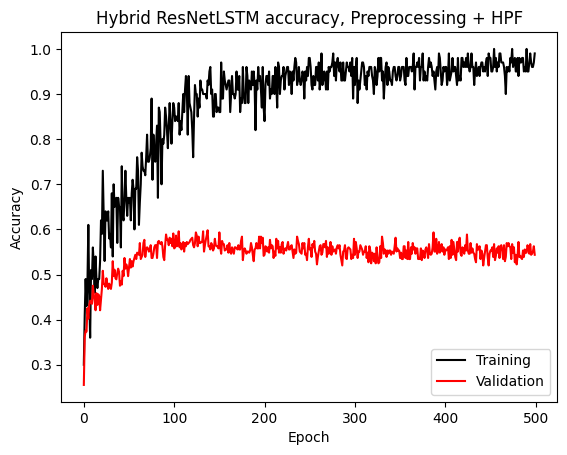

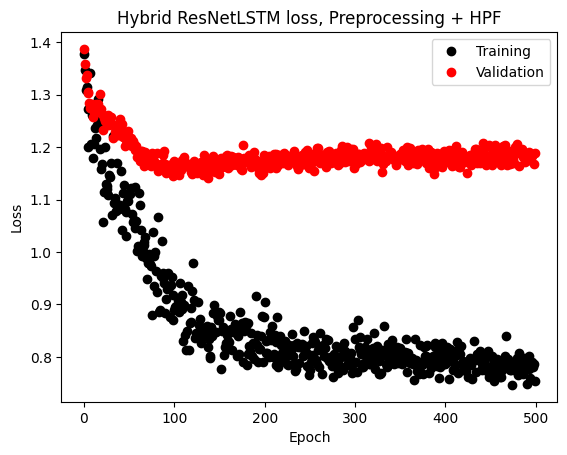

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_4,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_4,label='Validation',color='r')
plt.title('Hybrid ResNetLSTM accuracy, Preprocessing + HPF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_4,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_4,'o',label='Validation',color='r')
plt.title('Hybrid ResNetLSTM loss, Preprocessing + HPF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 5: Bandpass filter after Preprocessing

In [23]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [24]:
# Define the band-pass filter parameters
cutoff_frequency = np.array([4, 40])  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth band-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='band', analog=False, output='ba')

x_train_bpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_bpf[i,0,j,:] = filtered_data

x_train_bpf = torch.tensor(x_train_bpf).float().to(device)
print(x_train_bpf.shape)

torch.Size([6768, 1, 22, 400])


In [25]:
#Build the model
model5 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model5)
total_params = sum(p.numel() for p in model5.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model5.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_5, val_history_5 = np.array([]), np.array([])
train_loss_hist_5, val_loss_hist_5 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model5_params.pt')
    torch.save(model5.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model5.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model5(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model5.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model5(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_5 = np.append(train_history_5, train_acc.item())
        val_history_5 = np.append(val_history_5, val_acc.item())
        train_loss_hist_5 = np.append(train_loss_hist_5, loss.item())
        val_loss_hist_5 = np.append(val_loss_hist_5, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model5.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-10-420a849ec505>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:09<1:21:58,  9.86s/it]

Epoch 1 Finished!!!
Train acc: 0.250, Val acc: 0.272
Train loss: 1.383, Val loss: 1.383


  0%|          | 2/500 [00:12<47:17,  5.70s/it]  

Epoch 2 Finished!!!
Train acc: 0.480, Val acc: 0.378
Train loss: 1.340, Val loss: 1.354


  1%|          | 3/500 [00:15<36:11,  4.37s/it]

Epoch 3 Finished!!!
Train acc: 0.390, Val acc: 0.404
Train loss: 1.342, Val loss: 1.330


  1%|          | 4/500 [00:18<30:57,  3.74s/it]

Epoch 4 Finished!!!
Train acc: 0.420, Val acc: 0.409
Train loss: 1.290, Val loss: 1.305


  1%|          | 5/500 [00:21<28:02,  3.40s/it]

Epoch 5 Finished!!!
Train acc: 0.510, Val acc: 0.435
Train loss: 1.256, Val loss: 1.283


  1%|          | 6/500 [00:23<26:17,  3.19s/it]

Epoch 6 Finished!!!
Train acc: 0.460, Val acc: 0.440
Train loss: 1.261, Val loss: 1.283


  1%|▏         | 7/500 [00:26<25:06,  3.06s/it]

Epoch 7 Finished!!!
Train acc: 0.520, Val acc: 0.421
Train loss: 1.229, Val loss: 1.286


  2%|▏         | 8/500 [00:29<24:24,  2.98s/it]

Epoch 8 Finished!!!
Train acc: 0.520, Val acc: 0.444
Train loss: 1.213, Val loss: 1.277


  2%|▏         | 9/500 [00:32<23:52,  2.92s/it]

Epoch 9 Finished!!!
Train acc: 0.520, Val acc: 0.442
Train loss: 1.251, Val loss: 1.286


  2%|▏         | 10/500 [00:34<23:30,  2.88s/it]

Epoch 10 Finished!!!
Train acc: 0.520, Val acc: 0.428
Train loss: 1.231, Val loss: 1.274


  2%|▏         | 11/500 [00:37<23:15,  2.85s/it]

Epoch 11 Finished!!!
Train acc: 0.550, Val acc: 0.416
Train loss: 1.183, Val loss: 1.285


  2%|▏         | 12/500 [00:40<23:10,  2.85s/it]

Epoch 12 Finished!!!
Train acc: 0.530, Val acc: 0.461
Train loss: 1.237, Val loss: 1.270


  3%|▎         | 13/500 [00:43<23:00,  2.84s/it]

Epoch 13 Finished!!!
Train acc: 0.480, Val acc: 0.430
Train loss: 1.244, Val loss: 1.279


  3%|▎         | 14/500 [00:46<22:54,  2.83s/it]

Epoch 14 Finished!!!
Train acc: 0.440, Val acc: 0.435
Train loss: 1.230, Val loss: 1.267


  3%|▎         | 15/500 [00:49<22:50,  2.82s/it]

Epoch 15 Finished!!!
Train acc: 0.570, Val acc: 0.452
Train loss: 1.191, Val loss: 1.260


  3%|▎         | 16/500 [00:51<22:46,  2.82s/it]

Epoch 16 Finished!!!
Train acc: 0.550, Val acc: 0.440
Train loss: 1.204, Val loss: 1.263


  3%|▎         | 17/500 [00:54<22:46,  2.83s/it]

Epoch 17 Finished!!!
Train acc: 0.570, Val acc: 0.442
Train loss: 1.194, Val loss: 1.268


  4%|▎         | 18/500 [00:57<22:43,  2.83s/it]

Epoch 18 Finished!!!
Train acc: 0.610, Val acc: 0.456
Train loss: 1.171, Val loss: 1.262


  4%|▍         | 19/500 [01:00<22:46,  2.84s/it]

Epoch 19 Finished!!!
Train acc: 0.550, Val acc: 0.463
Train loss: 1.198, Val loss: 1.261


  4%|▍         | 20/500 [01:03<22:42,  2.84s/it]

Epoch 20 Finished!!!
Train acc: 0.540, Val acc: 0.459
Train loss: 1.205, Val loss: 1.254


  4%|▍         | 21/500 [01:06<22:40,  2.84s/it]

Epoch 21 Finished!!!
Train acc: 0.670, Val acc: 0.442
Train loss: 1.093, Val loss: 1.261


  4%|▍         | 22/500 [01:08<22:43,  2.85s/it]

Epoch 22 Finished!!!
Train acc: 0.500, Val acc: 0.475
Train loss: 1.203, Val loss: 1.253


  5%|▍         | 23/500 [01:11<22:39,  2.85s/it]

Epoch 23 Finished!!!
Train acc: 0.510, Val acc: 0.466
Train loss: 1.216, Val loss: 1.250


  5%|▍         | 24/500 [01:14<22:37,  2.85s/it]

Epoch 24 Finished!!!
Train acc: 0.550, Val acc: 0.440
Train loss: 1.212, Val loss: 1.257


  5%|▌         | 25/500 [01:17<22:38,  2.86s/it]

Epoch 25 Finished!!!
Train acc: 0.500, Val acc: 0.487
Train loss: 1.209, Val loss: 1.235


  5%|▌         | 26/500 [01:20<22:35,  2.86s/it]

Epoch 26 Finished!!!
Train acc: 0.630, Val acc: 0.449
Train loss: 1.137, Val loss: 1.259


  5%|▌         | 27/500 [01:23<22:33,  2.86s/it]

Epoch 27 Finished!!!
Train acc: 0.550, Val acc: 0.480
Train loss: 1.181, Val loss: 1.242


  6%|▌         | 28/500 [01:26<22:31,  2.86s/it]

Epoch 28 Finished!!!
Train acc: 0.640, Val acc: 0.466
Train loss: 1.119, Val loss: 1.245


  6%|▌         | 29/500 [01:28<22:30,  2.87s/it]

Epoch 29 Finished!!!
Train acc: 0.680, Val acc: 0.463
Train loss: 1.073, Val loss: 1.256


  6%|▌         | 30/500 [01:31<22:29,  2.87s/it]

Epoch 30 Finished!!!
Train acc: 0.530, Val acc: 0.468
Train loss: 1.194, Val loss: 1.250


  6%|▌         | 31/500 [01:34<22:28,  2.87s/it]

Epoch 31 Finished!!!
Train acc: 0.530, Val acc: 0.454
Train loss: 1.189, Val loss: 1.253


  6%|▋         | 32/500 [01:37<22:26,  2.88s/it]

Epoch 32 Finished!!!
Train acc: 0.460, Val acc: 0.463
Train loss: 1.240, Val loss: 1.249


  7%|▋         | 33/500 [01:40<22:25,  2.88s/it]

Epoch 33 Finished!!!
Train acc: 0.650, Val acc: 0.452
Train loss: 1.108, Val loss: 1.258


  7%|▋         | 34/500 [01:43<22:23,  2.88s/it]

Epoch 34 Finished!!!
Train acc: 0.620, Val acc: 0.456
Train loss: 1.128, Val loss: 1.255


  7%|▋         | 35/500 [01:46<22:23,  2.89s/it]

Epoch 35 Finished!!!
Train acc: 0.650, Val acc: 0.452
Train loss: 1.122, Val loss: 1.261


  7%|▋         | 36/500 [01:49<22:23,  2.90s/it]

Epoch 36 Finished!!!
Train acc: 0.610, Val acc: 0.499
Train loss: 1.135, Val loss: 1.230


  7%|▋         | 37/500 [01:52<22:39,  2.94s/it]

Epoch 37 Finished!!!
Train acc: 0.570, Val acc: 0.470
Train loss: 1.156, Val loss: 1.245


  8%|▊         | 38/500 [01:55<22:32,  2.93s/it]

Epoch 38 Finished!!!
Train acc: 0.670, Val acc: 0.489
Train loss: 1.105, Val loss: 1.238


  8%|▊         | 39/500 [01:58<22:27,  2.92s/it]

Epoch 39 Finished!!!
Train acc: 0.600, Val acc: 0.489
Train loss: 1.159, Val loss: 1.237


  8%|▊         | 40/500 [02:00<22:22,  2.92s/it]

Epoch 40 Finished!!!
Train acc: 0.610, Val acc: 0.492
Train loss: 1.135, Val loss: 1.233


  8%|▊         | 41/500 [02:03<22:19,  2.92s/it]

Epoch 41 Finished!!!
Train acc: 0.650, Val acc: 0.473
Train loss: 1.107, Val loss: 1.245


  8%|▊         | 42/500 [02:06<22:15,  2.92s/it]

Epoch 42 Finished!!!
Train acc: 0.590, Val acc: 0.478
Train loss: 1.156, Val loss: 1.246


  9%|▊         | 43/500 [02:09<22:13,  2.92s/it]

Epoch 43 Finished!!!
Train acc: 0.670, Val acc: 0.478
Train loss: 1.095, Val loss: 1.243


  9%|▉         | 44/500 [02:12<22:13,  2.92s/it]

Epoch 44 Finished!!!
Train acc: 0.680, Val acc: 0.504
Train loss: 1.066, Val loss: 1.233


  9%|▉         | 45/500 [02:15<22:10,  2.92s/it]

Epoch 45 Finished!!!
Train acc: 0.660, Val acc: 0.489
Train loss: 1.093, Val loss: 1.239


  9%|▉         | 46/500 [02:18<22:07,  2.92s/it]

Epoch 46 Finished!!!
Train acc: 0.610, Val acc: 0.473
Train loss: 1.135, Val loss: 1.243


  9%|▉         | 47/500 [02:21<22:05,  2.93s/it]

Epoch 47 Finished!!!
Train acc: 0.560, Val acc: 0.485
Train loss: 1.158, Val loss: 1.241


 10%|▉         | 48/500 [02:24<22:04,  2.93s/it]

Epoch 48 Finished!!!
Train acc: 0.640, Val acc: 0.489
Train loss: 1.130, Val loss: 1.247


 10%|▉         | 49/500 [02:27<22:01,  2.93s/it]

Epoch 49 Finished!!!
Train acc: 0.640, Val acc: 0.475
Train loss: 1.107, Val loss: 1.242


 10%|█         | 50/500 [02:30<21:59,  2.93s/it]

Epoch 50 Finished!!!
Train acc: 0.680, Val acc: 0.468
Train loss: 1.089, Val loss: 1.251


 10%|█         | 51/500 [02:33<21:56,  2.93s/it]

Epoch 51 Finished!!!
Train acc: 0.670, Val acc: 0.489
Train loss: 1.092, Val loss: 1.237


 10%|█         | 52/500 [02:36<21:54,  2.93s/it]

Epoch 52 Finished!!!
Train acc: 0.660, Val acc: 0.478
Train loss: 1.084, Val loss: 1.251


 11%|█         | 53/500 [02:39<21:53,  2.94s/it]

Epoch 53 Finished!!!
Train acc: 0.600, Val acc: 0.461
Train loss: 1.147, Val loss: 1.252


 11%|█         | 54/500 [02:42<22:01,  2.96s/it]

Epoch 54 Finished!!!
Train acc: 0.750, Val acc: 0.499
Train loss: 1.038, Val loss: 1.236


 11%|█         | 55/500 [02:45<22:15,  3.00s/it]

Epoch 55 Finished!!!
Train acc: 0.690, Val acc: 0.485
Train loss: 1.076, Val loss: 1.236


 11%|█         | 56/500 [02:48<23:59,  3.24s/it]

Epoch 56 Finished!!!
Train acc: 0.700, Val acc: 0.504
Train loss: 1.065, Val loss: 1.237


 11%|█▏        | 57/500 [02:52<24:08,  3.27s/it]

Epoch 57 Finished!!!
Train acc: 0.700, Val acc: 0.487
Train loss: 1.074, Val loss: 1.236


 12%|█▏        | 58/500 [02:55<23:47,  3.23s/it]

Epoch 58 Finished!!!
Train acc: 0.660, Val acc: 0.494
Train loss: 1.086, Val loss: 1.243


 12%|█▏        | 59/500 [02:58<23:09,  3.15s/it]

Epoch 59 Finished!!!
Train acc: 0.600, Val acc: 0.513
Train loss: 1.119, Val loss: 1.225


 12%|█▏        | 60/500 [03:01<22:40,  3.09s/it]

Epoch 60 Finished!!!
Train acc: 0.630, Val acc: 0.489
Train loss: 1.115, Val loss: 1.244


 12%|█▏        | 61/500 [03:04<22:19,  3.05s/it]

Epoch 61 Finished!!!
Train acc: 0.730, Val acc: 0.480
Train loss: 1.048, Val loss: 1.239


 12%|█▏        | 62/500 [03:07<22:03,  3.02s/it]

Epoch 62 Finished!!!
Train acc: 0.630, Val acc: 0.489
Train loss: 1.109, Val loss: 1.239


 13%|█▎        | 63/500 [03:10<21:52,  3.00s/it]

Epoch 63 Finished!!!
Train acc: 0.670, Val acc: 0.482
Train loss: 1.081, Val loss: 1.247


 13%|█▎        | 64/500 [03:13<21:44,  2.99s/it]

Epoch 64 Finished!!!
Train acc: 0.680, Val acc: 0.470
Train loss: 1.067, Val loss: 1.239


 13%|█▎        | 65/500 [03:16<21:41,  2.99s/it]

Epoch 65 Finished!!!
Train acc: 0.690, Val acc: 0.494
Train loss: 1.093, Val loss: 1.236


 13%|█▎        | 66/500 [03:19<21:36,  2.99s/it]

Epoch 66 Finished!!!
Train acc: 0.740, Val acc: 0.487
Train loss: 1.022, Val loss: 1.234


 13%|█▎        | 67/500 [03:22<21:30,  2.98s/it]

Epoch 67 Finished!!!
Train acc: 0.640, Val acc: 0.485
Train loss: 1.107, Val loss: 1.235


 14%|█▎        | 68/500 [03:25<21:25,  2.98s/it]

Epoch 68 Finished!!!
Train acc: 0.760, Val acc: 0.494
Train loss: 1.020, Val loss: 1.236


 14%|█▍        | 69/500 [03:28<21:22,  2.98s/it]

Epoch 69 Finished!!!
Train acc: 0.670, Val acc: 0.475
Train loss: 1.061, Val loss: 1.246


 14%|█▍        | 70/500 [03:31<21:19,  2.98s/it]

Epoch 70 Finished!!!
Train acc: 0.760, Val acc: 0.513
Train loss: 0.994, Val loss: 1.227


 14%|█▍        | 71/500 [03:34<21:16,  2.98s/it]

Epoch 71 Finished!!!
Train acc: 0.750, Val acc: 0.480
Train loss: 1.016, Val loss: 1.241


 14%|█▍        | 72/500 [03:37<21:13,  2.98s/it]

Epoch 72 Finished!!!
Train acc: 0.660, Val acc: 0.489
Train loss: 1.083, Val loss: 1.235


 15%|█▍        | 73/500 [03:39<21:10,  2.98s/it]

Epoch 73 Finished!!!
Train acc: 0.710, Val acc: 0.473
Train loss: 1.044, Val loss: 1.247


 15%|█▍        | 74/500 [03:42<21:08,  2.98s/it]

Epoch 74 Finished!!!
Train acc: 0.720, Val acc: 0.485
Train loss: 1.036, Val loss: 1.237


 15%|█▌        | 75/500 [03:45<21:06,  2.98s/it]

Epoch 75 Finished!!!
Train acc: 0.750, Val acc: 0.506
Train loss: 1.018, Val loss: 1.219


 15%|█▌        | 76/500 [03:48<21:03,  2.98s/it]

Epoch 76 Finished!!!
Train acc: 0.630, Val acc: 0.482
Train loss: 1.100, Val loss: 1.234


 15%|█▌        | 77/500 [03:51<21:00,  2.98s/it]

Epoch 77 Finished!!!
Train acc: 0.790, Val acc: 0.501
Train loss: 0.957, Val loss: 1.220


 16%|█▌        | 78/500 [03:54<20:58,  2.98s/it]

Epoch 78 Finished!!!
Train acc: 0.670, Val acc: 0.489
Train loss: 1.078, Val loss: 1.227


 16%|█▌        | 79/500 [03:57<20:57,  2.99s/it]

Epoch 79 Finished!!!
Train acc: 0.770, Val acc: 0.504
Train loss: 0.992, Val loss: 1.228


 16%|█▌        | 80/500 [04:00<20:54,  2.99s/it]

Epoch 80 Finished!!!
Train acc: 0.710, Val acc: 0.496
Train loss: 1.057, Val loss: 1.223


 16%|█▌        | 81/500 [04:03<20:52,  2.99s/it]

Epoch 81 Finished!!!
Train acc: 0.780, Val acc: 0.506
Train loss: 0.994, Val loss: 1.224


 16%|█▋        | 82/500 [04:06<20:50,  2.99s/it]

Epoch 82 Finished!!!
Train acc: 0.690, Val acc: 0.506
Train loss: 1.050, Val loss: 1.224


 17%|█▋        | 83/500 [04:09<20:48,  2.99s/it]

Epoch 83 Finished!!!
Train acc: 0.690, Val acc: 0.496
Train loss: 1.054, Val loss: 1.225


 17%|█▋        | 84/500 [04:12<20:45,  2.99s/it]

Epoch 84 Finished!!!
Train acc: 0.750, Val acc: 0.508
Train loss: 1.008, Val loss: 1.220


 17%|█▋        | 85/500 [04:15<20:42,  2.99s/it]

Epoch 85 Finished!!!
Train acc: 0.800, Val acc: 0.511
Train loss: 0.957, Val loss: 1.219


 17%|█▋        | 86/500 [04:18<20:39,  2.99s/it]

Epoch 86 Finished!!!
Train acc: 0.810, Val acc: 0.496
Train loss: 0.941, Val loss: 1.225


 17%|█▋        | 87/500 [04:21<20:40,  3.00s/it]

Epoch 87 Finished!!!
Train acc: 0.790, Val acc: 0.515
Train loss: 0.970, Val loss: 1.212


 18%|█▊        | 88/500 [04:24<20:38,  3.01s/it]

Epoch 88 Finished!!!
Train acc: 0.730, Val acc: 0.527
Train loss: 1.033, Val loss: 1.206


 18%|█▊        | 89/500 [04:27<20:34,  3.00s/it]

Epoch 89 Finished!!!
Train acc: 0.790, Val acc: 0.508
Train loss: 0.983, Val loss: 1.216


 18%|█▊        | 90/500 [04:30<20:30,  3.00s/it]

Epoch 90 Finished!!!
Train acc: 0.650, Val acc: 0.515
Train loss: 1.076, Val loss: 1.214


 18%|█▊        | 91/500 [04:34<20:52,  3.06s/it]

Epoch 91 Finished!!!
Train acc: 0.780, Val acc: 0.501
Train loss: 0.976, Val loss: 1.222


 18%|█▊        | 92/500 [04:37<20:44,  3.05s/it]

Epoch 92 Finished!!!
Train acc: 0.720, Val acc: 0.530
Train loss: 1.037, Val loss: 1.206


 19%|█▊        | 93/500 [04:40<20:35,  3.04s/it]

Epoch 93 Finished!!!
Train acc: 0.790, Val acc: 0.501
Train loss: 0.955, Val loss: 1.227


 19%|█▉        | 94/500 [04:43<20:28,  3.03s/it]

Epoch 94 Finished!!!
Train acc: 0.820, Val acc: 0.520
Train loss: 0.950, Val loss: 1.215


 19%|█▉        | 95/500 [04:46<20:23,  3.02s/it]

Epoch 95 Finished!!!
Train acc: 0.810, Val acc: 0.513
Train loss: 0.969, Val loss: 1.209


 19%|█▉        | 96/500 [04:49<20:19,  3.02s/it]

Epoch 96 Finished!!!
Train acc: 0.800, Val acc: 0.489
Train loss: 0.961, Val loss: 1.230


 19%|█▉        | 97/500 [04:52<20:15,  3.02s/it]

Epoch 97 Finished!!!
Train acc: 0.800, Val acc: 0.492
Train loss: 0.956, Val loss: 1.232


 20%|█▉        | 98/500 [04:55<20:11,  3.01s/it]

Epoch 98 Finished!!!
Train acc: 0.740, Val acc: 0.506
Train loss: 1.010, Val loss: 1.220


 20%|█▉        | 99/500 [04:58<20:08,  3.01s/it]

Epoch 99 Finished!!!
Train acc: 0.830, Val acc: 0.499
Train loss: 0.939, Val loss: 1.226


 20%|██        | 100/500 [05:01<20:05,  3.01s/it]

Epoch 100 Finished!!!
Train acc: 0.690, Val acc: 0.501
Train loss: 1.031, Val loss: 1.219


 20%|██        | 101/500 [05:04<20:01,  3.01s/it]

Epoch 101 Finished!!!
Train acc: 0.740, Val acc: 0.518
Train loss: 0.997, Val loss: 1.207


 20%|██        | 102/500 [05:07<19:59,  3.01s/it]

Epoch 102 Finished!!!
Train acc: 0.740, Val acc: 0.515
Train loss: 1.011, Val loss: 1.205


 21%|██        | 103/500 [05:10<19:56,  3.01s/it]

Epoch 103 Finished!!!
Train acc: 0.830, Val acc: 0.506
Train loss: 0.942, Val loss: 1.216


 21%|██        | 104/500 [05:13<19:54,  3.02s/it]

Epoch 104 Finished!!!
Train acc: 0.810, Val acc: 0.518
Train loss: 0.950, Val loss: 1.206


 21%|██        | 105/500 [05:16<19:50,  3.01s/it]

Epoch 105 Finished!!!
Train acc: 0.800, Val acc: 0.515
Train loss: 0.952, Val loss: 1.215


 21%|██        | 106/500 [05:19<19:48,  3.02s/it]

Epoch 106 Finished!!!
Train acc: 0.810, Val acc: 0.513
Train loss: 0.950, Val loss: 1.215


 21%|██▏       | 107/500 [05:22<19:48,  3.02s/it]

Epoch 107 Finished!!!
Train acc: 0.850, Val acc: 0.532
Train loss: 0.921, Val loss: 1.204


 22%|██▏       | 108/500 [05:25<19:45,  3.02s/it]

Epoch 108 Finished!!!
Train acc: 0.840, Val acc: 0.520
Train loss: 0.919, Val loss: 1.214


 22%|██▏       | 109/500 [05:28<19:41,  3.02s/it]

Epoch 109 Finished!!!
Train acc: 0.810, Val acc: 0.518
Train loss: 0.923, Val loss: 1.212


 22%|██▏       | 110/500 [05:31<19:40,  3.03s/it]

Epoch 110 Finished!!!
Train acc: 0.830, Val acc: 0.539
Train loss: 0.928, Val loss: 1.202


 22%|██▏       | 111/500 [05:34<19:36,  3.02s/it]

Epoch 111 Finished!!!
Train acc: 0.840, Val acc: 0.539
Train loss: 0.897, Val loss: 1.195


 22%|██▏       | 112/500 [05:37<19:34,  3.03s/it]

Epoch 112 Finished!!!
Train acc: 0.800, Val acc: 0.515
Train loss: 0.949, Val loss: 1.211


 23%|██▎       | 113/500 [05:40<19:31,  3.03s/it]

Epoch 113 Finished!!!
Train acc: 0.850, Val acc: 0.522
Train loss: 0.910, Val loss: 1.196


 23%|██▎       | 114/500 [05:43<19:27,  3.03s/it]

Epoch 114 Finished!!!
Train acc: 0.770, Val acc: 0.520
Train loss: 0.986, Val loss: 1.206


 23%|██▎       | 115/500 [05:46<19:24,  3.03s/it]

Epoch 115 Finished!!!
Train acc: 0.810, Val acc: 0.532
Train loss: 0.931, Val loss: 1.200


 23%|██▎       | 116/500 [05:49<19:24,  3.03s/it]

Epoch 116 Finished!!!
Train acc: 0.800, Val acc: 0.544
Train loss: 0.952, Val loss: 1.192


 23%|██▎       | 117/500 [05:52<19:19,  3.03s/it]

Epoch 117 Finished!!!
Train acc: 0.890, Val acc: 0.522
Train loss: 0.859, Val loss: 1.194


 24%|██▎       | 118/500 [05:55<19:16,  3.03s/it]

Epoch 118 Finished!!!
Train acc: 0.840, Val acc: 0.501
Train loss: 0.910, Val loss: 1.225


 24%|██▍       | 119/500 [05:58<19:13,  3.03s/it]

Epoch 119 Finished!!!
Train acc: 0.890, Val acc: 0.530
Train loss: 0.878, Val loss: 1.203


 24%|██▍       | 120/500 [06:01<19:14,  3.04s/it]

Epoch 120 Finished!!!
Train acc: 0.810, Val acc: 0.548
Train loss: 0.936, Val loss: 1.188


 24%|██▍       | 121/500 [06:04<19:09,  3.03s/it]

Epoch 121 Finished!!!
Train acc: 0.890, Val acc: 0.546
Train loss: 0.869, Val loss: 1.187


 24%|██▍       | 122/500 [06:07<19:05,  3.03s/it]

Epoch 122 Finished!!!
Train acc: 0.880, Val acc: 0.539
Train loss: 0.899, Val loss: 1.195


 25%|██▍       | 123/500 [06:10<19:01,  3.03s/it]

Epoch 123 Finished!!!
Train acc: 0.870, Val acc: 0.518
Train loss: 0.886, Val loss: 1.213


 25%|██▍       | 124/500 [06:13<18:58,  3.03s/it]

Epoch 124 Finished!!!
Train acc: 0.810, Val acc: 0.525
Train loss: 0.934, Val loss: 1.203


 25%|██▌       | 125/500 [06:16<18:58,  3.03s/it]

Epoch 125 Finished!!!
Train acc: 0.850, Val acc: 0.558
Train loss: 0.905, Val loss: 1.186


 25%|██▌       | 126/500 [06:19<18:59,  3.05s/it]

Epoch 126 Finished!!!
Train acc: 0.870, Val acc: 0.548
Train loss: 0.894, Val loss: 1.184


 25%|██▌       | 127/500 [06:23<18:58,  3.05s/it]

Epoch 127 Finished!!!
Train acc: 0.870, Val acc: 0.539
Train loss: 0.875, Val loss: 1.186


 26%|██▌       | 128/500 [06:26<18:52,  3.04s/it]

Epoch 128 Finished!!!
Train acc: 0.800, Val acc: 0.546
Train loss: 0.950, Val loss: 1.184


 26%|██▌       | 129/500 [06:29<18:47,  3.04s/it]

Epoch 129 Finished!!!
Train acc: 0.820, Val acc: 0.541
Train loss: 0.937, Val loss: 1.187


 26%|██▌       | 130/500 [06:32<18:43,  3.04s/it]

Epoch 130 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.874, Val loss: 1.182


 26%|██▌       | 131/500 [06:35<18:39,  3.03s/it]

Epoch 131 Finished!!!
Train acc: 0.910, Val acc: 0.548
Train loss: 0.849, Val loss: 1.180


 26%|██▋       | 132/500 [06:38<18:35,  3.03s/it]

Epoch 132 Finished!!!
Train acc: 0.870, Val acc: 0.546
Train loss: 0.872, Val loss: 1.188


 27%|██▋       | 133/500 [06:41<18:33,  3.03s/it]

Epoch 133 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.842, Val loss: 1.199


 27%|██▋       | 134/500 [06:44<18:30,  3.03s/it]

Epoch 134 Finished!!!
Train acc: 0.870, Val acc: 0.525
Train loss: 0.887, Val loss: 1.199


 27%|██▋       | 135/500 [06:47<18:26,  3.03s/it]

Epoch 135 Finished!!!
Train acc: 0.870, Val acc: 0.527
Train loss: 0.882, Val loss: 1.201


 27%|██▋       | 136/500 [06:50<18:22,  3.03s/it]

Epoch 136 Finished!!!
Train acc: 0.840, Val acc: 0.546
Train loss: 0.925, Val loss: 1.187


 27%|██▋       | 137/500 [06:53<18:19,  3.03s/it]

Epoch 137 Finished!!!
Train acc: 0.850, Val acc: 0.551
Train loss: 0.903, Val loss: 1.182


 28%|██▊       | 138/500 [06:56<18:19,  3.04s/it]

Epoch 138 Finished!!!
Train acc: 0.860, Val acc: 0.560
Train loss: 0.900, Val loss: 1.177


 28%|██▊       | 139/500 [06:59<18:17,  3.04s/it]

Epoch 139 Finished!!!
Train acc: 0.860, Val acc: 0.572
Train loss: 0.894, Val loss: 1.165


 28%|██▊       | 140/500 [07:02<18:12,  3.03s/it]

Epoch 140 Finished!!!
Train acc: 0.820, Val acc: 0.527
Train loss: 0.942, Val loss: 1.201


 28%|██▊       | 141/500 [07:05<18:08,  3.03s/it]

Epoch 141 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.840, Val loss: 1.187


 28%|██▊       | 142/500 [07:08<18:05,  3.03s/it]

Epoch 142 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.837, Val loss: 1.196


 29%|██▊       | 143/500 [07:11<18:01,  3.03s/it]

Epoch 143 Finished!!!
Train acc: 0.900, Val acc: 0.534
Train loss: 0.856, Val loss: 1.195


 29%|██▉       | 144/500 [07:14<17:58,  3.03s/it]

Epoch 144 Finished!!!
Train acc: 0.880, Val acc: 0.541
Train loss: 0.870, Val loss: 1.187


 29%|██▉       | 145/500 [07:17<17:55,  3.03s/it]

Epoch 145 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.829, Val loss: 1.179


 29%|██▉       | 146/500 [07:20<17:52,  3.03s/it]

Epoch 146 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.845, Val loss: 1.190


 29%|██▉       | 147/500 [07:23<17:49,  3.03s/it]

Epoch 147 Finished!!!
Train acc: 0.810, Val acc: 0.551
Train loss: 0.929, Val loss: 1.187


 30%|██▉       | 148/500 [07:26<17:45,  3.03s/it]

Epoch 148 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.869, Val loss: 1.177


 30%|██▉       | 149/500 [07:29<17:42,  3.03s/it]

Epoch 149 Finished!!!
Train acc: 0.790, Val acc: 0.527
Train loss: 0.958, Val loss: 1.201


 30%|███       | 150/500 [07:32<17:39,  3.03s/it]

Epoch 150 Finished!!!
Train acc: 0.900, Val acc: 0.532
Train loss: 0.860, Val loss: 1.192


 30%|███       | 151/500 [07:35<17:36,  3.03s/it]

Epoch 151 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.837, Val loss: 1.171


 30%|███       | 152/500 [07:38<17:33,  3.03s/it]

Epoch 152 Finished!!!
Train acc: 0.880, Val acc: 0.560
Train loss: 0.863, Val loss: 1.174


 31%|███       | 153/500 [07:41<17:29,  3.02s/it]

Epoch 153 Finished!!!
Train acc: 0.910, Val acc: 0.551
Train loss: 0.855, Val loss: 1.175


 31%|███       | 154/500 [07:44<17:27,  3.03s/it]

Epoch 154 Finished!!!
Train acc: 0.870, Val acc: 0.553
Train loss: 0.877, Val loss: 1.176


 31%|███       | 155/500 [07:47<17:24,  3.03s/it]

Epoch 155 Finished!!!
Train acc: 0.900, Val acc: 0.572
Train loss: 0.852, Val loss: 1.170


 31%|███       | 156/500 [07:50<17:20,  3.03s/it]

Epoch 156 Finished!!!
Train acc: 0.860, Val acc: 0.563
Train loss: 0.893, Val loss: 1.173


 31%|███▏      | 157/500 [07:53<17:17,  3.03s/it]

Epoch 157 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.839, Val loss: 1.190


 32%|███▏      | 158/500 [07:56<17:14,  3.03s/it]

Epoch 158 Finished!!!
Train acc: 0.910, Val acc: 0.532
Train loss: 0.847, Val loss: 1.202


 32%|███▏      | 159/500 [07:59<17:12,  3.03s/it]

Epoch 159 Finished!!!
Train acc: 0.890, Val acc: 0.558
Train loss: 0.864, Val loss: 1.181


 32%|███▏      | 160/500 [08:02<17:09,  3.03s/it]

Epoch 160 Finished!!!
Train acc: 0.900, Val acc: 0.544
Train loss: 0.858, Val loss: 1.186


 32%|███▏      | 161/500 [08:05<17:06,  3.03s/it]

Epoch 161 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.833, Val loss: 1.203


 32%|███▏      | 162/500 [08:09<17:02,  3.03s/it]

Epoch 162 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.818, Val loss: 1.182


 33%|███▎      | 163/500 [08:12<17:00,  3.03s/it]

Epoch 163 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.845, Val loss: 1.195


 33%|███▎      | 164/500 [08:15<16:56,  3.03s/it]

Epoch 164 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.813, Val loss: 1.171


 33%|███▎      | 165/500 [08:18<16:53,  3.03s/it]

Epoch 165 Finished!!!
Train acc: 0.870, Val acc: 0.556
Train loss: 0.887, Val loss: 1.181


 33%|███▎      | 166/500 [08:21<16:50,  3.03s/it]

Epoch 166 Finished!!!
Train acc: 0.920, Val acc: 0.534
Train loss: 0.827, Val loss: 1.196


 33%|███▎      | 167/500 [08:24<16:47,  3.03s/it]

Epoch 167 Finished!!!
Train acc: 0.890, Val acc: 0.558
Train loss: 0.862, Val loss: 1.183


 34%|███▎      | 168/500 [08:27<16:44,  3.03s/it]

Epoch 168 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.834, Val loss: 1.179


 34%|███▍      | 169/500 [08:30<16:41,  3.03s/it]

Epoch 169 Finished!!!
Train acc: 0.800, Val acc: 0.546
Train loss: 0.949, Val loss: 1.186


 34%|███▍      | 170/500 [08:33<16:38,  3.02s/it]

Epoch 170 Finished!!!
Train acc: 0.860, Val acc: 0.556
Train loss: 0.888, Val loss: 1.182


 34%|███▍      | 171/500 [08:36<16:35,  3.03s/it]

Epoch 171 Finished!!!
Train acc: 0.880, Val acc: 0.551
Train loss: 0.870, Val loss: 1.174


 34%|███▍      | 172/500 [08:39<16:32,  3.03s/it]

Epoch 172 Finished!!!
Train acc: 0.870, Val acc: 0.563
Train loss: 0.871, Val loss: 1.170


 35%|███▍      | 173/500 [08:42<16:29,  3.03s/it]

Epoch 173 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.847, Val loss: 1.179


 35%|███▍      | 174/500 [08:45<16:25,  3.02s/it]

Epoch 174 Finished!!!
Train acc: 0.900, Val acc: 0.553
Train loss: 0.854, Val loss: 1.182


 35%|███▌      | 175/500 [08:48<16:22,  3.02s/it]

Epoch 175 Finished!!!
Train acc: 0.900, Val acc: 0.572
Train loss: 0.849, Val loss: 1.159


 35%|███▌      | 176/500 [08:51<16:20,  3.03s/it]

Epoch 176 Finished!!!
Train acc: 0.890, Val acc: 0.556
Train loss: 0.860, Val loss: 1.177


 35%|███▌      | 177/500 [08:54<16:16,  3.02s/it]

Epoch 177 Finished!!!
Train acc: 0.830, Val acc: 0.544
Train loss: 0.912, Val loss: 1.183


 36%|███▌      | 178/500 [08:57<16:13,  3.02s/it]

Epoch 178 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.809, Val loss: 1.183


 36%|███▌      | 179/500 [09:00<16:10,  3.02s/it]

Epoch 179 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.848, Val loss: 1.195


 36%|███▌      | 180/500 [09:03<16:08,  3.03s/it]

Epoch 180 Finished!!!
Train acc: 0.920, Val acc: 0.546
Train loss: 0.829, Val loss: 1.183


 36%|███▌      | 181/500 [09:06<16:04,  3.02s/it]

Epoch 181 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.823, Val loss: 1.175


 36%|███▋      | 182/500 [09:09<16:01,  3.02s/it]

Epoch 182 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.799, Val loss: 1.179


 37%|███▋      | 183/500 [09:12<16:00,  3.03s/it]

Epoch 183 Finished!!!
Train acc: 0.900, Val acc: 0.574
Train loss: 0.846, Val loss: 1.166


 37%|███▋      | 184/500 [09:15<15:56,  3.03s/it]

Epoch 184 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.851, Val loss: 1.173


 37%|███▋      | 185/500 [09:18<15:53,  3.03s/it]

Epoch 185 Finished!!!
Train acc: 0.900, Val acc: 0.530
Train loss: 0.852, Val loss: 1.195


 37%|███▋      | 186/500 [09:21<15:50,  3.03s/it]

Epoch 186 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.868, Val loss: 1.183


 37%|███▋      | 187/500 [09:24<15:46,  3.02s/it]

Epoch 187 Finished!!!
Train acc: 0.890, Val acc: 0.572
Train loss: 0.861, Val loss: 1.163


 38%|███▊      | 188/500 [09:27<15:43,  3.03s/it]

Epoch 188 Finished!!!
Train acc: 0.880, Val acc: 0.572
Train loss: 0.865, Val loss: 1.160


 38%|███▊      | 189/500 [09:30<15:40,  3.02s/it]

Epoch 189 Finished!!!
Train acc: 0.880, Val acc: 0.537
Train loss: 0.875, Val loss: 1.188


 38%|███▊      | 190/500 [09:33<15:37,  3.02s/it]

Epoch 190 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.822, Val loss: 1.174


 38%|███▊      | 191/500 [09:36<15:34,  3.02s/it]

Epoch 191 Finished!!!
Train acc: 0.900, Val acc: 0.563
Train loss: 0.860, Val loss: 1.168


 38%|███▊      | 192/500 [09:39<15:31,  3.02s/it]

Epoch 192 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.865, Val loss: 1.167


 39%|███▊      | 193/500 [09:42<15:28,  3.02s/it]

Epoch 193 Finished!!!
Train acc: 0.910, Val acc: 0.551
Train loss: 0.835, Val loss: 1.182


 39%|███▉      | 194/500 [09:45<15:25,  3.02s/it]

Epoch 194 Finished!!!
Train acc: 0.910, Val acc: 0.567
Train loss: 0.837, Val loss: 1.169


 39%|███▉      | 195/500 [09:48<15:22,  3.02s/it]

Epoch 195 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.808, Val loss: 1.189


 39%|███▉      | 196/500 [09:51<15:19,  3.02s/it]

Epoch 196 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.813, Val loss: 1.181


 39%|███▉      | 197/500 [09:54<15:15,  3.02s/it]

Epoch 197 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.812, Val loss: 1.176


 40%|███▉      | 198/500 [09:57<15:12,  3.02s/it]

Epoch 198 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.809, Val loss: 1.168


 40%|███▉      | 199/500 [10:00<15:09,  3.02s/it]

Epoch 199 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.790, Val loss: 1.166


 40%|████      | 200/500 [10:03<15:06,  3.02s/it]

Epoch 200 Finished!!!
Train acc: 0.890, Val acc: 0.558
Train loss: 0.857, Val loss: 1.177


 40%|████      | 201/500 [10:06<15:03,  3.02s/it]

Epoch 201 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.807, Val loss: 1.182


 40%|████      | 202/500 [10:09<15:00,  3.02s/it]

Epoch 202 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.811, Val loss: 1.170


 41%|████      | 203/500 [10:13<14:57,  3.02s/it]

Epoch 203 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.834, Val loss: 1.172


 41%|████      | 204/500 [10:16<14:54,  3.02s/it]

Epoch 204 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.794, Val loss: 1.182


 41%|████      | 205/500 [10:19<14:52,  3.02s/it]

Epoch 205 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.807, Val loss: 1.179


 41%|████      | 206/500 [10:22<14:48,  3.02s/it]

Epoch 206 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.855, Val loss: 1.190


 41%|████▏     | 207/500 [10:25<14:45,  3.02s/it]

Epoch 207 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.836, Val loss: 1.181


 42%|████▏     | 208/500 [10:28<14:42,  3.02s/it]

Epoch 208 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.809, Val loss: 1.181


 42%|████▏     | 209/500 [10:31<14:39,  3.02s/it]

Epoch 209 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.827, Val loss: 1.171


 42%|████▏     | 210/500 [10:34<14:36,  3.02s/it]

Epoch 210 Finished!!!
Train acc: 0.910, Val acc: 0.548
Train loss: 0.846, Val loss: 1.176


 42%|████▏     | 211/500 [10:37<14:33,  3.02s/it]

Epoch 211 Finished!!!
Train acc: 0.910, Val acc: 0.544
Train loss: 0.840, Val loss: 1.180


 42%|████▏     | 212/500 [10:40<14:30,  3.02s/it]

Epoch 212 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.820, Val loss: 1.183


 43%|████▎     | 213/500 [10:43<14:28,  3.03s/it]

Epoch 213 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.829, Val loss: 1.175


 43%|████▎     | 214/500 [10:46<14:25,  3.03s/it]

Epoch 214 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.796, Val loss: 1.177


 43%|████▎     | 215/500 [10:49<14:22,  3.02s/it]

Epoch 215 Finished!!!
Train acc: 0.860, Val acc: 0.506
Train loss: 0.877, Val loss: 1.220


 43%|████▎     | 216/500 [10:52<14:18,  3.02s/it]

Epoch 216 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.817, Val loss: 1.187


 43%|████▎     | 217/500 [10:55<14:15,  3.02s/it]

Epoch 217 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.856, Val loss: 1.191


 44%|████▎     | 218/500 [10:58<14:13,  3.03s/it]

Epoch 218 Finished!!!
Train acc: 0.940, Val acc: 0.556
Train loss: 0.815, Val loss: 1.176


 44%|████▍     | 219/500 [11:01<14:09,  3.02s/it]

Epoch 219 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.805, Val loss: 1.174


 44%|████▍     | 220/500 [11:04<14:07,  3.03s/it]

Epoch 220 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.824, Val loss: 1.173


 44%|████▍     | 221/500 [11:07<14:04,  3.03s/it]

Epoch 221 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.800, Val loss: 1.198


 44%|████▍     | 222/500 [11:10<14:01,  3.03s/it]

Epoch 222 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.817, Val loss: 1.177


 45%|████▍     | 223/500 [11:13<13:58,  3.03s/it]

Epoch 223 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.791, Val loss: 1.188


 45%|████▍     | 224/500 [11:16<13:54,  3.02s/it]

Epoch 224 Finished!!!
Train acc: 0.880, Val acc: 0.551
Train loss: 0.865, Val loss: 1.175


 45%|████▌     | 225/500 [11:19<13:51,  3.02s/it]

Epoch 225 Finished!!!
Train acc: 0.920, Val acc: 0.534
Train loss: 0.827, Val loss: 1.190


 45%|████▌     | 226/500 [11:22<13:48,  3.03s/it]

Epoch 226 Finished!!!
Train acc: 0.910, Val acc: 0.567
Train loss: 0.828, Val loss: 1.165


 45%|████▌     | 227/500 [11:25<13:45,  3.02s/it]

Epoch 227 Finished!!!
Train acc: 0.880, Val acc: 0.546
Train loss: 0.861, Val loss: 1.179


 46%|████▌     | 228/500 [11:28<13:42,  3.02s/it]

Epoch 228 Finished!!!
Train acc: 0.900, Val acc: 0.544
Train loss: 0.843, Val loss: 1.182


 46%|████▌     | 229/500 [11:31<13:38,  3.02s/it]

Epoch 229 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.825, Val loss: 1.187


 46%|████▌     | 230/500 [11:34<13:35,  3.02s/it]

Epoch 230 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.807, Val loss: 1.164


 46%|████▌     | 231/500 [11:37<13:32,  3.02s/it]

Epoch 231 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.801, Val loss: 1.178


 46%|████▋     | 232/500 [11:40<13:29,  3.02s/it]

Epoch 232 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.829, Val loss: 1.181


 47%|████▋     | 233/500 [11:43<13:26,  3.02s/it]

Epoch 233 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.813, Val loss: 1.189


 47%|████▋     | 234/500 [11:46<13:23,  3.02s/it]

Epoch 234 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.840, Val loss: 1.181


 47%|████▋     | 235/500 [11:49<13:20,  3.02s/it]

Epoch 235 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.831, Val loss: 1.185


 47%|████▋     | 236/500 [11:52<13:17,  3.02s/it]

Epoch 236 Finished!!!
Train acc: 0.890, Val acc: 0.532
Train loss: 0.854, Val loss: 1.191


 47%|████▋     | 237/500 [11:55<13:14,  3.02s/it]

Epoch 237 Finished!!!
Train acc: 0.890, Val acc: 0.556
Train loss: 0.859, Val loss: 1.174


 48%|████▊     | 238/500 [11:58<13:11,  3.02s/it]

Epoch 238 Finished!!!
Train acc: 0.900, Val acc: 0.546
Train loss: 0.846, Val loss: 1.185


 48%|████▊     | 239/500 [12:01<13:08,  3.02s/it]

Epoch 239 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.811, Val loss: 1.178


 48%|████▊     | 240/500 [12:04<13:05,  3.02s/it]

Epoch 240 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.795, Val loss: 1.174


 48%|████▊     | 241/500 [12:07<13:02,  3.02s/it]

Epoch 241 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.795, Val loss: 1.166


 48%|████▊     | 242/500 [12:10<12:59,  3.02s/it]

Epoch 242 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.827, Val loss: 1.174


 49%|████▊     | 243/500 [12:13<12:57,  3.02s/it]

Epoch 243 Finished!!!
Train acc: 0.910, Val acc: 0.563
Train loss: 0.838, Val loss: 1.173


 49%|████▉     | 244/500 [12:16<12:53,  3.02s/it]

Epoch 244 Finished!!!
Train acc: 0.900, Val acc: 0.544
Train loss: 0.849, Val loss: 1.180


 49%|████▉     | 245/500 [12:19<12:50,  3.02s/it]

Epoch 245 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.843, Val loss: 1.182


 49%|████▉     | 246/500 [12:23<12:47,  3.02s/it]

Epoch 246 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.787, Val loss: 1.177


 49%|████▉     | 247/500 [12:26<12:46,  3.03s/it]

Epoch 247 Finished!!!
Train acc: 0.950, Val acc: 0.582
Train loss: 0.801, Val loss: 1.159


 50%|████▉     | 248/500 [12:29<12:42,  3.03s/it]

Epoch 248 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.816, Val loss: 1.185


 50%|████▉     | 249/500 [12:32<12:39,  3.02s/it]

Epoch 249 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.824, Val loss: 1.187


 50%|█████     | 250/500 [12:35<12:35,  3.02s/it]

Epoch 250 Finished!!!
Train acc: 0.920, Val acc: 0.565
Train loss: 0.827, Val loss: 1.164


 50%|█████     | 251/500 [12:38<12:33,  3.02s/it]

Epoch 251 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.818, Val loss: 1.186


 50%|█████     | 252/500 [12:41<12:30,  3.03s/it]

Epoch 252 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.799, Val loss: 1.168


 51%|█████     | 253/500 [12:44<12:26,  3.02s/it]

Epoch 253 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.837, Val loss: 1.165


 51%|█████     | 254/500 [12:47<12:23,  3.02s/it]

Epoch 254 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.807, Val loss: 1.182


 51%|█████     | 255/500 [12:50<12:21,  3.03s/it]

Epoch 255 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.788, Val loss: 1.171


 51%|█████     | 256/500 [12:53<12:19,  3.03s/it]

Epoch 256 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.836, Val loss: 1.170


 51%|█████▏    | 257/500 [12:56<12:15,  3.03s/it]

Epoch 257 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.803, Val loss: 1.172


 52%|█████▏    | 258/500 [12:59<12:12,  3.02s/it]

Epoch 258 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.803, Val loss: 1.180


 52%|█████▏    | 259/500 [13:02<12:08,  3.02s/it]

Epoch 259 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.790, Val loss: 1.173


 52%|█████▏    | 260/500 [13:05<12:06,  3.03s/it]

Epoch 260 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.798, Val loss: 1.191


 52%|█████▏    | 261/500 [13:08<12:03,  3.03s/it]

Epoch 261 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.800, Val loss: 1.168


 52%|█████▏    | 262/500 [13:11<11:59,  3.02s/it]

Epoch 262 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.805, Val loss: 1.173


 53%|█████▎    | 263/500 [13:14<11:56,  3.02s/it]

Epoch 263 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.794, Val loss: 1.165


 53%|█████▎    | 264/500 [13:17<11:53,  3.02s/it]

Epoch 264 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.779, Val loss: 1.182


 53%|█████▎    | 265/500 [13:20<11:50,  3.02s/it]

Epoch 265 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.818, Val loss: 1.174


 53%|█████▎    | 266/500 [13:23<11:47,  3.02s/it]

Epoch 266 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.789, Val loss: 1.175


 53%|█████▎    | 267/500 [13:26<11:44,  3.02s/it]

Epoch 267 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.838, Val loss: 1.178


 54%|█████▎    | 268/500 [13:29<11:41,  3.02s/it]

Epoch 268 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.798, Val loss: 1.175


 54%|█████▍    | 269/500 [13:32<11:38,  3.02s/it]

Epoch 269 Finished!!!
Train acc: 0.920, Val acc: 0.579
Train loss: 0.826, Val loss: 1.160


 54%|█████▍    | 270/500 [13:35<11:35,  3.02s/it]

Epoch 270 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.812, Val loss: 1.165


 54%|█████▍    | 271/500 [13:38<11:32,  3.02s/it]

Epoch 271 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.827, Val loss: 1.182


 54%|█████▍    | 272/500 [13:41<11:29,  3.02s/it]

Epoch 272 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.783, Val loss: 1.177


 55%|█████▍    | 273/500 [13:44<11:27,  3.03s/it]

Epoch 273 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.841, Val loss: 1.169


 55%|█████▍    | 274/500 [13:47<11:23,  3.02s/it]

Epoch 274 Finished!!!
Train acc: 0.910, Val acc: 0.577
Train loss: 0.835, Val loss: 1.164


 55%|█████▌    | 275/500 [13:50<11:20,  3.02s/it]

Epoch 275 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.794, Val loss: 1.160


 55%|█████▌    | 276/500 [13:53<11:17,  3.02s/it]

Epoch 276 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.826, Val loss: 1.169


 55%|█████▌    | 277/500 [13:56<11:14,  3.03s/it]

Epoch 277 Finished!!!
Train acc: 0.870, Val acc: 0.541
Train loss: 0.874, Val loss: 1.188


 56%|█████▌    | 278/500 [13:59<11:11,  3.02s/it]

Epoch 278 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.794, Val loss: 1.163


 56%|█████▌    | 279/500 [14:02<11:08,  3.03s/it]

Epoch 279 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.774, Val loss: 1.170


 56%|█████▌    | 280/500 [14:05<11:05,  3.02s/it]

Epoch 280 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.850, Val loss: 1.168


 56%|█████▌    | 281/500 [14:08<11:02,  3.03s/it]

Epoch 281 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.794, Val loss: 1.163


 56%|█████▋    | 282/500 [14:11<10:59,  3.03s/it]

Epoch 282 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.812, Val loss: 1.158


 57%|█████▋    | 283/500 [14:14<10:56,  3.02s/it]

Epoch 283 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.793, Val loss: 1.157


 57%|█████▋    | 284/500 [14:17<10:52,  3.02s/it]

Epoch 284 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.817, Val loss: 1.171


 57%|█████▋    | 285/500 [14:20<10:50,  3.02s/it]

Epoch 285 Finished!!!
Train acc: 0.920, Val acc: 0.565
Train loss: 0.827, Val loss: 1.174


 57%|█████▋    | 286/500 [14:24<10:46,  3.02s/it]

Epoch 286 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.827, Val loss: 1.177


 57%|█████▋    | 287/500 [14:27<10:43,  3.02s/it]

Epoch 287 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.794, Val loss: 1.161


 58%|█████▊    | 288/500 [14:30<10:40,  3.02s/it]

Epoch 288 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.822, Val loss: 1.183


 58%|█████▊    | 289/500 [14:33<10:37,  3.02s/it]

Epoch 289 Finished!!!
Train acc: 0.970, Val acc: 0.567
Train loss: 0.778, Val loss: 1.159


 58%|█████▊    | 290/500 [14:36<10:35,  3.02s/it]

Epoch 290 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.794, Val loss: 1.168


 58%|█████▊    | 291/500 [14:39<10:32,  3.02s/it]

Epoch 291 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.829, Val loss: 1.159


 58%|█████▊    | 292/500 [14:42<10:29,  3.02s/it]

Epoch 292 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.806, Val loss: 1.184


 59%|█████▊    | 293/500 [14:45<10:25,  3.02s/it]

Epoch 293 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.793, Val loss: 1.164


 59%|█████▉    | 294/500 [14:48<10:22,  3.02s/it]

Epoch 294 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.838, Val loss: 1.186


 59%|█████▉    | 295/500 [14:51<10:19,  3.02s/it]

Epoch 295 Finished!!!
Train acc: 0.890, Val acc: 0.534
Train loss: 0.848, Val loss: 1.192


 59%|█████▉    | 296/500 [14:54<10:17,  3.02s/it]

Epoch 296 Finished!!!
Train acc: 0.890, Val acc: 0.539
Train loss: 0.862, Val loss: 1.191


 59%|█████▉    | 297/500 [14:57<10:13,  3.02s/it]

Epoch 297 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.803, Val loss: 1.193


 60%|█████▉    | 298/500 [15:00<10:10,  3.02s/it]

Epoch 298 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.813, Val loss: 1.168


 60%|█████▉    | 299/500 [15:03<10:08,  3.03s/it]

Epoch 299 Finished!!!
Train acc: 0.950, Val acc: 0.579
Train loss: 0.801, Val loss: 1.162


 60%|██████    | 300/500 [15:06<10:05,  3.03s/it]

Epoch 300 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.783, Val loss: 1.187


 60%|██████    | 301/500 [15:09<10:01,  3.02s/it]

Epoch 301 Finished!!!
Train acc: 0.940, Val acc: 0.577
Train loss: 0.812, Val loss: 1.162


 60%|██████    | 302/500 [15:12<09:59,  3.03s/it]

Epoch 302 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.806, Val loss: 1.177


 61%|██████    | 303/500 [15:15<09:56,  3.03s/it]

Epoch 303 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.813, Val loss: 1.191


 61%|██████    | 304/500 [15:18<09:53,  3.03s/it]

Epoch 304 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.799, Val loss: 1.171


 61%|██████    | 305/500 [15:21<09:50,  3.03s/it]

Epoch 305 Finished!!!
Train acc: 0.940, Val acc: 0.577
Train loss: 0.807, Val loss: 1.162


 61%|██████    | 306/500 [15:24<09:46,  3.03s/it]

Epoch 306 Finished!!!
Train acc: 0.920, Val acc: 0.546
Train loss: 0.837, Val loss: 1.184


 61%|██████▏   | 307/500 [15:27<09:44,  3.03s/it]

Epoch 307 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.824, Val loss: 1.175


 62%|██████▏   | 308/500 [15:30<09:40,  3.02s/it]

Epoch 308 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.795, Val loss: 1.168


 62%|██████▏   | 309/500 [15:33<09:37,  3.02s/it]

Epoch 309 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.802, Val loss: 1.156


 62%|██████▏   | 310/500 [15:36<09:34,  3.02s/it]

Epoch 310 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.779, Val loss: 1.170


 62%|██████▏   | 311/500 [15:39<09:31,  3.02s/it]

Epoch 311 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.840, Val loss: 1.167


 62%|██████▏   | 312/500 [15:42<09:28,  3.02s/it]

Epoch 312 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.836, Val loss: 1.170


 63%|██████▎   | 313/500 [15:45<09:25,  3.02s/it]

Epoch 313 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.829, Val loss: 1.175


 63%|██████▎   | 314/500 [15:48<09:22,  3.02s/it]

Epoch 314 Finished!!!
Train acc: 0.910, Val acc: 0.565
Train loss: 0.840, Val loss: 1.177


 63%|██████▎   | 315/500 [15:51<09:19,  3.02s/it]

Epoch 315 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.798, Val loss: 1.175


 63%|██████▎   | 316/500 [15:54<09:16,  3.03s/it]

Epoch 316 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.805, Val loss: 1.168


 63%|██████▎   | 317/500 [15:57<09:13,  3.02s/it]

Epoch 317 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.818, Val loss: 1.189


 64%|██████▎   | 318/500 [16:00<09:10,  3.02s/it]

Epoch 318 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.793, Val loss: 1.169


 64%|██████▍   | 319/500 [16:03<09:07,  3.02s/it]

Epoch 319 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.867, Val loss: 1.177


 64%|██████▍   | 320/500 [16:06<09:04,  3.02s/it]

Epoch 320 Finished!!!
Train acc: 0.900, Val acc: 0.577
Train loss: 0.844, Val loss: 1.155


 64%|██████▍   | 321/500 [16:09<09:01,  3.02s/it]

Epoch 321 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.795, Val loss: 1.163


 64%|██████▍   | 322/500 [16:12<08:57,  3.02s/it]

Epoch 322 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.839, Val loss: 1.199


 65%|██████▍   | 323/500 [16:15<08:54,  3.02s/it]

Epoch 323 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.833, Val loss: 1.168


 65%|██████▍   | 324/500 [16:18<08:52,  3.02s/it]

Epoch 324 Finished!!!
Train acc: 0.990, Val acc: 0.548
Train loss: 0.763, Val loss: 1.180


 65%|██████▌   | 325/500 [16:21<08:48,  3.02s/it]

Epoch 325 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.798, Val loss: 1.177


 65%|██████▌   | 326/500 [16:24<08:46,  3.02s/it]

Epoch 326 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.798, Val loss: 1.181


 65%|██████▌   | 327/500 [16:27<08:43,  3.02s/it]

Epoch 327 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.799, Val loss: 1.171


 66%|██████▌   | 328/500 [16:31<08:40,  3.03s/it]

Epoch 328 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.789, Val loss: 1.177


 66%|██████▌   | 329/500 [16:34<08:37,  3.02s/it]

Epoch 329 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.795, Val loss: 1.191


 66%|██████▌   | 330/500 [16:37<08:34,  3.02s/it]

Epoch 330 Finished!!!
Train acc: 0.880, Val acc: 0.565
Train loss: 0.860, Val loss: 1.168


 66%|██████▌   | 331/500 [16:40<08:30,  3.02s/it]

Epoch 331 Finished!!!
Train acc: 0.920, Val acc: 0.577
Train loss: 0.831, Val loss: 1.163


 66%|██████▋   | 332/500 [16:43<08:28,  3.02s/it]

Epoch 332 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.825, Val loss: 1.182


 67%|██████▋   | 333/500 [16:46<08:25,  3.02s/it]

Epoch 333 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.790, Val loss: 1.160


 67%|██████▋   | 334/500 [16:49<08:22,  3.02s/it]

Epoch 334 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.808, Val loss: 1.178


 67%|██████▋   | 335/500 [16:52<08:18,  3.02s/it]

Epoch 335 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.798, Val loss: 1.161


 67%|██████▋   | 336/500 [16:55<08:15,  3.02s/it]

Epoch 336 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.794, Val loss: 1.164


 67%|██████▋   | 337/500 [16:58<08:12,  3.02s/it]

Epoch 337 Finished!!!
Train acc: 0.970, Val acc: 0.567
Train loss: 0.777, Val loss: 1.168


 68%|██████▊   | 338/500 [17:01<08:09,  3.02s/it]

Epoch 338 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.820, Val loss: 1.169


 68%|██████▊   | 339/500 [17:04<08:06,  3.02s/it]

Epoch 339 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.809, Val loss: 1.155


 68%|██████▊   | 340/500 [17:07<08:03,  3.02s/it]

Epoch 340 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.815, Val loss: 1.178


 68%|██████▊   | 341/500 [17:10<08:00,  3.02s/it]

Epoch 341 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.830, Val loss: 1.187


 68%|██████▊   | 342/500 [17:13<07:57,  3.02s/it]

Epoch 342 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.814, Val loss: 1.161


 69%|██████▊   | 343/500 [17:16<07:54,  3.02s/it]

Epoch 343 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.841, Val loss: 1.171


 69%|██████▉   | 344/500 [17:19<07:51,  3.02s/it]

Epoch 344 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.795, Val loss: 1.169


 69%|██████▉   | 345/500 [17:22<07:48,  3.02s/it]

Epoch 345 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.814, Val loss: 1.173


 69%|██████▉   | 346/500 [17:25<07:45,  3.02s/it]

Epoch 346 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.791, Val loss: 1.180


 69%|██████▉   | 347/500 [17:28<07:42,  3.02s/it]

Epoch 347 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.810, Val loss: 1.171


 70%|██████▉   | 348/500 [17:31<07:39,  3.02s/it]

Epoch 348 Finished!!!
Train acc: 0.920, Val acc: 0.565
Train loss: 0.833, Val loss: 1.175


 70%|██████▉   | 349/500 [17:34<07:37,  3.03s/it]

Epoch 349 Finished!!!
Train acc: 0.940, Val acc: 0.565
Train loss: 0.809, Val loss: 1.166


 70%|███████   | 350/500 [17:37<07:34,  3.03s/it]

Epoch 350 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.812, Val loss: 1.165


 70%|███████   | 351/500 [17:40<07:30,  3.03s/it]

Epoch 351 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.789, Val loss: 1.168


 70%|███████   | 352/500 [17:43<07:27,  3.03s/it]

Epoch 352 Finished!!!
Train acc: 0.910, Val acc: 0.539
Train loss: 0.843, Val loss: 1.181


 71%|███████   | 353/500 [17:46<07:24,  3.03s/it]

Epoch 353 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.803, Val loss: 1.171


 71%|███████   | 354/500 [17:49<07:21,  3.03s/it]

Epoch 354 Finished!!!
Train acc: 0.990, Val acc: 0.572
Train loss: 0.759, Val loss: 1.167


 71%|███████   | 355/500 [17:52<07:18,  3.03s/it]

Epoch 355 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.806, Val loss: 1.184


 71%|███████   | 356/500 [17:55<07:15,  3.03s/it]

Epoch 356 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.782, Val loss: 1.172


 71%|███████▏  | 357/500 [17:58<07:12,  3.03s/it]

Epoch 357 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.804, Val loss: 1.171


 72%|███████▏  | 358/500 [18:01<07:09,  3.03s/it]

Epoch 358 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.814, Val loss: 1.163


 72%|███████▏  | 359/500 [18:04<07:06,  3.03s/it]

Epoch 359 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.797, Val loss: 1.178


 72%|███████▏  | 360/500 [18:07<07:03,  3.02s/it]

Epoch 360 Finished!!!
Train acc: 0.980, Val acc: 0.570
Train loss: 0.772, Val loss: 1.162


 72%|███████▏  | 361/500 [18:10<07:00,  3.02s/it]

Epoch 361 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.817, Val loss: 1.165


 72%|███████▏  | 362/500 [18:13<06:57,  3.02s/it]

Epoch 362 Finished!!!
Train acc: 0.920, Val acc: 0.570
Train loss: 0.826, Val loss: 1.167


 73%|███████▎  | 363/500 [18:16<06:54,  3.02s/it]

Epoch 363 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.792, Val loss: 1.165


 73%|███████▎  | 364/500 [18:19<06:51,  3.02s/it]

Epoch 364 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.817, Val loss: 1.162


 73%|███████▎  | 365/500 [18:22<06:48,  3.03s/it]

Epoch 365 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.780, Val loss: 1.173


 73%|███████▎  | 366/500 [18:25<06:45,  3.03s/it]

Epoch 366 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.812, Val loss: 1.181


 73%|███████▎  | 367/500 [18:28<06:42,  3.03s/it]

Epoch 367 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.771, Val loss: 1.184


 74%|███████▎  | 368/500 [18:32<06:39,  3.03s/it]

Epoch 368 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.807, Val loss: 1.168


 74%|███████▍  | 369/500 [18:35<06:36,  3.03s/it]

Epoch 369 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.788, Val loss: 1.156


 74%|███████▍  | 370/500 [18:38<06:33,  3.03s/it]

Epoch 370 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.767, Val loss: 1.176


 74%|███████▍  | 371/500 [18:41<06:30,  3.03s/it]

Epoch 371 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.795, Val loss: 1.183


 74%|███████▍  | 372/500 [18:44<06:27,  3.03s/it]

Epoch 372 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.816, Val loss: 1.173


 75%|███████▍  | 373/500 [18:47<06:24,  3.03s/it]

Epoch 373 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.801, Val loss: 1.150


 75%|███████▍  | 374/500 [18:50<06:21,  3.03s/it]

Epoch 374 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.797, Val loss: 1.153


 75%|███████▌  | 375/500 [18:53<06:18,  3.03s/it]

Epoch 375 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.786, Val loss: 1.179


 75%|███████▌  | 376/500 [18:56<06:15,  3.03s/it]

Epoch 376 Finished!!!
Train acc: 0.900, Val acc: 0.546
Train loss: 0.848, Val loss: 1.182


 75%|███████▌  | 377/500 [18:59<06:12,  3.03s/it]

Epoch 377 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.851, Val loss: 1.181


 76%|███████▌  | 378/500 [19:02<06:09,  3.03s/it]

Epoch 378 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.789, Val loss: 1.182


 76%|███████▌  | 379/500 [19:05<06:07,  3.04s/it]

Epoch 379 Finished!!!
Train acc: 0.980, Val acc: 0.584
Train loss: 0.766, Val loss: 1.153


 76%|███████▌  | 380/500 [19:08<06:03,  3.03s/it]

Epoch 380 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.829, Val loss: 1.170


 76%|███████▌  | 381/500 [19:11<06:00,  3.03s/it]

Epoch 381 Finished!!!
Train acc: 0.910, Val acc: 0.548
Train loss: 0.832, Val loss: 1.184


 76%|███████▋  | 382/500 [19:14<05:57,  3.03s/it]

Epoch 382 Finished!!!
Train acc: 0.950, Val acc: 0.584
Train loss: 0.793, Val loss: 1.157


 77%|███████▋  | 383/500 [19:17<05:54,  3.03s/it]

Epoch 383 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.811, Val loss: 1.176


 77%|███████▋  | 384/500 [19:20<05:51,  3.03s/it]

Epoch 384 Finished!!!
Train acc: 0.900, Val acc: 0.582
Train loss: 0.846, Val loss: 1.158


 77%|███████▋  | 385/500 [19:23<05:47,  3.02s/it]

Epoch 385 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.791, Val loss: 1.182


 77%|███████▋  | 386/500 [19:26<05:44,  3.02s/it]

Epoch 386 Finished!!!
Train acc: 0.980, Val acc: 0.565
Train loss: 0.780, Val loss: 1.171


 77%|███████▋  | 387/500 [19:29<05:41,  3.03s/it]

Epoch 387 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.803, Val loss: 1.171


 78%|███████▊  | 388/500 [19:32<05:38,  3.02s/it]

Epoch 388 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.798, Val loss: 1.175


 78%|███████▊  | 389/500 [19:35<05:35,  3.02s/it]

Epoch 389 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.806, Val loss: 1.169


 78%|███████▊  | 390/500 [19:38<05:32,  3.02s/it]

Epoch 390 Finished!!!
Train acc: 0.980, Val acc: 0.563
Train loss: 0.769, Val loss: 1.166


 78%|███████▊  | 391/500 [19:41<05:29,  3.02s/it]

Epoch 391 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.790, Val loss: 1.164


 78%|███████▊  | 392/500 [19:44<05:26,  3.03s/it]

Epoch 392 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.777, Val loss: 1.171


 79%|███████▊  | 393/500 [19:47<05:23,  3.03s/it]

Epoch 393 Finished!!!
Train acc: 0.980, Val acc: 0.563
Train loss: 0.766, Val loss: 1.167


 79%|███████▉  | 394/500 [19:50<05:20,  3.03s/it]

Epoch 394 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.811, Val loss: 1.173


 79%|███████▉  | 395/500 [19:53<05:17,  3.03s/it]

Epoch 395 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.806, Val loss: 1.161


 79%|███████▉  | 396/500 [19:56<05:14,  3.03s/it]

Epoch 396 Finished!!!
Train acc: 0.890, Val acc: 0.570
Train loss: 0.860, Val loss: 1.164


 79%|███████▉  | 397/500 [19:59<05:11,  3.03s/it]

Epoch 397 Finished!!!
Train acc: 0.920, Val acc: 0.582
Train loss: 0.831, Val loss: 1.152


 80%|███████▉  | 398/500 [20:02<05:08,  3.03s/it]

Epoch 398 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.794, Val loss: 1.164


 80%|███████▉  | 399/500 [20:05<05:05,  3.03s/it]

Epoch 399 Finished!!!
Train acc: 0.970, Val acc: 0.567
Train loss: 0.776, Val loss: 1.169


 80%|████████  | 400/500 [20:08<05:02,  3.03s/it]

Epoch 400 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.796, Val loss: 1.166


 80%|████████  | 401/500 [20:11<04:59,  3.03s/it]

Epoch 401 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.805, Val loss: 1.187


 80%|████████  | 402/500 [20:14<04:56,  3.03s/it]

Epoch 402 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.806, Val loss: 1.161


 81%|████████  | 403/500 [20:17<04:53,  3.03s/it]

Epoch 403 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.796, Val loss: 1.169


 81%|████████  | 404/500 [20:21<04:51,  3.03s/it]

Epoch 404 Finished!!!
Train acc: 0.930, Val acc: 0.593
Train loss: 0.819, Val loss: 1.147


 81%|████████  | 405/500 [20:24<04:47,  3.03s/it]

Epoch 405 Finished!!!
Train acc: 0.980, Val acc: 0.572
Train loss: 0.768, Val loss: 1.160


 81%|████████  | 406/500 [20:27<04:44,  3.03s/it]

Epoch 406 Finished!!!
Train acc: 0.920, Val acc: 0.577
Train loss: 0.828, Val loss: 1.162


 81%|████████▏ | 407/500 [20:30<04:41,  3.03s/it]

Epoch 407 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.804, Val loss: 1.159


 82%|████████▏ | 408/500 [20:33<04:38,  3.03s/it]

Epoch 408 Finished!!!
Train acc: 0.910, Val acc: 0.567
Train loss: 0.845, Val loss: 1.171


 82%|████████▏ | 409/500 [20:36<04:35,  3.03s/it]

Epoch 409 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.805, Val loss: 1.162


 82%|████████▏ | 410/500 [20:39<04:32,  3.02s/it]

Epoch 410 Finished!!!
Train acc: 0.980, Val acc: 0.570
Train loss: 0.768, Val loss: 1.162


 82%|████████▏ | 411/500 [20:42<04:29,  3.02s/it]

Epoch 411 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.818, Val loss: 1.179


 82%|████████▏ | 412/500 [20:45<04:26,  3.02s/it]

Epoch 412 Finished!!!
Train acc: 1.000, Val acc: 0.579
Train loss: 0.751, Val loss: 1.154


 83%|████████▎ | 413/500 [20:48<04:26,  3.06s/it]

Epoch 413 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.792, Val loss: 1.176


 83%|████████▎ | 414/500 [20:51<04:26,  3.10s/it]

Epoch 414 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.800, Val loss: 1.162


 83%|████████▎ | 415/500 [20:54<04:24,  3.11s/it]

Epoch 415 Finished!!!
Train acc: 0.980, Val acc: 0.572
Train loss: 0.768, Val loss: 1.159


 83%|████████▎ | 416/500 [20:58<04:27,  3.19s/it]

Epoch 416 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.786, Val loss: 1.181


 83%|████████▎ | 417/500 [21:01<04:25,  3.20s/it]

Epoch 417 Finished!!!
Train acc: 0.980, Val acc: 0.574
Train loss: 0.767, Val loss: 1.159


 84%|████████▎ | 418/500 [21:04<04:18,  3.15s/it]

Epoch 418 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.792, Val loss: 1.160


 84%|████████▍ | 419/500 [21:07<04:11,  3.11s/it]

Epoch 419 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.816, Val loss: 1.170


 84%|████████▍ | 420/500 [21:10<04:09,  3.11s/it]

Epoch 420 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.796, Val loss: 1.186


 84%|████████▍ | 421/500 [21:13<04:04,  3.10s/it]

Epoch 421 Finished!!!
Train acc: 0.990, Val acc: 0.553
Train loss: 0.758, Val loss: 1.172


 84%|████████▍ | 422/500 [21:16<04:00,  3.08s/it]

Epoch 422 Finished!!!
Train acc: 0.960, Val acc: 0.565
Train loss: 0.795, Val loss: 1.163


 85%|████████▍ | 423/500 [21:19<03:56,  3.07s/it]

Epoch 423 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.813, Val loss: 1.170


 85%|████████▍ | 424/500 [21:22<03:54,  3.08s/it]

Epoch 424 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.824, Val loss: 1.173


 85%|████████▌ | 425/500 [21:26<04:12,  3.37s/it]

Epoch 425 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.784, Val loss: 1.169


 85%|████████▌ | 426/500 [21:29<04:06,  3.33s/it]

Epoch 426 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.801, Val loss: 1.171


 85%|████████▌ | 427/500 [21:33<04:01,  3.31s/it]

Epoch 427 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.827, Val loss: 1.161


 86%|████████▌ | 428/500 [21:36<04:01,  3.35s/it]

Epoch 428 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.795, Val loss: 1.160


 86%|████████▌ | 429/500 [21:39<03:55,  3.32s/it]

Epoch 429 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.810, Val loss: 1.155


 86%|████████▌ | 430/500 [21:43<03:47,  3.25s/it]

Epoch 430 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.791, Val loss: 1.160


 86%|████████▌ | 431/500 [21:46<03:42,  3.22s/it]

Epoch 431 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.811, Val loss: 1.160


 86%|████████▋ | 432/500 [21:49<03:36,  3.18s/it]

Epoch 432 Finished!!!
Train acc: 0.980, Val acc: 0.577
Train loss: 0.778, Val loss: 1.161


 87%|████████▋ | 433/500 [21:52<03:34,  3.20s/it]

Epoch 433 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.780, Val loss: 1.159


 87%|████████▋ | 434/500 [21:55<03:28,  3.16s/it]

Epoch 434 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.811, Val loss: 1.167


 87%|████████▋ | 435/500 [21:58<03:22,  3.12s/it]

Epoch 435 Finished!!!
Train acc: 0.950, Val acc: 0.579
Train loss: 0.802, Val loss: 1.154


 87%|████████▋ | 436/500 [22:01<03:17,  3.09s/it]

Epoch 436 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.823, Val loss: 1.176


 87%|████████▋ | 437/500 [22:04<03:17,  3.13s/it]

Epoch 437 Finished!!!
Train acc: 1.000, Val acc: 0.570
Train loss: 0.748, Val loss: 1.159


 88%|████████▊ | 438/500 [22:07<03:12,  3.11s/it]

Epoch 438 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.765, Val loss: 1.163


 88%|████████▊ | 439/500 [22:10<03:08,  3.09s/it]

Epoch 439 Finished!!!
Train acc: 1.000, Val acc: 0.563
Train loss: 0.747, Val loss: 1.164


 88%|████████▊ | 440/500 [22:14<03:08,  3.14s/it]

Epoch 440 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.775, Val loss: 1.166


 88%|████████▊ | 441/500 [22:17<03:05,  3.14s/it]

Epoch 441 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.794, Val loss: 1.170


 88%|████████▊ | 442/500 [22:20<03:04,  3.18s/it]

Epoch 442 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.842, Val loss: 1.153


 89%|████████▊ | 443/500 [22:23<03:00,  3.17s/it]

Epoch 443 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.778, Val loss: 1.167


 89%|████████▉ | 444/500 [22:26<02:55,  3.13s/it]

Epoch 444 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.785, Val loss: 1.168


 89%|████████▉ | 445/500 [22:30<02:53,  3.16s/it]

Epoch 445 Finished!!!
Train acc: 0.990, Val acc: 0.565
Train loss: 0.753, Val loss: 1.166


 89%|████████▉ | 446/500 [22:33<02:59,  3.32s/it]

Epoch 446 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.774, Val loss: 1.176


 89%|████████▉ | 447/500 [22:36<02:54,  3.29s/it]

Epoch 447 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.807, Val loss: 1.163


 90%|████████▉ | 448/500 [22:40<02:50,  3.27s/it]

Epoch 448 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.809, Val loss: 1.155


 90%|████████▉ | 449/500 [22:43<02:46,  3.26s/it]

Epoch 449 Finished!!!
Train acc: 0.990, Val acc: 0.591
Train loss: 0.761, Val loss: 1.144


 90%|█████████ | 450/500 [22:46<02:42,  3.25s/it]

Epoch 450 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.785, Val loss: 1.166


 90%|█████████ | 451/500 [22:49<02:36,  3.19s/it]

Epoch 451 Finished!!!
Train acc: 0.960, Val acc: 0.589
Train loss: 0.796, Val loss: 1.152


 90%|█████████ | 452/500 [22:52<02:30,  3.14s/it]

Epoch 452 Finished!!!
Train acc: 0.980, Val acc: 0.572
Train loss: 0.775, Val loss: 1.160


 91%|█████████ | 453/500 [22:55<02:25,  3.10s/it]

Epoch 453 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.803, Val loss: 1.191


 91%|█████████ | 454/500 [22:58<02:21,  3.08s/it]

Epoch 454 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.773, Val loss: 1.178


 91%|█████████ | 455/500 [23:01<02:17,  3.06s/it]

Epoch 455 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.796, Val loss: 1.173


 91%|█████████ | 456/500 [23:04<02:14,  3.05s/it]

Epoch 456 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.786, Val loss: 1.180


 91%|█████████▏| 457/500 [23:07<02:10,  3.04s/it]

Epoch 457 Finished!!!
Train acc: 0.990, Val acc: 0.567
Train loss: 0.759, Val loss: 1.166


 92%|█████████▏| 458/500 [23:10<02:07,  3.04s/it]

Epoch 458 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.804, Val loss: 1.181


 92%|█████████▏| 459/500 [23:13<02:04,  3.03s/it]

Epoch 459 Finished!!!
Train acc: 0.990, Val acc: 0.565
Train loss: 0.758, Val loss: 1.166


 92%|█████████▏| 460/500 [23:16<02:01,  3.03s/it]

Epoch 460 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.794, Val loss: 1.170


 92%|█████████▏| 461/500 [23:19<01:58,  3.03s/it]

Epoch 461 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.800, Val loss: 1.164


 92%|█████████▏| 462/500 [23:22<01:55,  3.03s/it]

Epoch 462 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.808, Val loss: 1.176


 93%|█████████▎| 463/500 [23:25<01:52,  3.03s/it]

Epoch 463 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.772, Val loss: 1.165


 93%|█████████▎| 464/500 [23:29<01:50,  3.06s/it]

Epoch 464 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.766, Val loss: 1.162


 93%|█████████▎| 465/500 [23:32<01:46,  3.05s/it]

Epoch 465 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.792, Val loss: 1.185


 93%|█████████▎| 466/500 [23:35<01:43,  3.04s/it]

Epoch 466 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.834, Val loss: 1.171


 93%|█████████▎| 467/500 [23:38<01:40,  3.04s/it]

Epoch 467 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.792, Val loss: 1.158


 94%|█████████▎| 468/500 [23:41<01:37,  3.03s/it]

Epoch 468 Finished!!!
Train acc: 0.960, Val acc: 0.582
Train loss: 0.787, Val loss: 1.150


 94%|█████████▍| 469/500 [23:44<01:33,  3.03s/it]

Epoch 469 Finished!!!
Train acc: 0.990, Val acc: 0.563
Train loss: 0.758, Val loss: 1.166


 94%|█████████▍| 470/500 [23:47<01:30,  3.03s/it]

Epoch 470 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.796, Val loss: 1.169


 94%|█████████▍| 471/500 [23:50<01:27,  3.03s/it]

Epoch 471 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.823, Val loss: 1.167


 94%|█████████▍| 472/500 [23:53<01:24,  3.03s/it]

Epoch 472 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.788, Val loss: 1.176


 95%|█████████▍| 473/500 [23:56<01:21,  3.03s/it]

Epoch 473 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.816, Val loss: 1.172


 95%|█████████▍| 474/500 [23:59<01:18,  3.02s/it]

Epoch 474 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.816, Val loss: 1.177


 95%|█████████▌| 475/500 [24:02<01:15,  3.02s/it]

Epoch 475 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.810, Val loss: 1.161


 95%|█████████▌| 476/500 [24:05<01:12,  3.02s/it]

Epoch 476 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.778, Val loss: 1.166


 95%|█████████▌| 477/500 [24:08<01:09,  3.02s/it]

Epoch 477 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.785, Val loss: 1.168


 96%|█████████▌| 478/500 [24:11<01:06,  3.02s/it]

Epoch 478 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.790, Val loss: 1.176


 96%|█████████▌| 479/500 [24:14<01:03,  3.02s/it]

Epoch 479 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.784, Val loss: 1.179


 96%|█████████▌| 480/500 [24:17<01:00,  3.02s/it]

Epoch 480 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.815, Val loss: 1.174


 96%|█████████▌| 481/500 [24:20<00:57,  3.02s/it]

Epoch 481 Finished!!!
Train acc: 0.990, Val acc: 0.572
Train loss: 0.758, Val loss: 1.152


 96%|█████████▋| 482/500 [24:23<00:54,  3.03s/it]

Epoch 482 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.761, Val loss: 1.182


 97%|█████████▋| 483/500 [24:26<00:51,  3.03s/it]

Epoch 483 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.781, Val loss: 1.172


 97%|█████████▋| 484/500 [24:29<00:48,  3.03s/it]

Epoch 484 Finished!!!
Train acc: 0.990, Val acc: 0.584
Train loss: 0.761, Val loss: 1.157


 97%|█████████▋| 485/500 [24:32<00:45,  3.03s/it]

Epoch 485 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.829, Val loss: 1.166


 97%|█████████▋| 486/500 [24:35<00:42,  3.03s/it]

Epoch 486 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.777, Val loss: 1.177


 97%|█████████▋| 487/500 [24:38<00:39,  3.03s/it]

Epoch 487 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.776, Val loss: 1.172


 98%|█████████▊| 488/500 [24:41<00:36,  3.03s/it]

Epoch 488 Finished!!!
Train acc: 0.990, Val acc: 0.560
Train loss: 0.756, Val loss: 1.166


 98%|█████████▊| 489/500 [24:44<00:33,  3.03s/it]

Epoch 489 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.784, Val loss: 1.161


 98%|█████████▊| 490/500 [24:47<00:30,  3.03s/it]

Epoch 490 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.767, Val loss: 1.174


 98%|█████████▊| 491/500 [24:50<00:27,  3.03s/it]

Epoch 491 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.786, Val loss: 1.158


 98%|█████████▊| 492/500 [24:53<00:24,  3.03s/it]

Epoch 492 Finished!!!
Train acc: 1.000, Val acc: 0.558
Train loss: 0.746, Val loss: 1.169


 99%|█████████▊| 493/500 [24:56<00:21,  3.02s/it]

Epoch 493 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.780, Val loss: 1.170


 99%|█████████▉| 494/500 [24:59<00:18,  3.02s/it]

Epoch 494 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.782, Val loss: 1.178


 99%|█████████▉| 495/500 [25:02<00:15,  3.02s/it]

Epoch 495 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.787, Val loss: 1.154


 99%|█████████▉| 496/500 [25:05<00:12,  3.02s/it]

Epoch 496 Finished!!!
Train acc: 0.980, Val acc: 0.570
Train loss: 0.775, Val loss: 1.166


 99%|█████████▉| 497/500 [25:08<00:09,  3.03s/it]

Epoch 497 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.791, Val loss: 1.162


100%|█████████▉| 498/500 [25:11<00:06,  3.03s/it]

Epoch 498 Finished!!!
Train acc: 0.990, Val acc: 0.553
Train loss: 0.763, Val loss: 1.172


100%|█████████▉| 499/500 [25:15<00:03,  3.05s/it]

Epoch 499 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.795, Val loss: 1.175


100%|██████████| 500/500 [25:18<00:00,  3.04s/it]

Epoch 500 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.779, Val loss: 1.160
Best val Acc: 0.593381


In [26]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3/best_model5_params.pt'
model5.load_state_dict(torch.load(best_model_params_path,map_location=torch.device('cpu')))

<All keys matched successfully>

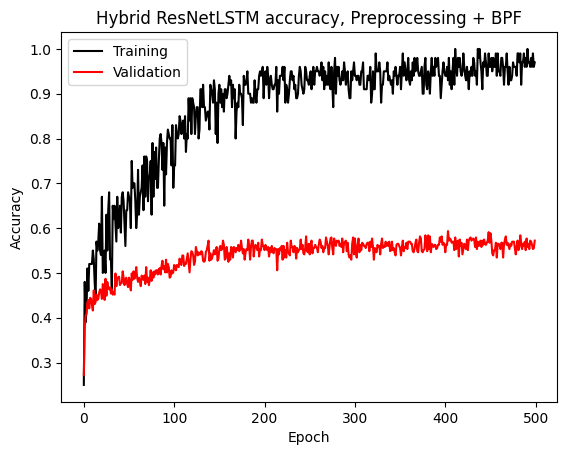

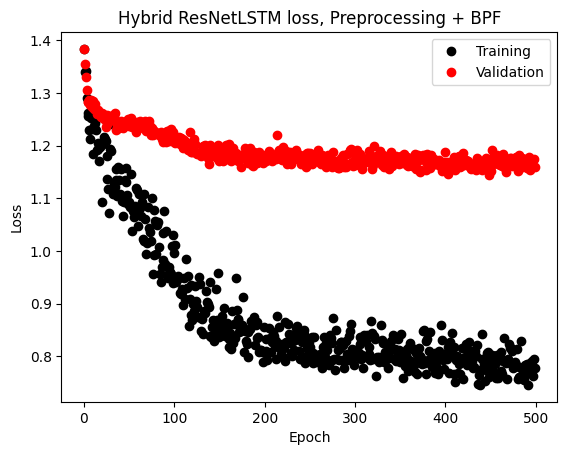

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_5,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_5,label='Validation',color='r')
plt.title('Hybrid ResNetLSTM accuracy, Preprocessing + BPF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_5,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_5,'o',label='Validation',color='r')
plt.title('Hybrid ResNetLSTM loss, Preprocessing + BPF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 6a: SGD w/ Momentum + Preprocessing + HPF

In [29]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [30]:
# Define the high-pass filter parameters
cutoff_frequency = 4  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth high-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='high', analog=False, output='ba')

x_train_hpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_hpf[i,0,j,:] = filtered_data

x_train_hpf = torch.tensor(x_train_hpf).float().to(device)
print(x_train_hpf.shape)

torch.Size([6768, 1, 22, 400])


In [31]:
#Build the model
model6 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model6)
total_params = sum(p.numel() for p in model6.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model6.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model6.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
step_size = 25
gamma = 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
#optimizer = torch.optim.Adam(model6.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_6, val_history_6 = np.array([]), np.array([])
train_loss_hist_6, val_loss_hist_6 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model6_params.pt')
    torch.save(model6.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model6.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model6(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model6.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model6(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_6 = np.append(train_history_6, train_acc.item())
        val_history_6 = np.append(val_history_6, val_acc.item())
        train_loss_hist_6 = np.append(train_loss_hist_6, loss.item())
        val_loss_hist_6 = np.append(val_loss_hist_6, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model6.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-18-8cd2e41e8bfb>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:02<23:51,  2.87s/it]

Epoch 1 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


  0%|          | 2/500 [00:05<23:26,  2.82s/it]

Epoch 2 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


  1%|          | 3/500 [00:08<23:18,  2.81s/it]

Epoch 3 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


  1%|          | 4/500 [00:11<23:16,  2.82s/it]

Epoch 4 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.382, Val loss: 1.388


  1%|          | 5/500 [00:14<23:14,  2.82s/it]

Epoch 5 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


  1%|          | 6/500 [00:16<23:12,  2.82s/it]

Epoch 6 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


  1%|▏         | 7/500 [00:19<23:11,  2.82s/it]

Epoch 7 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


  2%|▏         | 8/500 [00:22<23:10,  2.83s/it]

Epoch 8 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


  2%|▏         | 9/500 [00:25<23:10,  2.83s/it]

Epoch 9 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


  2%|▏         | 10/500 [00:28<23:09,  2.84s/it]

Epoch 10 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


  2%|▏         | 11/500 [00:31<23:08,  2.84s/it]

Epoch 11 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


  2%|▏         | 12/500 [00:33<23:07,  2.84s/it]

Epoch 12 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.374, Val loss: 1.388


  3%|▎         | 13/500 [00:36<23:07,  2.85s/it]

Epoch 13 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


  3%|▎         | 14/500 [00:39<23:06,  2.85s/it]

Epoch 14 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


  3%|▎         | 15/500 [00:42<23:05,  2.86s/it]

Epoch 15 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


  3%|▎         | 16/500 [00:45<23:05,  2.86s/it]

Epoch 16 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


  3%|▎         | 17/500 [00:48<23:04,  2.87s/it]

Epoch 17 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


  4%|▎         | 18/500 [00:51<23:04,  2.87s/it]

Epoch 18 Finished!!!
Train acc: 0.140, Val acc: 0.255
Train loss: 1.409, Val loss: 1.388


  4%|▍         | 19/500 [00:54<23:02,  2.87s/it]

Epoch 19 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


  4%|▍         | 20/500 [00:56<23:01,  2.88s/it]

Epoch 20 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


  4%|▍         | 21/500 [00:59<23:00,  2.88s/it]

Epoch 21 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.407, Val loss: 1.388


  4%|▍         | 22/500 [01:03<23:59,  3.01s/it]

Epoch 22 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


  5%|▍         | 23/500 [01:06<23:40,  2.98s/it]

Epoch 23 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


  5%|▍         | 24/500 [01:08<23:27,  2.96s/it]

Epoch 24 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


  5%|▌         | 25/500 [01:11<23:16,  2.94s/it]

Epoch 25 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


  5%|▌         | 26/500 [01:14<23:08,  2.93s/it]

Epoch 26 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


  5%|▌         | 27/500 [01:17<23:13,  2.95s/it]

Epoch 27 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


  6%|▌         | 28/500 [01:20<23:06,  2.94s/it]

Epoch 28 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


  6%|▌         | 29/500 [01:23<23:00,  2.93s/it]

Epoch 29 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


  6%|▌         | 30/500 [01:26<22:55,  2.93s/it]

Epoch 30 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


  6%|▌         | 31/500 [01:29<22:53,  2.93s/it]

Epoch 31 Finished!!!
Train acc: 0.360, Val acc: 0.255
Train loss: 1.370, Val loss: 1.388


  6%|▋         | 32/500 [01:32<22:50,  2.93s/it]

Epoch 32 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.379, Val loss: 1.388


  7%|▋         | 33/500 [01:35<22:47,  2.93s/it]

Epoch 33 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.384, Val loss: 1.388


  7%|▋         | 34/500 [01:38<22:45,  2.93s/it]

Epoch 34 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


  7%|▋         | 35/500 [01:41<22:43,  2.93s/it]

Epoch 35 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


  7%|▋         | 36/500 [01:44<22:41,  2.93s/it]

Epoch 36 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


  7%|▋         | 37/500 [01:47<22:39,  2.94s/it]

Epoch 37 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


  8%|▊         | 38/500 [01:50<22:38,  2.94s/it]

Epoch 38 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


  8%|▊         | 39/500 [01:52<22:36,  2.94s/it]

Epoch 39 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


  8%|▊         | 40/500 [01:55<22:35,  2.95s/it]

Epoch 40 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


  8%|▊         | 41/500 [01:58<22:32,  2.95s/it]

Epoch 41 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.382, Val loss: 1.388


  8%|▊         | 42/500 [02:01<22:30,  2.95s/it]

Epoch 42 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


  9%|▊         | 43/500 [02:04<22:29,  2.95s/it]

Epoch 43 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


  9%|▉         | 44/500 [02:07<22:27,  2.96s/it]

Epoch 44 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


  9%|▉         | 45/500 [02:10<22:25,  2.96s/it]

Epoch 45 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


  9%|▉         | 46/500 [02:13<22:23,  2.96s/it]

Epoch 46 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


  9%|▉         | 47/500 [02:16<22:21,  2.96s/it]

Epoch 47 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 10%|▉         | 48/500 [02:19<22:20,  2.96s/it]

Epoch 48 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 10%|▉         | 49/500 [02:22<22:17,  2.97s/it]

Epoch 49 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.379, Val loss: 1.388


 10%|█         | 50/500 [02:25<22:15,  2.97s/it]

Epoch 50 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 10%|█         | 51/500 [02:28<22:13,  2.97s/it]

Epoch 51 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 10%|█         | 52/500 [02:31<22:12,  2.97s/it]

Epoch 52 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 11%|█         | 53/500 [02:34<22:10,  2.98s/it]

Epoch 53 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 11%|█         | 54/500 [02:37<22:07,  2.98s/it]

Epoch 54 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 11%|█         | 55/500 [02:40<22:05,  2.98s/it]

Epoch 55 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 11%|█         | 56/500 [02:43<22:04,  2.98s/it]

Epoch 56 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.382, Val loss: 1.388


 11%|█▏        | 57/500 [02:46<22:02,  2.98s/it]

Epoch 57 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 12%|█▏        | 58/500 [02:49<22:10,  3.01s/it]

Epoch 58 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 12%|█▏        | 59/500 [02:52<22:05,  3.01s/it]

Epoch 59 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 12%|█▏        | 60/500 [02:55<22:21,  3.05s/it]

Epoch 60 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 12%|█▏        | 61/500 [02:59<24:44,  3.38s/it]

Epoch 61 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 12%|█▏        | 62/500 [03:02<24:14,  3.32s/it]

Epoch 62 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 13%|█▎        | 63/500 [03:06<24:25,  3.35s/it]

Epoch 63 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 13%|█▎        | 64/500 [03:09<23:55,  3.29s/it]

Epoch 64 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 13%|█▎        | 65/500 [03:12<23:41,  3.27s/it]

Epoch 65 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.382, Val loss: 1.388


 13%|█▎        | 66/500 [03:15<23:06,  3.19s/it]

Epoch 66 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.384, Val loss: 1.388


 13%|█▎        | 67/500 [03:18<22:39,  3.14s/it]

Epoch 67 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 14%|█▎        | 68/500 [03:21<22:19,  3.10s/it]

Epoch 68 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 14%|█▍        | 69/500 [03:24<22:05,  3.08s/it]

Epoch 69 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.404, Val loss: 1.388


 14%|█▍        | 70/500 [03:27<21:54,  3.06s/it]

Epoch 70 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 14%|█▍        | 71/500 [03:30<21:46,  3.05s/it]

Epoch 71 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 14%|█▍        | 72/500 [03:33<21:40,  3.04s/it]

Epoch 72 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 15%|█▍        | 73/500 [03:36<21:36,  3.04s/it]

Epoch 73 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.405, Val loss: 1.388


 15%|█▍        | 74/500 [03:39<21:31,  3.03s/it]

Epoch 74 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 15%|█▌        | 75/500 [03:42<21:27,  3.03s/it]

Epoch 75 Finished!!!
Train acc: 0.380, Val acc: 0.255
Train loss: 1.367, Val loss: 1.388


 15%|█▌        | 76/500 [03:45<21:23,  3.03s/it]

Epoch 76 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 15%|█▌        | 77/500 [03:49<21:20,  3.03s/it]

Epoch 77 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 16%|█▌        | 78/500 [03:52<21:17,  3.03s/it]

Epoch 78 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 16%|█▌        | 79/500 [03:55<21:15,  3.03s/it]

Epoch 79 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 16%|█▌        | 80/500 [03:58<21:12,  3.03s/it]

Epoch 80 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 16%|█▌        | 81/500 [04:01<21:09,  3.03s/it]

Epoch 81 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 16%|█▋        | 82/500 [04:04<21:46,  3.13s/it]

Epoch 82 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 17%|█▋        | 83/500 [04:07<21:31,  3.10s/it]

Epoch 83 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 17%|█▋        | 84/500 [04:10<21:20,  3.08s/it]

Epoch 84 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 17%|█▋        | 85/500 [04:13<21:11,  3.06s/it]

Epoch 85 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 17%|█▋        | 86/500 [04:16<21:04,  3.05s/it]

Epoch 86 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 17%|█▋        | 87/500 [04:19<20:58,  3.05s/it]

Epoch 87 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 18%|█▊        | 88/500 [04:22<20:52,  3.04s/it]

Epoch 88 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 18%|█▊        | 89/500 [04:25<20:48,  3.04s/it]

Epoch 89 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 18%|█▊        | 90/500 [04:28<20:45,  3.04s/it]

Epoch 90 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 18%|█▊        | 91/500 [04:31<20:41,  3.03s/it]

Epoch 91 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 18%|█▊        | 92/500 [04:34<20:37,  3.03s/it]

Epoch 92 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 19%|█▊        | 93/500 [04:37<20:33,  3.03s/it]

Epoch 93 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 19%|█▉        | 94/500 [04:40<20:30,  3.03s/it]

Epoch 94 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 19%|█▉        | 95/500 [04:43<20:27,  3.03s/it]

Epoch 95 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 19%|█▉        | 96/500 [04:46<20:34,  3.06s/it]

Epoch 96 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 19%|█▉        | 97/500 [04:50<20:28,  3.05s/it]

Epoch 97 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 20%|█▉        | 98/500 [04:53<20:23,  3.04s/it]

Epoch 98 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 20%|█▉        | 99/500 [04:56<20:19,  3.04s/it]

Epoch 99 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 20%|██        | 100/500 [04:59<20:14,  3.04s/it]

Epoch 100 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 20%|██        | 101/500 [05:02<20:10,  3.03s/it]

Epoch 101 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 20%|██        | 102/500 [05:05<20:07,  3.03s/it]

Epoch 102 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 21%|██        | 103/500 [05:08<20:04,  3.03s/it]

Epoch 103 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 21%|██        | 104/500 [05:11<20:01,  3.03s/it]

Epoch 104 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 21%|██        | 105/500 [05:14<19:57,  3.03s/it]

Epoch 105 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.373, Val loss: 1.388


 21%|██        | 106/500 [05:17<19:53,  3.03s/it]

Epoch 106 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 21%|██▏       | 107/500 [05:20<19:51,  3.03s/it]

Epoch 107 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 22%|██▏       | 108/500 [05:23<19:47,  3.03s/it]

Epoch 108 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 22%|██▏       | 109/500 [05:26<19:43,  3.03s/it]

Epoch 109 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 22%|██▏       | 110/500 [05:29<19:40,  3.03s/it]

Epoch 110 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 22%|██▏       | 111/500 [05:32<19:38,  3.03s/it]

Epoch 111 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 22%|██▏       | 112/500 [05:35<19:34,  3.03s/it]

Epoch 112 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.384, Val loss: 1.388


 23%|██▎       | 113/500 [05:38<19:31,  3.03s/it]

Epoch 113 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 23%|██▎       | 114/500 [05:41<19:28,  3.03s/it]

Epoch 114 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 23%|██▎       | 115/500 [05:44<19:25,  3.03s/it]

Epoch 115 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 23%|██▎       | 116/500 [05:47<19:22,  3.03s/it]

Epoch 116 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.405, Val loss: 1.388


 23%|██▎       | 117/500 [05:50<19:20,  3.03s/it]

Epoch 117 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 24%|██▎       | 118/500 [05:53<19:17,  3.03s/it]

Epoch 118 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 24%|██▍       | 119/500 [05:56<19:15,  3.03s/it]

Epoch 119 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 24%|██▍       | 120/500 [05:59<19:12,  3.03s/it]

Epoch 120 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 24%|██▍       | 121/500 [06:02<19:08,  3.03s/it]

Epoch 121 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 24%|██▍       | 122/500 [06:05<19:05,  3.03s/it]

Epoch 122 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 25%|██▍       | 123/500 [06:08<19:02,  3.03s/it]

Epoch 123 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 25%|██▍       | 124/500 [06:11<18:59,  3.03s/it]

Epoch 124 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 25%|██▌       | 125/500 [06:14<18:57,  3.03s/it]

Epoch 125 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 25%|██▌       | 126/500 [06:17<18:53,  3.03s/it]

Epoch 126 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 25%|██▌       | 127/500 [06:20<18:50,  3.03s/it]

Epoch 127 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.408, Val loss: 1.388


 26%|██▌       | 128/500 [06:23<18:47,  3.03s/it]

Epoch 128 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.384, Val loss: 1.388


 26%|██▌       | 129/500 [06:26<18:44,  3.03s/it]

Epoch 129 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 26%|██▌       | 130/500 [06:30<18:41,  3.03s/it]

Epoch 130 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 26%|██▌       | 131/500 [06:33<18:37,  3.03s/it]

Epoch 131 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 26%|██▋       | 132/500 [06:36<18:34,  3.03s/it]

Epoch 132 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.379, Val loss: 1.388


 27%|██▋       | 133/500 [06:39<18:31,  3.03s/it]

Epoch 133 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.382, Val loss: 1.388


 27%|██▋       | 134/500 [06:42<18:27,  3.03s/it]

Epoch 134 Finished!!!
Train acc: 0.340, Val acc: 0.255
Train loss: 1.375, Val loss: 1.388


 27%|██▋       | 135/500 [06:45<18:24,  3.03s/it]

Epoch 135 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 27%|██▋       | 136/500 [06:48<18:22,  3.03s/it]

Epoch 136 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 27%|██▋       | 137/500 [06:51<18:19,  3.03s/it]

Epoch 137 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 28%|██▊       | 138/500 [06:54<18:16,  3.03s/it]

Epoch 138 Finished!!!
Train acc: 0.340, Val acc: 0.255
Train loss: 1.375, Val loss: 1.388


 28%|██▊       | 139/500 [06:57<18:13,  3.03s/it]

Epoch 139 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 28%|██▊       | 140/500 [07:00<18:10,  3.03s/it]

Epoch 140 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 28%|██▊       | 141/500 [07:03<18:07,  3.03s/it]

Epoch 141 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 28%|██▊       | 142/500 [07:06<18:04,  3.03s/it]

Epoch 142 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 29%|██▊       | 143/500 [07:09<18:01,  3.03s/it]

Epoch 143 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 29%|██▉       | 144/500 [07:12<17:57,  3.03s/it]

Epoch 144 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 29%|██▉       | 145/500 [07:15<17:55,  3.03s/it]

Epoch 145 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 29%|██▉       | 146/500 [07:18<17:52,  3.03s/it]

Epoch 146 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 29%|██▉       | 147/500 [07:21<17:49,  3.03s/it]

Epoch 147 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 30%|██▉       | 148/500 [07:24<17:45,  3.03s/it]

Epoch 148 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 30%|██▉       | 149/500 [07:27<17:43,  3.03s/it]

Epoch 149 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 30%|███       | 150/500 [07:30<17:40,  3.03s/it]

Epoch 150 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 30%|███       | 151/500 [07:33<17:37,  3.03s/it]

Epoch 151 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 30%|███       | 152/500 [07:36<17:34,  3.03s/it]

Epoch 152 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 31%|███       | 153/500 [07:39<17:31,  3.03s/it]

Epoch 153 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 31%|███       | 154/500 [07:42<17:28,  3.03s/it]

Epoch 154 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 31%|███       | 155/500 [07:45<17:25,  3.03s/it]

Epoch 155 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 31%|███       | 156/500 [07:48<17:22,  3.03s/it]

Epoch 156 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 31%|███▏      | 157/500 [07:51<17:19,  3.03s/it]

Epoch 157 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 32%|███▏      | 158/500 [07:54<17:16,  3.03s/it]

Epoch 158 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 32%|███▏      | 159/500 [07:57<17:13,  3.03s/it]

Epoch 159 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 32%|███▏      | 160/500 [08:00<17:10,  3.03s/it]

Epoch 160 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 32%|███▏      | 161/500 [08:03<17:08,  3.03s/it]

Epoch 161 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 32%|███▏      | 162/500 [08:06<17:05,  3.03s/it]

Epoch 162 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 33%|███▎      | 163/500 [08:10<17:02,  3.03s/it]

Epoch 163 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 33%|███▎      | 164/500 [08:13<16:59,  3.03s/it]

Epoch 164 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 33%|███▎      | 165/500 [08:16<16:57,  3.04s/it]

Epoch 165 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 33%|███▎      | 166/500 [08:19<16:54,  3.04s/it]

Epoch 166 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 33%|███▎      | 167/500 [08:22<16:50,  3.03s/it]

Epoch 167 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 34%|███▎      | 168/500 [08:25<16:47,  3.03s/it]

Epoch 168 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 34%|███▍      | 169/500 [08:28<16:43,  3.03s/it]

Epoch 169 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 34%|███▍      | 170/500 [08:31<16:40,  3.03s/it]

Epoch 170 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 34%|███▍      | 171/500 [08:34<16:36,  3.03s/it]

Epoch 171 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 34%|███▍      | 172/500 [08:37<16:33,  3.03s/it]

Epoch 172 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 35%|███▍      | 173/500 [08:40<16:31,  3.03s/it]

Epoch 173 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 35%|███▍      | 174/500 [08:43<16:27,  3.03s/it]

Epoch 174 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 35%|███▌      | 175/500 [08:46<16:25,  3.03s/it]

Epoch 175 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 35%|███▌      | 176/500 [08:49<16:22,  3.03s/it]

Epoch 176 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 35%|███▌      | 177/500 [08:52<16:19,  3.03s/it]

Epoch 177 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 36%|███▌      | 178/500 [08:55<16:15,  3.03s/it]

Epoch 178 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 36%|███▌      | 179/500 [08:58<16:13,  3.03s/it]

Epoch 179 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 36%|███▌      | 180/500 [09:01<16:09,  3.03s/it]

Epoch 180 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 36%|███▌      | 181/500 [09:04<16:06,  3.03s/it]

Epoch 181 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 36%|███▋      | 182/500 [09:07<16:04,  3.03s/it]

Epoch 182 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.404, Val loss: 1.388


 37%|███▋      | 183/500 [09:10<16:00,  3.03s/it]

Epoch 183 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 37%|███▋      | 184/500 [09:13<15:57,  3.03s/it]

Epoch 184 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 37%|███▋      | 185/500 [09:16<15:54,  3.03s/it]

Epoch 185 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 37%|███▋      | 186/500 [09:19<15:52,  3.03s/it]

Epoch 186 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 37%|███▋      | 187/500 [09:22<15:49,  3.03s/it]

Epoch 187 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 38%|███▊      | 188/500 [09:25<15:46,  3.03s/it]

Epoch 188 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 38%|███▊      | 189/500 [09:28<15:53,  3.07s/it]

Epoch 189 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 38%|███▊      | 190/500 [09:32<15:54,  3.08s/it]

Epoch 190 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 38%|███▊      | 191/500 [09:35<16:23,  3.18s/it]

Epoch 191 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.384, Val loss: 1.388


 38%|███▊      | 192/500 [09:38<16:06,  3.14s/it]

Epoch 192 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 39%|███▊      | 193/500 [09:41<15:53,  3.11s/it]

Epoch 193 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 39%|███▉      | 194/500 [09:44<15:43,  3.08s/it]

Epoch 194 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 39%|███▉      | 195/500 [09:47<15:35,  3.07s/it]

Epoch 195 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 39%|███▉      | 196/500 [09:50<15:28,  3.06s/it]

Epoch 196 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 39%|███▉      | 197/500 [09:53<15:24,  3.05s/it]

Epoch 197 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 40%|███▉      | 198/500 [09:56<15:19,  3.04s/it]

Epoch 198 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 40%|███▉      | 199/500 [09:59<15:14,  3.04s/it]

Epoch 199 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 40%|████      | 200/500 [10:02<15:11,  3.04s/it]

Epoch 200 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 40%|████      | 201/500 [10:05<15:07,  3.04s/it]

Epoch 201 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 40%|████      | 202/500 [10:08<15:03,  3.03s/it]

Epoch 202 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 41%|████      | 203/500 [10:11<15:00,  3.03s/it]

Epoch 203 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.402, Val loss: 1.388


 41%|████      | 204/500 [10:14<14:57,  3.03s/it]

Epoch 204 Finished!!!
Train acc: 0.340, Val acc: 0.255
Train loss: 1.374, Val loss: 1.388


 41%|████      | 205/500 [10:17<14:54,  3.03s/it]

Epoch 205 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 41%|████      | 206/500 [10:20<14:51,  3.03s/it]

Epoch 206 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 41%|████▏     | 207/500 [10:23<14:47,  3.03s/it]

Epoch 207 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 42%|████▏     | 208/500 [10:27<14:45,  3.03s/it]

Epoch 208 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 42%|████▏     | 209/500 [10:30<14:41,  3.03s/it]

Epoch 209 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 42%|████▏     | 210/500 [10:33<14:39,  3.03s/it]

Epoch 210 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 42%|████▏     | 211/500 [10:36<14:36,  3.03s/it]

Epoch 211 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 42%|████▏     | 212/500 [10:39<14:34,  3.04s/it]

Epoch 212 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 43%|████▎     | 213/500 [10:42<14:32,  3.04s/it]

Epoch 213 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 43%|████▎     | 214/500 [10:45<14:28,  3.04s/it]

Epoch 214 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 43%|████▎     | 215/500 [10:48<14:24,  3.03s/it]

Epoch 215 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 43%|████▎     | 216/500 [10:51<14:22,  3.04s/it]

Epoch 216 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 43%|████▎     | 217/500 [10:54<14:19,  3.04s/it]

Epoch 217 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 44%|████▎     | 218/500 [10:57<14:15,  3.03s/it]

Epoch 218 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 44%|████▍     | 219/500 [11:00<14:12,  3.03s/it]

Epoch 219 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 44%|████▍     | 220/500 [11:03<14:09,  3.03s/it]

Epoch 220 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 44%|████▍     | 221/500 [11:06<14:06,  3.03s/it]

Epoch 221 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 44%|████▍     | 222/500 [11:09<14:03,  3.03s/it]

Epoch 222 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 45%|████▍     | 223/500 [11:12<14:00,  3.03s/it]

Epoch 223 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 45%|████▍     | 224/500 [11:15<13:56,  3.03s/it]

Epoch 224 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 45%|████▌     | 225/500 [11:18<13:53,  3.03s/it]

Epoch 225 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 45%|████▌     | 226/500 [11:21<13:51,  3.03s/it]

Epoch 226 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 45%|████▌     | 227/500 [11:24<13:48,  3.03s/it]

Epoch 227 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 46%|████▌     | 228/500 [11:27<13:45,  3.03s/it]

Epoch 228 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 46%|████▌     | 229/500 [11:30<13:42,  3.03s/it]

Epoch 229 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 46%|████▌     | 230/500 [11:33<13:39,  3.04s/it]

Epoch 230 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 46%|████▌     | 231/500 [11:36<13:36,  3.03s/it]

Epoch 231 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 46%|████▋     | 232/500 [11:39<13:32,  3.03s/it]

Epoch 232 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 47%|████▋     | 233/500 [11:42<13:29,  3.03s/it]

Epoch 233 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 47%|████▋     | 234/500 [11:45<13:26,  3.03s/it]

Epoch 234 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 47%|████▋     | 235/500 [11:48<13:23,  3.03s/it]

Epoch 235 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 47%|████▋     | 236/500 [11:51<13:20,  3.03s/it]

Epoch 236 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 47%|████▋     | 237/500 [11:54<13:17,  3.03s/it]

Epoch 237 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 48%|████▊     | 238/500 [11:58<13:15,  3.03s/it]

Epoch 238 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.407, Val loss: 1.388


 48%|████▊     | 239/500 [12:01<13:12,  3.04s/it]

Epoch 239 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 48%|████▊     | 240/500 [12:04<13:09,  3.04s/it]

Epoch 240 Finished!!!
Train acc: 0.100, Val acc: 0.255
Train loss: 1.415, Val loss: 1.388


 48%|████▊     | 241/500 [12:07<13:05,  3.03s/it]

Epoch 241 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 48%|████▊     | 242/500 [12:10<13:03,  3.04s/it]

Epoch 242 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 49%|████▊     | 243/500 [12:13<13:00,  3.04s/it]

Epoch 243 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 49%|████▉     | 244/500 [12:16<12:57,  3.04s/it]

Epoch 244 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 49%|████▉     | 245/500 [12:19<12:56,  3.04s/it]

Epoch 245 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 49%|████▉     | 246/500 [12:22<13:22,  3.16s/it]

Epoch 246 Finished!!!
Train acc: 0.320, Val acc: 0.255
Train loss: 1.377, Val loss: 1.388


 49%|████▉     | 247/500 [12:25<13:17,  3.15s/it]

Epoch 247 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 50%|████▉     | 248/500 [12:29<13:14,  3.15s/it]

Epoch 248 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 50%|████▉     | 249/500 [12:32<13:04,  3.12s/it]

Epoch 249 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 50%|█████     | 250/500 [12:35<13:05,  3.14s/it]

Epoch 250 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 50%|█████     | 251/500 [12:38<13:05,  3.15s/it]

Epoch 251 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 50%|█████     | 252/500 [12:41<12:53,  3.12s/it]

Epoch 252 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 51%|█████     | 253/500 [12:44<12:44,  3.09s/it]

Epoch 253 Finished!!!
Train acc: 0.110, Val acc: 0.255
Train loss: 1.414, Val loss: 1.388


 51%|█████     | 254/500 [12:47<12:36,  3.07s/it]

Epoch 254 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 51%|█████     | 255/500 [12:50<12:29,  3.06s/it]

Epoch 255 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 51%|█████     | 256/500 [12:53<12:24,  3.05s/it]

Epoch 256 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 51%|█████▏    | 257/500 [12:56<12:19,  3.04s/it]

Epoch 257 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 52%|█████▏    | 258/500 [12:59<12:15,  3.04s/it]

Epoch 258 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 52%|█████▏    | 259/500 [13:02<12:12,  3.04s/it]

Epoch 259 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 52%|█████▏    | 260/500 [13:05<12:08,  3.04s/it]

Epoch 260 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 52%|█████▏    | 261/500 [13:08<12:04,  3.03s/it]

Epoch 261 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 52%|█████▏    | 262/500 [13:11<12:00,  3.03s/it]

Epoch 262 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.377, Val loss: 1.388


 53%|█████▎    | 263/500 [13:14<11:57,  3.03s/it]

Epoch 263 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 53%|█████▎    | 264/500 [13:17<11:54,  3.03s/it]

Epoch 264 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 53%|█████▎    | 265/500 [13:20<11:50,  3.02s/it]

Epoch 265 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.381, Val loss: 1.388


 53%|█████▎    | 266/500 [13:23<11:47,  3.02s/it]

Epoch 266 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 53%|█████▎    | 267/500 [13:26<11:44,  3.02s/it]

Epoch 267 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 54%|█████▎    | 268/500 [13:29<11:41,  3.02s/it]

Epoch 268 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 54%|█████▍    | 269/500 [13:32<11:38,  3.02s/it]

Epoch 269 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 54%|█████▍    | 270/500 [13:35<11:34,  3.02s/it]

Epoch 270 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 54%|█████▍    | 271/500 [13:38<11:31,  3.02s/it]

Epoch 271 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 54%|█████▍    | 272/500 [13:42<11:29,  3.02s/it]

Epoch 272 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 55%|█████▍    | 273/500 [13:45<11:26,  3.02s/it]

Epoch 273 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.404, Val loss: 1.388


 55%|█████▍    | 274/500 [13:48<11:22,  3.02s/it]

Epoch 274 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 55%|█████▌    | 275/500 [13:51<11:19,  3.02s/it]

Epoch 275 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 55%|█████▌    | 276/500 [13:54<11:17,  3.02s/it]

Epoch 276 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 55%|█████▌    | 277/500 [13:57<11:14,  3.02s/it]

Epoch 277 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 56%|█████▌    | 278/500 [14:00<11:11,  3.02s/it]

Epoch 278 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 56%|█████▌    | 279/500 [14:03<11:08,  3.02s/it]

Epoch 279 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 56%|█████▌    | 280/500 [14:06<11:05,  3.03s/it]

Epoch 280 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 56%|█████▌    | 281/500 [14:09<11:02,  3.03s/it]

Epoch 281 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 56%|█████▋    | 282/500 [14:12<10:59,  3.03s/it]

Epoch 282 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 57%|█████▋    | 283/500 [14:15<10:56,  3.03s/it]

Epoch 283 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 57%|█████▋    | 284/500 [14:18<10:53,  3.03s/it]

Epoch 284 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 57%|█████▋    | 285/500 [14:21<10:50,  3.03s/it]

Epoch 285 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.405, Val loss: 1.388


 57%|█████▋    | 286/500 [14:24<10:47,  3.03s/it]

Epoch 286 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 57%|█████▋    | 287/500 [14:27<10:44,  3.03s/it]

Epoch 287 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 58%|█████▊    | 288/500 [14:30<10:41,  3.03s/it]

Epoch 288 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 58%|█████▊    | 289/500 [14:33<10:39,  3.03s/it]

Epoch 289 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 58%|█████▊    | 290/500 [14:36<10:35,  3.03s/it]

Epoch 290 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 58%|█████▊    | 291/500 [14:39<10:32,  3.03s/it]

Epoch 291 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 58%|█████▊    | 292/500 [14:42<10:29,  3.03s/it]

Epoch 292 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 59%|█████▊    | 293/500 [14:45<10:27,  3.03s/it]

Epoch 293 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.402, Val loss: 1.388


 59%|█████▉    | 294/500 [14:48<10:24,  3.03s/it]

Epoch 294 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.405, Val loss: 1.388


 59%|█████▉    | 295/500 [14:51<10:21,  3.03s/it]

Epoch 295 Finished!!!
Train acc: 0.320, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 59%|█████▉    | 296/500 [14:54<10:18,  3.03s/it]

Epoch 296 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 59%|█████▉    | 297/500 [14:57<10:15,  3.03s/it]

Epoch 297 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 60%|█████▉    | 298/500 [15:00<10:12,  3.03s/it]

Epoch 298 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.381, Val loss: 1.388


 60%|█████▉    | 299/500 [15:03<10:09,  3.03s/it]

Epoch 299 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 60%|██████    | 300/500 [15:06<10:06,  3.03s/it]

Epoch 300 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 60%|██████    | 301/500 [15:09<10:03,  3.03s/it]

Epoch 301 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 60%|██████    | 302/500 [15:12<10:00,  3.03s/it]

Epoch 302 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 61%|██████    | 303/500 [15:15<09:57,  3.03s/it]

Epoch 303 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.404, Val loss: 1.388


 61%|██████    | 304/500 [15:18<09:54,  3.03s/it]

Epoch 304 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 61%|██████    | 305/500 [15:21<09:51,  3.03s/it]

Epoch 305 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 61%|██████    | 306/500 [15:25<09:49,  3.04s/it]

Epoch 306 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 61%|██████▏   | 307/500 [15:28<09:46,  3.04s/it]

Epoch 307 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 62%|██████▏   | 308/500 [15:31<09:43,  3.04s/it]

Epoch 308 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 62%|██████▏   | 309/500 [15:34<09:39,  3.04s/it]

Epoch 309 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 62%|██████▏   | 310/500 [15:37<09:37,  3.04s/it]

Epoch 310 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 62%|██████▏   | 311/500 [15:40<09:34,  3.04s/it]

Epoch 311 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 62%|██████▏   | 312/500 [15:43<09:31,  3.04s/it]

Epoch 312 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 63%|██████▎   | 313/500 [15:46<09:27,  3.04s/it]

Epoch 313 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 63%|██████▎   | 314/500 [15:49<09:24,  3.04s/it]

Epoch 314 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 63%|██████▎   | 315/500 [15:52<09:21,  3.04s/it]

Epoch 315 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.402, Val loss: 1.388


 63%|██████▎   | 316/500 [15:55<09:18,  3.04s/it]

Epoch 316 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.405, Val loss: 1.388


 63%|██████▎   | 317/500 [15:58<09:15,  3.04s/it]

Epoch 317 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.408, Val loss: 1.388


 64%|██████▎   | 318/500 [16:01<09:12,  3.03s/it]

Epoch 318 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 64%|██████▍   | 319/500 [16:04<09:09,  3.04s/it]

Epoch 319 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 64%|██████▍   | 320/500 [16:07<09:06,  3.03s/it]

Epoch 320 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 64%|██████▍   | 321/500 [16:10<09:02,  3.03s/it]

Epoch 321 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 64%|██████▍   | 322/500 [16:13<08:59,  3.03s/it]

Epoch 322 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 65%|██████▍   | 323/500 [16:16<08:56,  3.03s/it]

Epoch 323 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 65%|██████▍   | 324/500 [16:19<08:53,  3.03s/it]

Epoch 324 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 65%|██████▌   | 325/500 [16:22<08:50,  3.03s/it]

Epoch 325 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 65%|██████▌   | 326/500 [16:25<08:47,  3.03s/it]

Epoch 326 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 65%|██████▌   | 327/500 [16:28<08:44,  3.03s/it]

Epoch 327 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 66%|██████▌   | 328/500 [16:31<08:41,  3.03s/it]

Epoch 328 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 66%|██████▌   | 329/500 [16:34<08:38,  3.03s/it]

Epoch 329 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 66%|██████▌   | 330/500 [16:37<08:35,  3.03s/it]

Epoch 330 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 66%|██████▌   | 331/500 [16:40<08:32,  3.03s/it]

Epoch 331 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 66%|██████▋   | 332/500 [16:43<08:28,  3.03s/it]

Epoch 332 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.376, Val loss: 1.388


 67%|██████▋   | 333/500 [16:46<08:25,  3.03s/it]

Epoch 333 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 67%|██████▋   | 334/500 [16:49<08:22,  3.03s/it]

Epoch 334 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 67%|██████▋   | 335/500 [16:52<08:19,  3.03s/it]

Epoch 335 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 67%|██████▋   | 336/500 [16:55<08:16,  3.03s/it]

Epoch 336 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.384, Val loss: 1.388


 67%|██████▋   | 337/500 [16:59<08:14,  3.03s/it]

Epoch 337 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 68%|██████▊   | 338/500 [17:02<08:11,  3.03s/it]

Epoch 338 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 68%|██████▊   | 339/500 [17:05<08:07,  3.03s/it]

Epoch 339 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 68%|██████▊   | 340/500 [17:08<08:04,  3.03s/it]

Epoch 340 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 68%|██████▊   | 341/500 [17:11<08:01,  3.03s/it]

Epoch 341 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 68%|██████▊   | 342/500 [17:14<07:58,  3.03s/it]

Epoch 342 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 69%|██████▊   | 343/500 [17:17<07:55,  3.03s/it]

Epoch 343 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 69%|██████▉   | 344/500 [17:20<07:52,  3.03s/it]

Epoch 344 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.399, Val loss: 1.388


 69%|██████▉   | 345/500 [17:23<07:49,  3.03s/it]

Epoch 345 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 69%|██████▉   | 346/500 [17:26<07:46,  3.03s/it]

Epoch 346 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 69%|██████▉   | 347/500 [17:29<07:43,  3.03s/it]

Epoch 347 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 70%|██████▉   | 348/500 [17:32<07:40,  3.03s/it]

Epoch 348 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.402, Val loss: 1.388


 70%|██████▉   | 349/500 [17:35<07:37,  3.03s/it]

Epoch 349 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 70%|███████   | 350/500 [17:38<07:34,  3.03s/it]

Epoch 350 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 70%|███████   | 351/500 [17:41<07:31,  3.03s/it]

Epoch 351 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 70%|███████   | 352/500 [17:44<07:28,  3.03s/it]

Epoch 352 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 71%|███████   | 353/500 [17:47<07:25,  3.03s/it]

Epoch 353 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 71%|███████   | 354/500 [17:50<07:22,  3.03s/it]

Epoch 354 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 71%|███████   | 355/500 [17:53<07:19,  3.03s/it]

Epoch 355 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 71%|███████   | 356/500 [17:56<07:16,  3.03s/it]

Epoch 356 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.381, Val loss: 1.388


 71%|███████▏  | 357/500 [17:59<07:13,  3.03s/it]

Epoch 357 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 72%|███████▏  | 358/500 [18:02<07:10,  3.03s/it]

Epoch 358 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 72%|███████▏  | 359/500 [18:05<07:07,  3.03s/it]

Epoch 359 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 72%|███████▏  | 360/500 [18:08<07:04,  3.03s/it]

Epoch 360 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 72%|███████▏  | 361/500 [18:11<07:01,  3.03s/it]

Epoch 361 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 72%|███████▏  | 362/500 [18:14<06:58,  3.03s/it]

Epoch 362 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 73%|███████▎  | 363/500 [18:17<06:55,  3.03s/it]

Epoch 363 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 73%|███████▎  | 364/500 [18:20<06:52,  3.03s/it]

Epoch 364 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 73%|███████▎  | 365/500 [18:23<06:49,  3.03s/it]

Epoch 365 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 73%|███████▎  | 366/500 [18:26<06:46,  3.03s/it]

Epoch 366 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 73%|███████▎  | 367/500 [18:29<06:42,  3.03s/it]

Epoch 367 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.382, Val loss: 1.388


 74%|███████▎  | 368/500 [18:32<06:39,  3.03s/it]

Epoch 368 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 74%|███████▍  | 369/500 [18:35<06:37,  3.03s/it]

Epoch 369 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 74%|███████▍  | 370/500 [18:39<06:33,  3.03s/it]

Epoch 370 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 74%|███████▍  | 371/500 [18:42<06:30,  3.03s/it]

Epoch 371 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 74%|███████▍  | 372/500 [18:45<06:27,  3.03s/it]

Epoch 372 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 75%|███████▍  | 373/500 [18:48<06:24,  3.03s/it]

Epoch 373 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 75%|███████▍  | 374/500 [18:51<06:21,  3.03s/it]

Epoch 374 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 75%|███████▌  | 375/500 [18:54<06:18,  3.03s/it]

Epoch 375 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 75%|███████▌  | 376/500 [18:57<06:15,  3.03s/it]

Epoch 376 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 75%|███████▌  | 377/500 [19:00<06:12,  3.03s/it]

Epoch 377 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 76%|███████▌  | 378/500 [19:03<06:09,  3.03s/it]

Epoch 378 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.384, Val loss: 1.388


 76%|███████▌  | 379/500 [19:06<06:06,  3.03s/it]

Epoch 379 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 76%|███████▌  | 380/500 [19:09<06:03,  3.03s/it]

Epoch 380 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 76%|███████▌  | 381/500 [19:12<06:00,  3.03s/it]

Epoch 381 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 76%|███████▋  | 382/500 [19:15<05:57,  3.03s/it]

Epoch 382 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 77%|███████▋  | 383/500 [19:18<05:54,  3.03s/it]

Epoch 383 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 77%|███████▋  | 384/500 [19:21<05:51,  3.03s/it]

Epoch 384 Finished!!!
Train acc: 0.320, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 77%|███████▋  | 385/500 [19:24<05:48,  3.03s/it]

Epoch 385 Finished!!!
Train acc: 0.320, Val acc: 0.255
Train loss: 1.377, Val loss: 1.388


 77%|███████▋  | 386/500 [19:27<05:45,  3.03s/it]

Epoch 386 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.402, Val loss: 1.388


 77%|███████▋  | 387/500 [19:30<05:42,  3.03s/it]

Epoch 387 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 78%|███████▊  | 388/500 [19:33<05:39,  3.03s/it]

Epoch 388 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 78%|███████▊  | 389/500 [19:36<05:36,  3.03s/it]

Epoch 389 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 78%|███████▊  | 390/500 [19:39<05:33,  3.03s/it]

Epoch 390 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.381, Val loss: 1.388


 78%|███████▊  | 391/500 [19:42<05:30,  3.03s/it]

Epoch 391 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 78%|███████▊  | 392/500 [19:45<05:27,  3.03s/it]

Epoch 392 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 79%|███████▊  | 393/500 [19:48<05:24,  3.03s/it]

Epoch 393 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 79%|███████▉  | 394/500 [19:51<05:21,  3.03s/it]

Epoch 394 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 79%|███████▉  | 395/500 [19:54<05:18,  3.03s/it]

Epoch 395 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.404, Val loss: 1.388


 79%|███████▉  | 396/500 [19:57<05:14,  3.03s/it]

Epoch 396 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 79%|███████▉  | 397/500 [20:00<05:11,  3.03s/it]

Epoch 397 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 80%|███████▉  | 398/500 [20:03<05:08,  3.03s/it]

Epoch 398 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 80%|███████▉  | 399/500 [20:06<05:06,  3.03s/it]

Epoch 399 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 80%|████████  | 400/500 [20:09<05:03,  3.03s/it]

Epoch 400 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 80%|████████  | 401/500 [20:12<04:59,  3.03s/it]

Epoch 401 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 80%|████████  | 402/500 [20:15<04:57,  3.03s/it]

Epoch 402 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 81%|████████  | 403/500 [20:19<04:54,  3.03s/it]

Epoch 403 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 81%|████████  | 404/500 [20:22<04:50,  3.03s/it]

Epoch 404 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 81%|████████  | 405/500 [20:25<04:47,  3.03s/it]

Epoch 405 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 81%|████████  | 406/500 [20:28<04:44,  3.03s/it]

Epoch 406 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 81%|████████▏ | 407/500 [20:31<04:41,  3.03s/it]

Epoch 407 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 82%|████████▏ | 408/500 [20:34<04:38,  3.03s/it]

Epoch 408 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.376, Val loss: 1.388


 82%|████████▏ | 409/500 [20:37<04:35,  3.03s/it]

Epoch 409 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 82%|████████▏ | 410/500 [20:40<04:32,  3.03s/it]

Epoch 410 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 82%|████████▏ | 411/500 [20:43<04:29,  3.03s/it]

Epoch 411 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 82%|████████▏ | 412/500 [20:46<04:26,  3.03s/it]

Epoch 412 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 83%|████████▎ | 413/500 [20:49<04:23,  3.03s/it]

Epoch 413 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 83%|████████▎ | 414/500 [20:52<04:20,  3.03s/it]

Epoch 414 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 83%|████████▎ | 415/500 [20:55<04:17,  3.03s/it]

Epoch 415 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 83%|████████▎ | 416/500 [20:58<04:14,  3.03s/it]

Epoch 416 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 83%|████████▎ | 417/500 [21:01<04:11,  3.03s/it]

Epoch 417 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 84%|████████▎ | 418/500 [21:04<04:08,  3.03s/it]

Epoch 418 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 84%|████████▍ | 419/500 [21:07<04:05,  3.03s/it]

Epoch 419 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 84%|████████▍ | 420/500 [21:10<04:02,  3.03s/it]

Epoch 420 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 84%|████████▍ | 421/500 [21:13<03:59,  3.03s/it]

Epoch 421 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 84%|████████▍ | 422/500 [21:16<03:56,  3.03s/it]

Epoch 422 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 85%|████████▍ | 423/500 [21:19<03:53,  3.03s/it]

Epoch 423 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 85%|████████▍ | 424/500 [21:22<03:50,  3.03s/it]

Epoch 424 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 85%|████████▌ | 425/500 [21:25<03:47,  3.03s/it]

Epoch 425 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 85%|████████▌ | 426/500 [21:28<03:44,  3.03s/it]

Epoch 426 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 85%|████████▌ | 427/500 [21:31<03:41,  3.03s/it]

Epoch 427 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.378, Val loss: 1.388


 86%|████████▌ | 428/500 [21:34<03:38,  3.03s/it]

Epoch 428 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 86%|████████▌ | 429/500 [21:37<03:35,  3.03s/it]

Epoch 429 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 86%|████████▌ | 430/500 [21:40<03:31,  3.03s/it]

Epoch 430 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 86%|████████▌ | 431/500 [21:43<03:28,  3.03s/it]

Epoch 431 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 86%|████████▋ | 432/500 [21:46<03:26,  3.03s/it]

Epoch 432 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 87%|████████▋ | 433/500 [21:49<03:23,  3.03s/it]

Epoch 433 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.401, Val loss: 1.388


 87%|████████▋ | 434/500 [21:52<03:19,  3.03s/it]

Epoch 434 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 87%|████████▋ | 435/500 [21:55<03:16,  3.03s/it]

Epoch 435 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 87%|████████▋ | 436/500 [21:58<03:13,  3.03s/it]

Epoch 436 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 87%|████████▋ | 437/500 [22:02<03:10,  3.03s/it]

Epoch 437 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 88%|████████▊ | 438/500 [22:05<03:07,  3.03s/it]

Epoch 438 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.407, Val loss: 1.388


 88%|████████▊ | 439/500 [22:08<03:04,  3.03s/it]

Epoch 439 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 88%|████████▊ | 440/500 [22:11<03:01,  3.03s/it]

Epoch 440 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.385, Val loss: 1.388


 88%|████████▊ | 441/500 [22:14<02:58,  3.03s/it]

Epoch 441 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 88%|████████▊ | 442/500 [22:17<02:55,  3.03s/it]

Epoch 442 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.405, Val loss: 1.388


 89%|████████▊ | 443/500 [22:20<02:52,  3.03s/it]

Epoch 443 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 89%|████████▉ | 444/500 [22:23<02:49,  3.03s/it]

Epoch 444 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 89%|████████▉ | 445/500 [22:26<02:46,  3.03s/it]

Epoch 445 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 89%|████████▉ | 446/500 [22:29<02:43,  3.03s/it]

Epoch 446 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 89%|████████▉ | 447/500 [22:32<02:40,  3.03s/it]

Epoch 447 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 90%|████████▉ | 448/500 [22:35<02:37,  3.03s/it]

Epoch 448 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 90%|████████▉ | 449/500 [22:38<02:34,  3.03s/it]

Epoch 449 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.384, Val loss: 1.388


 90%|█████████ | 450/500 [22:41<02:31,  3.03s/it]

Epoch 450 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 90%|█████████ | 451/500 [22:44<02:28,  3.03s/it]

Epoch 451 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.381, Val loss: 1.388


 90%|█████████ | 452/500 [22:47<02:25,  3.03s/it]

Epoch 452 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 91%|█████████ | 453/500 [22:50<02:22,  3.03s/it]

Epoch 453 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 91%|█████████ | 454/500 [22:53<02:19,  3.03s/it]

Epoch 454 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 91%|█████████ | 455/500 [22:56<02:16,  3.03s/it]

Epoch 455 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 91%|█████████ | 456/500 [22:59<02:13,  3.03s/it]

Epoch 456 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 91%|█████████▏| 457/500 [23:02<02:10,  3.03s/it]

Epoch 457 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 92%|█████████▏| 458/500 [23:05<02:07,  3.03s/it]

Epoch 458 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 92%|█████████▏| 459/500 [23:08<02:04,  3.03s/it]

Epoch 459 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 92%|█████████▏| 460/500 [23:11<02:01,  3.03s/it]

Epoch 460 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 92%|█████████▏| 461/500 [23:14<01:58,  3.03s/it]

Epoch 461 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 92%|█████████▏| 462/500 [23:17<01:55,  3.03s/it]

Epoch 462 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.396, Val loss: 1.388


 93%|█████████▎| 463/500 [23:20<01:52,  3.03s/it]

Epoch 463 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 93%|█████████▎| 464/500 [23:23<01:49,  3.03s/it]

Epoch 464 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.388, Val loss: 1.388


 93%|█████████▎| 465/500 [23:27<01:49,  3.14s/it]

Epoch 465 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 93%|█████████▎| 466/500 [23:30<01:46,  3.14s/it]

Epoch 466 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 93%|█████████▎| 467/500 [23:33<01:42,  3.11s/it]

Epoch 467 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 94%|█████████▎| 468/500 [23:36<01:38,  3.08s/it]

Epoch 468 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 94%|█████████▍| 469/500 [23:39<01:35,  3.07s/it]

Epoch 469 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 94%|█████████▍| 470/500 [23:42<01:31,  3.06s/it]

Epoch 470 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 94%|█████████▍| 471/500 [23:45<01:28,  3.05s/it]

Epoch 471 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.380, Val loss: 1.388


 94%|█████████▍| 472/500 [23:48<01:25,  3.05s/it]

Epoch 472 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.388


 95%|█████████▍| 473/500 [23:51<01:24,  3.13s/it]

Epoch 473 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.388


 95%|█████████▍| 474/500 [23:55<01:22,  3.17s/it]

Epoch 474 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.394, Val loss: 1.388


 95%|█████████▌| 475/500 [23:58<01:18,  3.16s/it]

Epoch 475 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.384, Val loss: 1.388


 95%|█████████▌| 476/500 [24:01<01:16,  3.21s/it]

Epoch 476 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.406, Val loss: 1.388


 95%|█████████▌| 477/500 [24:05<01:15,  3.30s/it]

Epoch 477 Finished!!!
Train acc: 0.340, Val acc: 0.255
Train loss: 1.375, Val loss: 1.388


 96%|█████████▌| 478/500 [24:09<01:17,  3.54s/it]

Epoch 478 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.388


 96%|█████████▌| 479/500 [24:12<01:12,  3.47s/it]

Epoch 479 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


 96%|█████████▌| 480/500 [24:15<01:07,  3.38s/it]

Epoch 480 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.381, Val loss: 1.388


 96%|█████████▌| 481/500 [24:18<01:02,  3.29s/it]

Epoch 481 Finished!!!
Train acc: 0.150, Val acc: 0.255
Train loss: 1.406, Val loss: 1.388


 96%|█████████▋| 482/500 [24:22<00:59,  3.28s/it]

Epoch 482 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.400, Val loss: 1.388


 97%|█████████▋| 483/500 [24:25<00:54,  3.21s/it]

Epoch 483 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.403, Val loss: 1.388


 97%|█████████▋| 484/500 [24:28<00:51,  3.23s/it]

Epoch 484 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.372, Val loss: 1.388


 97%|█████████▋| 485/500 [24:31<00:48,  3.22s/it]

Epoch 485 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 97%|█████████▋| 486/500 [24:34<00:45,  3.23s/it]

Epoch 486 Finished!!!
Train acc: 0.320, Val acc: 0.255
Train loss: 1.375, Val loss: 1.388


 97%|█████████▋| 487/500 [24:37<00:41,  3.21s/it]

Epoch 487 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.390, Val loss: 1.388


 98%|█████████▊| 488/500 [24:41<00:38,  3.22s/it]

Epoch 488 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 98%|█████████▊| 489/500 [24:44<00:35,  3.19s/it]

Epoch 489 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.381, Val loss: 1.388


 98%|█████████▊| 490/500 [24:47<00:32,  3.29s/it]

Epoch 490 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.397, Val loss: 1.388


 98%|█████████▊| 491/500 [24:51<00:30,  3.35s/it]

Epoch 491 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388


 98%|█████████▊| 492/500 [24:54<00:26,  3.34s/it]

Epoch 492 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.388


 99%|█████████▊| 493/500 [24:57<00:23,  3.31s/it]

Epoch 493 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.388


 99%|█████████▉| 494/500 [25:01<00:20,  3.43s/it]

Epoch 494 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.391, Val loss: 1.388


 99%|█████████▉| 495/500 [25:05<00:17,  3.43s/it]

Epoch 495 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.404, Val loss: 1.388


 99%|█████████▉| 496/500 [25:08<00:13,  3.33s/it]

Epoch 496 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.386, Val loss: 1.388


 99%|█████████▉| 497/500 [25:11<00:09,  3.25s/it]

Epoch 497 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.382, Val loss: 1.388


100%|█████████▉| 498/500 [25:14<00:06,  3.18s/it]

Epoch 498 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.393, Val loss: 1.388


100%|█████████▉| 499/500 [25:17<00:03,  3.14s/it]

Epoch 499 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.381, Val loss: 1.388


100%|██████████| 500/500 [25:20<00:00,  3.04s/it]

Epoch 500 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.398, Val loss: 1.388
Best val Acc: 0.255319


In [32]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3/best_model6_params.pt'
model6.load_state_dict(torch.load(best_model_params_path,map_location=torch.device('cpu')))

<All keys matched successfully>

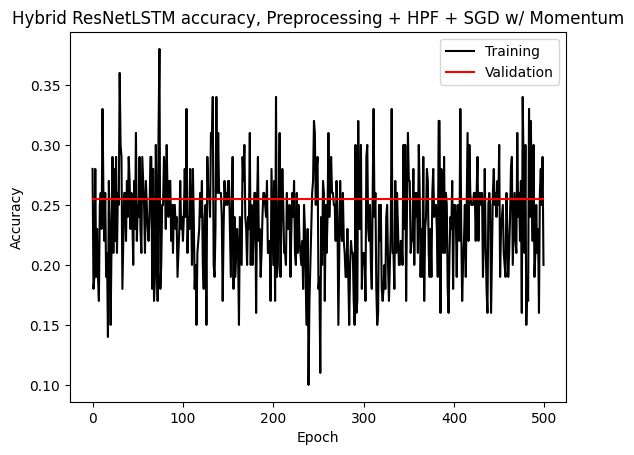

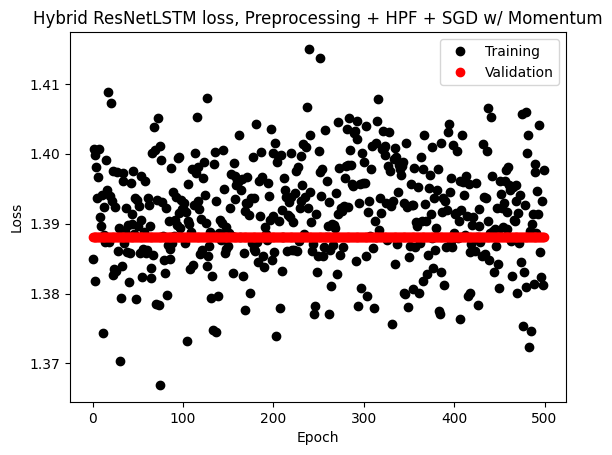

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_6,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_6,label='Validation',color='r')
plt.title('Hybrid ResNetLSTM accuracy, Preprocessing + HPF + SGD w/ Momentum')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_6,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_6,'o',label='Validation',color='r')
plt.title('Hybrid ResNetLSTM loss, Preprocessing + HPF + SGD w/ Momentum')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 6b: Adagrad + Preprocessing + HPF

In [34]:
#Build the model
model7 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model7)
total_params = sum(p.numel() for p in model7.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model7.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model7.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model6.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_7, val_history_7 = np.array([]), np.array([])
train_loss_hist_7, val_loss_hist_7 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model7_params.pt')
    torch.save(model7.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model7.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model7(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model7.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model7(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_7 = np.append(train_history_7, train_acc.item())
        val_history_7 = np.append(val_history_7, val_acc.item())
        train_loss_hist_7 = np.append(train_loss_hist_7, loss.item())
        val_loss_hist_7 = np.append(val_loss_hist_7, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model7.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-23-41406553bdee>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:03<25:29,  3.07s/it]

Epoch 1 Finished!!!
Train acc: 0.300, Val acc: 0.229
Train loss: 1.381, Val loss: 1.388


  0%|          | 2/500 [00:06<25:07,  3.03s/it]

Epoch 2 Finished!!!
Train acc: 0.290, Val acc: 0.229
Train loss: 1.382, Val loss: 1.388


  1%|          | 3/500 [00:09<25:02,  3.02s/it]

Epoch 3 Finished!!!
Train acc: 0.180, Val acc: 0.229
Train loss: 1.392, Val loss: 1.388


  1%|          | 4/500 [00:12<25:05,  3.03s/it]

Epoch 4 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.382, Val loss: 1.385


  1%|          | 5/500 [00:15<25:08,  3.05s/it]

Epoch 5 Finished!!!
Train acc: 0.330, Val acc: 0.296
Train loss: 1.375, Val loss: 1.380


  1%|          | 6/500 [00:18<25:08,  3.05s/it]

Epoch 6 Finished!!!
Train acc: 0.290, Val acc: 0.277
Train loss: 1.378, Val loss: 1.379


  1%|▏         | 7/500 [00:21<25:15,  3.07s/it]

Epoch 7 Finished!!!
Train acc: 0.400, Val acc: 0.357
Train loss: 1.349, Val loss: 1.369


  2%|▏         | 8/500 [00:24<25:22,  3.09s/it]

Epoch 8 Finished!!!
Train acc: 0.440, Val acc: 0.376
Train loss: 1.352, Val loss: 1.364


  2%|▏         | 9/500 [00:28<26:55,  3.29s/it]

Epoch 9 Finished!!!
Train acc: 0.320, Val acc: 0.357
Train loss: 1.375, Val loss: 1.366


  2%|▏         | 10/500 [00:31<26:53,  3.29s/it]

Epoch 10 Finished!!!
Train acc: 0.450, Val acc: 0.392
Train loss: 1.356, Val loss: 1.357


  2%|▏         | 11/500 [00:34<26:20,  3.23s/it]

Epoch 11 Finished!!!
Train acc: 0.400, Val acc: 0.395
Train loss: 1.351, Val loss: 1.351


  2%|▏         | 12/500 [00:37<26:00,  3.20s/it]

Epoch 12 Finished!!!
Train acc: 0.300, Val acc: 0.395
Train loss: 1.374, Val loss: 1.349


  3%|▎         | 13/500 [00:40<25:32,  3.15s/it]

Epoch 13 Finished!!!
Train acc: 0.450, Val acc: 0.395
Train loss: 1.345, Val loss: 1.347


  3%|▎         | 14/500 [00:43<25:15,  3.12s/it]

Epoch 14 Finished!!!
Train acc: 0.370, Val acc: 0.426
Train loss: 1.348, Val loss: 1.343


  3%|▎         | 15/500 [00:46<24:57,  3.09s/it]

Epoch 15 Finished!!!
Train acc: 0.420, Val acc: 0.414
Train loss: 1.343, Val loss: 1.343


  3%|▎         | 16/500 [00:49<24:44,  3.07s/it]

Epoch 16 Finished!!!
Train acc: 0.410, Val acc: 0.421
Train loss: 1.342, Val loss: 1.339


  3%|▎         | 17/500 [00:52<24:34,  3.05s/it]

Epoch 17 Finished!!!
Train acc: 0.490, Val acc: 0.421
Train loss: 1.332, Val loss: 1.341


  4%|▎         | 18/500 [00:55<24:26,  3.04s/it]

Epoch 18 Finished!!!
Train acc: 0.460, Val acc: 0.418
Train loss: 1.333, Val loss: 1.335


  4%|▍         | 19/500 [00:58<24:20,  3.04s/it]

Epoch 19 Finished!!!
Train acc: 0.400, Val acc: 0.409
Train loss: 1.344, Val loss: 1.335


  4%|▍         | 20/500 [01:01<24:14,  3.03s/it]

Epoch 20 Finished!!!
Train acc: 0.420, Val acc: 0.404
Train loss: 1.332, Val loss: 1.336


  4%|▍         | 21/500 [01:04<24:09,  3.03s/it]

Epoch 21 Finished!!!
Train acc: 0.370, Val acc: 0.411
Train loss: 1.349, Val loss: 1.333


  4%|▍         | 22/500 [01:07<24:05,  3.02s/it]

Epoch 22 Finished!!!
Train acc: 0.390, Val acc: 0.416
Train loss: 1.338, Val loss: 1.335


  5%|▍         | 23/500 [01:11<24:02,  3.02s/it]

Epoch 23 Finished!!!
Train acc: 0.400, Val acc: 0.402
Train loss: 1.339, Val loss: 1.332


  5%|▍         | 24/500 [01:14<23:58,  3.02s/it]

Epoch 24 Finished!!!
Train acc: 0.440, Val acc: 0.414
Train loss: 1.324, Val loss: 1.330


  5%|▌         | 25/500 [01:17<23:55,  3.02s/it]

Epoch 25 Finished!!!
Train acc: 0.450, Val acc: 0.421
Train loss: 1.318, Val loss: 1.329


  5%|▌         | 26/500 [01:20<23:52,  3.02s/it]

Epoch 26 Finished!!!
Train acc: 0.420, Val acc: 0.411
Train loss: 1.335, Val loss: 1.329


  5%|▌         | 27/500 [01:23<23:53,  3.03s/it]

Epoch 27 Finished!!!
Train acc: 0.440, Val acc: 0.430
Train loss: 1.327, Val loss: 1.328


  6%|▌         | 28/500 [01:26<23:49,  3.03s/it]

Epoch 28 Finished!!!
Train acc: 0.460, Val acc: 0.426
Train loss: 1.324, Val loss: 1.327


  6%|▌         | 29/500 [01:29<23:46,  3.03s/it]

Epoch 29 Finished!!!
Train acc: 0.430, Val acc: 0.418
Train loss: 1.322, Val loss: 1.325


  6%|▌         | 30/500 [01:32<23:43,  3.03s/it]

Epoch 30 Finished!!!
Train acc: 0.440, Val acc: 0.426
Train loss: 1.319, Val loss: 1.324


  6%|▌         | 31/500 [01:35<23:41,  3.03s/it]

Epoch 31 Finished!!!
Train acc: 0.530, Val acc: 0.428
Train loss: 1.284, Val loss: 1.324


  6%|▋         | 32/500 [01:38<23:38,  3.03s/it]

Epoch 32 Finished!!!
Train acc: 0.440, Val acc: 0.430
Train loss: 1.319, Val loss: 1.321


  7%|▋         | 33/500 [01:41<23:35,  3.03s/it]

Epoch 33 Finished!!!
Train acc: 0.470, Val acc: 0.418
Train loss: 1.325, Val loss: 1.323


  7%|▋         | 34/500 [01:44<23:33,  3.03s/it]

Epoch 34 Finished!!!
Train acc: 0.470, Val acc: 0.426
Train loss: 1.312, Val loss: 1.322


  7%|▋         | 35/500 [01:47<23:34,  3.04s/it]

Epoch 35 Finished!!!
Train acc: 0.460, Val acc: 0.433
Train loss: 1.324, Val loss: 1.320


  7%|▋         | 36/500 [01:50<23:30,  3.04s/it]

Epoch 36 Finished!!!
Train acc: 0.480, Val acc: 0.426
Train loss: 1.305, Val loss: 1.320


  7%|▋         | 37/500 [01:53<23:29,  3.04s/it]

Epoch 37 Finished!!!
Train acc: 0.410, Val acc: 0.449
Train loss: 1.327, Val loss: 1.320


  8%|▊         | 38/500 [01:56<23:24,  3.04s/it]

Epoch 38 Finished!!!
Train acc: 0.450, Val acc: 0.418
Train loss: 1.325, Val loss: 1.320


  8%|▊         | 39/500 [01:59<23:20,  3.04s/it]

Epoch 39 Finished!!!
Train acc: 0.520, Val acc: 0.426
Train loss: 1.290, Val loss: 1.318


  8%|▊         | 40/500 [02:02<23:16,  3.04s/it]

Epoch 40 Finished!!!
Train acc: 0.420, Val acc: 0.444
Train loss: 1.334, Val loss: 1.317


  8%|▊         | 41/500 [02:05<23:13,  3.04s/it]

Epoch 41 Finished!!!
Train acc: 0.560, Val acc: 0.430
Train loss: 1.272, Val loss: 1.319


  8%|▊         | 42/500 [02:08<23:10,  3.04s/it]

Epoch 42 Finished!!!
Train acc: 0.460, Val acc: 0.433
Train loss: 1.319, Val loss: 1.317


  9%|▊         | 43/500 [02:11<23:07,  3.04s/it]

Epoch 43 Finished!!!
Train acc: 0.400, Val acc: 0.430
Train loss: 1.328, Val loss: 1.317


  9%|▉         | 44/500 [02:14<23:11,  3.05s/it]

Epoch 44 Finished!!!
Train acc: 0.500, Val acc: 0.430
Train loss: 1.297, Val loss: 1.318


  9%|▉         | 45/500 [02:17<23:06,  3.05s/it]

Epoch 45 Finished!!!
Train acc: 0.510, Val acc: 0.426
Train loss: 1.291, Val loss: 1.317


  9%|▉         | 46/500 [02:20<23:01,  3.04s/it]

Epoch 46 Finished!!!
Train acc: 0.520, Val acc: 0.435
Train loss: 1.295, Val loss: 1.315


  9%|▉         | 47/500 [02:24<23:40,  3.13s/it]

Epoch 47 Finished!!!
Train acc: 0.590, Val acc: 0.435
Train loss: 1.259, Val loss: 1.315


 10%|▉         | 48/500 [02:27<23:23,  3.10s/it]

Epoch 48 Finished!!!
Train acc: 0.370, Val acc: 0.430
Train loss: 1.327, Val loss: 1.314


 10%|▉         | 49/500 [02:30<23:10,  3.08s/it]

Epoch 49 Finished!!!
Train acc: 0.420, Val acc: 0.430
Train loss: 1.325, Val loss: 1.316


 10%|█         | 50/500 [02:33<23:00,  3.07s/it]

Epoch 50 Finished!!!
Train acc: 0.490, Val acc: 0.426
Train loss: 1.310, Val loss: 1.314


 10%|█         | 51/500 [02:36<22:53,  3.06s/it]

Epoch 51 Finished!!!
Train acc: 0.560, Val acc: 0.426
Train loss: 1.260, Val loss: 1.314


 10%|█         | 52/500 [02:39<22:46,  3.05s/it]

Epoch 52 Finished!!!
Train acc: 0.410, Val acc: 0.426
Train loss: 1.325, Val loss: 1.314


 11%|█         | 53/500 [02:42<22:41,  3.05s/it]

Epoch 53 Finished!!!
Train acc: 0.520, Val acc: 0.428
Train loss: 1.283, Val loss: 1.314


 11%|█         | 54/500 [02:45<22:36,  3.04s/it]

Epoch 54 Finished!!!
Train acc: 0.470, Val acc: 0.435
Train loss: 1.312, Val loss: 1.314


 11%|█         | 55/500 [02:48<22:32,  3.04s/it]

Epoch 55 Finished!!!
Train acc: 0.520, Val acc: 0.423
Train loss: 1.287, Val loss: 1.313


 11%|█         | 56/500 [02:51<22:28,  3.04s/it]

Epoch 56 Finished!!!
Train acc: 0.460, Val acc: 0.430
Train loss: 1.301, Val loss: 1.314


 11%|█▏        | 57/500 [02:54<22:25,  3.04s/it]

Epoch 57 Finished!!!
Train acc: 0.450, Val acc: 0.421
Train loss: 1.314, Val loss: 1.314


 12%|█▏        | 58/500 [02:57<22:21,  3.04s/it]

Epoch 58 Finished!!!
Train acc: 0.480, Val acc: 0.426
Train loss: 1.299, Val loss: 1.312


 12%|█▏        | 59/500 [03:00<22:18,  3.04s/it]

Epoch 59 Finished!!!
Train acc: 0.480, Val acc: 0.423
Train loss: 1.298, Val loss: 1.312


 12%|█▏        | 60/500 [03:03<22:15,  3.04s/it]

Epoch 60 Finished!!!
Train acc: 0.490, Val acc: 0.430
Train loss: 1.284, Val loss: 1.314


 12%|█▏        | 61/500 [03:06<22:12,  3.03s/it]

Epoch 61 Finished!!!
Train acc: 0.450, Val acc: 0.430
Train loss: 1.305, Val loss: 1.312


 12%|█▏        | 62/500 [03:09<22:08,  3.03s/it]

Epoch 62 Finished!!!
Train acc: 0.490, Val acc: 0.426
Train loss: 1.293, Val loss: 1.313


 13%|█▎        | 63/500 [03:12<22:05,  3.03s/it]

Epoch 63 Finished!!!
Train acc: 0.400, Val acc: 0.430
Train loss: 1.326, Val loss: 1.312


 13%|█▎        | 64/500 [03:15<22:02,  3.03s/it]

Epoch 64 Finished!!!
Train acc: 0.590, Val acc: 0.421
Train loss: 1.250, Val loss: 1.311


 13%|█▎        | 65/500 [03:18<22:00,  3.04s/it]

Epoch 65 Finished!!!
Train acc: 0.460, Val acc: 0.426
Train loss: 1.311, Val loss: 1.311


 13%|█▎        | 66/500 [03:21<21:56,  3.03s/it]

Epoch 66 Finished!!!
Train acc: 0.410, Val acc: 0.430
Train loss: 1.320, Val loss: 1.310


 13%|█▎        | 67/500 [03:24<21:53,  3.03s/it]

Epoch 67 Finished!!!
Train acc: 0.520, Val acc: 0.426
Train loss: 1.278, Val loss: 1.308


 14%|█▎        | 68/500 [03:27<21:49,  3.03s/it]

Epoch 68 Finished!!!
Train acc: 0.470, Val acc: 0.428
Train loss: 1.299, Val loss: 1.310


 14%|█▍        | 69/500 [03:30<21:47,  3.03s/it]

Epoch 69 Finished!!!
Train acc: 0.400, Val acc: 0.423
Train loss: 1.338, Val loss: 1.310


 14%|█▍        | 70/500 [03:33<21:44,  3.03s/it]

Epoch 70 Finished!!!
Train acc: 0.510, Val acc: 0.421
Train loss: 1.284, Val loss: 1.309


 14%|█▍        | 71/500 [03:36<21:40,  3.03s/it]

Epoch 71 Finished!!!
Train acc: 0.480, Val acc: 0.428
Train loss: 1.294, Val loss: 1.308


 14%|█▍        | 72/500 [03:40<21:37,  3.03s/it]

Epoch 72 Finished!!!
Train acc: 0.580, Val acc: 0.433
Train loss: 1.253, Val loss: 1.307


 15%|█▍        | 73/500 [03:43<21:35,  3.03s/it]

Epoch 73 Finished!!!
Train acc: 0.440, Val acc: 0.428
Train loss: 1.310, Val loss: 1.307


 15%|█▍        | 74/500 [03:46<21:32,  3.03s/it]

Epoch 74 Finished!!!
Train acc: 0.440, Val acc: 0.433
Train loss: 1.293, Val loss: 1.307


 15%|█▌        | 75/500 [03:49<21:29,  3.03s/it]

Epoch 75 Finished!!!
Train acc: 0.500, Val acc: 0.428
Train loss: 1.290, Val loss: 1.308


 15%|█▌        | 76/500 [03:52<21:26,  3.03s/it]

Epoch 76 Finished!!!
Train acc: 0.420, Val acc: 0.421
Train loss: 1.311, Val loss: 1.307


 15%|█▌        | 77/500 [03:55<21:24,  3.04s/it]

Epoch 77 Finished!!!
Train acc: 0.520, Val acc: 0.440
Train loss: 1.263, Val loss: 1.306


 16%|█▌        | 78/500 [03:58<21:20,  3.03s/it]

Epoch 78 Finished!!!
Train acc: 0.530, Val acc: 0.428
Train loss: 1.263, Val loss: 1.307


 16%|█▌        | 79/500 [04:01<21:26,  3.06s/it]

Epoch 79 Finished!!!
Train acc: 0.420, Val acc: 0.430
Train loss: 1.309, Val loss: 1.305


 16%|█▌        | 80/500 [04:04<21:20,  3.05s/it]

Epoch 80 Finished!!!
Train acc: 0.440, Val acc: 0.433
Train loss: 1.307, Val loss: 1.306


 16%|█▌        | 81/500 [04:07<21:15,  3.04s/it]

Epoch 81 Finished!!!
Train acc: 0.490, Val acc: 0.430
Train loss: 1.277, Val loss: 1.305


 16%|█▋        | 82/500 [04:10<21:51,  3.14s/it]

Epoch 82 Finished!!!
Train acc: 0.580, Val acc: 0.442
Train loss: 1.248, Val loss: 1.305


 17%|█▋        | 83/500 [04:13<21:35,  3.11s/it]

Epoch 83 Finished!!!
Train acc: 0.530, Val acc: 0.435
Train loss: 1.252, Val loss: 1.304


 17%|█▋        | 84/500 [04:16<21:22,  3.08s/it]

Epoch 84 Finished!!!
Train acc: 0.460, Val acc: 0.435
Train loss: 1.301, Val loss: 1.305


 17%|█▋        | 85/500 [04:19<21:13,  3.07s/it]

Epoch 85 Finished!!!
Train acc: 0.470, Val acc: 0.433
Train loss: 1.297, Val loss: 1.306


 17%|█▋        | 86/500 [04:22<21:06,  3.06s/it]

Epoch 86 Finished!!!
Train acc: 0.590, Val acc: 0.442
Train loss: 1.248, Val loss: 1.303


 17%|█▋        | 87/500 [04:25<20:59,  3.05s/it]

Epoch 87 Finished!!!
Train acc: 0.470, Val acc: 0.440
Train loss: 1.298, Val loss: 1.303


 18%|█▊        | 88/500 [04:28<20:54,  3.04s/it]

Epoch 88 Finished!!!
Train acc: 0.550, Val acc: 0.435
Train loss: 1.256, Val loss: 1.304


 18%|█▊        | 89/500 [04:32<20:50,  3.04s/it]

Epoch 89 Finished!!!
Train acc: 0.490, Val acc: 0.430
Train loss: 1.275, Val loss: 1.304


 18%|█▊        | 90/500 [04:35<20:46,  3.04s/it]

Epoch 90 Finished!!!
Train acc: 0.500, Val acc: 0.433
Train loss: 1.260, Val loss: 1.304


 18%|█▊        | 91/500 [04:38<20:42,  3.04s/it]

Epoch 91 Finished!!!
Train acc: 0.510, Val acc: 0.430
Train loss: 1.273, Val loss: 1.303


 18%|█▊        | 92/500 [04:41<20:38,  3.04s/it]

Epoch 92 Finished!!!
Train acc: 0.580, Val acc: 0.430
Train loss: 1.239, Val loss: 1.305


 19%|█▊        | 93/500 [04:44<20:35,  3.04s/it]

Epoch 93 Finished!!!
Train acc: 0.490, Val acc: 0.430
Train loss: 1.274, Val loss: 1.305


 19%|█▉        | 94/500 [04:47<20:32,  3.04s/it]

Epoch 94 Finished!!!
Train acc: 0.450, Val acc: 0.433
Train loss: 1.310, Val loss: 1.303


 19%|█▉        | 95/500 [04:50<20:29,  3.04s/it]

Epoch 95 Finished!!!
Train acc: 0.560, Val acc: 0.433
Train loss: 1.245, Val loss: 1.303


 19%|█▉        | 96/500 [04:53<20:26,  3.03s/it]

Epoch 96 Finished!!!
Train acc: 0.420, Val acc: 0.435
Train loss: 1.295, Val loss: 1.302


 19%|█▉        | 97/500 [04:56<20:22,  3.03s/it]

Epoch 97 Finished!!!
Train acc: 0.520, Val acc: 0.444
Train loss: 1.249, Val loss: 1.301


 20%|█▉        | 98/500 [04:59<20:20,  3.04s/it]

Epoch 98 Finished!!!
Train acc: 0.490, Val acc: 0.440
Train loss: 1.284, Val loss: 1.300


 20%|█▉        | 99/500 [05:02<20:16,  3.03s/it]

Epoch 99 Finished!!!
Train acc: 0.510, Val acc: 0.430
Train loss: 1.279, Val loss: 1.304


 20%|██        | 100/500 [05:05<20:13,  3.03s/it]

Epoch 100 Finished!!!
Train acc: 0.440, Val acc: 0.433
Train loss: 1.294, Val loss: 1.301


 20%|██        | 101/500 [05:08<20:10,  3.03s/it]

Epoch 101 Finished!!!
Train acc: 0.410, Val acc: 0.447
Train loss: 1.325, Val loss: 1.300


 20%|██        | 102/500 [05:11<20:07,  3.03s/it]

Epoch 102 Finished!!!
Train acc: 0.460, Val acc: 0.440
Train loss: 1.292, Val loss: 1.299


 21%|██        | 103/500 [05:14<20:04,  3.03s/it]

Epoch 103 Finished!!!
Train acc: 0.570, Val acc: 0.437
Train loss: 1.243, Val loss: 1.299


 21%|██        | 104/500 [05:17<20:01,  3.03s/it]

Epoch 104 Finished!!!
Train acc: 0.520, Val acc: 0.440
Train loss: 1.266, Val loss: 1.299


 21%|██        | 105/500 [05:20<19:58,  3.03s/it]

Epoch 105 Finished!!!
Train acc: 0.420, Val acc: 0.444
Train loss: 1.310, Val loss: 1.300


 21%|██        | 106/500 [05:23<19:55,  3.03s/it]

Epoch 106 Finished!!!
Train acc: 0.450, Val acc: 0.440
Train loss: 1.275, Val loss: 1.298


 21%|██▏       | 107/500 [05:26<19:51,  3.03s/it]

Epoch 107 Finished!!!
Train acc: 0.560, Val acc: 0.449
Train loss: 1.234, Val loss: 1.297


 22%|██▏       | 108/500 [05:29<19:48,  3.03s/it]

Epoch 108 Finished!!!
Train acc: 0.560, Val acc: 0.442
Train loss: 1.249, Val loss: 1.302


 22%|██▏       | 109/500 [05:32<19:46,  3.03s/it]

Epoch 109 Finished!!!
Train acc: 0.570, Val acc: 0.440
Train loss: 1.237, Val loss: 1.298


 22%|██▏       | 110/500 [05:35<19:43,  3.03s/it]

Epoch 110 Finished!!!
Train acc: 0.460, Val acc: 0.447
Train loss: 1.290, Val loss: 1.298


 22%|██▏       | 111/500 [05:38<19:40,  3.03s/it]

Epoch 111 Finished!!!
Train acc: 0.450, Val acc: 0.440
Train loss: 1.286, Val loss: 1.299


 22%|██▏       | 112/500 [05:41<19:37,  3.03s/it]

Epoch 112 Finished!!!
Train acc: 0.430, Val acc: 0.442
Train loss: 1.283, Val loss: 1.298


 23%|██▎       | 113/500 [05:44<19:33,  3.03s/it]

Epoch 113 Finished!!!
Train acc: 0.510, Val acc: 0.433
Train loss: 1.276, Val loss: 1.298


 23%|██▎       | 114/500 [05:47<19:30,  3.03s/it]

Epoch 114 Finished!!!
Train acc: 0.520, Val acc: 0.444
Train loss: 1.242, Val loss: 1.298


 23%|██▎       | 115/500 [05:50<19:27,  3.03s/it]

Epoch 115 Finished!!!
Train acc: 0.590, Val acc: 0.442
Train loss: 1.222, Val loss: 1.298


 23%|██▎       | 116/500 [05:53<19:24,  3.03s/it]

Epoch 116 Finished!!!
Train acc: 0.500, Val acc: 0.449
Train loss: 1.272, Val loss: 1.296


 23%|██▎       | 117/500 [05:57<19:30,  3.06s/it]

Epoch 117 Finished!!!
Train acc: 0.440, Val acc: 0.447
Train loss: 1.274, Val loss: 1.295


 24%|██▎       | 118/500 [06:00<19:25,  3.05s/it]

Epoch 118 Finished!!!
Train acc: 0.550, Val acc: 0.437
Train loss: 1.242, Val loss: 1.301


 24%|██▍       | 119/500 [06:03<19:20,  3.05s/it]

Epoch 119 Finished!!!
Train acc: 0.580, Val acc: 0.442
Train loss: 1.235, Val loss: 1.297


 24%|██▍       | 120/500 [06:06<19:16,  3.04s/it]

Epoch 120 Finished!!!
Train acc: 0.400, Val acc: 0.437
Train loss: 1.319, Val loss: 1.295


 24%|██▍       | 121/500 [06:09<19:12,  3.04s/it]

Epoch 121 Finished!!!
Train acc: 0.470, Val acc: 0.442
Train loss: 1.292, Val loss: 1.296


 24%|██▍       | 122/500 [06:12<19:08,  3.04s/it]

Epoch 122 Finished!!!
Train acc: 0.600, Val acc: 0.440
Train loss: 1.224, Val loss: 1.296


 25%|██▍       | 123/500 [06:15<19:04,  3.04s/it]

Epoch 123 Finished!!!
Train acc: 0.470, Val acc: 0.435
Train loss: 1.291, Val loss: 1.300


 25%|██▍       | 124/500 [06:18<19:01,  3.04s/it]

Epoch 124 Finished!!!
Train acc: 0.540, Val acc: 0.433
Train loss: 1.235, Val loss: 1.301


 25%|██▌       | 125/500 [06:21<18:58,  3.04s/it]

Epoch 125 Finished!!!
Train acc: 0.610, Val acc: 0.435
Train loss: 1.213, Val loss: 1.298


 25%|██▌       | 126/500 [06:24<18:55,  3.03s/it]

Epoch 126 Finished!!!
Train acc: 0.510, Val acc: 0.442
Train loss: 1.252, Val loss: 1.296


 25%|██▌       | 127/500 [06:27<18:51,  3.03s/it]

Epoch 127 Finished!!!
Train acc: 0.520, Val acc: 0.442
Train loss: 1.253, Val loss: 1.295


 26%|██▌       | 128/500 [06:30<18:48,  3.03s/it]

Epoch 128 Finished!!!
Train acc: 0.570, Val acc: 0.440
Train loss: 1.224, Val loss: 1.297


 26%|██▌       | 129/500 [06:33<18:45,  3.03s/it]

Epoch 129 Finished!!!
Train acc: 0.510, Val acc: 0.442
Train loss: 1.296, Val loss: 1.295


 26%|██▌       | 130/500 [06:36<18:42,  3.03s/it]

Epoch 130 Finished!!!
Train acc: 0.480, Val acc: 0.437
Train loss: 1.278, Val loss: 1.298


 26%|██▌       | 131/500 [06:39<18:39,  3.03s/it]

Epoch 131 Finished!!!
Train acc: 0.460, Val acc: 0.437
Train loss: 1.299, Val loss: 1.296


 26%|██▋       | 132/500 [06:42<18:36,  3.03s/it]

Epoch 132 Finished!!!
Train acc: 0.470, Val acc: 0.444
Train loss: 1.269, Val loss: 1.293


 27%|██▋       | 133/500 [06:45<18:33,  3.03s/it]

Epoch 133 Finished!!!
Train acc: 0.570, Val acc: 0.440
Train loss: 1.241, Val loss: 1.295


 27%|██▋       | 134/500 [06:48<18:30,  3.03s/it]

Epoch 134 Finished!!!
Train acc: 0.500, Val acc: 0.444
Train loss: 1.261, Val loss: 1.293


 27%|██▋       | 135/500 [06:51<18:27,  3.03s/it]

Epoch 135 Finished!!!
Train acc: 0.550, Val acc: 0.447
Train loss: 1.238, Val loss: 1.292


 27%|██▋       | 136/500 [06:54<18:23,  3.03s/it]

Epoch 136 Finished!!!
Train acc: 0.550, Val acc: 0.440
Train loss: 1.237, Val loss: 1.295


 27%|██▋       | 137/500 [06:57<18:20,  3.03s/it]

Epoch 137 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.255, Val loss: 1.293


 28%|██▊       | 138/500 [07:00<18:17,  3.03s/it]

Epoch 138 Finished!!!
Train acc: 0.540, Val acc: 0.442
Train loss: 1.243, Val loss: 1.294


 28%|██▊       | 139/500 [07:03<18:14,  3.03s/it]

Epoch 139 Finished!!!
Train acc: 0.620, Val acc: 0.447
Train loss: 1.216, Val loss: 1.296


 28%|██▊       | 140/500 [07:06<18:11,  3.03s/it]

Epoch 140 Finished!!!
Train acc: 0.530, Val acc: 0.440
Train loss: 1.274, Val loss: 1.293


 28%|██▊       | 141/500 [07:09<18:08,  3.03s/it]

Epoch 141 Finished!!!
Train acc: 0.500, Val acc: 0.437
Train loss: 1.262, Val loss: 1.293


 28%|██▊       | 142/500 [07:12<18:05,  3.03s/it]

Epoch 142 Finished!!!
Train acc: 0.510, Val acc: 0.442
Train loss: 1.268, Val loss: 1.295


 29%|██▊       | 143/500 [07:15<18:03,  3.03s/it]

Epoch 143 Finished!!!
Train acc: 0.590, Val acc: 0.440
Train loss: 1.205, Val loss: 1.290


 29%|██▉       | 144/500 [07:18<18:00,  3.03s/it]

Epoch 144 Finished!!!
Train acc: 0.480, Val acc: 0.449
Train loss: 1.286, Val loss: 1.291


 29%|██▉       | 145/500 [07:21<17:57,  3.03s/it]

Epoch 145 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.221, Val loss: 1.292


 29%|██▉       | 146/500 [07:25<17:53,  3.03s/it]

Epoch 146 Finished!!!
Train acc: 0.460, Val acc: 0.440
Train loss: 1.301, Val loss: 1.293


 29%|██▉       | 147/500 [07:28<17:50,  3.03s/it]

Epoch 147 Finished!!!
Train acc: 0.520, Val acc: 0.435
Train loss: 1.264, Val loss: 1.293


 30%|██▉       | 148/500 [07:31<17:48,  3.03s/it]

Epoch 148 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.244, Val loss: 1.292


 30%|██▉       | 149/500 [07:34<17:45,  3.04s/it]

Epoch 149 Finished!!!
Train acc: 0.570, Val acc: 0.440
Train loss: 1.231, Val loss: 1.292


 30%|███       | 150/500 [07:37<17:42,  3.04s/it]

Epoch 150 Finished!!!
Train acc: 0.510, Val acc: 0.440
Train loss: 1.243, Val loss: 1.292


 30%|███       | 151/500 [07:40<17:39,  3.04s/it]

Epoch 151 Finished!!!
Train acc: 0.450, Val acc: 0.440
Train loss: 1.318, Val loss: 1.291


 30%|███       | 152/500 [07:43<17:36,  3.04s/it]

Epoch 152 Finished!!!
Train acc: 0.570, Val acc: 0.437
Train loss: 1.237, Val loss: 1.292


 31%|███       | 153/500 [07:46<17:33,  3.04s/it]

Epoch 153 Finished!!!
Train acc: 0.570, Val acc: 0.433
Train loss: 1.221, Val loss: 1.293


 31%|███       | 154/500 [07:49<17:30,  3.04s/it]

Epoch 154 Finished!!!
Train acc: 0.440, Val acc: 0.440
Train loss: 1.293, Val loss: 1.292


 31%|███       | 155/500 [07:52<17:26,  3.03s/it]

Epoch 155 Finished!!!
Train acc: 0.490, Val acc: 0.440
Train loss: 1.259, Val loss: 1.292


 31%|███       | 156/500 [07:55<17:23,  3.03s/it]

Epoch 156 Finished!!!
Train acc: 0.610, Val acc: 0.433
Train loss: 1.209, Val loss: 1.292


 31%|███▏      | 157/500 [07:58<17:21,  3.04s/it]

Epoch 157 Finished!!!
Train acc: 0.390, Val acc: 0.437
Train loss: 1.316, Val loss: 1.293


 32%|███▏      | 158/500 [08:01<17:17,  3.03s/it]

Epoch 158 Finished!!!
Train acc: 0.530, Val acc: 0.442
Train loss: 1.247, Val loss: 1.290


 32%|███▏      | 159/500 [08:04<17:14,  3.03s/it]

Epoch 159 Finished!!!
Train acc: 0.540, Val acc: 0.442
Train loss: 1.238, Val loss: 1.292


 32%|███▏      | 160/500 [08:07<17:11,  3.03s/it]

Epoch 160 Finished!!!
Train acc: 0.510, Val acc: 0.437
Train loss: 1.256, Val loss: 1.292


 32%|███▏      | 161/500 [08:10<17:09,  3.04s/it]

Epoch 161 Finished!!!
Train acc: 0.420, Val acc: 0.440
Train loss: 1.307, Val loss: 1.292


 32%|███▏      | 162/500 [08:13<17:05,  3.03s/it]

Epoch 162 Finished!!!
Train acc: 0.460, Val acc: 0.442
Train loss: 1.289, Val loss: 1.292


 33%|███▎      | 163/500 [08:16<17:02,  3.03s/it]

Epoch 163 Finished!!!
Train acc: 0.480, Val acc: 0.444
Train loss: 1.265, Val loss: 1.292


 33%|███▎      | 164/500 [08:19<16:59,  3.03s/it]

Epoch 164 Finished!!!
Train acc: 0.530, Val acc: 0.440
Train loss: 1.275, Val loss: 1.291


 33%|███▎      | 165/500 [08:22<16:56,  3.03s/it]

Epoch 165 Finished!!!
Train acc: 0.480, Val acc: 0.435
Train loss: 1.266, Val loss: 1.292


 33%|███▎      | 166/500 [08:25<16:52,  3.03s/it]

Epoch 166 Finished!!!
Train acc: 0.490, Val acc: 0.449
Train loss: 1.270, Val loss: 1.292


 33%|███▎      | 167/500 [08:28<16:49,  3.03s/it]

Epoch 167 Finished!!!
Train acc: 0.450, Val acc: 0.433
Train loss: 1.289, Val loss: 1.295


 34%|███▎      | 168/500 [08:31<16:46,  3.03s/it]

Epoch 168 Finished!!!
Train acc: 0.520, Val acc: 0.433
Train loss: 1.262, Val loss: 1.292


 34%|███▍      | 169/500 [08:34<16:43,  3.03s/it]

Epoch 169 Finished!!!
Train acc: 0.450, Val acc: 0.442
Train loss: 1.288, Val loss: 1.291


 34%|███▍      | 170/500 [08:37<16:40,  3.03s/it]

Epoch 170 Finished!!!
Train acc: 0.450, Val acc: 0.440
Train loss: 1.306, Val loss: 1.292


 34%|███▍      | 171/500 [08:40<16:37,  3.03s/it]

Epoch 171 Finished!!!
Train acc: 0.600, Val acc: 0.430
Train loss: 1.206, Val loss: 1.291


 34%|███▍      | 172/500 [08:43<16:34,  3.03s/it]

Epoch 172 Finished!!!
Train acc: 0.450, Val acc: 0.437
Train loss: 1.287, Val loss: 1.290


 35%|███▍      | 173/500 [08:46<16:31,  3.03s/it]

Epoch 173 Finished!!!
Train acc: 0.460, Val acc: 0.440
Train loss: 1.296, Val loss: 1.291


 35%|███▍      | 174/500 [08:49<16:28,  3.03s/it]

Epoch 174 Finished!!!
Train acc: 0.550, Val acc: 0.442
Train loss: 1.215, Val loss: 1.290


 35%|███▌      | 175/500 [08:52<16:25,  3.03s/it]

Epoch 175 Finished!!!
Train acc: 0.540, Val acc: 0.449
Train loss: 1.254, Val loss: 1.288


 35%|███▌      | 176/500 [08:56<16:22,  3.03s/it]

Epoch 176 Finished!!!
Train acc: 0.400, Val acc: 0.447
Train loss: 1.291, Val loss: 1.289


 35%|███▌      | 177/500 [08:59<16:18,  3.03s/it]

Epoch 177 Finished!!!
Train acc: 0.560, Val acc: 0.435
Train loss: 1.222, Val loss: 1.289


 36%|███▌      | 178/500 [09:02<16:15,  3.03s/it]

Epoch 178 Finished!!!
Train acc: 0.530, Val acc: 0.437
Train loss: 1.242, Val loss: 1.291


 36%|███▌      | 179/500 [09:05<16:12,  3.03s/it]

Epoch 179 Finished!!!
Train acc: 0.470, Val acc: 0.440
Train loss: 1.280, Val loss: 1.289


 36%|███▌      | 180/500 [09:08<16:09,  3.03s/it]

Epoch 180 Finished!!!
Train acc: 0.560, Val acc: 0.437
Train loss: 1.227, Val loss: 1.290


 36%|███▌      | 181/500 [09:11<16:07,  3.03s/it]

Epoch 181 Finished!!!
Train acc: 0.530, Val acc: 0.433
Train loss: 1.220, Val loss: 1.291


 36%|███▋      | 182/500 [09:14<16:04,  3.03s/it]

Epoch 182 Finished!!!
Train acc: 0.570, Val acc: 0.444
Train loss: 1.226, Val loss: 1.288


 37%|███▋      | 183/500 [09:17<16:01,  3.03s/it]

Epoch 183 Finished!!!
Train acc: 0.560, Val acc: 0.435
Train loss: 1.218, Val loss: 1.290


 37%|███▋      | 184/500 [09:20<15:58,  3.03s/it]

Epoch 184 Finished!!!
Train acc: 0.440, Val acc: 0.437
Train loss: 1.306, Val loss: 1.289


 37%|███▋      | 185/500 [09:23<15:54,  3.03s/it]

Epoch 185 Finished!!!
Train acc: 0.550, Val acc: 0.430
Train loss: 1.228, Val loss: 1.293


 37%|███▋      | 186/500 [09:26<15:52,  3.03s/it]

Epoch 186 Finished!!!
Train acc: 0.540, Val acc: 0.442
Train loss: 1.235, Val loss: 1.288


 37%|███▋      | 187/500 [09:29<15:48,  3.03s/it]

Epoch 187 Finished!!!
Train acc: 0.600, Val acc: 0.437
Train loss: 1.202, Val loss: 1.296


 38%|███▊      | 188/500 [09:32<15:45,  3.03s/it]

Epoch 188 Finished!!!
Train acc: 0.500, Val acc: 0.442
Train loss: 1.262, Val loss: 1.287


 38%|███▊      | 189/500 [09:35<15:42,  3.03s/it]

Epoch 189 Finished!!!
Train acc: 0.520, Val acc: 0.447
Train loss: 1.247, Val loss: 1.287


 38%|███▊      | 190/500 [09:38<15:40,  3.03s/it]

Epoch 190 Finished!!!
Train acc: 0.660, Val acc: 0.442
Train loss: 1.186, Val loss: 1.286


 38%|███▊      | 191/500 [09:41<15:37,  3.03s/it]

Epoch 191 Finished!!!
Train acc: 0.450, Val acc: 0.437
Train loss: 1.278, Val loss: 1.291


 38%|███▊      | 192/500 [09:44<15:34,  3.03s/it]

Epoch 192 Finished!!!
Train acc: 0.570, Val acc: 0.442
Train loss: 1.243, Val loss: 1.290


 39%|███▊      | 193/500 [09:47<15:30,  3.03s/it]

Epoch 193 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.246, Val loss: 1.288


 39%|███▉      | 194/500 [09:50<15:27,  3.03s/it]

Epoch 194 Finished!!!
Train acc: 0.510, Val acc: 0.440
Train loss: 1.240, Val loss: 1.288


 39%|███▉      | 195/500 [09:53<15:25,  3.03s/it]

Epoch 195 Finished!!!
Train acc: 0.550, Val acc: 0.442
Train loss: 1.226, Val loss: 1.288


 39%|███▉      | 196/500 [09:56<15:21,  3.03s/it]

Epoch 196 Finished!!!
Train acc: 0.510, Val acc: 0.440
Train loss: 1.252, Val loss: 1.288


 39%|███▉      | 197/500 [09:59<15:18,  3.03s/it]

Epoch 197 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.254, Val loss: 1.290


 40%|███▉      | 198/500 [10:02<15:14,  3.03s/it]

Epoch 198 Finished!!!
Train acc: 0.490, Val acc: 0.442
Train loss: 1.262, Val loss: 1.291


 40%|███▉      | 199/500 [10:05<15:11,  3.03s/it]

Epoch 199 Finished!!!
Train acc: 0.570, Val acc: 0.442
Train loss: 1.236, Val loss: 1.290


 40%|████      | 200/500 [10:08<15:08,  3.03s/it]

Epoch 200 Finished!!!
Train acc: 0.550, Val acc: 0.447
Train loss: 1.214, Val loss: 1.288


 40%|████      | 201/500 [10:11<15:05,  3.03s/it]

Epoch 201 Finished!!!
Train acc: 0.540, Val acc: 0.444
Train loss: 1.222, Val loss: 1.286


 40%|████      | 202/500 [10:14<15:02,  3.03s/it]

Epoch 202 Finished!!!
Train acc: 0.520, Val acc: 0.444
Train loss: 1.248, Val loss: 1.288


 41%|████      | 203/500 [10:17<15:00,  3.03s/it]

Epoch 203 Finished!!!
Train acc: 0.560, Val acc: 0.452
Train loss: 1.238, Val loss: 1.286


 41%|████      | 204/500 [10:20<14:57,  3.03s/it]

Epoch 204 Finished!!!
Train acc: 0.520, Val acc: 0.428
Train loss: 1.243, Val loss: 1.294


 41%|████      | 205/500 [10:23<14:54,  3.03s/it]

Epoch 205 Finished!!!
Train acc: 0.500, Val acc: 0.440
Train loss: 1.252, Val loss: 1.286


 41%|████      | 206/500 [10:26<14:51,  3.03s/it]

Epoch 206 Finished!!!
Train acc: 0.520, Val acc: 0.437
Train loss: 1.263, Val loss: 1.287


 41%|████▏     | 207/500 [10:29<14:48,  3.03s/it]

Epoch 207 Finished!!!
Train acc: 0.470, Val acc: 0.442
Train loss: 1.272, Val loss: 1.289


 42%|████▏     | 208/500 [10:33<14:45,  3.03s/it]

Epoch 208 Finished!!!
Train acc: 0.500, Val acc: 0.452
Train loss: 1.271, Val loss: 1.287


 42%|████▏     | 209/500 [10:36<14:42,  3.03s/it]

Epoch 209 Finished!!!
Train acc: 0.450, Val acc: 0.440
Train loss: 1.299, Val loss: 1.286


 42%|████▏     | 210/500 [10:39<14:38,  3.03s/it]

Epoch 210 Finished!!!
Train acc: 0.580, Val acc: 0.440
Train loss: 1.219, Val loss: 1.290


 42%|████▏     | 211/500 [10:42<14:35,  3.03s/it]

Epoch 211 Finished!!!
Train acc: 0.470, Val acc: 0.447
Train loss: 1.279, Val loss: 1.285


 42%|████▏     | 212/500 [10:45<14:32,  3.03s/it]

Epoch 212 Finished!!!
Train acc: 0.540, Val acc: 0.449
Train loss: 1.239, Val loss: 1.288


 43%|████▎     | 213/500 [10:48<14:29,  3.03s/it]

Epoch 213 Finished!!!
Train acc: 0.550, Val acc: 0.444
Train loss: 1.235, Val loss: 1.287


 43%|████▎     | 214/500 [10:51<14:26,  3.03s/it]

Epoch 214 Finished!!!
Train acc: 0.480, Val acc: 0.442
Train loss: 1.254, Val loss: 1.286


 43%|████▎     | 215/500 [10:54<14:23,  3.03s/it]

Epoch 215 Finished!!!
Train acc: 0.550, Val acc: 0.435
Train loss: 1.226, Val loss: 1.285


 43%|████▎     | 216/500 [10:57<14:20,  3.03s/it]

Epoch 216 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.246, Val loss: 1.285


 43%|████▎     | 217/500 [11:00<14:17,  3.03s/it]

Epoch 217 Finished!!!
Train acc: 0.450, Val acc: 0.447
Train loss: 1.270, Val loss: 1.288


 44%|████▎     | 218/500 [11:03<14:14,  3.03s/it]

Epoch 218 Finished!!!
Train acc: 0.510, Val acc: 0.444
Train loss: 1.248, Val loss: 1.285


 44%|████▍     | 219/500 [11:06<14:11,  3.03s/it]

Epoch 219 Finished!!!
Train acc: 0.450, Val acc: 0.442
Train loss: 1.300, Val loss: 1.289


 44%|████▍     | 220/500 [11:09<14:08,  3.03s/it]

Epoch 220 Finished!!!
Train acc: 0.560, Val acc: 0.449
Train loss: 1.222, Val loss: 1.285


 44%|████▍     | 221/500 [11:12<14:05,  3.03s/it]

Epoch 221 Finished!!!
Train acc: 0.520, Val acc: 0.435
Train loss: 1.253, Val loss: 1.291


 44%|████▍     | 222/500 [11:15<14:02,  3.03s/it]

Epoch 222 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.236, Val loss: 1.286


 45%|████▍     | 223/500 [11:18<13:59,  3.03s/it]

Epoch 223 Finished!!!
Train acc: 0.560, Val acc: 0.440
Train loss: 1.213, Val loss: 1.286


 45%|████▍     | 224/500 [11:21<13:56,  3.03s/it]

Epoch 224 Finished!!!
Train acc: 0.510, Val acc: 0.433
Train loss: 1.255, Val loss: 1.292


 45%|████▌     | 225/500 [11:24<13:53,  3.03s/it]

Epoch 225 Finished!!!
Train acc: 0.500, Val acc: 0.442
Train loss: 1.250, Val loss: 1.285


 45%|████▌     | 226/500 [11:27<13:49,  3.03s/it]

Epoch 226 Finished!!!
Train acc: 0.520, Val acc: 0.440
Train loss: 1.234, Val loss: 1.284


 45%|████▌     | 227/500 [11:30<13:47,  3.03s/it]

Epoch 227 Finished!!!
Train acc: 0.580, Val acc: 0.444
Train loss: 1.223, Val loss: 1.287


 46%|████▌     | 228/500 [11:33<13:46,  3.04s/it]

Epoch 228 Finished!!!
Train acc: 0.510, Val acc: 0.442
Train loss: 1.242, Val loss: 1.289


 46%|████▌     | 229/500 [11:36<13:43,  3.04s/it]

Epoch 229 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.249, Val loss: 1.286


 46%|████▌     | 230/500 [11:39<13:39,  3.04s/it]

Epoch 230 Finished!!!
Train acc: 0.590, Val acc: 0.449
Train loss: 1.203, Val loss: 1.285


 46%|████▌     | 231/500 [11:42<13:36,  3.03s/it]

Epoch 231 Finished!!!
Train acc: 0.570, Val acc: 0.444
Train loss: 1.216, Val loss: 1.289


 46%|████▋     | 232/500 [11:45<13:33,  3.04s/it]

Epoch 232 Finished!!!
Train acc: 0.470, Val acc: 0.447
Train loss: 1.255, Val loss: 1.287


 47%|████▋     | 233/500 [11:48<13:30,  3.04s/it]

Epoch 233 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.230, Val loss: 1.286


 47%|████▋     | 234/500 [11:51<13:26,  3.03s/it]

Epoch 234 Finished!!!
Train acc: 0.510, Val acc: 0.442
Train loss: 1.237, Val loss: 1.284


 47%|████▋     | 235/500 [11:54<13:23,  3.03s/it]

Epoch 235 Finished!!!
Train acc: 0.540, Val acc: 0.444
Train loss: 1.242, Val loss: 1.286


 47%|████▋     | 236/500 [11:57<13:22,  3.04s/it]

Epoch 236 Finished!!!
Train acc: 0.630, Val acc: 0.454
Train loss: 1.191, Val loss: 1.283


 47%|████▋     | 237/500 [12:00<13:18,  3.04s/it]

Epoch 237 Finished!!!
Train acc: 0.510, Val acc: 0.449
Train loss: 1.249, Val loss: 1.286


 48%|████▊     | 238/500 [12:03<13:14,  3.03s/it]

Epoch 238 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.228, Val loss: 1.286


 48%|████▊     | 239/500 [12:07<13:11,  3.03s/it]

Epoch 239 Finished!!!
Train acc: 0.640, Val acc: 0.437
Train loss: 1.168, Val loss: 1.283


 48%|████▊     | 240/500 [12:10<13:08,  3.03s/it]

Epoch 240 Finished!!!
Train acc: 0.470, Val acc: 0.442
Train loss: 1.277, Val loss: 1.290


 48%|████▊     | 241/500 [12:13<13:05,  3.03s/it]

Epoch 241 Finished!!!
Train acc: 0.530, Val acc: 0.442
Train loss: 1.238, Val loss: 1.285


 48%|████▊     | 242/500 [12:16<13:02,  3.03s/it]

Epoch 242 Finished!!!
Train acc: 0.450, Val acc: 0.444
Train loss: 1.284, Val loss: 1.281


 49%|████▊     | 243/500 [12:19<12:59,  3.03s/it]

Epoch 243 Finished!!!
Train acc: 0.490, Val acc: 0.444
Train loss: 1.244, Val loss: 1.289


 49%|████▉     | 244/500 [12:22<12:56,  3.03s/it]

Epoch 244 Finished!!!
Train acc: 0.580, Val acc: 0.437
Train loss: 1.210, Val loss: 1.291


 49%|████▉     | 245/500 [12:25<12:53,  3.03s/it]

Epoch 245 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.233, Val loss: 1.288


 49%|████▉     | 246/500 [12:28<12:50,  3.03s/it]

Epoch 246 Finished!!!
Train acc: 0.550, Val acc: 0.444
Train loss: 1.230, Val loss: 1.291


 49%|████▉     | 247/500 [12:31<12:47,  3.03s/it]

Epoch 247 Finished!!!
Train acc: 0.540, Val acc: 0.440
Train loss: 1.212, Val loss: 1.282


 50%|████▉     | 248/500 [12:34<12:44,  3.03s/it]

Epoch 248 Finished!!!
Train acc: 0.540, Val acc: 0.444
Train loss: 1.259, Val loss: 1.286


 50%|████▉     | 249/500 [12:37<12:41,  3.03s/it]

Epoch 249 Finished!!!
Train acc: 0.600, Val acc: 0.440
Train loss: 1.201, Val loss: 1.290


 50%|█████     | 250/500 [12:40<12:38,  3.04s/it]

Epoch 250 Finished!!!
Train acc: 0.490, Val acc: 0.447
Train loss: 1.260, Val loss: 1.286


 50%|█████     | 251/500 [12:43<12:35,  3.03s/it]

Epoch 251 Finished!!!
Train acc: 0.510, Val acc: 0.444
Train loss: 1.244, Val loss: 1.284


 50%|█████     | 252/500 [12:46<12:32,  3.03s/it]

Epoch 252 Finished!!!
Train acc: 0.530, Val acc: 0.442
Train loss: 1.236, Val loss: 1.282


 51%|█████     | 253/500 [12:49<12:28,  3.03s/it]

Epoch 253 Finished!!!
Train acc: 0.470, Val acc: 0.449
Train loss: 1.267, Val loss: 1.288


 51%|█████     | 254/500 [12:52<12:25,  3.03s/it]

Epoch 254 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.231, Val loss: 1.287


 51%|█████     | 255/500 [12:55<12:22,  3.03s/it]

Epoch 255 Finished!!!
Train acc: 0.620, Val acc: 0.442
Train loss: 1.206, Val loss: 1.289


 51%|█████     | 256/500 [12:58<12:19,  3.03s/it]

Epoch 256 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.215, Val loss: 1.284


 51%|█████▏    | 257/500 [13:01<12:16,  3.03s/it]

Epoch 257 Finished!!!
Train acc: 0.600, Val acc: 0.444
Train loss: 1.198, Val loss: 1.285


 52%|█████▏    | 258/500 [13:04<12:14,  3.03s/it]

Epoch 258 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.222, Val loss: 1.284


 52%|█████▏    | 259/500 [13:07<12:11,  3.03s/it]

Epoch 259 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.223, Val loss: 1.283


 52%|█████▏    | 260/500 [13:10<12:08,  3.03s/it]

Epoch 260 Finished!!!
Train acc: 0.640, Val acc: 0.440
Train loss: 1.176, Val loss: 1.283


 52%|█████▏    | 261/500 [13:13<12:05,  3.03s/it]

Epoch 261 Finished!!!
Train acc: 0.490, Val acc: 0.452
Train loss: 1.227, Val loss: 1.284


 52%|█████▏    | 262/500 [13:16<12:02,  3.03s/it]

Epoch 262 Finished!!!
Train acc: 0.470, Val acc: 0.454
Train loss: 1.272, Val loss: 1.285


 53%|█████▎    | 263/500 [13:19<11:58,  3.03s/it]

Epoch 263 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.223, Val loss: 1.283


 53%|█████▎    | 264/500 [13:22<11:55,  3.03s/it]

Epoch 264 Finished!!!
Train acc: 0.500, Val acc: 0.444
Train loss: 1.260, Val loss: 1.284


 53%|█████▎    | 265/500 [13:25<11:52,  3.03s/it]

Epoch 265 Finished!!!
Train acc: 0.500, Val acc: 0.442
Train loss: 1.243, Val loss: 1.284


 53%|█████▎    | 266/500 [13:28<11:49,  3.03s/it]

Epoch 266 Finished!!!
Train acc: 0.580, Val acc: 0.442
Train loss: 1.195, Val loss: 1.283


 53%|█████▎    | 267/500 [13:31<11:46,  3.03s/it]

Epoch 267 Finished!!!
Train acc: 0.490, Val acc: 0.449
Train loss: 1.256, Val loss: 1.286


 54%|█████▎    | 268/500 [13:34<11:43,  3.03s/it]

Epoch 268 Finished!!!
Train acc: 0.550, Val acc: 0.440
Train loss: 1.220, Val loss: 1.282


 54%|█████▍    | 269/500 [13:38<11:40,  3.03s/it]

Epoch 269 Finished!!!
Train acc: 0.530, Val acc: 0.454
Train loss: 1.235, Val loss: 1.286


 54%|█████▍    | 270/500 [13:41<11:38,  3.04s/it]

Epoch 270 Finished!!!
Train acc: 0.650, Val acc: 0.459
Train loss: 1.168, Val loss: 1.284


 54%|█████▍    | 271/500 [13:44<11:35,  3.04s/it]

Epoch 271 Finished!!!
Train acc: 0.550, Val acc: 0.442
Train loss: 1.211, Val loss: 1.282


 54%|█████▍    | 272/500 [13:47<11:31,  3.03s/it]

Epoch 272 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.211, Val loss: 1.287


 55%|█████▍    | 273/500 [13:50<11:28,  3.03s/it]

Epoch 273 Finished!!!
Train acc: 0.510, Val acc: 0.452
Train loss: 1.258, Val loss: 1.284


 55%|█████▍    | 274/500 [13:53<11:25,  3.03s/it]

Epoch 274 Finished!!!
Train acc: 0.530, Val acc: 0.449
Train loss: 1.215, Val loss: 1.285


 55%|█████▌    | 275/500 [13:56<11:22,  3.03s/it]

Epoch 275 Finished!!!
Train acc: 0.440, Val acc: 0.449
Train loss: 1.308, Val loss: 1.284


 55%|█████▌    | 276/500 [13:59<11:19,  3.03s/it]

Epoch 276 Finished!!!
Train acc: 0.530, Val acc: 0.440
Train loss: 1.218, Val loss: 1.280


 55%|█████▌    | 277/500 [14:02<11:16,  3.03s/it]

Epoch 277 Finished!!!
Train acc: 0.570, Val acc: 0.452
Train loss: 1.208, Val loss: 1.281


 56%|█████▌    | 278/500 [14:05<11:13,  3.03s/it]

Epoch 278 Finished!!!
Train acc: 0.450, Val acc: 0.444
Train loss: 1.264, Val loss: 1.287


 56%|█████▌    | 279/500 [14:08<11:10,  3.03s/it]

Epoch 279 Finished!!!
Train acc: 0.600, Val acc: 0.449
Train loss: 1.192, Val loss: 1.283


 56%|█████▌    | 280/500 [14:11<11:07,  3.03s/it]

Epoch 280 Finished!!!
Train acc: 0.490, Val acc: 0.437
Train loss: 1.263, Val loss: 1.282


 56%|█████▌    | 281/500 [14:14<11:04,  3.03s/it]

Epoch 281 Finished!!!
Train acc: 0.590, Val acc: 0.444
Train loss: 1.195, Val loss: 1.281


 56%|█████▋    | 282/500 [14:17<11:00,  3.03s/it]

Epoch 282 Finished!!!
Train acc: 0.560, Val acc: 0.444
Train loss: 1.212, Val loss: 1.285


 57%|█████▋    | 283/500 [14:20<10:57,  3.03s/it]

Epoch 283 Finished!!!
Train acc: 0.540, Val acc: 0.444
Train loss: 1.229, Val loss: 1.281


 57%|█████▋    | 284/500 [14:23<10:54,  3.03s/it]

Epoch 284 Finished!!!
Train acc: 0.510, Val acc: 0.454
Train loss: 1.251, Val loss: 1.287


 57%|█████▋    | 285/500 [14:26<10:51,  3.03s/it]

Epoch 285 Finished!!!
Train acc: 0.620, Val acc: 0.444
Train loss: 1.181, Val loss: 1.283


 57%|█████▋    | 286/500 [14:29<10:48,  3.03s/it]

Epoch 286 Finished!!!
Train acc: 0.500, Val acc: 0.444
Train loss: 1.238, Val loss: 1.281


 57%|█████▋    | 287/500 [14:32<10:45,  3.03s/it]

Epoch 287 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.248, Val loss: 1.283


 58%|█████▊    | 288/500 [14:35<10:42,  3.03s/it]

Epoch 288 Finished!!!
Train acc: 0.530, Val acc: 0.440
Train loss: 1.225, Val loss: 1.280


 58%|█████▊    | 289/500 [14:38<10:39,  3.03s/it]

Epoch 289 Finished!!!
Train acc: 0.580, Val acc: 0.437
Train loss: 1.191, Val loss: 1.281


 58%|█████▊    | 290/500 [14:41<10:36,  3.03s/it]

Epoch 290 Finished!!!
Train acc: 0.520, Val acc: 0.442
Train loss: 1.226, Val loss: 1.280


 58%|█████▊    | 291/500 [14:44<10:33,  3.03s/it]

Epoch 291 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.226, Val loss: 1.282


 58%|█████▊    | 292/500 [14:47<10:30,  3.03s/it]

Epoch 292 Finished!!!
Train acc: 0.510, Val acc: 0.447
Train loss: 1.236, Val loss: 1.282


 59%|█████▊    | 293/500 [14:50<10:27,  3.03s/it]

Epoch 293 Finished!!!
Train acc: 0.550, Val acc: 0.447
Train loss: 1.204, Val loss: 1.284


 59%|█████▉    | 294/500 [14:53<10:24,  3.03s/it]

Epoch 294 Finished!!!
Train acc: 0.600, Val acc: 0.440
Train loss: 1.200, Val loss: 1.280


 59%|█████▉    | 295/500 [14:56<10:21,  3.03s/it]

Epoch 295 Finished!!!
Train acc: 0.380, Val acc: 0.442
Train loss: 1.337, Val loss: 1.281


 59%|█████▉    | 296/500 [14:59<10:18,  3.03s/it]

Epoch 296 Finished!!!
Train acc: 0.490, Val acc: 0.442
Train loss: 1.251, Val loss: 1.283


 59%|█████▉    | 297/500 [15:02<10:15,  3.03s/it]

Epoch 297 Finished!!!
Train acc: 0.500, Val acc: 0.449
Train loss: 1.249, Val loss: 1.284


 60%|█████▉    | 298/500 [15:05<10:12,  3.03s/it]

Epoch 298 Finished!!!
Train acc: 0.460, Val acc: 0.456
Train loss: 1.270, Val loss: 1.280


 60%|█████▉    | 299/500 [15:08<10:09,  3.03s/it]

Epoch 299 Finished!!!
Train acc: 0.460, Val acc: 0.449
Train loss: 1.274, Val loss: 1.279


 60%|██████    | 300/500 [15:12<10:06,  3.03s/it]

Epoch 300 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.243, Val loss: 1.282


 60%|██████    | 301/500 [15:15<10:03,  3.03s/it]

Epoch 301 Finished!!!
Train acc: 0.580, Val acc: 0.442
Train loss: 1.197, Val loss: 1.280


 60%|██████    | 302/500 [15:18<09:59,  3.03s/it]

Epoch 302 Finished!!!
Train acc: 0.480, Val acc: 0.456
Train loss: 1.276, Val loss: 1.278


 61%|██████    | 303/500 [15:21<09:56,  3.03s/it]

Epoch 303 Finished!!!
Train acc: 0.570, Val acc: 0.452
Train loss: 1.200, Val loss: 1.280


 61%|██████    | 304/500 [15:24<09:53,  3.03s/it]

Epoch 304 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.261, Val loss: 1.282


 61%|██████    | 305/500 [15:27<09:50,  3.03s/it]

Epoch 305 Finished!!!
Train acc: 0.530, Val acc: 0.452
Train loss: 1.238, Val loss: 1.282


 61%|██████    | 306/500 [15:30<09:47,  3.03s/it]

Epoch 306 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.230, Val loss: 1.281


 61%|██████▏   | 307/500 [15:33<09:45,  3.03s/it]

Epoch 307 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.238, Val loss: 1.280


 62%|██████▏   | 308/500 [15:36<09:41,  3.03s/it]

Epoch 308 Finished!!!
Train acc: 0.550, Val acc: 0.459
Train loss: 1.214, Val loss: 1.281


 62%|██████▏   | 309/500 [15:39<09:39,  3.03s/it]

Epoch 309 Finished!!!
Train acc: 0.530, Val acc: 0.452
Train loss: 1.235, Val loss: 1.281


 62%|██████▏   | 310/500 [15:42<09:36,  3.03s/it]

Epoch 310 Finished!!!
Train acc: 0.560, Val acc: 0.449
Train loss: 1.211, Val loss: 1.285


 62%|██████▏   | 311/500 [15:45<09:32,  3.03s/it]

Epoch 311 Finished!!!
Train acc: 0.500, Val acc: 0.447
Train loss: 1.258, Val loss: 1.282


 62%|██████▏   | 312/500 [15:48<09:29,  3.03s/it]

Epoch 312 Finished!!!
Train acc: 0.510, Val acc: 0.454
Train loss: 1.260, Val loss: 1.279


 63%|██████▎   | 313/500 [15:51<09:26,  3.03s/it]

Epoch 313 Finished!!!
Train acc: 0.620, Val acc: 0.452
Train loss: 1.176, Val loss: 1.279


 63%|██████▎   | 314/500 [15:54<09:23,  3.03s/it]

Epoch 314 Finished!!!
Train acc: 0.520, Val acc: 0.442
Train loss: 1.231, Val loss: 1.285


 63%|██████▎   | 315/500 [15:57<09:20,  3.03s/it]

Epoch 315 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.243, Val loss: 1.281


 63%|██████▎   | 316/500 [16:00<09:17,  3.03s/it]

Epoch 316 Finished!!!
Train acc: 0.520, Val acc: 0.456
Train loss: 1.227, Val loss: 1.282


 63%|██████▎   | 317/500 [16:03<09:14,  3.03s/it]

Epoch 317 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.225, Val loss: 1.284


 64%|██████▎   | 318/500 [16:06<09:11,  3.03s/it]

Epoch 318 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.228, Val loss: 1.283


 64%|██████▍   | 319/500 [16:09<09:08,  3.03s/it]

Epoch 319 Finished!!!
Train acc: 0.570, Val acc: 0.456
Train loss: 1.219, Val loss: 1.284


 64%|██████▍   | 320/500 [16:12<09:05,  3.03s/it]

Epoch 320 Finished!!!
Train acc: 0.450, Val acc: 0.452
Train loss: 1.284, Val loss: 1.278


 64%|██████▍   | 321/500 [16:15<09:02,  3.03s/it]

Epoch 321 Finished!!!
Train acc: 0.570, Val acc: 0.454
Train loss: 1.199, Val loss: 1.284


 64%|██████▍   | 322/500 [16:18<08:59,  3.03s/it]

Epoch 322 Finished!!!
Train acc: 0.570, Val acc: 0.440
Train loss: 1.206, Val loss: 1.287


 65%|██████▍   | 323/500 [16:21<08:56,  3.03s/it]

Epoch 323 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.226, Val loss: 1.280


 65%|██████▍   | 324/500 [16:24<08:53,  3.03s/it]

Epoch 324 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.232, Val loss: 1.280


 65%|██████▌   | 325/500 [16:27<08:50,  3.03s/it]

Epoch 325 Finished!!!
Train acc: 0.510, Val acc: 0.452
Train loss: 1.221, Val loss: 1.280


 65%|██████▌   | 326/500 [16:30<08:47,  3.03s/it]

Epoch 326 Finished!!!
Train acc: 0.490, Val acc: 0.449
Train loss: 1.270, Val loss: 1.280


 65%|██████▌   | 327/500 [16:33<08:44,  3.03s/it]

Epoch 327 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.236, Val loss: 1.282


 66%|██████▌   | 328/500 [16:36<08:41,  3.03s/it]

Epoch 328 Finished!!!
Train acc: 0.590, Val acc: 0.447
Train loss: 1.211, Val loss: 1.279


 66%|██████▌   | 329/500 [16:39<08:38,  3.03s/it]

Epoch 329 Finished!!!
Train acc: 0.630, Val acc: 0.452
Train loss: 1.172, Val loss: 1.278


 66%|██████▌   | 330/500 [16:42<08:35,  3.03s/it]

Epoch 330 Finished!!!
Train acc: 0.680, Val acc: 0.444
Train loss: 1.138, Val loss: 1.279


 66%|██████▌   | 331/500 [16:45<08:32,  3.03s/it]

Epoch 331 Finished!!!
Train acc: 0.570, Val acc: 0.459
Train loss: 1.208, Val loss: 1.280


 66%|██████▋   | 332/500 [16:49<08:29,  3.03s/it]

Epoch 332 Finished!!!
Train acc: 0.570, Val acc: 0.452
Train loss: 1.203, Val loss: 1.279


 67%|██████▋   | 333/500 [16:52<08:26,  3.03s/it]

Epoch 333 Finished!!!
Train acc: 0.500, Val acc: 0.452
Train loss: 1.245, Val loss: 1.279


 67%|██████▋   | 334/500 [16:55<08:23,  3.03s/it]

Epoch 334 Finished!!!
Train acc: 0.570, Val acc: 0.456
Train loss: 1.182, Val loss: 1.282


 67%|██████▋   | 335/500 [16:58<08:19,  3.03s/it]

Epoch 335 Finished!!!
Train acc: 0.600, Val acc: 0.452
Train loss: 1.187, Val loss: 1.281


 67%|██████▋   | 336/500 [17:01<08:16,  3.03s/it]

Epoch 336 Finished!!!
Train acc: 0.510, Val acc: 0.452
Train loss: 1.252, Val loss: 1.279


 67%|██████▋   | 337/500 [17:04<08:14,  3.03s/it]

Epoch 337 Finished!!!
Train acc: 0.580, Val acc: 0.456
Train loss: 1.198, Val loss: 1.281


 68%|██████▊   | 338/500 [17:07<08:11,  3.03s/it]

Epoch 338 Finished!!!
Train acc: 0.590, Val acc: 0.452
Train loss: 1.181, Val loss: 1.276


 68%|██████▊   | 339/500 [17:10<08:08,  3.03s/it]

Epoch 339 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.221, Val loss: 1.278


 68%|██████▊   | 340/500 [17:13<08:04,  3.03s/it]

Epoch 340 Finished!!!
Train acc: 0.560, Val acc: 0.447
Train loss: 1.211, Val loss: 1.280


 68%|██████▊   | 341/500 [17:16<08:01,  3.03s/it]

Epoch 341 Finished!!!
Train acc: 0.660, Val acc: 0.452
Train loss: 1.166, Val loss: 1.282


 68%|██████▊   | 342/500 [17:19<07:58,  3.03s/it]

Epoch 342 Finished!!!
Train acc: 0.500, Val acc: 0.454
Train loss: 1.254, Val loss: 1.280


 69%|██████▊   | 343/500 [17:22<07:55,  3.03s/it]

Epoch 343 Finished!!!
Train acc: 0.560, Val acc: 0.433
Train loss: 1.200, Val loss: 1.285


 69%|██████▉   | 344/500 [17:25<07:52,  3.03s/it]

Epoch 344 Finished!!!
Train acc: 0.520, Val acc: 0.444
Train loss: 1.239, Val loss: 1.279


 69%|██████▉   | 345/500 [17:28<07:49,  3.03s/it]

Epoch 345 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.201, Val loss: 1.277


 69%|██████▉   | 346/500 [17:31<07:46,  3.03s/it]

Epoch 346 Finished!!!
Train acc: 0.530, Val acc: 0.456
Train loss: 1.237, Val loss: 1.279


 69%|██████▉   | 347/500 [17:34<07:44,  3.04s/it]

Epoch 347 Finished!!!
Train acc: 0.560, Val acc: 0.463
Train loss: 1.221, Val loss: 1.278


 70%|██████▉   | 348/500 [17:37<07:41,  3.03s/it]

Epoch 348 Finished!!!
Train acc: 0.600, Val acc: 0.449
Train loss: 1.186, Val loss: 1.284


 70%|██████▉   | 349/500 [17:40<07:41,  3.06s/it]

Epoch 349 Finished!!!
Train acc: 0.520, Val acc: 0.447
Train loss: 1.238, Val loss: 1.284


 70%|███████   | 350/500 [17:44<07:52,  3.15s/it]

Epoch 350 Finished!!!
Train acc: 0.560, Val acc: 0.444
Train loss: 1.202, Val loss: 1.280


 70%|███████   | 351/500 [17:47<07:51,  3.16s/it]

Epoch 351 Finished!!!
Train acc: 0.510, Val acc: 0.459
Train loss: 1.234, Val loss: 1.279


 70%|███████   | 352/500 [17:50<07:47,  3.16s/it]

Epoch 352 Finished!!!
Train acc: 0.560, Val acc: 0.459
Train loss: 1.197, Val loss: 1.280


 71%|███████   | 353/500 [17:53<07:40,  3.13s/it]

Epoch 353 Finished!!!
Train acc: 0.580, Val acc: 0.442
Train loss: 1.198, Val loss: 1.279


 71%|███████   | 354/500 [17:56<07:33,  3.10s/it]

Epoch 354 Finished!!!
Train acc: 0.630, Val acc: 0.461
Train loss: 1.156, Val loss: 1.280


 71%|███████   | 355/500 [17:59<07:26,  3.08s/it]

Epoch 355 Finished!!!
Train acc: 0.480, Val acc: 0.444
Train loss: 1.238, Val loss: 1.280


 71%|███████   | 356/500 [18:02<07:21,  3.07s/it]

Epoch 356 Finished!!!
Train acc: 0.660, Val acc: 0.444
Train loss: 1.150, Val loss: 1.280


 71%|███████▏  | 357/500 [18:05<07:17,  3.06s/it]

Epoch 357 Finished!!!
Train acc: 0.580, Val acc: 0.452
Train loss: 1.193, Val loss: 1.282


 72%|███████▏  | 358/500 [18:08<07:12,  3.05s/it]

Epoch 358 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.226, Val loss: 1.279


 72%|███████▏  | 359/500 [18:11<07:09,  3.05s/it]

Epoch 359 Finished!!!
Train acc: 0.610, Val acc: 0.447
Train loss: 1.192, Val loss: 1.283


 72%|███████▏  | 360/500 [18:14<07:05,  3.04s/it]

Epoch 360 Finished!!!
Train acc: 0.570, Val acc: 0.444
Train loss: 1.202, Val loss: 1.280


 72%|███████▏  | 361/500 [18:17<07:02,  3.04s/it]

Epoch 361 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.221, Val loss: 1.281


 72%|███████▏  | 362/500 [18:20<06:59,  3.04s/it]

Epoch 362 Finished!!!
Train acc: 0.520, Val acc: 0.447
Train loss: 1.240, Val loss: 1.280


 73%|███████▎  | 363/500 [18:23<06:56,  3.04s/it]

Epoch 363 Finished!!!
Train acc: 0.510, Val acc: 0.444
Train loss: 1.241, Val loss: 1.281


 73%|███████▎  | 364/500 [18:26<06:52,  3.04s/it]

Epoch 364 Finished!!!
Train acc: 0.520, Val acc: 0.454
Train loss: 1.216, Val loss: 1.280


 73%|███████▎  | 365/500 [18:29<06:49,  3.03s/it]

Epoch 365 Finished!!!
Train acc: 0.530, Val acc: 0.449
Train loss: 1.218, Val loss: 1.277


 73%|███████▎  | 366/500 [18:32<06:46,  3.03s/it]

Epoch 366 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.208, Val loss: 1.278


 73%|███████▎  | 367/500 [18:35<06:43,  3.03s/it]

Epoch 367 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.216, Val loss: 1.278


 74%|███████▎  | 368/500 [18:38<06:39,  3.03s/it]

Epoch 368 Finished!!!
Train acc: 0.540, Val acc: 0.452
Train loss: 1.229, Val loss: 1.276


 74%|███████▍  | 369/500 [18:41<06:36,  3.03s/it]

Epoch 369 Finished!!!
Train acc: 0.550, Val acc: 0.449
Train loss: 1.201, Val loss: 1.279


 74%|███████▍  | 370/500 [18:44<06:33,  3.03s/it]

Epoch 370 Finished!!!
Train acc: 0.610, Val acc: 0.440
Train loss: 1.162, Val loss: 1.279


 74%|███████▍  | 371/500 [18:47<06:30,  3.03s/it]

Epoch 371 Finished!!!
Train acc: 0.600, Val acc: 0.444
Train loss: 1.179, Val loss: 1.279


 74%|███████▍  | 372/500 [18:51<06:27,  3.03s/it]

Epoch 372 Finished!!!
Train acc: 0.550, Val acc: 0.449
Train loss: 1.210, Val loss: 1.278


 75%|███████▍  | 373/500 [18:54<06:24,  3.03s/it]

Epoch 373 Finished!!!
Train acc: 0.630, Val acc: 0.449
Train loss: 1.166, Val loss: 1.280


 75%|███████▍  | 374/500 [18:57<06:21,  3.03s/it]

Epoch 374 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.188, Val loss: 1.278


 75%|███████▌  | 375/500 [19:00<06:18,  3.03s/it]

Epoch 375 Finished!!!
Train acc: 0.570, Val acc: 0.454
Train loss: 1.201, Val loss: 1.279


 75%|███████▌  | 376/500 [19:03<06:15,  3.03s/it]

Epoch 376 Finished!!!
Train acc: 0.450, Val acc: 0.452
Train loss: 1.261, Val loss: 1.280


 75%|███████▌  | 377/500 [19:06<06:12,  3.03s/it]

Epoch 377 Finished!!!
Train acc: 0.550, Val acc: 0.447
Train loss: 1.232, Val loss: 1.281


 76%|███████▌  | 378/500 [19:09<06:09,  3.03s/it]

Epoch 378 Finished!!!
Train acc: 0.590, Val acc: 0.440
Train loss: 1.168, Val loss: 1.278


 76%|███████▌  | 379/500 [19:12<06:06,  3.03s/it]

Epoch 379 Finished!!!
Train acc: 0.520, Val acc: 0.440
Train loss: 1.217, Val loss: 1.283


 76%|███████▌  | 380/500 [19:15<06:03,  3.03s/it]

Epoch 380 Finished!!!
Train acc: 0.640, Val acc: 0.447
Train loss: 1.148, Val loss: 1.278


 76%|███████▌  | 381/500 [19:18<06:00,  3.03s/it]

Epoch 381 Finished!!!
Train acc: 0.560, Val acc: 0.449
Train loss: 1.198, Val loss: 1.280


 76%|███████▋  | 382/500 [19:21<05:57,  3.03s/it]

Epoch 382 Finished!!!
Train acc: 0.510, Val acc: 0.454
Train loss: 1.251, Val loss: 1.280


 77%|███████▋  | 383/500 [19:24<05:54,  3.03s/it]

Epoch 383 Finished!!!
Train acc: 0.580, Val acc: 0.440
Train loss: 1.192, Val loss: 1.279


 77%|███████▋  | 384/500 [19:27<05:51,  3.03s/it]

Epoch 384 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.180, Val loss: 1.279


 77%|███████▋  | 385/500 [19:30<05:48,  3.03s/it]

Epoch 385 Finished!!!
Train acc: 0.590, Val acc: 0.437
Train loss: 1.176, Val loss: 1.278


 77%|███████▋  | 386/500 [19:33<05:45,  3.03s/it]

Epoch 386 Finished!!!
Train acc: 0.520, Val acc: 0.442
Train loss: 1.256, Val loss: 1.279


 77%|███████▋  | 387/500 [19:36<05:42,  3.03s/it]

Epoch 387 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.228, Val loss: 1.278


 78%|███████▊  | 388/500 [19:39<05:39,  3.03s/it]

Epoch 388 Finished!!!
Train acc: 0.560, Val acc: 0.437
Train loss: 1.217, Val loss: 1.278


 78%|███████▊  | 389/500 [19:42<05:36,  3.03s/it]

Epoch 389 Finished!!!
Train acc: 0.530, Val acc: 0.449
Train loss: 1.209, Val loss: 1.277


 78%|███████▊  | 390/500 [19:45<05:33,  3.03s/it]

Epoch 390 Finished!!!
Train acc: 0.560, Val acc: 0.449
Train loss: 1.215, Val loss: 1.278


 78%|███████▊  | 391/500 [19:48<05:30,  3.03s/it]

Epoch 391 Finished!!!
Train acc: 0.600, Val acc: 0.449
Train loss: 1.192, Val loss: 1.277


 78%|███████▊  | 392/500 [19:51<05:27,  3.03s/it]

Epoch 392 Finished!!!
Train acc: 0.550, Val acc: 0.452
Train loss: 1.206, Val loss: 1.277


 79%|███████▊  | 393/500 [19:54<05:23,  3.03s/it]

Epoch 393 Finished!!!
Train acc: 0.550, Val acc: 0.444
Train loss: 1.218, Val loss: 1.279


 79%|███████▉  | 394/500 [19:57<05:21,  3.03s/it]

Epoch 394 Finished!!!
Train acc: 0.570, Val acc: 0.452
Train loss: 1.232, Val loss: 1.278


 79%|███████▉  | 395/500 [20:00<05:18,  3.03s/it]

Epoch 395 Finished!!!
Train acc: 0.590, Val acc: 0.456
Train loss: 1.184, Val loss: 1.278


 79%|███████▉  | 396/500 [20:03<05:14,  3.03s/it]

Epoch 396 Finished!!!
Train acc: 0.600, Val acc: 0.442
Train loss: 1.190, Val loss: 1.279


 79%|███████▉  | 397/500 [20:06<05:12,  3.03s/it]

Epoch 397 Finished!!!
Train acc: 0.510, Val acc: 0.452
Train loss: 1.215, Val loss: 1.276


 80%|███████▉  | 398/500 [20:09<05:08,  3.03s/it]

Epoch 398 Finished!!!
Train acc: 0.590, Val acc: 0.440
Train loss: 1.229, Val loss: 1.280


 80%|███████▉  | 399/500 [20:12<05:06,  3.03s/it]

Epoch 399 Finished!!!
Train acc: 0.540, Val acc: 0.437
Train loss: 1.228, Val loss: 1.280


 80%|████████  | 400/500 [20:15<05:03,  3.03s/it]

Epoch 400 Finished!!!
Train acc: 0.640, Val acc: 0.452
Train loss: 1.160, Val loss: 1.278


 80%|████████  | 401/500 [20:18<05:00,  3.03s/it]

Epoch 401 Finished!!!
Train acc: 0.550, Val acc: 0.440
Train loss: 1.208, Val loss: 1.276


 80%|████████  | 402/500 [20:21<04:57,  3.03s/it]

Epoch 402 Finished!!!
Train acc: 0.580, Val acc: 0.452
Train loss: 1.207, Val loss: 1.277


 81%|████████  | 403/500 [20:24<04:53,  3.03s/it]

Epoch 403 Finished!!!
Train acc: 0.590, Val acc: 0.444
Train loss: 1.178, Val loss: 1.279


 81%|████████  | 404/500 [20:27<04:50,  3.03s/it]

Epoch 404 Finished!!!
Train acc: 0.550, Val acc: 0.461
Train loss: 1.214, Val loss: 1.276


 81%|████████  | 405/500 [20:31<04:47,  3.03s/it]

Epoch 405 Finished!!!
Train acc: 0.590, Val acc: 0.440
Train loss: 1.192, Val loss: 1.278


 81%|████████  | 406/500 [20:34<04:44,  3.03s/it]

Epoch 406 Finished!!!
Train acc: 0.510, Val acc: 0.456
Train loss: 1.217, Val loss: 1.278


 81%|████████▏ | 407/500 [20:37<04:41,  3.03s/it]

Epoch 407 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.203, Val loss: 1.276


 82%|████████▏ | 408/500 [20:40<04:38,  3.03s/it]

Epoch 408 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.190, Val loss: 1.276


 82%|████████▏ | 409/500 [20:43<04:36,  3.03s/it]

Epoch 409 Finished!!!
Train acc: 0.550, Val acc: 0.449
Train loss: 1.214, Val loss: 1.278


 82%|████████▏ | 410/500 [20:46<04:32,  3.03s/it]

Epoch 410 Finished!!!
Train acc: 0.600, Val acc: 0.452
Train loss: 1.187, Val loss: 1.275


 82%|████████▏ | 411/500 [20:49<04:29,  3.03s/it]

Epoch 411 Finished!!!
Train acc: 0.600, Val acc: 0.444
Train loss: 1.188, Val loss: 1.277


 82%|████████▏ | 412/500 [20:52<04:26,  3.03s/it]

Epoch 412 Finished!!!
Train acc: 0.590, Val acc: 0.454
Train loss: 1.186, Val loss: 1.279


 83%|████████▎ | 413/500 [20:55<04:23,  3.03s/it]

Epoch 413 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.218, Val loss: 1.280


 83%|████████▎ | 414/500 [20:58<04:20,  3.03s/it]

Epoch 414 Finished!!!
Train acc: 0.620, Val acc: 0.444
Train loss: 1.158, Val loss: 1.278


 83%|████████▎ | 415/500 [21:01<04:17,  3.03s/it]

Epoch 415 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.149, Val loss: 1.280


 83%|████████▎ | 416/500 [21:04<04:14,  3.03s/it]

Epoch 416 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.203, Val loss: 1.278


 83%|████████▎ | 417/500 [21:07<04:11,  3.03s/it]

Epoch 417 Finished!!!
Train acc: 0.520, Val acc: 0.444
Train loss: 1.229, Val loss: 1.280


 84%|████████▎ | 418/500 [21:10<04:08,  3.03s/it]

Epoch 418 Finished!!!
Train acc: 0.590, Val acc: 0.456
Train loss: 1.193, Val loss: 1.277


 84%|████████▍ | 419/500 [21:13<04:05,  3.03s/it]

Epoch 419 Finished!!!
Train acc: 0.560, Val acc: 0.437
Train loss: 1.199, Val loss: 1.279


 84%|████████▍ | 420/500 [21:16<04:02,  3.03s/it]

Epoch 420 Finished!!!
Train acc: 0.500, Val acc: 0.452
Train loss: 1.267, Val loss: 1.277


 84%|████████▍ | 421/500 [21:19<03:59,  3.03s/it]

Epoch 421 Finished!!!
Train acc: 0.630, Val acc: 0.452
Train loss: 1.158, Val loss: 1.277


 84%|████████▍ | 422/500 [21:22<03:56,  3.03s/it]

Epoch 422 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.203, Val loss: 1.275


 85%|████████▍ | 423/500 [21:25<03:53,  3.03s/it]

Epoch 423 Finished!!!
Train acc: 0.510, Val acc: 0.454
Train loss: 1.242, Val loss: 1.280


 85%|████████▍ | 424/500 [21:28<03:50,  3.03s/it]

Epoch 424 Finished!!!
Train acc: 0.440, Val acc: 0.442
Train loss: 1.288, Val loss: 1.278


 85%|████████▌ | 425/500 [21:31<03:47,  3.03s/it]

Epoch 425 Finished!!!
Train acc: 0.560, Val acc: 0.452
Train loss: 1.189, Val loss: 1.278


 85%|████████▌ | 426/500 [21:34<03:44,  3.03s/it]

Epoch 426 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.163, Val loss: 1.278


 85%|████████▌ | 427/500 [21:37<03:41,  3.03s/it]

Epoch 427 Finished!!!
Train acc: 0.520, Val acc: 0.444
Train loss: 1.218, Val loss: 1.279


 86%|████████▌ | 428/500 [21:40<03:38,  3.03s/it]

Epoch 428 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.243, Val loss: 1.277


 86%|████████▌ | 429/500 [21:43<03:35,  3.03s/it]

Epoch 429 Finished!!!
Train acc: 0.550, Val acc: 0.452
Train loss: 1.190, Val loss: 1.280


 86%|████████▌ | 430/500 [21:46<03:32,  3.03s/it]

Epoch 430 Finished!!!
Train acc: 0.600, Val acc: 0.452
Train loss: 1.178, Val loss: 1.276


 86%|████████▌ | 431/500 [21:49<03:29,  3.03s/it]

Epoch 431 Finished!!!
Train acc: 0.490, Val acc: 0.449
Train loss: 1.259, Val loss: 1.277


 86%|████████▋ | 432/500 [21:52<03:26,  3.03s/it]

Epoch 432 Finished!!!
Train acc: 0.510, Val acc: 0.454
Train loss: 1.266, Val loss: 1.276


 87%|████████▋ | 433/500 [21:55<03:23,  3.03s/it]

Epoch 433 Finished!!!
Train acc: 0.560, Val acc: 0.437
Train loss: 1.197, Val loss: 1.277


 87%|████████▋ | 434/500 [21:58<03:20,  3.03s/it]

Epoch 434 Finished!!!
Train acc: 0.530, Val acc: 0.442
Train loss: 1.234, Val loss: 1.277


 87%|████████▋ | 435/500 [22:01<03:17,  3.03s/it]

Epoch 435 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.216, Val loss: 1.279


 87%|████████▋ | 436/500 [22:04<03:13,  3.03s/it]

Epoch 436 Finished!!!
Train acc: 0.630, Val acc: 0.449
Train loss: 1.152, Val loss: 1.277


 87%|████████▋ | 437/500 [22:08<03:10,  3.03s/it]

Epoch 437 Finished!!!
Train acc: 0.540, Val acc: 0.452
Train loss: 1.226, Val loss: 1.277


 88%|████████▊ | 438/500 [22:11<03:07,  3.03s/it]

Epoch 438 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.202, Val loss: 1.277


 88%|████████▊ | 439/500 [22:14<03:04,  3.03s/it]

Epoch 439 Finished!!!
Train acc: 0.630, Val acc: 0.444
Train loss: 1.165, Val loss: 1.278


 88%|████████▊ | 440/500 [22:17<03:01,  3.03s/it]

Epoch 440 Finished!!!
Train acc: 0.550, Val acc: 0.444
Train loss: 1.211, Val loss: 1.277


 88%|████████▊ | 441/500 [22:20<02:58,  3.03s/it]

Epoch 441 Finished!!!
Train acc: 0.600, Val acc: 0.449
Train loss: 1.193, Val loss: 1.275


 88%|████████▊ | 442/500 [22:23<02:55,  3.03s/it]

Epoch 442 Finished!!!
Train acc: 0.640, Val acc: 0.452
Train loss: 1.154, Val loss: 1.279


 89%|████████▊ | 443/500 [22:26<02:52,  3.03s/it]

Epoch 443 Finished!!!
Train acc: 0.490, Val acc: 0.444
Train loss: 1.252, Val loss: 1.278


 89%|████████▉ | 444/500 [22:29<02:49,  3.03s/it]

Epoch 444 Finished!!!
Train acc: 0.590, Val acc: 0.456
Train loss: 1.191, Val loss: 1.277


 89%|████████▉ | 445/500 [22:32<02:46,  3.03s/it]

Epoch 445 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.234, Val loss: 1.275


 89%|████████▉ | 446/500 [22:35<02:43,  3.03s/it]

Epoch 446 Finished!!!
Train acc: 0.520, Val acc: 0.452
Train loss: 1.222, Val loss: 1.275


 89%|████████▉ | 447/500 [22:38<02:40,  3.03s/it]

Epoch 447 Finished!!!
Train acc: 0.520, Val acc: 0.447
Train loss: 1.238, Val loss: 1.278


 90%|████████▉ | 448/500 [22:41<02:37,  3.03s/it]

Epoch 448 Finished!!!
Train acc: 0.480, Val acc: 0.447
Train loss: 1.267, Val loss: 1.278


 90%|████████▉ | 449/500 [22:44<02:34,  3.03s/it]

Epoch 449 Finished!!!
Train acc: 0.560, Val acc: 0.437
Train loss: 1.195, Val loss: 1.278


 90%|█████████ | 450/500 [22:47<02:31,  3.03s/it]

Epoch 450 Finished!!!
Train acc: 0.510, Val acc: 0.440
Train loss: 1.219, Val loss: 1.278


 90%|█████████ | 451/500 [22:50<02:28,  3.03s/it]

Epoch 451 Finished!!!
Train acc: 0.640, Val acc: 0.454
Train loss: 1.146, Val loss: 1.274


 90%|█████████ | 452/500 [22:53<02:25,  3.03s/it]

Epoch 452 Finished!!!
Train acc: 0.550, Val acc: 0.452
Train loss: 1.222, Val loss: 1.277


 91%|█████████ | 453/500 [22:56<02:22,  3.03s/it]

Epoch 453 Finished!!!
Train acc: 0.710, Val acc: 0.444
Train loss: 1.103, Val loss: 1.279


 91%|█████████ | 454/500 [22:59<02:19,  3.03s/it]

Epoch 454 Finished!!!
Train acc: 0.620, Val acc: 0.440
Train loss: 1.179, Val loss: 1.276


 91%|█████████ | 455/500 [23:02<02:16,  3.03s/it]

Epoch 455 Finished!!!
Train acc: 0.530, Val acc: 0.449
Train loss: 1.222, Val loss: 1.275


 91%|█████████ | 456/500 [23:05<02:13,  3.03s/it]

Epoch 456 Finished!!!
Train acc: 0.500, Val acc: 0.447
Train loss: 1.233, Val loss: 1.277


 91%|█████████▏| 457/500 [23:08<02:10,  3.03s/it]

Epoch 457 Finished!!!
Train acc: 0.610, Val acc: 0.452
Train loss: 1.174, Val loss: 1.276


 92%|█████████▏| 458/500 [23:11<02:07,  3.03s/it]

Epoch 458 Finished!!!
Train acc: 0.540, Val acc: 0.442
Train loss: 1.216, Val loss: 1.278


 92%|█████████▏| 459/500 [23:14<02:04,  3.03s/it]

Epoch 459 Finished!!!
Train acc: 0.540, Val acc: 0.440
Train loss: 1.206, Val loss: 1.277


 92%|█████████▏| 460/500 [23:17<02:01,  3.03s/it]

Epoch 460 Finished!!!
Train acc: 0.570, Val acc: 0.452
Train loss: 1.181, Val loss: 1.277


 92%|█████████▏| 461/500 [23:20<01:58,  3.03s/it]

Epoch 461 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.198, Val loss: 1.277


 92%|█████████▏| 462/500 [23:23<01:55,  3.03s/it]

Epoch 462 Finished!!!
Train acc: 0.630, Val acc: 0.440
Train loss: 1.141, Val loss: 1.278


 93%|█████████▎| 463/500 [23:26<01:52,  3.03s/it]

Epoch 463 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.205, Val loss: 1.278


 93%|█████████▎| 464/500 [23:29<01:49,  3.03s/it]

Epoch 464 Finished!!!
Train acc: 0.610, Val acc: 0.440
Train loss: 1.162, Val loss: 1.276


 93%|█████████▎| 465/500 [23:32<01:46,  3.03s/it]

Epoch 465 Finished!!!
Train acc: 0.570, Val acc: 0.442
Train loss: 1.189, Val loss: 1.277


 93%|█████████▎| 466/500 [23:35<01:43,  3.03s/it]

Epoch 466 Finished!!!
Train acc: 0.580, Val acc: 0.449
Train loss: 1.174, Val loss: 1.276


 93%|█████████▎| 467/500 [23:38<01:39,  3.03s/it]

Epoch 467 Finished!!!
Train acc: 0.540, Val acc: 0.452
Train loss: 1.209, Val loss: 1.277


 94%|█████████▎| 468/500 [23:41<01:36,  3.03s/it]

Epoch 468 Finished!!!
Train acc: 0.540, Val acc: 0.435
Train loss: 1.198, Val loss: 1.280


 94%|█████████▍| 469/500 [23:44<01:33,  3.03s/it]

Epoch 469 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.187, Val loss: 1.276


 94%|█████████▍| 470/500 [23:47<01:30,  3.03s/it]

Epoch 470 Finished!!!
Train acc: 0.590, Val acc: 0.447
Train loss: 1.192, Val loss: 1.278


 94%|█████████▍| 471/500 [23:51<01:27,  3.03s/it]

Epoch 471 Finished!!!
Train acc: 0.630, Val acc: 0.440
Train loss: 1.176, Val loss: 1.277


 94%|█████████▍| 472/500 [23:54<01:24,  3.03s/it]

Epoch 472 Finished!!!
Train acc: 0.480, Val acc: 0.437
Train loss: 1.261, Val loss: 1.280


 95%|█████████▍| 473/500 [23:57<01:21,  3.03s/it]

Epoch 473 Finished!!!
Train acc: 0.590, Val acc: 0.447
Train loss: 1.165, Val loss: 1.277


 95%|█████████▍| 474/500 [24:00<01:18,  3.03s/it]

Epoch 474 Finished!!!
Train acc: 0.590, Val acc: 0.447
Train loss: 1.178, Val loss: 1.274


 95%|█████████▌| 475/500 [24:03<01:15,  3.03s/it]

Epoch 475 Finished!!!
Train acc: 0.590, Val acc: 0.447
Train loss: 1.201, Val loss: 1.277


 95%|█████████▌| 476/500 [24:06<01:12,  3.03s/it]

Epoch 476 Finished!!!
Train acc: 0.560, Val acc: 0.444
Train loss: 1.186, Val loss: 1.278


 95%|█████████▌| 477/500 [24:09<01:09,  3.04s/it]

Epoch 477 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.213, Val loss: 1.279


 96%|█████████▌| 478/500 [24:12<01:06,  3.03s/it]

Epoch 478 Finished!!!
Train acc: 0.590, Val acc: 0.459
Train loss: 1.198, Val loss: 1.277


 96%|█████████▌| 479/500 [24:15<01:03,  3.03s/it]

Epoch 479 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.212, Val loss: 1.274


 96%|█████████▌| 480/500 [24:18<01:00,  3.03s/it]

Epoch 480 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.186, Val loss: 1.276


 96%|█████████▌| 481/500 [24:21<00:57,  3.03s/it]

Epoch 481 Finished!!!
Train acc: 0.570, Val acc: 0.444
Train loss: 1.179, Val loss: 1.278


 96%|█████████▋| 482/500 [24:24<00:54,  3.03s/it]

Epoch 482 Finished!!!
Train acc: 0.660, Val acc: 0.449
Train loss: 1.181, Val loss: 1.278


 97%|█████████▋| 483/500 [24:27<00:51,  3.03s/it]

Epoch 483 Finished!!!
Train acc: 0.560, Val acc: 0.449
Train loss: 1.199, Val loss: 1.279


 97%|█████████▋| 484/500 [24:30<00:48,  3.03s/it]

Epoch 484 Finished!!!
Train acc: 0.580, Val acc: 0.452
Train loss: 1.174, Val loss: 1.275


 97%|█████████▋| 485/500 [24:33<00:45,  3.03s/it]

Epoch 485 Finished!!!
Train acc: 0.660, Val acc: 0.437
Train loss: 1.151, Val loss: 1.276


 97%|█████████▋| 486/500 [24:36<00:42,  3.03s/it]

Epoch 486 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.175, Val loss: 1.274


 97%|█████████▋| 487/500 [24:39<00:39,  3.03s/it]

Epoch 487 Finished!!!
Train acc: 0.570, Val acc: 0.452
Train loss: 1.186, Val loss: 1.273


 98%|█████████▊| 488/500 [24:42<00:36,  3.03s/it]

Epoch 488 Finished!!!
Train acc: 0.590, Val acc: 0.454
Train loss: 1.198, Val loss: 1.273


 98%|█████████▊| 489/500 [24:45<00:33,  3.03s/it]

Epoch 489 Finished!!!
Train acc: 0.540, Val acc: 0.444
Train loss: 1.194, Val loss: 1.277


 98%|█████████▊| 490/500 [24:48<00:30,  3.03s/it]

Epoch 490 Finished!!!
Train acc: 0.520, Val acc: 0.447
Train loss: 1.237, Val loss: 1.278


 98%|█████████▊| 491/500 [24:51<00:27,  3.03s/it]

Epoch 491 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.193, Val loss: 1.277


 98%|█████████▊| 492/500 [24:54<00:24,  3.03s/it]

Epoch 492 Finished!!!
Train acc: 0.600, Val acc: 0.456
Train loss: 1.184, Val loss: 1.278


 99%|█████████▊| 493/500 [24:57<00:21,  3.03s/it]

Epoch 493 Finished!!!
Train acc: 0.590, Val acc: 0.454
Train loss: 1.193, Val loss: 1.274


 99%|█████████▉| 494/500 [25:00<00:18,  3.03s/it]

Epoch 494 Finished!!!
Train acc: 0.500, Val acc: 0.449
Train loss: 1.232, Val loss: 1.275


 99%|█████████▉| 495/500 [25:03<00:15,  3.03s/it]

Epoch 495 Finished!!!
Train acc: 0.520, Val acc: 0.454
Train loss: 1.224, Val loss: 1.278


 99%|█████████▉| 496/500 [25:06<00:12,  3.03s/it]

Epoch 496 Finished!!!
Train acc: 0.650, Val acc: 0.449
Train loss: 1.171, Val loss: 1.277


 99%|█████████▉| 497/500 [25:09<00:09,  3.03s/it]

Epoch 497 Finished!!!
Train acc: 0.490, Val acc: 0.444
Train loss: 1.238, Val loss: 1.277


100%|█████████▉| 498/500 [25:12<00:06,  3.03s/it]

Epoch 498 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.198, Val loss: 1.277


100%|█████████▉| 499/500 [25:15<00:03,  3.03s/it]

Epoch 499 Finished!!!
Train acc: 0.550, Val acc: 0.454
Train loss: 1.198, Val loss: 1.274


100%|██████████| 500/500 [25:18<00:00,  3.04s/it]

Epoch 500 Finished!!!
Train acc: 0.570, Val acc: 0.444
Train loss: 1.196, Val loss: 1.279
Best val Acc: 0.463357


In [35]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_v3/best_model7_params.pt'
model7.load_state_dict(torch.load(best_model_params_path,map_location=torch.device('cpu')))

<All keys matched successfully>

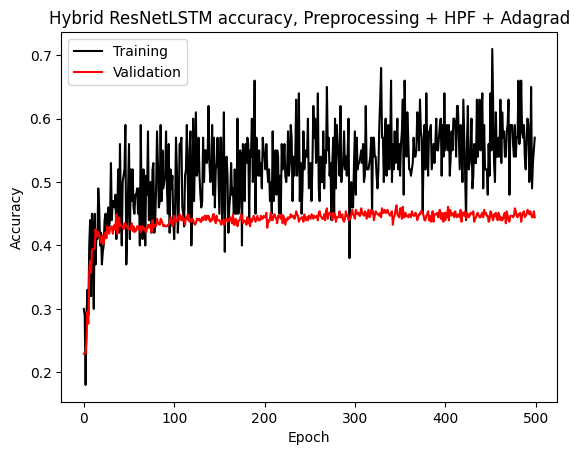

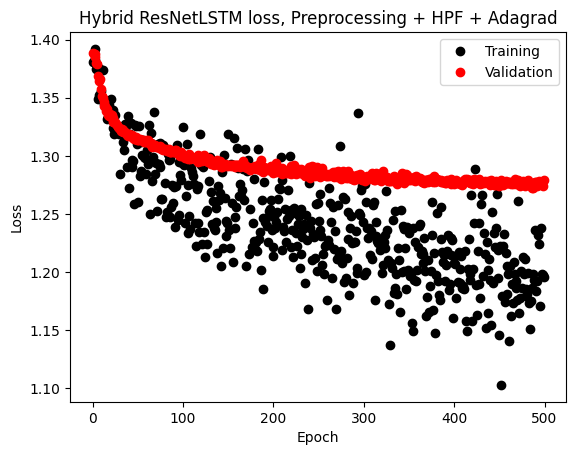

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_7,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_7,label='Validation',color='r')
plt.title('Hybrid ResNetLSTM accuracy, Preprocessing + HPF + Adagrad')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_7,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_7,'o',label='Validation',color='r')
plt.title('Hybrid ResNetLSTM loss, Preprocessing + HPF + Adagrad')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Testing Models

In [ ]:
#Model 4 achieved the best validation accuracy. Test on test dataset.
model4.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model4(test_x).detach()
    logits = nn.functional.softmax(logits)
    test_loss = criterion(logits.float(), test_y.float())
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the ResNet model: ', test_acc.item())

Test accuracy of the ResNet model:  0.5417607426643372


<ipython-input-29-6894a567b70e>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)


In [10]:
# Model 1
model1.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model1(test_x).detach()
    logits = nn.functional.softmax(logits)
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the ResNet model: ', test_acc.item())

Test accuracy of the ResNet model:  0.43566590547561646


<ipython-input-10-25ef68e70525>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)


In [15]:
# Model 2
model2.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model2(test_x).detach()
    logits = nn.functional.softmax(logits)
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the ResNet model: ', test_acc.item())

Test accuracy of the ResNet model:  0.48758465051651


<ipython-input-15-4367209bab02>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)


In [21]:
# Model 3
model3.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model3(test_x).detach()
    logits = nn.functional.softmax(logits)
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the ResNet model: ', test_acc.item())

Test accuracy of the ResNet model:  0.5259593725204468


<ipython-input-21-cc5f3518a681>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)


In [27]:
# Model 5
model5.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model5(test_x).detach()
    logits = nn.functional.softmax(logits)
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the ResNet model: ', test_acc.item())

Test accuracy of the ResNet model:  0.5214446783065796


<ipython-input-27-d75318a2e74d>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)


In [33]:
# Model 6
model6.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model6(test_x).detach()
    logits = nn.functional.softmax(logits)
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the ResNet model: ', test_acc.item())

Test accuracy of the ResNet model:  0.2866817116737366


<ipython-input-33-32a71b7999a8>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)


In [36]:
# Model 7
model7.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model7(test_x).detach()
    logits = nn.functional.softmax(logits)
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the ResNet model: ', test_acc.item())

Test accuracy of the ResNet model:  0.40857788920402527


<ipython-input-36-0ad0a707887e>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
